In [1]:
import numpy as np
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.legend_handler import HandlerLine2D


import scipy
from scipy import stats
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math
from ReadFile import Read
import pandas as pd
from matplotlib.patches import Rectangle

In [2]:
plt.rcParams.update({
                    "text.usetex": True,
                    "font.family": "serif",
                    "font.sans-serif": ["Times"]})

#font.serif         : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#font.sans-serif    : Helvetica, Avant Garde, Computer Modern Sans serif
#font.cursive       : Zapf Chancery
#font.monospace     : Courier, Computer Modern Typewriter

In [3]:
Mgsol = 5.08 #banda g
Misol = 4.53 #banda i
Mrsol = 4.64 #banda r 

In [4]:
# catalog
catalog =  Read('SDSS_DR7_sersic_photometric_catalog.txt')


In [5]:
catalog_diamond =  Read('SDSS_DR7_sersic_photometric_catalog_diamond.txt')

In [6]:
catalog_diamond_sfr =  Read('SDSS_DR7_sersic_photometric_catalog_diamond_sfrs.txt')

In [7]:
catalog_full = Read('SDSS_DR7_sersic_photometric_full_catalog.txt')

In [8]:
########## LUMINOSITES INTENSITIES AND MAGNITUDES ##################


# Sersic general equation for any n. Eq. 2.22 from Galaxy Formation & Evolution 
# Need to define Reff first
# Bn 2n-0.324 (but only for n=>1) (B beta)
# To write I(R) in terms of L_tot instead of I0:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n))} exp[-bn(R/Re)**(1/n)]
# To write I(R) in terms of L_tot instead of Ie:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n)*exp(bn))} exp[-bn{(R/Re)**(1/n)-1}]


def I0_to_Ie(I0):
    #units Lsun / kpc**2
    
    Bn = 1.9992*n - 0.3271
    
    return I0/np.exp(Bn)

def Ie_to_I0(Ie):
    #units Lsun / kpc**2
    
    Bn = 1.9992*n-0.3271
    
    return Ie*np.exp(Bn)
    
    

def Ltot_to_I0(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    #units Lsun / kpc**2
    
    Bn = 1.9992*n-0.3271
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm
    
    return I0

def Ltot_to_Ie(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns Ie
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma/np.exp(Bn)
    
    Bn = 1.9992*n-0.3271
    
    gm = math.gamma(2*n)  #gamma function
    
    Ie = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm/np.exp(Bn)
    
    return Ie
    

def sersic_profile(r, Ie, n, Re):
    # I0 puede ser L_tot
    # The surface brightness profile of spheroidal galaxies is generally well fit by the Sersic profile
    # Compare to sersic mass density 
    # I(R) = I0*exp[-Bn(R/Re)**(1/n)] = Ie*exp[-Bn{(R/Re)**(1/n)-1}]
    # Ie = I0/exp(Bn)
    # Inputs: radius, Intesity, sersic index, Reff
    # units are Lsun / kpc**2
    # Eq 2.22 from Galaxy Formation & Evolution
   
    Bn = 1.9992*n-0.3271
    ratio = (r/Re)**(1/n)
    exponent = -Bn*(ratio-1)
    
    return Ie*np.exp(exponent)



def L_profile(r, Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system but as a function of radius. 
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR)
    # integrate sersic profile from 0 to R
    # inputs:
    #        radius, Intensity(e), sersic index, R eff
    
    def L(r, Ie, n, Re):
        
        return 2*np.pi*sersic_profile(r, Ie, n, Re)*r
    
    I = integrate.quad(L, 0 ,r, args=(Ie, n, Re), epsabs=1e-03, epsrel=1e-03, limit=15, maxp1=20, limlst=20)

    
    
    ansI = I[0]
    
    return ansI

def L_tot(Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # Inputs :
    #         Intensity(e), sersic index, Eff rad
    # L = 2*pi*integral(I(R)RdR) = (2*pi*G(2n)/(Bn)**(2*n))*I0*Re**2
    # integrate sersic profile from 0 to inf
    # Returns the total Luminosity
    "units of Lsun?"
    
    Bn = 2*n-0.324
    
    gm = math.gamma(2*n)  #gamma function buscar funcion completa
    
    I0 = Ie*np.exp(Bn)    
    
    L = (2*np.pi*n*gm/(Bn)**(2*n))*I0*Re**2
    
    return L

def abs_mag_to_log10Lx(Mabs_x, Mabs_xsol):
#     Input: x = band, Mx = absolute magnitude of a given object at a given band
#     Returns the total luminosity at a given band of the galaxy
#     M_gsol = 5.11 #banda g 
#     M_isol = 4.53 #banda i
#     Log(L_x/L_xsol) = -0.4* (M_x - M_xsol) 
#     Eq 2.6 from Galaxy Formation & Evolution
#     This returns the LOG of the luminosity!
    
    return -0.4*(Mabs_x-Mabs_xsol) #### Log(Lx/L_xsol)


def Lx_to_abs_mag(Lx, Mabs_xsol):
    # M_x  =  -2.5 *log(L_x/L_xsol) + M_xsol
    # It takes L_profile as input to make it an absolute magnited as a function of radius
    # Substract two different bands to get the color
    

    return -2.5 * np.log10(Lx) + Mabs_xsol #### Absolute Magnitude

In [9]:
 ################ MASS PROFILES #########################   
    
    
def stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
    
##llamar una funcion cualquier (ie func en el input) func puede ser Stellar_mass_from_gi
# To make it a function of radius
# Inputs:
#       radius, Intensity(e), sersic index, Magnitudes of the g and i bands
   
   
    Lr_x = L_profile(r, Ie_x, n_x, Re_x)
    Lr_y = L_profile(r, Ie_y, n_y, Re_y)
    Mr_x = Lx_to_abs_mag(Lr_x, Mabs_xsol)
    Mr_y = Lx_to_abs_mag(Lr_y, Mabs_ysol)
   # We need the luminosity profile of the i band to make it a function of radius 
   
    return func(Lr_y, Mr_x, Mr_y) 



def Stellar_mass_from_gi(LtI, Mxg, Mxi):
# Log(Ms/Msol) = -0.68 + 0.73 * (g-i)  + log10(L_i/L_isol)
# Total stellar mass 
# Instead of the Luminosity profile, we use the total luminosity
#"only units of solar mass?"
   
    color = Mxg - Mxi 
   
    logMs =  -0.68 + 0.73 * color  + np.log10(LtI)
    
   
    return 10**logMs


def Stellar_mass_Bell_gr(LtR, Mxg, Mxr):
   #log10Mste_Bell_r = -0.406 + 1.097 * (g-r) + log10(L_r) 
   
    color = Mxg - Mxr
   
    logMs = -0.406 + 1.097 * color + np.log10(LtR) 
   
    return 10**logMs

def Stellar_mass_Bell_gi(LtI, Mxg, Mxi):
   #log10Mste_Bell_i = - 0.252 + 0.518*(g-i)+log10(L_i)
   
    color = Mxg - Mxi
   
    logMs = - 0.252 + 0.518* color + np.log10(LtI)
   
    return 10**logMs

def Stellar_mass_Zibetti_gr(LtR, Mxg, Mxr):
   #log10Mste_Zibetti_r = -0.840 + 1.654 * (g-r) + log10(L_r)
   
    color = Mxg - Mxr
   
    logMs = -0.840 + 1.654 * color + np.log10(LtR) 
   
    return 10**logMs

def Stellar_mass_Zibetti_gi(LtI, Mxg, Mxi):
   #log10Mste_Zibetti_i = -0.963 + 1.032*(g-i) + log10(L_i)
   
    color = Mxg - Mxi
   
    logMs = -0.963 + 1.032 * color + np.log10(LtI)
   
    return 10**logMs


def r_effective(func, Mstot,Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
   # Computes the effective (mass) radius. Where half of the total mass is located
   #  total_stellar_mass/2 = stellar_mass_profile 

    def f(r, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
        
       
        return 0.5* Mstot - stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
    
    fa = f(Re_y/6, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
    
    fb = f(Re_y*6, func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol)
     
    if fa > 0 and fb < 0:
        
        
        r_m2 = optimize.bisect(f, Re_y/6, Re_y*6, xtol = 1e-4, rtol=1e-4, args=(func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol), maxiter = 20)
    elif fa < 0 and fb > 0:
        
       
        r_m2 = optimize.bisect(f, Re_y/6, Re_y*6, xtol = 1e-4, rtol=1e-4, args=(func, Mstot, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol), maxiter = 20)
    else:
        
        r_m2 = - 99 ## not a physical number. means its not calculating 
           
  
    return r_m2

def Sigma_1(func, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol):
    
    r = 1 
    
    return stellar_mass_profile(func, r, Ie_x, Ie_y, n_x, n_y, Re_x, Re_y, Mabs_xsol, Mabs_ysol) / np.pi






In [10]:
def Radius_function( alpha_k, beta_k, gamma_k, M0_k, logMs):

    

    Am = gamma_k * 10**(alpha_k * logMs)



    x = 10**(logMs -M0_k)



    return  Am * ( 1. + x)**(beta_k-alpha_k)



def Rk_ETGs(logMs):



    Rk =Radius_function(0.11,0.72,0.09,np.log10(1.57) + 10,logMs)

    Rr = Radius_function(0.11,0.78,0.12,np.log10(2.25) + 10,logMs)

    

    return Rk/Rr



def Rk_LTGs(logMs):

    

    Rk =Radius_function(0.14,0.91,0.13,np.log10(14.03) + 10,logMs)

    Rr = Radius_function(0.16,1.00,0.10,np.log10(33.62) + 10,logMs)

    

    return Rk/Rr



In [11]:
##### exctracting the values I need from the table 

n_g = catalog['nsersic_g']
Re_g = catalog['Re_g']
Ltot_g = catalog['L_g']
Mg = catalog['Mg']

n_i = catalog['nsersic_i']
Re_i = catalog['Re_i']
Ltot_i = catalog['L_i']
Mi = catalog['Mi']

n_r = catalog['nsersic_r']
Re_r = catalog['Re_r']
Ltot_r = catalog['L_r']
Mr = catalog['Mr']



In [12]:
# # First we need Ie from Ltot on each band, then evaluate the stellar mass for each function, then the mass
# # profile evaluated at each stellar mass profile

# # Uncomment to calculate again. Not needed anymore


# myFile = open("tabla.txt","w")
# myFile.write("num" + "," + "Ie_g" + "," + "Ie_i" + "," + "Ie_r" + "," + "Ms_gi"+ "," + "Ms_gr_B" + "," + "Ms_gi_B" + "," + "Ms_gr_Z" + "," \
#              + "Ms_gi_Z" + "," + "Re_ste_gi" + "," + "Re_ste_gr_B" + "," + "Re_ste_gi_B" + "," + "Re_ste_gr_Z" + "," + "Re_ste_gi_Z" + "," \
#              + "S1_gi" + "," + "S1_grB" + "," + "S1_giB"+ ","  + "S1_grZ"+ ","  + "S1_giZ"+"\n") 



# for i in range(0, 603864):
# # for i in range(0, 100):

#     ID = [i]

#     Ie_g=Ltot_to_Ie(Ltot_g[i], Re_g[i], n_g[i])

#     Ie_i=Ltot_to_Ie(Ltot_i[i], Re_i[i], n_i[i])

#     Ie_r=Ltot_to_Ie(Ltot_r[i], Re_r[i], n_r[i])

    

#     Ms_gi=Stellar_mass_from_gi(Ltot_i[i], Mg[i], Mi[i])

#     Ms_gr_B=Stellar_mass_Bell_gr(Ltot_r[i], Mg[i], Mr[i])

#     Ms_gi_B=Stellar_mass_Bell_gi(Ltot_i[i], Mg[i], Mi[i])

#     Ms_gr_Z=Stellar_mass_Zibetti_gr(Ltot_r[i], Mg[i], Mr[i])

#     Ms_gi_Z=Stellar_mass_Zibetti_gi(Ltot_i[i], Mg[i], Mi[i])

    

#     Re_ste_gi=r_effective(Stellar_mass_from_gi, Ms_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)

#     Re_ste_gr_B=r_effective(Stellar_mass_Bell_gr, Ms_gr_B, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)

#     Re_ste_gi_B=r_effective(Stellar_mass_Bell_gi, Ms_gi_B, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)

#     Re_ste_gr_Z=r_effective(Stellar_mass_Zibetti_gr, Ms_gr_Z, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)

#     Re_ste_gi_Z=r_effective(Stellar_mass_Zibetti_gi, Ms_gi_Z, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
    
#     S1_gi = Sigma_1(Stellar_mass_from_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
#     S1_grB = Sigma_1(Stellar_mass_Bell_gr, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)
#     S1_giB = Sigma_1(Stellar_mass_Bell_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)
#     S1_grZ = Sigma_1(Stellar_mass_Zibetti_gr, Ie_g, Ie_r, n_g[i], n_r[i], Re_g[i], Re_r[i], Mgsol, Mrsol)
#     S1_giZ = Sigma_1(Stellar_mass_Zibetti_gi, Ie_g, Ie_i, n_g[i], n_i[i], Re_g[i], Re_i[i], Mgsol, Misol)    
   
  
#     myFile.write(str(ID) + "" + str(np.format_float_scientific(Ie_g, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ie_i, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ie_r, unique=False, precision=5))\
#                  + " " + str(np.format_float_scientific(Ms_gi, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gr_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gi_B, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Ms_gr_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(Ms_gi_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gi, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Re_ste_gr_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gi_B, unique=False, precision=5)) + " " + str(np.format_float_scientific(Re_ste_gr_Z, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(Re_ste_gi_Z, unique=False, precision=5)) + " " + str(np.format_float_scientific(S1_gi, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_grB, unique=False, precision=5)) \
#                  + " " + str(np.format_float_scientific(S1_giB, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_grZ, unique=False, precision=5))+ " " + str(np.format_float_scientific(S1_giZ, unique=False, precision=5))+"\n")
# myFile.close() 


    

In [13]:
# Reading the five catalogs for different color-to-mass ratios.

# catalog_T =  Read('SDSS_DR7_sersic_photometric_catalog_Taylor_gi.txt')
# catalog_Bgr =  Read('SDSS_DR7_sersic_photometric_catalog_Bell_gr.txt')
# catalog_Bgi =  Read('SDSS_DR7_sersic_photometric_catalog_Bell_gi.txt')
# catalog_Zgr =  Read('SDSS_DR7_sersic_photometric_catalog_Zibetti_gr.txt')
# catalog_Zgi =  Read('SDSS_DR7_sersic_photometric_catalog_Zibetti_gi.txt')


In [14]:
# Reading limits of completeness 

mass_limit = Read('Size_psf_SDSS_mass_limit.txt')

In [15]:
# # Suess data

# Suess_q = Read('Suess_19_Qched.txt')
# Suess_sf = Read('Suess_19_SFing.txt')

# # Reading points from Suess data for Figure 2 Suess 2 2019

# Re_Suess_q = Suess_q['Re_mass_Re_light']
# z_Suess_q = Suess_q['z']
# Re_Suess_sf = Suess_sf['Re_mass_Re_light']
# z_Suess_sf = Suess_sf['z']
# err_up_q = Suess_q['err_up']
# err_down_q = Suess_q['err_low']
# err_up_sf = Suess_sf['err_up']
# err_down_sf = Suess_sf['err_low']

In [16]:
# I don't need to exctract these so far. The code calculates these to calculae the masses and the effective radii
# Ie_g= catalog['Ie_g']
# Ie_i= catalog['Ie_i']
# Ie_r= catalog['Ie_r']

# Ms = catalog['Ms']
# Ms_gi= catalog_T['Ms'] 
# Ms_gr_B= catalog_Bgr['Ms']
# Ms_gi_B= catalog_Bgi['Ms']
# Ms_gr_Z= catalog_Zgr['Ms']
# Ms_gi_Z= catalog_Zgi['Ms']
Ms_d = catalog_diamond['Ms']
Ms_gi_full = catalog_full['Ms_gi']

# Re_ste_gi= catalog_T['Re']
# Re_ste_gr_B= catalog_Bgr['Re']
# Re_ste_gi_B= catalog_Bgi['Re']
# Re_ste_gr_Z= catalog_Zgr['Re']
# Re_ste_gi_Z= catalog_Zgi['Re']
Re_ste_d = catalog_diamond['Re']
Re_ste_d_sfr = catalog_diamond_sfr['Re']

# S1_gi = catalog_T['Sigma_1']     
# S1_grB = catalog_Bgr['Sigma_1']       
# S1_giB = catalog_Bgi['Sigma_1']       
# S1_grZ = catalog_Zgr['Sigma_1']       
# S1_giZ = catalog_Zgi['Sigma_1'] 
S1_d = catalog_diamond['Sigma_1']


# disk_gi = catalog_T['P_early'] < 0.65
# disk_grB = catalog_Bgr['P_early'] < 0.65
# disk_giB = catalog_Bgi['P_early'] < 0.65
# disk_grZ = catalog_Zgr['P_early'] < 0.65
# disk_giZ = catalog_Zgi['P_early'] < 0.65
disk_d = catalog_diamond['P_early'] < 0.65
disk_d_sfr = catalog_diamond_sfr['P_early'] < 0.65
# sphr_gi = catalog_T['P_early'] >= 0.65
# sphr_grB = catalog_Bgr['P_early'] >= 0.65
# sphr_giB = catalog_Bgi['P_early'] >= 0.65
# sphr_grZ = catalog_Zgr['P_early'] >= 0.65
# sphr_giZ = catalog_Zgi['P_early'] >= 0.65
sphr_d = catalog_diamond['P_early'] >= 0.65
sphr_d_sfr = catalog_diamond_sfr['P_early'] >= 0.65

P_early = catalog_diamond['P_early']


# Re_r_gi = catalog_T['Re_r']
# Re_r_grB = catalog_Bgr['Re_r']
# Re_r_giB = catalog_Bgi['Re_r']
# Re_r_grZ = catalog_Zgr['Re_r']
# Re_r_giZ = catalog_Zgi['Re_r']
Re_r_d = catalog_diamond['Re_r']
Re_r_full = catalog_full['Re_r']

# Re_g_gi = catalog_T['Re_g']
# Re_g_grB = catalog_Bgr['Re_g']
# Re_g_giB = catalog_Bgi['Re_g']
# Re_g_grZ = catalog_Zgr['Re_g']
# Re_g_giZ = catalog_Zgi['Re_g']
Re_g_d = catalog_diamond['Re_g']
Re_g_full = catalog_full['Re_g']


z_d = catalog_diamond['z'] 
z_full = catalog_full['z']


    
# For figure 5 Suess

n_r_d = catalog_diamond['nsersic_r']
log_sSFR = catalog_diamond_sfr['log10sSFR']


# Color profile diamond

L_i_d = catalog_diamond['L_i']
L_g_d = catalog_diamond['L_g']
L_r_d = catalog_diamond['L_r']
Ie_i_d = catalog_diamond['Ie_i']
Ie_g_d = catalog_diamond['Ie_g']
Ie_r_d = catalog_diamond['Ie_r']
ni_d = catalog_diamond['nsersic_i']
ng_d = catalog_diamond['nsersic_g']
nr_d = catalog_diamond['nsersic_r']
Re_i_d = catalog_diamond['Re_i']
Re_g_d = catalog_diamond['Re_g']
Re_r_d = catalog_diamond['Re_r']


grd = catalog_diamond['gr']
gid = catalog_diamond['gi']

# Sfr catalog for figures that show sSFR
L_i_d_sfr = catalog_diamond_sfr['L_i']
L_g_d_sfr = catalog_diamond_sfr['L_g']
L_r_d_sfr = catalog_diamond_sfr['L_r']
Ie_i_d_sfr = catalog_diamond_sfr['Ie_i']
Ie_g_d_sfr = catalog_diamond_sfr['Ie_g']
Ie_r_d_sfr = catalog_diamond_sfr['Ie_r']
ni_d_sfr = catalog_diamond_sfr['nsersic_i']
ng_d_sfr = catalog_diamond_sfr['nsersic_g']
nr_d_sfr = catalog_diamond_sfr['nsersic_r']
Re_i_d_sfr = catalog_diamond_sfr['Re_i']
Re_g_d_sfr = catalog_diamond_sfr['Re_g']
Re_r_d_sfr = catalog_diamond_sfr['Re_r']

In [17]:
#### Dust extintion correction for disk galaxies from Hernandez-Toledo 2008 eq. 1

# magnitudes from diamond catalog

M_g = catalog_diamond['M_g']
M_r = catalog_diamond['M_r']
M_i = catalog_diamond['M_i']

# ellipticity b/a
ba_i = catalog_diamond['ba_i']
ba_g = catalog_diamond['ba_g']
ba_r = catalog_diamond['ba_r']

# correction coefficient

gamma_g = -6.00 - 0.38*M_g
gamma_r = -4.00 - 0.25*M_r
gamma_i = -3.60 - 0.21*M_i

Ag = gamma_g * np.log10(1/ba_g)
Ar = gamma_r * np.log10(1/ba_r)
Ai = gamma_i * np.log10(1/ba_i)

# corrected magnitudes

Mg_dust = M_g - Ag
Mr_dust = M_r - Ar
Mi_dust = M_i - Ai



#### color corrected

gr_dust = Mg_dust[disk_d] - Mr_dust[disk_d]
gi_dust = Mg_dust[disk_d] - Mi_dust[disk_d]



In [18]:
########################## RATIOS ################################


# Making variables of the radii ratios in the r band

# ratio_gi = Re_ste_gi/Re_r_gi
# ratio_gr_B = Re_ste_gr_B/Re_r_grB
# ratio_gi_B = Re_ste_gi_B/Re_r_giB
# ratio_gr_Z = Re_ste_gr_Z/Re_r_grZ
# ratio_gi_Z = Re_ste_gi_Z/Re_r_giZ
ratio_d = Re_ste_d/Re_r_d
ratio_d_sfr = Re_ste_d_sfr/Re_r_d_sfr

# Making variables of the radii ratio in the g band

# ratio_g_gi = Re_ste_gi/Re_g_gi
# ratio_g_gr_B = Re_ste_gr_B/Re_g_grB
# ratio_g_gi_B = Re_ste_gi_B/Re_g_giB
# ratio_g_gr_Z = Re_ste_gr_Z/Re_g_grZ
# ratio_g_gi_Z = Re_ste_gi_Z/Re_g_giZ
ratio_g_d = Re_ste_d/Re_g_d


# Late radii ratios r band
# r_gi_late = ratio_gi[disk_gi]
# r_gr_B_late = ratio_gr_B[disk_grB]
# r_gi_B_late = ratio_gi_B[disk_giB]
# r_gr_Z_late = ratio_gr_Z[disk_grZ]
# r_gi_Z_late = ratio_gi_Z[disk_giZ]
r_d_late = ratio_d[disk_d]
r_d_sfr_late = ratio_d_sfr[disk_d_sfr]

# Late radii ratios g band
# r_g_gi_late = ratio_g_gi[disk_gi]
# r_g_gr_B_late = ratio_g_gr_B[disk_grB]
# r_g_gi_B_late = ratio_g_gi_B[disk_giB]
# r_g_gr_Z_late = ratio_g_gr_Z[disk_grZ]
# r_g_gi_Z_late = ratio_g_gi_Z[disk_giZ]
r_g_d_late = ratio_g_d[disk_d]

# Early radii ratios r band
# r_gi_early = ratio_gi[sphr_gi]
# r_gr_B_early = ratio_gr_B[sphr_grB]
# r_gi_B_early = ratio_gi_B[sphr_giB]
# r_gr_Z_early = ratio_gr_Z[sphr_grZ]
# r_gi_Z_early = ratio_gi_Z[sphr_giZ]
r_d_early = ratio_d[sphr_d]
r_d_sfr_early = ratio_d_sfr[sphr_d_sfr]

# Early radii ratios g band
# r_g_gi_early = ratio_g_gi[sphr_gi]
# r_g_gr_B_early = ratio_g_gr_B[sphr_grB]
# r_g_gi_B_early = ratio_g_gi_B[sphr_giB]
# r_g_gr_Z_early = ratio_g_gr_Z[sphr_grZ]
# r_g_gi_Z_early = ratio_g_gi_Z[sphr_giZ]
r_g_d_early = ratio_g_d[sphr_d]


# # ### These are only for Taylor radii, no ratio, in the r band 
# re_gi_early = Re_ste_gi[sphr_gi]
# re_gi_late = Re_ste_gi[disk_gi]
# re_r_early = Re_r_gi[sphr_gi]
# re_r_late = Re_r_gi[disk_gi]


# # ### These are only for Zibetti r radii, no ratio, in the r band 
# re_gr_Z_early = Re_ste_gr_Z[sphr_grZ]
# re_gr_Z_late = Re_ste_gr_Z[disk_grZ]
# re_r_Zr_early = Re_r_grZ[sphr_grZ]
# re_r_Zr_late = Re_r_grZ[disk_grZ]

# # ### These are only for Zibetti r radii, no ratio, in the r band 
# re_gr_B_early = Re_ste_gr_B[sphr_grB]
# re_gr_B_late = Re_ste_gr_B[disk_grB]
# re_r_Zr_early = Re_r_grB[sphr_grB]
# re_r_Zr_late = Re_r_grB[disk_grB]

# ### These are only for diamond radii, no ratio, in the r band
re_d_early = Re_ste_d[sphr_d]
re_d_late = Re_ste_d[disk_d]
re_r_d_early = Re_r_d[sphr_d]
re_r_d_late = Re_r_d[disk_d]

# ratios and radii in the i band for diamond

ratio_i_d = Re_ste_d/Re_i_d
r_i_d_late = ratio_i_d[disk_d]
r_i_d_early = ratio_i_d[sphr_d]
re_i_d_early = Re_i_d[sphr_d]
re_i_d_late = Re_i_d[disk_d]


# Late masses

# Ms_gi_late = Ms_gi[disk_gi]
# Ms_gr_B_late = Ms_gr_B[disk_grB]
# Ms_gi_B_late = Ms_gi_B[disk_giB]
# Ms_gr_Z_late = Ms_gr_Z[disk_grZ]
# Ms_gi_Z_late = Ms_gi_Z[disk_giZ]
Ms_d_late = Ms_d[disk_d]

# Early masses

# Ms_gi_early = Ms_gi[sphr_gi]
# Ms_gr_B_early = Ms_gr_B[sphr_grB]
# Ms_gi_B_early = Ms_gi_B[sphr_giB]
# Ms_gr_Z_early = Ms_gr_Z[sphr_grZ]
# Ms_gi_Z_early = Ms_gi_Z[sphr_giZ]
Ms_d_early = Ms_d[sphr_d]

#sSFR early late g-r

log_sSFR_late = log_sSFR[disk_d_sfr]
log_sSFR_early = log_sSFR[sphr_d_sfr]


# Sigma1 early late Taylo and Zibetti

# S1_gi_late = S1_gi[disk_gi]
# S1_gi_early = S1_gi[sphr_gi]
# S1_gr_late = S1_grZ[disk_grZ]
# S1_gr_early = S1_grZ[sphr_grZ]
S1_d_late = S1_d[disk_d]
S1_d_early = S1_d[sphr_d]


# sersic index early late diamond catalog

n_r_d_early = n_r_d[sphr_d]
n_r_d_late = n_r_d[disk_d]




In [19]:
# # Mass > 10.8 for Figure 2 Suess 2 2019 in the r band
# # Median half-mass to half-light radius ratio for star- forming and quiescent galaxies 
# # (blue circles and red squares) as a function of redshift.

# Ms_d_S = Ms_d > (np.log10(10.8))
# Re_ste_d_S = Re_ste_d[Ms_d_S]
# Re_r_d_S = Re_r_d[Ms_d_S]

# late_S = Ms_d_S & disk_d
# early_S = Ms_d_S & sphr_d
# z_d_late_S = z_d[late_S]
# z_d_early_S = z_d[early_S]

# ratio_S = Re_ste_d_S / Re_r_d_S

# ratio_late_S = ratio_S[disk_d]
# ratio_early_S = ratio_S[sphr_d]

# # Mass > 10.8 for Figure 2 Suess in the g band

# Ms_d_S = Ms_d > (np.log10(10.8))
# Re_ste_d_S = Re_ste_d[Ms_d_S]
# Re_g_d_S = Re_g_d[Ms_d_S]

# late_S = Ms_d_S & disk_d
# early_S = Ms_d_S & sphr_d
# z_d_late_S = z_d[late_S]
# z_d_early_S = z_d[early_S]

# ratio_g_S = Re_ste_d_S / Re_g_d_S

# ratio_g_late_S = ratio_g_S[disk_d]
# ratio_g_early_S = ratio_g_S[sphr_d]





In [20]:
# # Average stellar mass. Ratio effective radii in the r band. 20 bins All galaxies
# # Object count
# # Stabdard deviation 

# stat_gi_mean, gi_means_bins, binnum_gi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='mean', bins=20, range=(9,11.6))
# stat_gr_B_mean, gr_B_means_bins, binnum_grB_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='mean', bins=20, range=(9,11.6))
# stat_gi_B_mean, gi_B_means_bins, binnum_giB_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='mean', bins=20, range=(9,11.6))
# stat_gr_Z_mean, gr_Z_means_bins, binnum_grZ_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='mean', bins=20, range=(9,11.6))
# stat_gi_Z_mean, gi_Z_means_bins, binnum_giZ_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='mean', bins=20, range=(9,11.6))
# stat_d_mean, d_means_bins, binnum_d_mean = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='mean', bins=20, range=(9,12))

# stat_gi_count, gi_count_bins, binnum_gi_count  = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='count', bins=20, range=(9,11.6))
# stat_gr_B_count, gr_B_count_bins, binnum_grB_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='count', bins=20, range=(9,11.6))
# stat_gi_B_count, gi_B_count_bins, binnum_giB_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='count', bins=20, range=(9,11.6))
# stat_gr_Z_count, gr_Z_count_bins, binnum_grZ_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='count', bins=20, range=(9,11.6))
# stat_gi_Z_count, gi_Z_count_bins, binnum_giZ_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='count', bins=20, range=(9,11.6))
# stat_d_count, d_count_bins, binnum_d_count  = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='count', bins=20, range=(9,12))

# stat_gi_std, gi_std_bins, binnum_gi_std = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_gi), statistic='std', bins=20, range=(9,11.6))
# stat_gr_B_std, gr_B_std_bins, binnum_grB_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_gr_B), statistic='std', bins=20, range=(9,11.6))
# stat_gi_B_std, gi_B_std_bins, binnum_giB_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_gi_B), statistic='std', bins=20, range=(9,11.6))
# stat_gr_Z_std, gr_Z_std_bins, binnum_grZ_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_gr_Z), statistic='std', bins=20, range=(9,11.6))
# stat_gi_Z_std, gi_Z_std_bins, binnum_giZ_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_gi_Z), statistic='std', bins=20, range=(9,11.6))
# stat_d_std, d_std_bins, binnum_d_std = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_d), statistic='std', bins=20, range=(9,12))



# # Average stellar mass. Ratio effective radii in the g band. 20 bins All galaxies
# # Object count
# # Standard deviation 

# stat_gi_g_mean, gi_g_means_bins, binnum_gi_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='mean', bins=20, range=(9,11.5))
# stat_gr_B_g_mean, gr_B_g_means_bins, binnum_grB_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='mean', bins=20, range=(9,11.5))
# stat_gi_B_g_mean, gi_B_g_means_bins, binnum_giB_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='mean', bins=20, range=(9,11.5))
# stat_gr_Z_g_mean, gr_Z_g_means_bins, binnum_grZ_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='mean', bins=20, range=(9,11.5))
# stat_gi_Z_g_mean, gi_Z_g_means_bins, binnum_giZ_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='mean', bins=20, range=(9,11.5))
# stat_d_g_mean, d_g_means_bins, binnum_d_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='mean', bins=20, range=(9,12))

# stat_gi_g_count, gi_g_count_bins, binnum_gi_g_count  = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='count', bins=20, range=(9,11.5))
# stat_gr_B_g_count, gr_B_g_count_bins, binnum_grB_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='count', bins=20, range=(9,11.5))
# stat_gi_B_g_count, gi_B_g_count_bins, binnum_giB_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='count', bins=20, range=(9,11.5))
# stat_gr_Z_g_count, gr_Z_g_count_bins, binnum_grZ_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='count', bins=20, range=(9,11.5))
# stat_gi_Z_g_count, gi_Z_g_count_bins, binnum_giZ_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='count', bins=20, range=(9,11.5))
# stat_d_g_count, d_g_count_bins, binnum_d_g_count  = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='count', bins=20, range=(9,12))

# stat_gi_g_std, gi_g_std_bins, binnum_gi_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi), np.log10(ratio_g_gi), statistic='std', bins=20, range=(9,11.5))
# stat_gr_B_g_std, gr_B_g_std_bins, binnum_grB_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B), np.log10(ratio_g_gr_B), statistic='std', bins=20, range=(9,11.5))
# stat_gi_B_g_std, gi_B_g_std_bins, binnum_giB_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B), np.log10(ratio_g_gi_B), statistic='std', bins=20, range=(9,11.5))
# stat_gr_Z_g_std, gr_Z_g_std_bins, binnum_grZ_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z), np.log10(ratio_g_gr_Z), statistic='std', bins=20, range=(9,11.5))
# stat_gi_Z_g_std, gi_Z_g_std_bins, binnum_giZ_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z), np.log10(ratio_g_gi_Z), statistic='std', bins=20, range=(9,11.5))
# stat_d_g_std, d_g_std_bins, binnum_d_g_std = scipy.stats.binned_statistic(np.log10(Ms_d), np.log10(ratio_g_d), statistic='std', bins=20, range=(9,12))


# # Average stellar mass. Ratio effective radii in the r band . 20 bins Late galaxies
# # Object count
# # Standard deviation 

# stat_gi_late_mean, gilate_means_bins, binnum_gilate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gr_B_late_mean, grBlate_means_bins, binnum_grBlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='mean', bins=20, range=(9,11.5))
# stat_gi_B_late_mean, giBlate_means_bins, binnum_giBlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='mean', bins=20, range=(9,11.5))
# stat_gr_Z_late_mean, grZlate_means_bins, binnum_grZlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gi_Z_late_mean, giZlate_means_bins, binnum_giZlate_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='mean', bins=20, range=(9,11.3))
# stat_d_late_mean, dlate_means_bins, binnum_dlate_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='mean', bins=20, range=(9,11.3))

# stat_gi_late_count, gilate_count_bins, binnum_gilate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='count', bins=20, range=(9,11.3))
# stat_gr_B_late_count, grBlate_count_bins, binnum_grBlate_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='count', bins=20, range=(9,11.5))
# stat_gi_B_late_count, giBlate_count_bins, binnum_giBlate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='count', bins=20, range=(9,11.5))
# stat_gr_Z_late_count, grZlate_count_bins, binnum_grZlate_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='count', bins=20, range=(9,11.3))
# stat_gi_Z_late_count, giZlate_count_bins, binnum_giZlate_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='count', bins=20, range=(9,11.3))
# stat_d_late_count, dlate_count_bins, binnum_dlate_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='count', bins=20, range=(9,11.3))

# stat_gi_std_late, gilate_std_bins, binnum_gilate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_gi_late), statistic='std', bins=20, range=(9,11.3))
# stat_gr_B_std_late, grBlate_std_bins, binnum_grBlate_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_gr_B_late), statistic='std', bins=20, range=(9,11.5))
# stat_gi_B_std_late, giBlate_std_bins, binnum_giBlate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_gi_B_late), statistic='std', bins=20, range=(9,11.5))
# stat_gr_Z_std_late, grZlate_std_bins, binnum_grZlate_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_gr_Z_late), statistic='std', bins=20, range=(9,11.3))
# stat_gi_Z_std_late, giZlate_std_bins, binnum_giZlate_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_gi_Z_late), statistic='std', bins=20, range=(9,11.3))
# stat_d_std_late, dlate_std_bins, binnum_dlate_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='std', bins=20, range=(9,11.3))

# # Average stellar mass. Ratio effective radii in the g band . 20 bins Late galaxies
# # Object count
# # Standard deviation 

# stat_gi_g_late_mean, gilate_g_means_bins, binnum_gilate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gr_B_g_late_mean, grBlate_g_means_bins, binnum_grBlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gi_B_g_late_mean, giBlate_g_means_bins, binnum_giBlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gr_Z_g_late_mean, grZlate_g_means_bins, binnum_grZlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='mean', bins=20, range=(9,11.3))
# stat_gi_Z_g_late_mean, giZlate_g_means_bins, binnum_giZlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='mean', bins=20, range=(9,11.3))
# stat_d_g_late_mean, dlate_g_means_bins, binnum_dlate_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='mean', bins=20, range=(9,11.3))

# stat_gi_g_late_count, gilate_g_count_bins, binnum_gilate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='count', bins=20, range=(9,11.3))
# stat_gr_B_g_late_count, grBlate_g_count_bins, binnum_grBlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='count', bins=20, range=(9,11.3))
# stat_gi_B_g_late_count, giBlate_g_count_bins, binnum_giBlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='count', bins=20, range=(9,11.3))
# stat_gr_Z_g_late_count, grZlate_g_count_bins, binnum_grZlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='count', bins=20, range=(9,11.3))
# stat_gi_Z_g_late_count, giZlate_g_count_bins, binnum_giZlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='count', bins=20, range=(9,11.3))
# stat_d_g_late_count, dlate_g_count_bins, binnum_dlate_g_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='count', bins=20, range=(9,11.3))

# stat_gi_g_std_late, gilate_g_std_bins, binnum_gilate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(r_g_gi_late), statistic='std', bins=20, range=(9,11.3))
# stat_gr_B_g_std_late, grBlate_g_std_bins, binnum_grBlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(r_g_gr_B_late), statistic='std', bins=20, range=(9,11.3))
# stat_gi_B_g_std_late, giBlate_g_std_bins, binnum_giBlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_late), np.log10(r_g_gi_B_late), statistic='std', bins=20, range=(9,11.3))
# stat_gr_Z_g_std_late, grZlate_g_std_bins, binnum_grZlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(r_g_gr_Z_late), statistic='std', bins=20, range=(9,11.3))
# stat_gi_Z_g_std_late, giZlate_g_std_bins, binnum_giZlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_late), np.log10(r_g_gi_Z_late), statistic='std', bins=20, range=(9,11.3))
# stat_d_g_std_late, dlate_g_std_bins, binnum_dlate_g_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_g_d_late), statistic='std', bins=20, range=(9,11.3))



# # Average stellar mass. Ratio effective radii in the r band. 20 bins Early galaxies
# # Object count
# # Stabdard deviation 

# stat_gi_early_mean, giearly_means_bins, binnum_giearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='mean', bins=20, range=(9,11.5))
# stat_gr_B_early_mean, grBearly_means_bins, binnum_grBearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_gi_B_early_mean, giBearly_means_bins, binnum_giBearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_gr_Z_early_mean, grZearly_means_bins, binnum_grZearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='mean', bins=20, range=(9.2,11.7))
# stat_gi_Z_early_mean, giZearly_means_bins, binnum_giZearly_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_d_early_mean, dearly_means_bins, binnum_dearly_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='mean', bins=20, range=(9.7,11.7))

# stat_gi_early_count, giearly_count_bins, binnum_giearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='count', bins=20, range=(9,11.5))
# stat_gr_B_early_count, grBearly_count_bins, binnum_grBearly_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_gi_B_early_count, giBearly_count_bins, binnum_giBearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_gr_Z_early_count, grZearly_count_bins, binnum_grZearly_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='count', bins=20, range=(9.2,11.7))
# stat_gi_Z_early_count, giZearly_count_bins, binnum_giZearly_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_d_early_count, dearly_count_bins, binnum_dearly_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='count', bins=20, range=(9.7,11.7))

# stat_gi_std_early, giearly_std_bins, binnum_giearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_gi_early), statistic='std', bins=20, range=(9,11.5))
# stat_gr_B_std_early, grBearly_std_bins, binnum_grBearly_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_gr_B_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_gi_B_std_early, giBearly_std_bins, binnum_giBearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_gi_B_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_gr_Z_std_early, grZearly_std_bins, binnum_grZearly_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_gr_Z_early), statistic='std', bins=20, range=(9.2,11.7))
# stat_gi_Z_std_early, giZearly_std_bins, binnum_giZearly_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_gi_Z_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_d_std_early, dearly_std_bins, binnum_dearly_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='std', bins=20, range=(9.7,11.7))



# # Average stellar mass. Ratio effective radii in the g band. 20 bins Early galaxies
# # Object count
# # Stabdard deviation 

# stat_gi_g_early_mean, giearly_g_means_bins, binnum_giearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='mean', bins=20, range=(9,11.5))
# stat_gr_B_g_early_mean, grBearly_g_means_bins, binnum_grBearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_gi_B_g_early_mean, giBearly_g_means_bins, binnum_giBearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_gr_Z_g_early_mean, grZearly_g_means_bins, binnum_grZearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='mean', bins=20, range=(9.2,11.7))
# stat_gi_Z_g_early_mean, giZearly_g_means_bins, binnum_giZearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='mean', bins=20, range=(9.2,11.6))
# stat_d_g_early_mean, dearly_g_means_bins, binnum_dearly_g_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='mean', bins=20, range=(9.7,11.7))

# stat_gi_g_early_count, giearly_g_count_bins, binnum_giearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='count', bins=20, range=(9,11.5))
# stat_gr_B_g_early_count, grBearly_g_count_bins, binnum_grBearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_gi_B_g_early_count, giBearly_g_count_bins, binnum_giBearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_gr_Z_g_early_count, grZearly_g_count_bins, binnum_grZearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='count', bins=20, range=(9.2,11.7))
# stat_gi_Z_g_early_count, giZearly_g_count_bins, binnum_giZearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='count', bins=20, range=(9.2,11.6))
# stat_d_g_early_count, dearly_g_count_bins, binnum_dearly_g_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='count', bins=20, range=(9.7,11.7))

# stat_gi_g_std_early, giearly_g_std_bins, binnum_giearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(r_g_gi_early), statistic='std', bins=20, range=(9,11.5))
# stat_gr_B_g_std_early, grBearly_g_std_bins, binnum_grBearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(r_g_gr_B_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_gi_B_g_std_early, giBearly_g_std_bins, binnum_giBearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_B_early), np.log10(r_g_gi_B_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_gr_Z_g_std_early, grZearly_g_std_bins, binnum_grZearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(r_g_gr_Z_early), statistic='std', bins=20, range=(9.2,11.7))
# stat_gi_Z_g_std_early, giZearly_g_std_bins, binnum_giZearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_gi_Z_early), np.log10(r_g_gi_Z_early), statistic='std', bins=20, range=(9.2,11.6))
# stat_d_g_std_early, dearly_g_std_bins, binnum_dearly_g_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_g_d_early), statistic='std', bins=20, range=(9.7,11.7))

In [21]:
## Average stellar mass for Taylor only. No ratio, only stellar effective radius. Early and late
## Object count
## Stabdard deviation 

# stat_gilateT_mean, gilateT_mean_bins, binnum_gilateT_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='mean', bins=20, range=(9,11.3))
# stat_giearlyT_mean, giearlyT_mean_bins, binnum_giearlyT_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='mean', bins=20, range=(9.2,11.5))

# stat_gilateT_count, gilateT_count_bins, binnum_gilateT_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='count', bins=20, range=(9,11.3))
# stat_giearlyT_count, giearlyT_count_bins, binnum_giearlyT_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='count', bins=20, range=(9.2,11.5))

# stat_gilateT_std, gilateT_std_bins, binnum_gilateT_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(re_gi_late), statistic='std', bins=20, range=(9,11.3))
# stat_giearlyT_std, giearlyT_std_bins, binnum_giearlyT_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(re_gi_early), statistic='std', bins=20, range=(9.2,11.5))


## Average stellar mass for Zibetti only. No ratio, only stellar effective radius. Early and late
## Object count
## Stabdard deviation 


# stat_Zrlate_nr_mean, Zrlate_nr_mean_bins, binnum_dlate_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(re_gr_Z_late), statistic='mean', bins=20, range=(9,11.3))
# stat_Zrearly_nr_mean, Zrearly_nr_mean_bins, binnum_dearly_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(re_gr_Z_early), statistic='mean', bins=20, range=(9.5,11.5))

# stat_Zrlate_nr_count, Zrlate_nr_count_bins, binnum_gilate_nr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(re_gr_Z_late), statistic='count', bins=20, range=(9,11.3))
# stat_Zrearly_nr_count, Zrearly_nr_count_bins, binnum_giearly_nr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(re_gr_Z_early), statistic='count', bins=20, range=(9.5,11.5))

# stat_Zrlate_nr_std, Zrlate_nr_std_bins, binnum_dlate_nr_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_late), np.log10(re_gr_Z_late), statistic='std', bins=20, range=(9,11.3))
# stat_Zrearly_nr_std, Zrearly_nr_std_bins, binnum_dearly_nr_std = scipy.stats.binned_statistic(np.log10(Ms_gr_Z_early), np.log10(re_gr_Z_early), statistic='std', bins=20, range=(9.5,11.5))



## Average stellar mass for Bell only. No ratio, only stellar effective radius. Early and late
## Object count
## Stabdard deviation 


# stat_Brlate_nr_mean, Brlate_nr_mean_bins, binnum_dlate_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(re_gr_B_late), statistic='mean', bins=20, range=(9,11.3))
# stat_Brearly_nr_mean, Brearly_nr_mean_bins, binnum_dearly_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(re_gr_B_early), statistic='mean', bins=20, range=(9.5,11.5))

# stat_Brlate_nr_count, Brlate_nr_count_bins, binnum_gilate_nr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(re_gr_B_late), statistic='count', bins=20, range=(9,11.3))
# stat_Brearly_nr_count, Brearly_nr_count_bins, binnum_giearly_nr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(re_gr_B_early), statistic='count', bins=20, range=(9.5,11.5))

# stat_Brlate_nr_std, Brlate_nr_std_bins, binnum_dlate_nr_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_late), np.log10(re_gr_B_late), statistic='std', bins=20, range=(9,11.3))
# stat_Brearly_nr_std, Brearly_nr_std_bins, binnum_dearly_nr_std = scipy.stats.binned_statistic(np.log10(Ms_gr_B_early), np.log10(re_gr_B_early), statistic='std', bins=20, range=(9.5,11.5))



In [22]:
# # Average density Taylor. Stellar mass. Early and late

# stat_giS1_late_mean, giS1late_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='mean', bins=20, range=(8,12))
# stat_giS1_early_mean, giS1early_mean_bins, binnum_giS1_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='mean', bins=20, range=(9,12))

# stat_giS1_late_count, giS1late_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='count', bins=20, range=(8,12))
# stat_giS1_early_count, giS1early_count_bins, binnum_giS1_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='count', bins=20, range=(9,12))

# stat_giS1_late_std, giS1late_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_late), np.log10(S1_gi_late), statistic='std', bins=20, range=(8,12))
# stat_giS1_early_std, giS1early_std_bins, binnum_giS1_std = scipy.stats.binned_statistic(np.log10(Ms_gi_early), np.log10(S1_gi_early), statistic='std', bins=20, range=(9,12))


In [23]:
 ## Average Raddi to Radii. All

# stat_gi_rer_mean, gi_rer_means_bins, binnum_gi_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='mean', bins=20, range=(-0.3,1.25))
# stat_gr_B_rer_mean, gr_B_rer_means_bins, binnum_grB_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='mean', bins=20, range=(-0.3,1.25))
# stat_gi_B_rer_mean, gi_B_rer_means_bins, binnum_giB_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='mean', bins=20, range=(-0.3,1.25))
# stat_gr_Z_rer_mean, gr_Z_rer_means_bins, binnum_grZ_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='mean', bins=20, range=(-0.3,1.25))
# stat_gi_Z_rer_mean, gi_Z_rer_means_bins, binnum_giZ_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='mean', bins=20, range=(-0.3,1.25))

# stat_gi_rer_count, gi_rer_count_bins, binnum_gi_rer_count  = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='count', bins=20, range=(-0.3,1.25))
# stat_gr_B_rer_count, gr_B_rer_count_bins, binnum_grB_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='count', bins=20, range=(-0.3,1.25))
# stat_gi_B_rer_count, gi_B_rer_count_bins, binnum_giB_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='count', bins=20, range=(-0.3,1.25))
# stat_gr_Z_rer_count, gr_Z_rer_count_bins, binnum_grZ_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='count', bins=20, range=(-0.3,1.25))
# stat_gi_Z_rer_count, gi_Z_rer_count_bins, binnum_giZ_rer_count = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='count', bins=20, range=(-0.3,1.25))

# stat_gi_rer_std, gi_rer_std_bins, binnum_gi_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_gi), np.log10(Re_ste_gi), statistic='std', bins=20, range=(-0.3,1.25))
# stat_gr_B_rer_std, gr_B_rer_std_bins, binnum_grB_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_grB), np.log10(Re_ste_gr_B), statistic='std', bins=20, range=(-0.3,1.25))
# stat_gi_B_rer_std, gi_B_rer_std_bins, binnum_giB_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_giB), np.log10(Re_ste_gi_B), statistic='std', bins=20, range=(-0.3,1.25))
# stat_gr_Z_rer_std, gr_Z_rer_std_bins, binnum_grZ_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_grZ), np.log10(Re_ste_gr_Z), statistic='std', bins=20, range=(-0.3,1.25))
# stat_gi_Z_rer_std, gi_Z_rer_std_bins, binnum_giZ_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_giZ), np.log10(Re_ste_gi_Z), statistic='std', bins=20, range=(-0.3,1.25))



In [24]:
## Average Raddi to Radii. Early and late Taylor

# stat_gi_rer_early_mean, gi_rer_early_means_bins, binnum_gi_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_early ), np.log10(re_gi_early), statistic='mean', bins=20, range=(-0.3,1.25))
# stat_gi_rer_late_mean, gi_rer_late_means_bins, binnum_gi_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='mean', bins=20, range=(-0.3,1.25))

# stat_gi_rer_early_count, gi_rer_early_count_bins, binnum_gi_rer_early_count  = scipy.stats.binned_statistic(np.log10(re_r_early), np.log10(re_gi_early), statistic='count', bins=20, range=(-0.3,1.25))
# stat_gi_rer_late_count, gi_rer_late_count_bins, binnum_gi_rer_late_count  = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='count', bins=20, range=(-0.3,1.25))

# stat_gi_rer_early_std, gi_rer_early_std_bins, binnum_gi_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_early), np.log10(re_gi_early), statistic='std', bins=20, range=(-0.3,1.25))
# stat_gi_rer_late_std, gi_rer_late_std_bins, binnum_gi_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_late), np.log10(re_gi_late), statistic='std', bins=20, range=(-0.3,1.25))

In [37]:
# # Fuigure 5 Suess 2019 
## Half-mass to half-light ratio as a function of other galaxy properties.

# # mass vs ratio

stat_d_earlyS_mean, dearlyS_means_bins, binnum_dearlyS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(9,11.7))
stat_d_earlyS_count, dearlyS_count_bins, binnum_dearlyS_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(9,11.7))
stat_d_std_earlyS, dearly_std_bins, binnum_dearlyS_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(9,11.7))

stat_d_lateS_mean, dlateS_means_bins, binnum_dlateS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(9,11.7))
stat_d_lateS_count, dlateS_count_bins, binnum_dlateS_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(9,11.7))
stat_d_std_lateS, dlateS_std_bins, binnum_dlateS_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(9,11.7))

# # Re_r vs ratio
# stat_d_rat_rer_early_mean, d_rat_rer_early_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(-0.3,1.4))
# stat_d_rat_rer_early_count, d_rat_rer_early_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(-0.3,1.4))
# stat_d_rat_rer_early_std, d_rat_rer_early_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(-0.3,1.4))

# stat_d_rat_rer_late_mean, d_rat_rer_late_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(-0.3,1.4))
# stat_d_rat_rer_late_count, d_rat_rer_late_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(-0.3,1.4))
# stat_d_rat_rer_late_std, d_rat_rer_late_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(-0.3,1.4))

# # n_r vs ratio
# stat_d_rat_nr_early_mean, d_rat_nr_early_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(0.3,0.9))
# stat_d_rat_nr_early_count, d_rat_nr_early_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(0.3,0.9))
# stat_d_rat_nr_early_std, d_rat_nr_early_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(np.log10(n_r_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(0.3,0.9))

# stat_d_rat_nr_late_mean, d_rat_nr_late_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(-0.4, 0.6))
# stat_d_rat_nr_late_count, d_rat_nr_late_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(-0.4, 0.6))
# stat_d_rat_nr_late_std, d_rat_nr_late_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(np.log(n_r_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(-0.4, 0.6))

# # sfr vs ratio
# stat_d_rat_sfr_early_mean, d_rat_sfr_early_means_bins, binnum_d_rat_sfr_early_mean = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_sfr_early), statistic='mean', bins=6, range=(-13.5,-10.5))
# stat_d_rat_sfr_early_count, d_rat_sfr_early_count_bins, binnum_d_rat_sfr_early_count = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_sfr_early), statistic='count', bins=6, range=(-13.5,-10.5))
# stat_d_rat_sfr_early_std, d_rat_sfr_early_std_bins, binnum_d_rat_sfr_early_std = scipy.stats.binned_statistic(log_sSFR_early, np.log10(r_d_sfr_early), statistic='std', bins=6, range=(-13.5,-10.5))

# stat_d_rat_sfr_late_mean, d_rat_sfr_late_means_bins, binnum_d_rat_sfr_late_mean = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_sfr_late), statistic='mean', bins=6, range=(-11,-9.5))
# stat_d_rat_sfr_late_count, d_rat_sfr_late_count_bins, binnum_d_rat_sfr_late_count = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_sfr_late), statistic='count', bins=6, range=(-11,-9.5))
# stat_d_rat_sfr_late_std, d_rat_sfr_late_std_bins, binnum_d_rat_sfr_late_std = scipy.stats.binned_statistic(log_sSFR_late, np.log10(r_d_sfr_late), statistic='std', bins=6, range=(-11,-9.5))

# # s1_d vs ratio
# stat_d_rat_S1_early_mean, d_rat_S1_early_means_bins, binnum_d_rat_S1_early_mean = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='mean', bins=6, range=(8.7,10))
# stat_d_rat_S1_early_count, d_rat_S1_early_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='count', bins=6, range=(8.7,10))
# stat_d_rat_S1_early_std, d_rat_S1_early_std_bins, binnum_d_rat_S1_early_std = scipy.stats.binned_statistic(np.log10(S1_d_early), np.log10(r_d_early), statistic='std', bins=6, range=(8.7,10))

# stat_d_rat_S1_late_mean, d_rat_S1_late_means_bins, binnum_d_rat_S1_late_mean = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='mean', bins=6, range=(7.7,9.7))
# stat_d_rat_S1_late_count, d_rat_S1_late_count_bins, binnum_d_rat_S1_late_count = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='count', bins=6, range=(7.7,9.7))
# stat_d_rat_S1_late_std, d_rat_S1latey_std_bins, binnum_d_rat_S1_late_std = scipy.stats.binned_statistic(np.log10(S1_d_late), np.log10(r_d_late), statistic='std', bins=6, range=(7.7,9.7))




In [26]:
# # Median early and late for Suess 2 figure 2 2019 figure only 1 bin for r band. Ratio vs z

# stat_S_mass_late_mean, S_mass_late_means_bins, binnum_S_mass_late_mean = scipy.stats.binned_statistic(z_d_late_S, ratio_late_S, statistic='mean', bins=1)
# stat_S_mass_early_mean, S_mass_early_means_bins, binnum_S_mass_early_mean = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)

# stat_S_mass_late_count, S_mass_late_count_bins, binnum_S_mass_late_count = scipy.stats.binned_statistic( z_d_late_S, ratio_late_S, statistic='mean', bins=1)
# stat_S_mass_early_count, S_mass_early_count_bins, binnum_S_mass_early_count = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)

# stat_S_mass_late_std, S_mass_late_std_bins, binnum_S_mass_late_std = scipy.stats.binned_statistic(z_d_late_S, ratio_late_S,  statistic='mean', bins=1)
# stat_S_mass_early_std, S_mass_early_std_bins, binnum_S_mass_early_std = scipy.stats.binned_statistic(z_d_early_S, ratio_early_S, statistic='mean', bins=1)



# # Median early and late for Suess figure only 1 bin for g band. Ratio vs z

# stat_S_mass_g_late_mean, S_mass_g_late_means_bins, binnum_S_mass_g_late_mean = scipy.stats.binned_statistic(z_d_late_S, ratio_g_late_S, statistic='mean', bins=1)
# stat_S_mass_g_early_mean, S_mass_g_early_means_bins, binnum_S_mass_g_early_mean = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)

# stat_S_mass_g_late_count, S_mass_g_late_count_bins, binnum_S_mass_g_late_count = scipy.stats.binned_statistic( z_d_late_S, ratio_g_late_S, statistic='mean', bins=1)
# stat_S_mass_g_early_count, S_mass_g_early_count_bins, binnum_S_mass_g_early_count = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)

# stat_S_mass_g_late_std, S_mass_g_late_std_bins, binnum_S_mass_g_late_std = scipy.stats.binned_statistic(z_d_late_S, ratio_g_late_S,  statistic='mean', bins=1)
# stat_S_mass_g_early_std, S_mass_g_early_std_bins, binnum_S_mass_g_early_std = scipy.stats.binned_statistic(z_d_early_S, ratio_g_early_S, statistic='mean', bins=1)



In [38]:
# Average stellar mass for diamond only. No ratio, only stellar effective radius. Early and late
# Object count
# Stabdard deviation 

stat_dlate_nr_mean, dlate_nr_mean_bins, binnum_dlate_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='mean', bins=20, range=(9,11.3))
stat_dearly_nr_mean, dearly_nr_mean_bins, binnum_dearly_nr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='mean', bins=20, range=(9.5,11.5))

stat_dlate_nr_count, dlate_nr_count_bins, binnum_gilate_nr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='count', bins=20, range=(9,11.3))
stat_dearly_nr_count, dearly_nr_count_bins, binnum_giearly_nr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='count', bins=20, range=(9.5,11.5))

stat_dlate_nr_std, dlate_nr_std_bins, binnum_dlate_nr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(re_d_late), statistic='std', bins=20, range=(9,11.3))
stat_dearly_nr_std, dearly_nr_std_bins, binnum_dearly_nr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(re_d_early), statistic='std', bins=20, range=(9.5,11.5))


In [39]:
## Average density Diamond. Stellar mass. Early and late

stat_dS1_late_mean, dS1late_mean_bins, binnum_dS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='mean', bins=20, range=(8.8,11.4))
stat_dS1_early_mean, dS1early_mean_bins, binnum_dS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='mean', bins=20, range=(9.3,11.7))

stat_dS1_late_count, dS1late_count_bins, binnum_dS1_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='count', bins=20, range=(8.8,11.4))
stat_dS1_early_count, dS1early_count_bins, binnum_dS1_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='count', bins=20, range=(9.3,11.7))

stat_dS1_late_std, dS1late_std_bins, binnum_dS1_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), np.log10(S1_d_late), statistic='std', bins=20, range=(8.8,11.4))
stat_dS1_early_std, dS1early_std_bins, binnum_dS1_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), np.log10(S1_d_early), statistic='std', bins=20, range=(9.3,11.7))


In [40]:
# Average Raddi to Radii.
    
stat_d_rer_mean, d_rer_means_bins, binnum_d_rer_mean = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='mean', bins=20, range=(-0.3,1.25))
stat_d_rer_count, d_rer_count_bins, binnum_d_rer_count  = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='count', bins=20, range=(-0.3,1.25))
stat_d_rer_std, d_rer_std_bins, binnum_d_rer_std = scipy.stats.binned_statistic(np.log10(Re_r_d), np.log10(Re_ste_d), statistic='std', bins=20, range=(-0.3,1.25)) 

# Average Raddi to Radii. Early and late Diamond

stat_d_rer_early_mean, d_rer_early_means_bins, binnum_d_rer_early_mean = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='mean', bins=20, range=(0,1.25))
stat_d_rer_late_mean, d_rer_late_means_bins, binnum_d_rer_late_mean = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='mean', bins=20, range=(-0.3,1.25))

stat_d_rer_early_count, d_rer_early_count_bins, binnum_d_rer_early_count  = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='count', bins=20, range=(0,1.25))
stat_d_rer_late_count, d_rer_late_count_bins, binnum_d_rer_late_count  = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='count', bins=20, range=(-0.3,1.25))

stat_d_rer_early_std, d_rer_early_std_bins, binnum_d_rer_early_std = scipy.stats.binned_statistic(np.log10(re_r_d_early), np.log10(re_d_early), statistic='std', bins=20, range=(0,1.25))
stat_d_rer_late_std, d_rer_late_std_bins, binnum_d_rer_late_std = scipy.stats.binned_statistic(np.log10(re_r_d_late), np.log10(re_d_late), statistic='std', bins=20, range=(-0.3,1.25))

In [30]:
###############################  COLOR #################
# Calculates color profile (as a function of radius) in 25 steps and gradient 

 #### 25-30 bines   
w, h = len(catalog_diamond), 25
r=np.linspace(0.01, 4, 25) # Diving the radius in 25 bins 

L_p_g = [[0 for x in range(w)] for y in range(h)] 
L_p_i = [[0 for x in range(w)] for y in range(h)] 
L_p_r = [[0 for x in range(w)] for y in range(h)] 
Mag_g = [[0 for x in range(w)] for y in range(h)] 
Mag_i = [[0 for x in range(w)] for y in range(h)] 
Mag_r = [[0 for x in range(w)] for y in range(h)] 
Color_gi= [[0 for x in range(w)] for y in range(h)] 
Color_gr= [[0 for x in range(w)] for y in range(h)]


gradiente_gr = np.zeros(len(catalog_diamond))
gradiente_gi = np.zeros(len(catalog_diamond))

gradiente2_gr = np.zeros(len(catalog_diamond))
gradiente2_gi = np.zeros(len(catalog_diamond))


for i in range(0, len(catalog_diamond)):
# for i in range(0, 1):
    R_g = Re_g_d[i] * r
    R_i = Re_i_d[i] * r
    R_r = Re_r_d[i] * r # Radius in units of effective radius  in 25 bins
        
    for j in range(0, len(r)):
        L_p_g[j][i] = L_profile(R_g[j], Ie_g_d[i], ng_d[i], Re_g_d[i]) #Calculates the luminosity profile of each gal 
        L_p_i[j][i] = L_profile(R_i[j], Ie_i_d[i], ni_d[i], Re_i_d[i]) #at 40 different radii 
        L_p_r[j][i] = L_profile(R_r[j], Ie_r_d[i], nr_d[i], Re_r_d[i])
        Mag_g[j][i] = (Lx_to_abs_mag(L_p_g[j][i], Mgsol)) # The lum profile is turned into a magnitude profile
        Mag_i[j][i] = (Lx_to_abs_mag(L_p_i[j][i], Misol))
        Mag_r[j][i] = (Lx_to_abs_mag(L_p_r[j][i], Mrsol))
        Color_gr[j][i] = (Mag_g[j][i] - Mag_r[j][i])       # Color profile eval at 40 diff radii for each ggalaxy
        Color_gi[j][i] = (Mag_g[j][i] - Mag_i[j][i])
     
   
    # gradient at 1 Re
    gradiente_gr[i] = -(Color_gr[0][i] - Color_gr[6][i])
    gradiente_gi[i] = -(Color_gi[0][i] - Color_gi[6][i])
    # gradient at 2 Re
    gradiente2_gr[i] = -(Color_gr[6][i] - Color_gr[12][i])
    gradiente2_gi[i] = -(Color_gi[6][i] - Color_gi[12][i])


In [31]:
# Calculates gradient at 1koc, there is only one loop because I'm no longer calculating the color profile. I don't
# need the color as a function of radius

L_p_g_01 = np.zeros(len(catalog_diamond))
L_p_g_1 = np.zeros(len(catalog_diamond))
L_p_i_01 = np.zeros(len(catalog_diamond)) 
L_p_i_1 = np.zeros(len(catalog_diamond)) 
L_p_r_01 = np.zeros(len(catalog_diamond))
L_p_r_1 = np.zeros(len(catalog_diamond))
Mag_g_01 = np.zeros(len(catalog_diamond))
Mag_g_1 = np.zeros(len(catalog_diamond))
Mag_i_01 = np.zeros(len(catalog_diamond))
Mag_i_1 = np.zeros(len(catalog_diamond))
Mag_r_01 = np.zeros(len(catalog_diamond)) 
Mag_r_1 = np.zeros(len(catalog_diamond)) 
Color_gi_01= np.zeros(len(catalog_diamond)) 
Color_gi_1= np.zeros(len(catalog_diamond)) 
Color_gr_01= np.zeros(len(catalog_diamond))
Color_gr_1= np.zeros(len(catalog_diamond))

gradienteS1_gr = np.zeros(len(catalog_diamond))
gradienteS1_gi = np.zeros(len(catalog_diamond))

for i in range(0, len(catalog_diamond)):
   
    L_p_g_01[i] = L_profile(0.01, Ie_g_d[i], ng_d[i], Re_g_d[i])
    L_p_g_1[i] = L_profile(1.0, Ie_g_d[i], ng_d[i], Re_g_d[i])#Calculates the luminosity profile of each gal 
    L_p_i_01[i] = L_profile(0.01, Ie_i_d[i], ni_d[i], Re_i_d[i]) #at 1kpc, from 0.01 to 1 
    L_p_i_1[i] = L_profile(1.0, Ie_i_d[i], ni_d[i], Re_i_d[i]) 
    L_p_r_01[i] = L_profile(0.01, Ie_r_d[i], nr_d[i], Re_r_d[i])
    L_p_r_1[i] = L_profile(1.0, Ie_r_d[i], nr_d[i], Re_r_d[i])
    Mag_g_01[i] = (Lx_to_abs_mag(L_p_g_01[i], Mgsol)) 
    Mag_g_1[i] = (Lx_to_abs_mag(L_p_g_1[i], Mgsol))
    Mag_i_01[i] = (Lx_to_abs_mag(L_p_i_01[i], Misol))
    Mag_i_1[i] = (Lx_to_abs_mag(L_p_i_1[i], Misol))
    Mag_r_01[i] = (Lx_to_abs_mag(L_p_r_01[i], Mrsol))
    Mag_r_1[i] = (Lx_to_abs_mag(L_p_r_1[i], Mrsol))
    Color_gr_01[i] = (Mag_g_01[i] - Mag_r_01[i])
    Color_gr_1[i] = (Mag_g_1[i] - Mag_r_1[i])
    Color_gi_01[i] = (Mag_g_01[i] - Mag_i_01[i])
    Color_gi_1[i] = (Mag_g_1[i] - Mag_i_1[i])
        
    gradienteS1_gr[i] = (Color_gr_01[i] - Color_gr_1[i])/(np.log10(0.01)-np.log10(1.0))
    gradienteS1_gi[i] = (Color_gi_01[i] - Color_gi_1[i])/(np.log10(0.01)-np.log10(1.0))


In [85]:
# # Calculates gradient at 1koc, there is only one loop because I'm no longer calculating the color profile. I don't
# # need the color as a function of radius


# ####### trying different radii, naming the same varibles as grad1re to save time
# L_p_g_01 = np.zeros(len(catalog_diamond))
# L_p_g_1 = np.zeros(len(catalog_diamond))
# L_p_i_01 = np.zeros(len(catalog_diamond)) 
# L_p_i_1 = np.zeros(len(catalog_diamond)) 
# L_p_r_01 = np.zeros(len(catalog_diamond))
# L_p_r_1 = np.zeros(len(catalog_diamond))
# Mag_g_01 = np.zeros(len(catalog_diamond))
# Mag_g_1 = np.zeros(len(catalog_diamond))
# Mag_i_01 = np.zeros(len(catalog_diamond))
# Mag_i_1 = np.zeros(len(catalog_diamond))
# Mag_r_01 = np.zeros(len(catalog_diamond)) 
# Mag_r_1 = np.zeros(len(catalog_diamond)) 
# Color_gi_01= np.zeros(len(catalog_diamond)) 
# Color_gi_1= np.zeros(len(catalog_diamond)) 
# Color_gr_01= np.zeros(len(catalog_diamond))
# Color_gr_1= np.zeros(len(catalog_diamond))

# gradienteS1_gr = np.zeros(len(catalog_diamond))
# gradienteS1_gi = np.zeros(len(catalog_diamond))

# for i in range(0, len(catalog_diamond)):
   
#     L_p_g_01[i] = L_profile(Re_g_d[i]*0.3, Ie_g_d[i], ng_d[i], Re_g_d[i])
#     L_p_g_1[i] = L_profile(Re_g_d[i]*1.3, Ie_g_d[i], ng_d[i], Re_g_d[i])#Calculates the luminosity profile of each gal 
#     L_p_i_01[i] = L_profile(Re_i_d[i]*0.3, Ie_i_d[i], ni_d[i], Re_i_d[i]) #at 1kpc, from 0.01 to 1 
#     L_p_i_1[i] = L_profile(Re_i_d[i]*1.3, Ie_i_d[i], ni_d[i], Re_i_d[i]) 
#     L_p_r_01[i] = L_profile(Re_r_d[i]*0.3, Ie_r_d[i], nr_d[i], Re_r_d[i])
#     L_p_r_1[i] = L_profile(Re_r_d[i]*1.3, Ie_r_d[i], nr_d[i], Re_r_d[i])
#     Mag_g_01[i] = (Lx_to_abs_mag(L_p_g_01[i], Mgsol)) 
#     Mag_g_1[i] = (Lx_to_abs_mag(L_p_g_1[i], Mgsol))
#     Mag_i_01[i] = (Lx_to_abs_mag(L_p_i_01[i], Misol))
#     Mag_i_1[i] = (Lx_to_abs_mag(L_p_i_1[i], Misol))
#     Mag_r_01[i] = (Lx_to_abs_mag(L_p_r_01[i], Mrsol))
#     Mag_r_1[i] = (Lx_to_abs_mag(L_p_r_1[i], Mrsol))
#     Color_gr_01[i] = (Mag_g_01[i] - Mag_r_01[i])
#     Color_gr_1[i] = (Mag_g_1[i] - Mag_r_1[i])
#     Color_gi_01[i] = (Mag_g_01[i] - Mag_i_01[i])
#     Color_gi_1[i] = (Mag_g_1[i] - Mag_i_1[i])
        
#     gradiente_gr[i] = (Color_gr_01[i] - Color_gr_1[i])/(np.log10(0.01)-np.log10(1.0))
#     gradiente_gi[i] = (Color_gi_01[i] - Color_gi_1[i])/(np.log10(0.01)-np.log10(1.0))

In [32]:
# Color and gradients for sSFR figures

L_p_g_01_sfr = np.zeros(len(catalog_diamond_sfr))
L_p_g_1_sfr = np.zeros(len(catalog_diamond_sfr))
L_p_i_01_sfr = np.zeros(len(catalog_diamond_sfr)) 
L_p_i_1_sfr = np.zeros(len(catalog_diamond_sfr)) 
L_p_r_01_sfr = np.zeros(len(catalog_diamond_sfr))
L_p_r_1_sfr = np.zeros(len(catalog_diamond_sfr))
Mag_g_01_sfr = np.zeros(len(catalog_diamond_sfr))
Mag_g_1_sfr = np.zeros(len(catalog_diamond_sfr))
Mag_i_01_sfr = np.zeros(len(catalog_diamond_sfr))
Mag_i_1_sfr = np.zeros(len(catalog_diamond_sfr))
Mag_r_01_sfr = np.zeros(len(catalog_diamond_sfr)) 
Mag_r_1_sfr = np.zeros(len(catalog_diamond_sfr)) 
Color_gi_01_sfr= np.zeros(len(catalog_diamond_sfr)) 
Color_gi_1_sfr= np.zeros(len(catalog_diamond_sfr)) 
Color_gr_01_sfr= np.zeros(len(catalog_diamond_sfr))
Color_gr_1_sfr= np.zeros(len(catalog_diamond_sfr))


gradiente_gr_sfr = np.zeros(len(catalog_diamond_sfr))
gradiente_gi_sfr = np.zeros(len(catalog_diamond_sfr))

for i in range(0, len(catalog_diamond_sfr)):
    
   
    L_p_g_01_sfr[i] = L_profile(Re_g_d_sfr[i] * 0.1, Ie_g_d_sfr[i], ng_d_sfr[i], Re_g_d_sfr[i])
    L_p_g_1_sfr[i] = L_profile(Re_g_d_sfr[i] * 1.0, Ie_g_d_sfr[i], ng_d_sfr[i], Re_g_d_sfr[i]) 
    L_p_i_01_sfr[i] = L_profile(Re_i_d_sfr[i] * 0.1, Ie_i_d_sfr[i], ni_d_sfr[i], Re_i_d_sfr[i]) # calculates at 1Re, from 0.1 to 1 Re
    L_p_i_1_sfr[i] = L_profile(Re_i_d_sfr[i] * 1.0, Ie_i_d_sfr[i], ni_d_sfr[i], Re_i_d_sfr[i]) 
    L_p_r_01_sfr[i] = L_profile(Re_r_d_sfr[i] * 0.1, Ie_r_d_sfr[i], nr_d_sfr[i], Re_r_d_sfr[i])
    L_p_r_1_sfr[i] = L_profile(Re_r_d_sfr[i] * 1.0, Ie_r_d_sfr[i], nr_d_sfr[i], Re_r_d_sfr[i])
    Mag_g_01_sfr[i] = (Lx_to_abs_mag(L_p_g_01_sfr[i], Mgsol)) 
    Mag_g_1_sfr[i] = (Lx_to_abs_mag(L_p_g_1_sfr[i], Mgsol))
    Mag_i_01_sfr[i] = (Lx_to_abs_mag(L_p_i_01_sfr[i], Misol))
    Mag_i_1_sfr[i] = (Lx_to_abs_mag(L_p_i_1_sfr[i], Misol))
    Mag_r_01_sfr[i] = (Lx_to_abs_mag(L_p_r_01_sfr[i], Mrsol))
    Mag_r_1_sfr[i] = (Lx_to_abs_mag(L_p_r_1_sfr[i], Mrsol))
    Color_gr_01_sfr[i] = (Mag_g_01_sfr[i] - Mag_r_01_sfr[i])
    Color_gr_1_sfr[i] = (Mag_g_1_sfr[i] - Mag_r_1_sfr[i])
    Color_gi_01_sfr[i] = (Mag_g_01_sfr[i] - Mag_i_01_sfr[i])
    Color_gi_1_sfr[i] = (Mag_g_1_sfr[i] - Mag_i_1_sfr[i])
    
        # gradient at 1 Re sSFR
    gradiente_gr_sfr[i] = -(Color_gr_01_sfr[i] - Color_gr_1_sfr[i])
    gradiente_gi_sfr[i] = -(Color_gi_01_sfr[i] - Color_gi_1_sfr[i])


In [86]:
# Converting lists of colors magnitudes and gradients to arrays

L_p_g = np.array(L_p_g)
L_p_i = np.array(L_p_i)
L_p_r = np.array(L_p_r)
Mag_g =  np.array(Mag_g)
Mag_i =  np.array(Mag_i)
Mag_r =  np.array(Mag_r)
Color_gi =  np.array(Color_gi)
Color_gr =  np.array(Color_gr)

# Color gradient at 1 effective radius
gradiente_gr = np.array(gradiente_gr)
gradiente_gi = np.array(gradiente_gi)

# Color gradient at 2 effective radius
gradiente2_gr = np.array(gradiente2_gr)
gradiente2_gi = np.array(gradiente2_gi)

# Color gradient at i kpc like Sigma 1 is measured 
gradienteS1_gr = np.array(gradienteS1_gr)
gradienteS1_gi = np.array(gradienteS1_gi)

# sSFR figures



# Color gradient at 1 effective radius
gradiente_gr_sfr = np.array(gradiente_gr_sfr)
gradiente_gi_sfr = np.array(gradiente_gi_sfr)


In [87]:
################### COLOR GRADIENTS ######################################
# Separating galaxies in colors
# For g-i red > .93 , blue < .93
# For g-r red > .66 , blue < . 66



## Color gradients in both bands for early type

# 1 re
gradgi_early = gradiente_gi[sphr_d]
gradgr_early = gradiente_gr[sphr_d]
# 2 re
gradgi2_early = gradiente2_gi[sphr_d]
gradgr2_early = gradiente2_gr[sphr_d]
# 1 kpc 
gradgiS1_early = gradienteS1_gi[sphr_d]
gradgrS1_early = gradienteS1_gr[sphr_d]

# 1 re
gradgi_late = gradiente_gi[disk_d]
gradgr_late = gradiente_gr[disk_d]
# 2 re
gradgi2_late = gradiente2_gi[disk_d]
gradgr2_late = gradiente2_gr[disk_d]
# 1 kpc 
gradgiS1_late = gradienteS1_gi[disk_d]
gradgrS1_late = gradienteS1_gr[disk_d]
# sSFR
gradgi_early_sfr = gradiente_gi_sfr[sphr_d_sfr]
gradgr_early_sfr = gradiente_gr_sfr[sphr_d_sfr]
gradgi_late_sfr = gradiente_gi_sfr[disk_d_sfr]
gradgr_late_sfr = gradiente_gr_sfr[disk_d_sfr]



# color variables

gi = catalog_diamond['gi']
gr = catalog_diamond['gr']
gi_red = catalog_diamond['gi'] > .85
gi_blue = catalog_diamond['gi'] < .85
gr_red = catalog_diamond['gr'] > .66
gr_blue = catalog_diamond['gr'] < .66

gi_red_sfr = catalog_diamond_sfr['gi'] > .85
gi_blue_sfr = catalog_diamond_sfr['gi'] < .85
gr_red_sfr = catalog_diamond_sfr['gr'] > .66
gr_blue_sfr = catalog_diamond_sfr['gr'] < .66

# color early late variables

gr_early = gr[sphr_d]
gr_late = gr[disk_d]
gi_early = gi[sphr_d]
gi_late = gi[disk_d]
gr_red_early = gr_red[sphr_d] 
gr_red_late = gr_red[disk_d] 
gr_blue_early = gr_blue[sphr_d] 
gr_blue_late = gr_blue[disk_d]
gi_red_early = gi_red[sphr_d]
gi_red_late = gi_red[disk_d]
gi_blue_early = gi_blue[sphr_d]
gi_blue_late = gi_blue[disk_d]


################## color dust corrected #######################
### already only for late types


# gi_red_dust = gi_dust > .85
# gi_blue_dust = gi_dust < .85
# gr_red_dust = gr_dust > .66
# gr_blue_dust = gr_dust < .66


# # gradients gist corrected 
# grad1re_gi_red_late_dust = gradgi_late[gi_red_late_dust]
# grad1re_gi_blue_late_dust = gradgi_late[gi_blue_late_dust]

# grad1re_gr_red_late_dust = gradgr_late[gr_red_late_dust]
# grad1re_gr_blue_late_dust = gradgr_late[gr_blue_late_dust]

# # masses dust corrected
# Ms_gr_red_late_dust = Ms_d_late[gr_red_dust]
# Ms_gr_blue_late_dust = Ms_d_late[gr_blue_dust]


# Ms_gi_red_late_dust = Ms_d_late[gi_red_dust]
# Ms_gi_blue_late_dust = Ms_d_late[gi_blue_dust]

# ########################################################

### sSFR color

gr_red_early_sfr = gr_red_sfr[sphr_d_sfr] 
gr_red_late_sfr = gr_red_sfr[disk_d_sfr] 
gr_blue_early_sfr = gr_blue_sfr[sphr_d_sfr] 
gr_blue_late_sfr = gr_blue_sfr[disk_d_sfr]

gi_red_early_sfr = gi_red_sfr[sphr_d_sfr] 
gi_red_late_sfr = gi_red_sfr[disk_d_sfr] 
gi_blue_early_sfr = gi_blue_sfr[sphr_d_sfr] 
gi_blue_late_sfr = gi_blue_sfr[disk_d_sfr]



# ratios in colors
r_d_early_red = r_d_early[gr_red_early]
r_d_early_blue = r_d_early[gr_blue_early]
r_d_late_red = r_d_late[gr_red_late]
r_d_late_blue = r_d_late[gr_blue_late]

r_d_gi_early_red = r_d_early[gi_red_early]
r_d_gi_early_blue = r_d_early[gi_blue_early]
r_d_gi_late_red = r_d_late[gi_red_late]
r_d_gi_late_blue = r_d_late[gi_blue_late]

# gradients in colors
grad_gr_red = gradiente_gr[gr_red]
grad_gr_blue = gradiente_gr[gr_blue]
grad_gi_red = gradiente_gi[gi_red]
grad_gi_blue = gradiente_gi[gi_blue]

grad1kpc_gr_red = gradienteS1_gr[gr_red]
grad1kpc_gr_blue = gradienteS1_gr[gr_blue]
grad1kpc_gi_red = gradienteS1_gi[gi_red]
grad1kpc_gi_blue = gradienteS1_gi[gi_blue]


# gradient 1 re colors early late
grad1re_gi_red_early = gradgi_early[gi_red_early]
grad1re_gi_red_late = gradgi_late[gi_red_late]
grad1re_gi_blue_early = gradgi_early[gi_blue_early]
grad1re_gi_blue_late = gradgi_late[gi_blue_late]

grad1re_gr_red_early = gradgr_early[gr_red_early]
grad1re_gr_red_late = gradgr_late[gr_red_late]
grad1re_gr_blue_early = gradgr_early[gr_blue_early]
grad1re_gr_blue_late = gradgr_late[gr_blue_late]

grad1kpc_gi_red_early = gradgiS1_early[gi_red_early] 
grad1kpc_gi_red_late = gradgiS1_late[gi_red_late]
grad1kpc_gi_blue_early = gradgiS1_early[gi_blue_early]
grad1kpc_gi_blue_late = gradgiS1_late[gi_blue_late]

grad1kpc_gr_red_early = gradgrS1_early[gr_red_early]
grad1kpc_gr_red_late = gradgrS1_late[gr_red_late]
grad1kpc_gr_blue_early = gradgrS1_early[gr_blue_early]
grad1kpc_gr_blue_late = gradgrS1_late[gr_blue_late]


# gradiente sSFR catalog color
gradgr_early_red_sfr = gradgr_early_sfr[gr_red_early_sfr]
gradgr_late_red_sfr = gradgr_late_sfr[gr_red_late_sfr]
gradgr_early_blue_sfr = gradgr_early_sfr[gr_blue_early_sfr]
gradgr_late_blue_sfr = gradgr_late_sfr[gr_blue_late_sfr]

gradgi_early_red_sfr = gradgi_early_sfr[gi_red_early_sfr]
gradgi_late_red_sfr = gradgi_late_sfr[gi_red_late_sfr]
gradgi_early_blue_sfr = gradgi_early_sfr[gi_blue_early_sfr]
gradgi_late_blue_sfr = gradgi_late_sfr[gi_blue_late_sfr]

# mass in colors

Ms_gr_red = Ms_d[gr_red]
Ms_gr_blue = Ms_d[gr_blue]
Ms_gi_red = Ms_d[gi_red]
Ms_gi_blue = Ms_d[gi_blue]

Ms_gr_red_early = Ms_d_early[gr_red_early]
Ms_gr_red_late = Ms_d_late[gr_red_late]
Ms_gr_blue_early = Ms_d_early[gr_blue_early]
Ms_gr_blue_late = Ms_d_late[gr_blue_late]

Ms_gi_red_early = Ms_d_early[gi_red_early]
Ms_gi_red_late = Ms_d_late[gi_red_late]
Ms_gi_blue_early = Ms_d_early[gi_blue_early]
Ms_gi_blue_late = Ms_d_late[gi_blue_late]

# radii in color

r_gr_red_early = r_d_early[gr_red_early]
r_gr_red_late = r_d_late[gr_red_late]
r_gr_blue_early = r_d_early[gr_blue_early]
r_gr_blue_late = r_d_late[gr_blue_late]

r_gi_red_early = r_d_early[gi_red_early]
r_gi_red_late = r_d_late[gi_red_late]
r_gi_blue_early = r_d_early[gi_blue_early]
r_gi_blue_late = r_d_late[gi_blue_late]


# Fuigure 5 Suess

n_r_d_late_red = n_r_d_late[gr_red_late]
n_r_d_late_blue = n_r_d_late[gr_blue_late]
n_r_d_early_red = n_r_d_early[gr_red_early]
n_r_d_early_blue = n_r_d_early[gr_blue_early]
log_sSFR_late = log_sSFR[disk_d_sfr]
log_sSFR_late_red = log_sSFR_late[gr_red_late_sfr]
log_sSFR_late_blue = log_sSFR_late[gr_blue_late_sfr]
log_sSFR_early = log_sSFR[sphr_d_sfr]
log_sSFR_early_red = log_sSFR_early[gr_red_early_sfr]
log_sSFR_early_blue = log_sSFR_early[gr_blue_early_sfr]

n_i_d_late_red = n_r_d_late[gi_red_late]
n_i_d_late_blue = n_r_d_late[gi_blue_late]
n_i_d_early_red = n_r_d_early[gi_red_early]
n_i_d_early_blue = n_r_d_early[gi_blue_early]
log_sSFR_late_gi = log_sSFR[disk_d_sfr]
log_sSFR_late_red_gi = log_sSFR_late[gi_red_late_sfr]
log_sSFR_late_blue_gi = log_sSFR_late[gi_blue_late_sfr]
log_sSFR_early_gi = log_sSFR[sphr_d_sfr]
log_sSFR_early_red_gi = log_sSFR_early[gi_red_early_sfr]
log_sSFR_early_blue_gi = log_sSFR_early[gi_blue_early_sfr]

# Sigma1 early late

S1_d_late_red = S1_d_late[gr_red_late]
S1_d_late_blue = S1_d_late[gr_blue_late]
S1_d_early_red = S1_d_early[gr_red_early]
S1_d_early_blue = S1_d_early[gr_blue_early]

S1_d_late_red_gi = S1_d_late[gi_red_late]
S1_d_late_blue_gi = S1_d_late[gi_blue_late]
S1_d_early_red_gi = S1_d_early[gi_red_early]
S1_d_early_blue_gi = S1_d_early[gi_blue_early]

# stellar radii
re_r_d_early = Re_r_d[sphr_d]
re_r_d_early_red = re_r_d_early[gr_red_early]
re_r_d_early_blue = re_r_d_early[gr_blue_early]
re_r_d_early_red_gi = re_r_d_early[gi_red_early]
re_r_d_early_blue_gi = re_r_d_early[gi_blue_early]
re_r_d_late = Re_r_d[disk_d]
re_r_d_late_red = re_r_d_late[gr_red_late]
re_r_d_late_blue = re_r_d_late[gr_blue_late]
re_r_d_late_red_gi = re_r_d_late[gi_red_late]
re_r_d_late_blue_gi = re_r_d_late[gi_blue_late]


In [88]:
########################### COLOR PROFILE ################################


# # Dividing color in mass bins 
# # m1 = 9-9.5
# # m2 = 9.5-10
# # m3 = 10-10.5
# # m4 = 10.5-11
# # m5 = 11-11.5

# # Colour profileearly and late
# # Color in both bands for late type. This is colour profile, not overall color
Color_gi_late = Color_gi[:,disk_d]
Color_gr_late = Color_gr[:,disk_d]

# # Color in both bands for early type. This is color profile, not overall color
Color_gi_early = Color_gi[:,sphr_d]
Color_gr_early = Color_gr[:,sphr_d]


# # Selecting mass bins
# m1 = (np.log10(Ms_d) >= 9.0) & (np.log10(Ms_d) <= 9.5)
# m2 = (np.log10(Ms_d) >= 9.5) & (np.log10(Ms_d) <= 10.0)
# m3 = (np.log10(Ms_d) >= 10.0) & (np.log10(Ms_d) <= 10.5)
# m4 = (np.log10(Ms_d) >= 10.5) & (np.log10(Ms_d) <= 11.0)
# m5 = (np.log10(Ms_d) >= 11.0) & (np.log10(Ms_d) <= 11.5)

# # Color in mass bins all galaxies in the i band
# Color_gi_m1 = Color_gi[:,m1]
# Color_gi_m2 = Color_gi[:,m2]
# Color_gi_m3 = Color_gi[:,m3]
# Color_gi_m4 = Color_gi[:,m4]
# Color_gi_m5 = Color_gi[:,m5]



# # # Color in mass bins all galaxies in the r band
# Color_gr_m1 = Color_gr[:,m1]
# Color_gr_m2 = Color_gr[:,m2]
# Color_gr_m3 = Color_gr[:,m3]
# Color_gr_m4 = Color_gr[:,m4]
# Color_gr_m5 = Color_gr[:,m5]



# # # Mass bins for late type
# m1_late = (np.log10(Ms_d[disk_d]) >= 9.0) & (np.log10(Ms_d[disk_d]) <= 9.5)
# m2_late = (np.log10(Ms_d[disk_d]) >= 9.5) & (np.log10(Ms_d[disk_d]) <= 10.0)
# m3_late = (np.log10(Ms_d[disk_d]) >= 10.0) & (np.log10(Ms_d[disk_d]) <= 10.5)
# m4_late = (np.log10(Ms_d[disk_d]) >= 10.5) & (np.log10(Ms_d[disk_d]) <= 11.0)
# m5_late = (np.log10(Ms_d[disk_d]) >= 11.0) & (np.log10(Ms_d[disk_d]) <= 11.5)

# # # Mass bins for early type
# m1_early = (np.log10(Ms_d[sphr_d]) >= 9.0) & (np.log10(Ms_d[sphr_d]) <= 9.5)
# m2_early = (np.log10(Ms_d[sphr_d]) >= 9.5) & (np.log10(Ms_d[sphr_d]) <= 10.0)
# m3_early = (np.log10(Ms_d[sphr_d]) >= 10.0) & (np.log10(Ms_d[sphr_d]) <= 10.5)
# m4_early = (np.log10(Ms_d[sphr_d]) >= 10.5) & (np.log10(Ms_d[sphr_d]) <= 11.0)
# m5_early = (np.log10(Ms_d[sphr_d]) >= 11.0) & (np.log10(Ms_d[sphr_d]) <= 11.5)


# # # Color in mass bins for late types in the i band 
# Color_gi_m1_late = Color_gi_late[:,m1_late]
# Color_gi_m2_late = Color_gi_late[:,m2_late]
# Color_gi_m3_late = Color_gi_late[:,m3_late]
# Color_gi_m4_late = Color_gi_late[:,m4_late]
# Color_gi_m5_late = Color_gi_late[:,m5_late]

# # # Color in mass bins for early types in the i band 
# Color_gi_m1_early = Color_gi_early[:,m1_early]
# Color_gi_m2_early = Color_gi_early[:,m2_early]
# Color_gi_m3_early = Color_gi_early[:,m3_early]
# Color_gi_m4_early = Color_gi_early[:,m4_early]
# Color_gi_m5_early = Color_gi_early[:,m5_early]

# # # Color in mass bins for late types in the r band 
# Color_gr_m1_late = Color_gr_late[:,m1_late]
# Color_gr_m2_late = Color_gr_late[:,m2_late]
# Color_gr_m3_late = Color_gr_late[:,m3_late]
# Color_gr_m4_late = Color_gr_late[:,m4_late]
# Color_gr_m5_late = Color_gr_late[:,m5_late]

# # # Color in mass bins for early types in the r band 
# Color_gr_m1_early = Color_gr_early[:,m1_early]
# Color_gr_m2_early = Color_gr_early[:,m2_early]
# Color_gr_m3_early = Color_gr_early[:,m3_early]
# Color_gr_m4_early = Color_gr_early[:,m4_early]
# Color_gr_m5_early = Color_gr_early[:,m5_early]

In [89]:
# # all gal g-i

# # shape or Color_gi is (20, 37486)
# # creates an array with the length of the original array , and two other of length twenty to create the bins for the mean and std
# xgi = np.zeros(len(Color_gi[0]))
# gi_color_mean = np.zeros(len(r))
# gi_color_std = np.zeros(len(r))



# for j in range(0,len(r)):
    
#     xgi_mean = 0
    
    
#     for i in range(0, len(Color_gi[0])):
        
#         xgi[i] = Color_gi[j][i] # switches the shape of Color_gi
#         xgi_mean += xgi[i] #adds up the 37486 values of Color_gi

#     gi_color_mean[j] = xgi_mean/len(xgi) # divides the sum of the values by the number of elements
#     gi_color_std[j] = np.sqrt(scipy.stats.moment(xgi, moment=2)) #standard deviation 

    
# # all gal g-r

# xgr = np.zeros(len(Color_gr[0]))
# gr_color_mean = np.zeros(len(r))
# gr_color_std = np.zeros(len(r))


# for j in range(0,len(r)):
    
#     xgr_mean = 0
    
# #     
#     for i in range(0, len(Color_gr[0])):
        
#         xgr[i] = Color_gr[j][i]
#         xgr_mean += xgr[i]

#     gr_color_mean[j] = xgr_mean/len(xgr)
#     gr_color_std[j] = np.sqrt(scipy.stats.moment(xgr, moment=2))

In [90]:
# # color g-i in mass bins

# #### m1
# xgim1 = np.zeros(len(Color_gi_m1[0]))
# gim1_color_mean = np.zeros(len(r))
# gim1_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim1_mean = 0
    
#     for i in range(0, len(Color_gi_m1[0])):
        
#         xgim1[i] = Color_gi_m1[j][i]
#         xgim1_mean += xgim1[i]
    
#     gim1_color_mean[j] = xgim1_mean/len(xgim1)
#     gim1_color_std[j] = np.sqrt(scipy.stats.moment(xgim1, moment = 2))  

# #### m2
# xgim2 = np.zeros(len(Color_gi_m2[0]))
# gim2_color_mean = np.zeros(len(r))
# gim2_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim2_mean = 0
    
#     for i in range(0, len(Color_gi_m2[0])):
        
#         xgim2[i] = Color_gi_m2[j][i]
#         xgim2_mean += xgim2[i]
        
#     gim2_color_mean[j] = xgim2_mean/len(xgim2)
#     gim2_color_std[j] = np.sqrt(scipy.stats.moment(xgim2, moment = 2)) 
    

# #### m3    
# xgim3 = np.zeros(len(Color_gi_m3[0]))
# gim3_color_mean = np.zeros(len(r))
# gim3_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim3_mean = 0
    
#     for i in range(0, len(Color_gi_m3[0])):
        
#         xgim3[i] = Color_gi_m3[j][i]
#         xgim3_mean += xgim3[i]
    
#     gim3_color_mean[j] = xgim3_mean/len(xgim3)
#     gim3_color_std[j] = np.sqrt(scipy.stats.moment(xgim3, moment = 2)) 
    
    
# #### m4
# xgim4 = np.zeros(len(Color_gi_m4[0]))
# gim4_color_mean = np.zeros(len(r))
# gim4_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim4_mean = 0 
    
#     for i in range(0, len(Color_gi_m4[0])):
        
#         xgim4[i] = Color_gi_m4[j][i]
#         xgim4_mean += xgim4[i]
        
#     gim4_color_mean[j] = xgim4_mean/len(xgim4)    
#     gim4_color_std[j] = np.sqrt(scipy.stats.moment(xgim4, moment = 2))
    
# #### m5
# xgim5 = np.zeros(len(Color_gi_m5[0]))
# gim5_color_mean = np.zeros(len(r))
# gim5_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim5_mean = 0 
    
#     for i in range(0, len(Color_gi_m5[0])):
        
#         xgim5[i] = Color_gi_m5[j][i]
#         xgim5_mean += xgim5[i]
    
#     gim5_color_mean[j] = xgim5_mean/len(xgim5)
#     gim5_color_std[j] = np.sqrt(scipy.stats.moment(xgim5, moment = 2)) 

In [91]:
# # color g-i LATE in mass bins

# #### m1
# xgim1_late = np.zeros(len(Color_gi_m1_late[0]))
# gim1_late_color_mean = np.zeros(len(r))
# gim1_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim1_late_mean = 0
    
#     for i in range(0, len(Color_gi_m1_late[0])):
        
#         xgim1_late[i] = Color_gi_m1_late[j][i]
#         xgim1_late_mean += xgim1_late[i]
        
#     gim1_late_color_mean[j] = xgim1_late_mean/len(xgim1_late)   
#     gim1_late_color_std[j] = np.sqrt(scipy.stats.moment(xgim1_late, moment = 2)) 

    
# #### m2
# xgim2_late = np.zeros(len(Color_gi_m2_late[0]))
# gim2_late_color_mean = np.zeros(len(r))
# gim2_late_color_std = np.zeros(len(r))


# for j in range(0,len(r)):
    
#     xgim2_late_mean = 0 
    
#     for i in range(0, len(Color_gi_m2_late[0])):
        
#         xgim2_late[i] = Color_gi_m2_late[j][i]
#         xgim2_late_mean += xgim2_late[i]
    
#     gim2_late_color_mean[j] = xgim2_late_mean/len(xgim2_late)
#     gim2_late_color_std[j] = np.sqrt(scipy.stats.moment(xgim2_late, moment = 2)) 
    

# #### m3    
# xgim3_late = np.zeros(len(Color_gi_m3_late[0]))
# gim3_late_color_mean = np.zeros(len(r))
# gim3_late_color_std = np.zeros(len(r))


# for j in range(0,len(r)):
    
#     xgim3_late_mean = 0
    
#     for i in range(0, len(Color_gi_m3_late[0])):
        
#         xgim3_late[i] = Color_gi_m3_late[j][i]
#         xgim3_late_mean += xgim3_late[i]
        
#     gim3_late_color_mean[j] = xgim3_late_mean/len(xgim3_late)
#     gim3_late_color_std[j] = np.sqrt(scipy.stats.moment(xgim3_late, moment = 2)) 
    
    
# #### m4
# xgim4_late = np.zeros(len(Color_gi_m4_late[0]))
# gim4_late_color_mean = np.zeros(len(r))
# gim4_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim4_late_mean = 0 
    
#     for i in range(0, len(Color_gi_m4_late[0])):
        
#         xgim4_late[i] = Color_gi_m4_late[j][i]
#         xgim4_late_mean += xgim4_late[i]
     
#     gim4_late_color_mean[j] = xgim4_late_mean/len(xgim4_late)
#     gim4_late_color_std[j] = np.sqrt(scipy.stats.moment(xgim4_late, moment = 2)) 
    
    
# #### m5
# xgim5_late = np.zeros(len(Color_gi_m5_late[0]))
# gim5_late_color_mean = np.zeros(len(r))
# gim5_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim5_late_mean = 0 
    
#     for i in range(0, len(Color_gi_m5_late[0])):
        
#         xgim5_late[i] = Color_gi_m5_late[j][i]
#         xgim5_late_mean += xgim5_late[i]
        
#     gim5_late_color_mean[j] = xgim5_late_mean/len(xgim5_late)    
#     gim5_late_color_std[j] = np.sqrt(scipy.stats.moment(xgim5_late, moment = 2)) 

In [92]:
# # color g-i EARLY in mass bins

# #### m1
# xgim1_early = np.zeros(len(Color_gi_m1_early[0]))
# gim1_early_color_mean = np.zeros(len(r))
# gim1_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim1_early_mean = 0 
    
#     for i in range(0, len(Color_gi_m1_early[0])):
        
#         xgim1_early[i] = Color_gi_m1_early[j][i]
#         xgim1_early_mean += xgim1_early[i]
        
#     gim1_early_color_mean[j] = xgim1_early_mean/len(xgim1_early)    
#     gim1_early_color_std[j] = np.sqrt(scipy.stats.moment(xgim1_early, moment = 2))  
    

# #### m2
# xgim2_early = np.zeros(len(Color_gi_m2_early[0]))
# gim2_early_color_mean = np.zeros(len(r))
# gim2_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim2_early_mean = 0 
    
#     for i in range(0, len(Color_gi_m2_early[0])):
        
#         xgim2_early[i] = Color_gi_m2_early[j][i]
#         xgim2_early_mean += xgim2_early[i]
        
#     gim2_early_color_mean[j] = xgim2_early_mean/len(xgim2_early)
#     gim2_early_color_std[j] = np.sqrt(scipy.stats.moment(xgim2_early, moment = 2)) 
    

# #### m3    
# xgim3_early = np.zeros(len(Color_gi_m3_early[0]))
# gim3_early_color_mean = np.zeros(len(r))
# gim3_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim3_early_mean = 0 
    
#     for i in range(0, len(Color_gi_m3_early[0])):
        
#         xgim3_early[i] = Color_gi_m3_early[j][i]
#         xgim3_early_mean += xgim3_early[i]
        
#     gim3_early_color_mean[j] = xgim3_early_mean/len(xgim3_early)    
#     gim3_early_color_std[j] = np.sqrt(scipy.stats.moment(xgim3_early, moment = 2)) 
    
    
# #### m4
# xgim4_early = np.zeros(len(Color_gi_m4_early[0]))
# gim4_early_color_mean = np.zeros(len(r))
# gim4_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim4_early_mean = 0 
    
#     for i in range(0, len(Color_gi_m4_early[0])):
        
#         xgim4_early[i] = Color_gi_m4_early[j][i]
#         xgim4_early_mean += xgim4_early[i]
        
#     gim4_early_color_mean[j] = xgim4_early_mean/len(xgim4_early)
#     gim4_early_color_std[j] = np.sqrt(scipy.stats.moment(xgim4_early, moment = 2)) 
    
    
# #### m5
# xgim5_early = np.zeros(len(Color_gi_m5_early[0]))
# gim5_early_color_mean = np.zeros(len(r))
# gim5_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgim5_early_mean = 0 
    
#     for i in range(0, len(Color_gi_m5_early[0])):
        
#         xgim5_early[i] = Color_gi_m5_early[j][i]
#         xgim5_early_mean += xgim5_early[i]
        
#     gim5_early_color_mean[j] = xgim5_early_mean/len(xgim5_early )   
#     gim5_early_color_std[j] = np.sqrt(scipy.stats.moment(xgim5_early, moment = 2)) 
    
    

In [93]:
# # color g-r in mass bins

# #### m1
# xgrm1 = np.zeros(len(Color_gr_m1[0]))
# grm1_color_mean = np.zeros(len(r))
# grm1_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm1_mean = 0 
    
#     for i in range(0, len(Color_gr_m1[0])):
        
#         xgrm1[i] = Color_gr_m1[j][i]
#         xgrm1_mean += xgrm1[i]
        
#     grm1_color_mean[j] = xgrm1_mean/len(xgrm1)    
#     grm1_color_std[j] = np.sqrt(scipy.stats.moment(xgrm1, moment = 2)) 

    
# #### m2
# xgrm2 = np.zeros(len(Color_gr_m2[0]))
# grm2_color_mean = np.zeros(len(r))
# grm2_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm2_mean = 0
    
#     for i in range(0, len(Color_gr_m2[0])):
        
#         xgrm2[i] = Color_gr_m2[j][i]
#         xgrm2_mean += xgrm2[i]
    
#     grm2_color_mean[j] = xgrm2_mean/len(xgrm2)
#     grm2_color_std[j] = np.sqrt(scipy.stats.moment(xgrm2, moment = 2))
    

# #### m3    
# xgrm3 = np.zeros(len(Color_gr_m3[0]))
# grm3_color_mean = np.zeros(len(r))
# grm3_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm3_mean = 0
    
#     for i in range(0, len(Color_gr_m3[0])):
        
#         xgrm3[i] = Color_gr_m3[j][i]
#         xgrm3_mean += xgrm3[i]
        
#     grm3_color_mean[j] = xgrm3_mean/len(xgrm3)    
#     grm3_color_std[j] = np.sqrt(scipy.stats.moment(xgrm3, moment = 2)) 

    
# #### m4
# xgrm4 = np.zeros(len(Color_gr_m4[0]))
# grm4_color_mean = np.zeros(len(r))
# grm4_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm4_mean = 0 

#     for i in range(0, len(Color_gr_m4[0])):
        
#         xgrm4[i] = Color_gr_m4[j][i]
#         xgrm4_mean += xgrm4[i]
    
#     grm4_color_mean[j] = xgrm4_mean/len(xgrm4)
#     grm4_color_std[j] = np.sqrt(scipy.stats.moment(xgrm4, moment = 2)) 
    
    
# #### m5
# xgrm5 = np.zeros(len(Color_gr_m5[0]))
# grm5_color_mean = np.zeros(len(r))
# grm5_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm5_mean = 0 
    
#     for i in range(0, len(Color_gr_m5[0])):
        
#         xgrm5[i] = Color_gr_m5[j][i]
#         xgrm5_mean += xgrm5[i]
        
#     grm5_color_mean[j] = xgrm5_mean/len(xgrm5)    
#     grm5_color_std[j] = np.sqrt(scipy.stats.moment(xgrm5, moment = 2))
    

In [94]:
# # color g-r LATE in mass bins



# #### m1
# xgrm1_late = np.zeros(len(Color_gr_m1_late[0]))
# grm1_late_color_mean = np.zeros(len(r))
# grm1_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm1_late_mean = 0
    
#     for i in range(0, len(Color_gr_m1_late[0])):
        
#         xgrm1_late[i] = Color_gr_m1_late[j][i]
#         xgrm1_late_mean += xgrm1_late[i]
        
#     grm1_late_color_mean[j] = xgrm1_late_mean/len(xgrm1_late)    
#     grm1_late_color_std[j] = np.sqrt(scipy.stats.moment(xgrm1_late, moment = 2))  
    

# #### m2
# xgrm2_late = np.zeros(len(Color_gr_m2_late[0]))
# grm2_late_color_mean = np.zeros(len(r))
# grm2_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm2_late_mean = 0
    
#     for i in range(0, len(Color_gr_m2_late[0])):
        
#         xgrm2_late[i] = Color_gr_m2_late[j][i]
#         xgrm2_late_mean += xgrm2_late[i]
        
#     grm2_late_color_mean[j] = xgrm2_late_mean/len(xgrm2_late)    
#     grm2_late_color_std[j] = np.sqrt(scipy.stats.moment(xgrm2_late, moment = 2)) 

    
# #### m3    
# xgrm3_late = np.zeros(len(Color_gr_m3_late[0]))
# grm3_late_color_mean = np.zeros(len(r))
# grm3_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm3_late_mean = 0
    
#     for i in range(0, len(Color_gr_m3_late[0])):
        
#         xgrm3_late[i] = Color_gr_m3_late[j][i]
#         xgrm3_late_mean += xgrm3_late[i]
        
#     grm3_late_color_mean[j] = xgrm3_late_mean/len(xgrm3_late)    
#     grm3_late_color_std[j] = np.sqrt(scipy.stats.moment(xgrm3_late, moment = 2)) 
    
    
# #### m4
# xgrm4_late = np.zeros(len(Color_gr_m4_late[0]))
# grm4_late_color_mean = np.zeros(len(r))
# grm4_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm4_late_mean = 0 
    
#     for i in range(0, len(Color_gr_m4_late[0])):
        
#         xgrm4_late[i] = Color_gr_m4_late[j][i]
#         xgrm4_late_mean += xgrm4_late[i]
        
#     grm4_late_color_mean[j] = xgrm4_late_mean/len(xgrm4_late)    
#     grm4_late_color_std[j] = np.sqrt(scipy.stats.moment(xgrm4_late, moment = 2)) 
    
    
# #### m5
# xgrm5_late = np.zeros(len(Color_gr_m5_late[0]))
# grm5_late_color_mean = np.zeros(len(r))
# grm5_late_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm5_late_mean = 0 
    
#     for i in range(0, len(Color_gr_m5_late[0])):
        
#         xgrm5_late[i] = Color_gr_m5_late[j][i]
#         xgrm5_late_mean += xgrm5_late[i]
        
#     grm5_late_color_mean[j] = xgrm5_late_mean/len(xgrm5_late)    
#     grm5_late_color_std[j] = np.sqrt(scipy.stats.moment(xgrm5_late, moment = 2))
    

In [95]:
# # color g-r EARLY in mass bins

# #### m1
# xgrm1_early = np.zeros(len(Color_gr_m1_early[0]))
# grm1_early_color_mean = np.zeros(len(r))
# grm1_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm1_early_mean = 0
    
#     for i in range(0, len(Color_gr_m1_early[0])):
        
#         xgrm1_early[i] = Color_gr_m1_early[j][i]
#         xgrm1_early_mean += xgrm1_early[i]
        
#     grm1_early_color_mean[j] = xgrm1_early_mean/len(xgrm1_early)    
#     grm1_early_color_std[j] = np.sqrt(scipy.stats.moment(xgrm1_early, moment = 2))  

    
# #### m2
# xgrm2_early = np.zeros(len(Color_gr_m2_early[0]))
# grm2_early_color_mean = np.zeros(len(r))
# grm2_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm2_early_mean = 0 
    
#     for i in range(0, len(Color_gr_m2_early[0])):
        
#         xgrm2_early[i] = Color_gr_m2_early[j][i]
#         xgrm2_early_mean += xgrm2_early[i]
        
#     grm2_early_color_mean[j] = xgrm2_early_mean/len(xgrm2_early)
#     grm2_early_color_std[j] = np.sqrt(scipy.stats.moment(xgrm2_early, moment = 2))
    

# #### m3    
# xgrm3_early = np.zeros(len(Color_gr_m3_early[0]))
# grm3_early_color_mean = np.zeros(len(r))
# grm3_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm3_early_mean = 0
    
#     for i in range(0, len(Color_gr_m3_early[0])):
        
#         xgrm3_early[i] = Color_gr_m3_early[j][i]
#         xgrm3_early_mean += xgrm3_early[i]
    
#     grm3_early_color_mean[j] = xgrm3_early_mean/len(xgrm3_early)
#     grm3_early_color_std[j] = np.sqrt(scipy.stats.moment(xgrm3_early, moment = 2)) 
    
    
# #### m4
# xgrm4_early = np.zeros(len(Color_gr_m4_early[0]))
# grm4_early_color_mean = np.zeros(len(r))
# grm4_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm4_early_mean = 0 
    
#     for i in range(0, len(Color_gr_m4_early[0])):
        
#         xgrm4_early[i] = Color_gr_m4_early[j][i]
#         xgrm4_early_mean += xgrm4_early[i]
        
#     grm4_early_color_mean[j] = xgrm4_early_mean/len(xgrm4_early)    
#     grm4_early_color_std[j] = np.sqrt(scipy.stats.moment(xgrm4_early, moment = 2))
    
    
# #### m5
# xgrm5_early = np.zeros(len(Color_gr_m5_early[0]))
# grm5_early_color_mean = np.zeros(len(r))
# grm5_early_color_std = np.zeros(len(r))

# for j in range(0,len(r)):
    
#     xgrm5_early_mean = 0 
    
#     for i in range(0, len(Color_gr_m5_early[0])):
        
#         xgrm5_early[i] = Color_gr_m5_early[j][i]
#         xgrm5_early_mean += xgrm5_early[i]
        
#     grm5_early_color_mean[j] = xgrm5_early_mean/len(xgrm5_early)    
#     grm5_early_color_std[j] = np.sqrt(scipy.stats.moment(xgrm5_early, moment = 2)) 

In [96]:
####################### COLOR AND GRADIENT MEANS ################################


# Average color gradient gi-gr 1 Re. Stellar mass. All
stat_gradgi_mean, gradgi_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gi, statistic='mean', bins=20, range=(9.0,11.8))
stat_gradgr_mean, gradgr_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gr, statistic='mean', bins=20, range=(9.0,11.7))

stat_gradgi_count, gradgi_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gi, statistic='count', bins=20, range=(9.0,12))
stat_gradgr_count, gradgr_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gr, statistic='count', bins=20, range=(9.0,12))

stat_gradgi_std, gradgi_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gi, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgr_std, gradgr_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente_gr, statistic='std', bins=20, range=(9.0,11.7))


# Average color gradient gi-gr 2 Re. Stellar mass. All
stat_gradgi2_mean, gradgi2_mean_bins, binnum_gradgi2_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gi, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgr2_mean, gradgr2_mean_bins, binnum_gradgr2_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gr, statistic='mean', bins=20, range=(9.0,11.7))

stat_gradgi2_count, gradgi2_count_bins, binnum_gradgi2_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gi, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgr2_count, gradgr2_count_bins, binnum_gradgr2_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gr, statistic='count', bins=20, range=(9.0,11.7))

stat_gradgi2_std, gradgi2_std_bins, binnum_gradgi2_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gi, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgr2_std, gradgr2_std_bins, binnum_gradgr2_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradiente2_gr, statistic='std', bins=20, range=(9.0,11.7))


# Average color gradient gi-gr1 kpc. Stellar mass. All
stat_gradgiS1_mean, gradgiS1_mean_bins, binnum_gradgiS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gi, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgrS1_mean, gradgrS1_mean_bins, binnum_gradgrS1_mean = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gr, statistic='mean', bins=20, range=(9.0,11.7))

stat_gradgiS1_count, gradgiS1_count_bins, binnum_gradgiS1_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gi, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgrS1_count, gradgrS1_count_bins, binnum_gradgrS1_count = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gr, statistic='count', bins=20, range=(9.0,11.7))

stat_gradgiS1_std, gradgiS1_std_bins, binnum_gradgiS1_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gi, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgrS1_std, gradgrS1_std_bins, binnum_gradgrS1_std = scipy.stats.binned_statistic(np.log10(Ms_d), gradienteS1_gr, statistic='std', bins=20, range=(9.0,11.7))

In [97]:
# Average color gradient gi 1 Re. Stellar mass. early and late
stat_gradgi_late_mean, gradgilate_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgi_early_mean, gradgiearly_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgi_late_count, gradgilate_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi_late, statistic='count', bins=20, range=(9.0,12))
stat_gradgi_early_count, gradgiearly_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi_early, statistic='count', bins=20, range=(9.0,12))

stat_gradgi_late_std, gradgilate_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgi_early_std, gradgiearly_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi_early, statistic='std', bins=20, range=(9.5,11.7))

# Average color gradient gi 2 Re. Stellar mass. Early and late

stat_gradgi2_late_mean, gradgilate2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi2_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgi2_early_mean, gradgiearly2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi2_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgi2_late_count, gradgilate2_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi2_late, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgi2_early_count, gradgiearly2_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi2_early, statistic='count', bins=20, range=(9.5,11.7))

stat_gradgi2_late_std, gradgilate2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgi2_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgi2_early_std, gradgiearly2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgi2_early, statistic='std', bins=20, range=(9.5,11.7))

# Average color gradient gi 1 kpc. Stellar mass. Early and late

stat_gradgiS1_late_mean, gradgilateS1_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgiS1_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgiS1_early_mean, gradgiearlyS1_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgiS1_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgiS1_late_count, gradgilateS1_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgiS1_late, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgiS1_early_count, gradgiearlyS1_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgiS1_early, statistic='count', bins=20, range=(9.5,11.7))

stat_gradgiS1_late_std, gradgilateS1_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgiS1_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgiS1_early_std, gradgiearlyS1_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgiS1_early, statistic='std', bins=20, range=(9.5,11.7))

In [98]:
# Average color gradient gr 1 Re. Stellar mass. Early and late

stat_gradgr_late_mean, gradgrlate_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgr_early_mean, gradgrearly_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgr_late_count, gradgrlate_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='count', bins=20, range=(9.0,12.0))
stat_gradgr_early_count, gradgrearly_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='count', bins=20, range=(9.0,12.0))

stat_gradgr_late_std, gradgrlate_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgr_early_std, gradgrearly_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='std', bins=20, range=(9.5,11.7))


# Average color gradient gr 2 Re. Stellar mass. Early and late

stat_gradgr2_late_mean, gradgrlate2_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr2_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgr2_early_mean, gradgrearly2_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr2_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgr2_late_count, gradgrlate2_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr2_late, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgr2_early_count, gradgrearly2_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr2_early, statistic='count', bins=20, range=(9.5,11.7))

stat_gradgr2_late_std, gradgrlate2_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr2_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgr2_early_std, gradgrearly2_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr2_early, statistic='std', bins=20, range=(9.5,11.7))

# Average color gradient gr 1 kpc. Stellar mass. Early and late

stat_gradgrS1_late_mean, gradgrlateS1_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgrS1_late, statistic='mean', bins=20, range=(9.0,11.4))
stat_gradgrS1_early_mean, gradgrearlyS1_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgrS1_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgrS1_late_count, gradgrlateS1_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgrS1_late, statistic='count', bins=20, range=(9.0,11.4))
stat_gradgrS1_early_count, gradgrearlyS1_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgrS1_early, statistic='count', bins=20, range=(9.5,11.7))

stat_gradgrS1_late_std, gradgrlateS1_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgrS1_late, statistic='std', bins=20, range=(9.0,11.4))
stat_gradgrS1_early_std, gradgrearlyS1_std_bins, binnum_gradgr_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgrS1_early, statistic='std', bins=20, range=(9.5,11.7))



In [99]:
# Color gradient gr red and blue as a function of mass

#red
stat_gradgr_red_mean, gradgr_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad_gr_red, statistic='mean', bins=20, range=(9.0,11.9))
stat_gradgr_red_late_mean, gradgrlate_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='mean', bins=20, range=(9.0,11.5))
stat_gradgr_red_early_mean, gradgrearly_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='mean', bins=20, range=(9.3,11.9))

stat_gradgr_red_count, gradgr_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad_gr_red, statistic='count', bins=20, range=(9.0,11.9))
stat_gradgr_red_late_count, gradgrlate_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='count', bins=20, range=(9.7,11.5))
stat_gradgr_red_early_count, gradgrearly_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='count', bins=20, range=(9.7,11.7))

stat_gradgr_red_std, gradgr_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad_gr_red, statistic='std', bins=20, range=(9.0,11.9))
stat_gradgr_red_late_std, gradgrlate_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='std', bins=20, range=(9.7,11.5))
stat_gradgr_red_early_std, gradgrearly_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='std', bins=20, range=(9.7,11.7))

#blue

stat_gradgr_blue_mean, gradgr_blue_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad_gr_blue, statistic='mean', bins=20, range=(9.0,11.9))
stat_gradgr_blue_late_mean, gradgrlate_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='mean', bins=20, range=(9.0,11.2))
stat_gradgr_blue_early_mean, gradgrearly_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='mean', bins=20, range=(9.2,11.2))

stat_gradgr_blue_count, gradgr_blue_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad_gr_blue, statistic='count', bins=20, range=(9.0,11.9))
stat_gradgr_blue_late_count, gradgrlate_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='count', bins=20, range=(9.0,11.2))
stat_gradgr_blue_early_count, gradgrearly_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='count', bins=20, range=(9.5,11.2))

stat_gradgr_blue_std, gradgr_blue_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad_gr_blue, statistic='std', bins=20, range=(9.0,11.9))
stat_gradgr_blue_late_std, gradgrlate_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='std', bins=20, range=(9.0,11.2))
stat_gradgr_blue_early_std, gradgrearly_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='std', bins=20, range=(9.5,11.2))

###### DUST CORRECTED Color gradient gr red and blue this only for late #########

# #red
# stat_gradgr_red_late_mean_dust, gradgrlate_red_mean_bins_dust, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late_dust), grad1re_gr_red_late_dust, statistic='mean', bins=20, range=(9.0,11.5))
# stat_gradgr_red_late_count_dust, gradgrlate_red_count_bins_dust, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late_dust), grad1re_gr_red_late_dust, statistic='count', bins=20, range=(9.7,11.5))
# stat_gradgr_red_late_std_dust, gradgrlate_red_std_bins_dust, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late_dust), grad1re_gr_red_late_dust, statistic='std', bins=20, range=(9.7,11.5))

# #blue

# stat_gradgr_blue_late_mean_dust, gradgrlate_blue_mean_bins_dust, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late_dust), grad1re_gr_blue_late_dust, statistic='mean', bins=20, range=(9.0,11.2))
# stat_gradgr_blue_late_count_dust, gradgrlate_blue_count_bins_dust, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late_dust), grad1re_gr_blue_late_dust, statistic='count', bins=20, range=(9.0,11.2))
# stat_gradgr_blue_late_std_dust, gradgrlate_blue_std_bins_dust, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late_dust), grad1re_gr_blue_late_dust, statistic='std', bins=20, range=(9.0,11.2))



## Color gradient gr red and blue 1kpc mass


#red

stat_gradgr_kpc_red_mean, gradgr_kpc_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad1kpc_gr_red, statistic='mean', bins=20, range=(9.0,11.9))
stat_gradgr_kpc_red_late_mean, gradgrlate_kpc_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1kpc_gr_red_late, statistic='mean', bins=20, range=(9.6,11.5))
stat_gradgr_kpc_red_early_mean, gradgrearly_kpc_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1kpc_gr_red_early, statistic='mean', bins=20, range=(9.7,11.7))

stat_gradgr_kpc_red_count, gradgr_kpc_red_count_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad1kpc_gr_red, statistic='count', bins=20, range=(9.0,11.9))
stat_gradgr_kpc_red_late_count, gradgrlate_kpc_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1kpc_gr_red_late, statistic='count', bins=20, range=(9.6,11.5))
stat_gradgr_kpc_red_early_count, gradgrearly_kpc_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1kpc_gr_red_early, statistic='count', bins=20, range=(9.7,11.7))

stat_gradgr_kpc_red_std, gradgr_kpc_red_std_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red), grad1kpc_gr_red, statistic='std', bins=20, range=(9.0,11.9))
stat_gradgr_kpc_red_late_std, gradgrlate_kpc_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1kpc_gr_red_late, statistic='std', bins=20, range=(9.6,11.5))
stat_gradgr_kpc_red_early_std, gradgrearly_kpc_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1kpc_gr_red_early, statistic='std', bins=20, range=(9.7,11.7))

#blue

stat_gradgr_kpc_blue_mean, gradgr_kpc_blue_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad1kpc_gr_blue, statistic='mean', bins=20, range=(9.0,11.7))
stat_gradgr_kpc_blue_late_mean, gradgrlate_kpc_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1kpc_gr_blue_late, statistic='mean', bins=20, range=(9.0,11.2))
stat_gradgr_kpc_blue_early_mean, gradgrearly_kpc_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1kpc_gr_blue_early, statistic='mean', bins=20, range=(9.5,11.2))

stat_gradgr_kpc_blue_count, gradgr_kpc_blue_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad1kpc_gr_blue, statistic='count', bins=20, range=(9.0,11.7))
stat_gradgr_kpc_blue_late_count, gradgrlate_kpc_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1kpc_gr_blue_late, statistic='count', bins=20, range=(9.0,11.2))
stat_gradgr_kpc_blue_early_count, gradgrearly_kpc_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1kpc_gr_blue_early, statistic='count', bins=20, range=(9.5,11.2))

stat_gradgr_kpc_blue_std, gradgr_kpc_blue_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue), grad1kpc_gr_blue, statistic='std', bins=20, range=(9.0,11.7))
stat_gradgr_kpc_blue_late_std, gradgrlate_kpc_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1kpc_gr_blue_late, statistic='std', bins=20, range=(9.0,11.2))
stat_gradgr_kpc_blue_early_std, gradgrearly_kpc_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1kpc_gr_blue_early, statistic='std', bins=20, range=(9.5,11.2))



# Color gradient gi red and blue vs mass


#red

stat_gradgi_red_mean, gradgi_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad_gi_red, statistic='mean', bins=20, range=(9.0,11.9))
stat_gradgi_red_late_mean, gradgilate_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1re_gi_red_late, statistic='mean', bins=20, range=(9.0,11.5))
stat_gradgi_red_early_mean, gradgiearly_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1re_gi_red_early, statistic='mean', bins=20, range=(9.5,11.7))

stat_gradgi_red_count, gradgi_red_count_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad_gi_red, statistic='count', bins=20, range=(9.0,11.9))
stat_gradgi_red_late_count, gradgilate_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1re_gi_red_late, statistic='count', bins=20, range=(9.0,11.5))
stat_gradgi_red_early_count, gradgiearly_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1re_gi_red_early, statistic='count', bins=20, range=(9.5,11.7))

stat_gradgi_red_std, gradgi_red_std_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad_gi_red, statistic='std', bins=20, range=(9.0,11.9))
stat_gradgi_red_late_std, gradgilate_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1re_gi_red_late, statistic='std', bins=20, range=(9.0,11.5))
stat_gradgi_red_early_std, gradgiearly_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1re_gi_red_early, statistic='std', bins=20, range=(9.5,11.7))

#blue

stat_gradgi_blue_mean, gradgi_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad_gi_blue, statistic='mean', bins=20, range=(9.0,11.7))
stat_gradgi_blue_late_mean, gradgilate_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1re_gi_blue_late, statistic='mean', bins=20, range=(9.0,10.9))
stat_gradgi_blue_early_mean, gradgiearly_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1re_gi_blue_early, statistic='mean', bins=20, range=(9.5,11.0))

stat_gradgi_blue_count, gradgi_blue_count_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad_gi_blue, statistic='count', bins=20, range=(9.0,11.7))
stat_gradgi_blue_late_count, gradgilate_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1re_gi_blue_late, statistic='count', bins=20, range=(9.0,11.2))
stat_gradgi_blue_early_count, gradgiearly_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1re_gi_blue_early, statistic='count', bins=20, range=(9.5,11.0))

stat_gradgi_blue_std, gradgi_blue_std_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad_gi_blue, statistic='std', bins=20, range=(9.0,11.7))
stat_gradgi_blue_late_std, gradgilate_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1re_gi_blue_late, statistic='std', bins=20, range=(9.0,11.2))
stat_gradgi_blue_early_std, gradgiearly_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1re_gi_blue_early, statistic='std', bins=20, range=(9.5,11.0))


# Color gradient gi red and blue 1kpc mass


#red

stat_gradgi_kpc_red_mean, gradgi_kpc_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad1kpc_gi_red, statistic='mean', bins=20, range=(9.0,11.9))
stat_gradgi_kpc_red_late_mean, gradgilate_kpc_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1kpc_gi_red_late, statistic='mean', bins=20, range=(9.6,11.5))
stat_gradgi_kpc_red_early_mean, gradgiearly_kpc_red_mean_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1kpc_gi_red_early, statistic='mean', bins=20, range=(9.7,11.7))

stat_gradgi_kpc_red_count, gradgi_kpc_red_count_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad1kpc_gi_red, statistic='count', bins=20, range=(9.0,11.9))
stat_gradgi_kpc_red_late_count, gradgilate_kpc_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1kpc_gi_red_late, statistic='count', bins=20, range=(9.6,11.5))
stat_gradgi_kpc_red_early_count, gradgiearly_kpc_red_count_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1kpc_gi_red_early, statistic='count', bins=20, range=(9.7,11.7))

stat_gradgi_kpc_red_std, gradgi_kpc_red_std_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red), grad1kpc_gi_red, statistic='std', bins=20, range=(9.0,11.9))
stat_gradgi_kpc_red_late_std, gradgilate_kpc_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_late), grad1kpc_gi_red_late, statistic='std', bins=20, range=(9.6,11.5))
stat_gradgi_kpc_red_early_std, gradgiearly_kpc_red_std_bins, binnum_gradgr_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_red_early), grad1kpc_gi_red_early, statistic='std', bins=20, range=(9.7,11.7))

#blue

stat_gradgi_kpc_blue_mean, gradgi_kpc_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad1kpc_gi_blue, statistic='mean', bins=20, range=(9.0,11.7))
stat_gradgi_kpc_blue_late_mean, gradgilate_kpc_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1kpc_gi_blue_late, statistic='mean', bins=20, range=(9.0,11.2))
stat_gradgi_kpc_blue_early_mean, gradgiearly_kpc_blue_mean_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1kpc_gi_blue_early, statistic='mean', bins=20, range=(9.5,11.2))

stat_gradgi_kpc_blue_count, gradgi_kpc_blue_count_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad1kpc_gi_blue, statistic='count', bins=20, range=(9.0,11.7))
stat_gradgi_kpc_blue_late_count, gradgilate_kpc_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1kpc_gi_blue_late, statistic='count', bins=20, range=(9.0,11.2))
stat_gradgi_kpc_blue_early_count, gradgiearly_kpc_blue_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1kpc_gi_blue_early, statistic='count', bins=20, range=(9.5,11.2))

stat_gradgi_kpc_blue_std, gradgi_kpc_blue_std_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(Ms_gi_blue), grad1kpc_gi_blue, statistic='std', bins=20, range=(9.0,11.7))
stat_gradgi_kpc_blue_late_std, gradgilate_kpc_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_late), grad1kpc_gi_blue_late, statistic='std', bins=20, range=(9.0,11.2))
stat_gradgi_kpc_blue_early_std, gradgiearly_kpc_blue_std_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gi_blue_early), grad1kpc_gi_blue_early, statistic='std', bins=20, range=(9.5,11.2))




In [100]:
# Average color gradient gi 1 Re. ratio. Early and late

stat_gradgirat_late_mean, gradgilaterat_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi_late,  statistic='mean', bins=20, range=(-0.5, 0.35))
stat_gradgirat_early_mean, gradgiearlyrat_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi_early,statistic='mean', bins=20, range=(-0.55,0.35))

stat_gradgirat_late_count, gradgilaterat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi_late, statistic='count', bins=20, range=(-0.5,0.35))
stat_gradgirat_early_count, gradgiearlyrat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi_early, statistic='count', bins=20, range=(-0.55,0.35))

stat_gradgirat_late_std, gradgilaterat_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi_late, statistic='std', bins=20, range=(-0.5, 0.35))
stat_gradgirat_early_std, gradgiearlyrat_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi_early, statistic='std', bins=20, range=(-0.55,0.35))

# Average color gradient gi 2 Re. ratio. Early and late

stat_gradgirat2_late_mean, gradgilaterat2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi2_late,  statistic='mean', bins=20, range=(-0.5, 0.35))
stat_gradgirat2_early_mean, gradgiearlyrat2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi2_early,statistic='mean', bins=20, range=(-0.55,0.35))

stat_gradgirat2_late_count, gradgilaterat2_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi2_late, statistic='count', bins=20, range=(-0.5,0.35))
stat_gradgirat2_early_count, gradgiearlyrat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi2_early, statistic='count', bins=20, range=(-0.55,0.35))

stat_gradgirat2_late_std, gradgilaterat2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgi2_late, statistic='std', bins=20, range=(-0.5, 0.35))
stat_gradgirat2_early_std, gradgiearlyrat2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgi2_early, statistic='std', bins=20, range=(-0.55,0.35))

# Average color gradient gi 1 kpc. ratio. Early and late

stat_gradgiratS1_late_mean, gradgilateratS1_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgiS1_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgiratS1_early_mean, gradgiearlyratS1_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgiS1_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgiratS1_late_count, gradgilateratS1_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgiS1_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgiratS1_early_count, gradgiearlyratS1_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgiS1_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgiratS1_late_std, gradgilateratS1_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_late), gradgiS1_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgiratS1_early_std, gradgiearlyratS1_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_i_d_early), gradgiS1_early, statistic='std', bins=20, range=(-0.6, 0.4))



In [101]:
# Average color gradient gr 1 Re. ratio. Early and late

stat_gradgrrat_late_mean, gradgrlaterat_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_mean, gradgrearlyrat_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_count, gradgrlaterat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_count, gradgrearlyrat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_std, gradgrlaterat_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_std, gradgrearlyrat_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr_early, statistic='std', bins=20, range=(-0.6, 0.4))

# Average color gradient gr 2 Re. ratio. Early and late

stat_gradgrrat2_late_mean, gradgrlaterat2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr2_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgrrat2_early_mean, gradgrearlyrat2_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr2_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgrrat2_late_count, gradgrlaterat2_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr2_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgrrat2_early_count, gradgrearlyrat2_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr2_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgrrat2_late_std, gradgrlaterat2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_late), gradgr2_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgrrat2_early_std, gradgrearlyrat2_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_early), gradgr2_early, statistic='std', bins=20, range=(-0.6, 0.4))

# Average color gradient gr 1 kpc. ratio. Early and late

stat_gradgrratS1_late_mean, gradgrlateratS1_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_late), gradgrS1_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgrratS1_early_mean, gradgrearlyratS1_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_early), gradgrS1_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgrratS1_late_count, gradgrlateratS1_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_late), gradgrS1_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgrratS1_early_count, gradgrearlyratS1_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_early), gradgrS1_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgrratS1_late_std, gradgrlateratS1_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_late), gradgrS1_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgrratS1_early_std, gradgrearlyratS1_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_early), gradgrS1_early, statistic='std', bins=20, range=(-0.6, 0.4))



In [102]:
# Average color gradient gr 1 Re. ratio. Early and late. Blue and red 

stat_gradgrrat_late_red_mean, gradgrlaterat_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_late_red), grad1re_gr_red_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_red_mean, gradgrearlyrat_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_early_red), grad1re_gr_red_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_red_count, gradgrlaterat_red_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_late_red), grad1re_gr_red_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_red_count, gradgrearlyrat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_early_red), grad1re_gr_red_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_red_std, gradgrlaterat_red_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_late_red), grad1re_gr_red_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_red_std, gradgrearlyrat_red_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_early_red), grad1re_gr_red_early, statistic='std', bins=20, range=(-0.6, 0.4))



stat_gradgrrat_late_blue_mean, gradgrlaterat_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_late_blue), grad1re_gr_blue_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_blue_mean, gradgrearlyrat_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_early_blue), grad1re_gr_blue_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_blue_count, gradgrlaterat_blue_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_late_blue), grad1re_gr_blue_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_blue_count, gradgrearlyrat_blue_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_early_blue), grad1re_gr_blue_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgrrat_late_blue_std, gradgrlaterat_blue_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_late_blue), grad1re_gr_blue_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgrrat_early_blue_std, gradgrearlyrat_blue_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_early_blue), grad1re_gr_blue_early, statistic='std', bins=20, range=(-0.6, 0.4))


In [103]:
# Average color gradient gi 1 Re. ratio. Early and late. Blue and red 

stat_gradgirat_late_red_mean, gradgilaterat_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_gi_late_red), grad1re_gi_red_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_red_mean, gradgiearlyrat_red_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_gi_early_red), grad1re_gi_red_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgirat_late_red_count, gradgilaterat_red_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_gi_late_red), grad1re_gi_red_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_red_count, gradgiearlyrat_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_gi_early_red), grad1re_gi_red_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgirat_late_red_std, gradgilaterat_red_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_gi_late_red), grad1re_gi_red_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_red_std, gradgiearlyrat_red_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_gi_early_red), grad1re_gi_red_early, statistic='std', bins=20, range=(-0.6, 0.4))



stat_gradgirat_late_blue_mean, gradgilaterat_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_gi_late_blue), grad1re_gi_blue_late,  statistic='mean', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_blue_mean, gradgiearlyrat_blue_mean_bins, binnum_gradgi_mean = scipy.stats.binned_statistic(np.log10(r_d_gi_early_blue), grad1re_gi_blue_early,statistic='mean', bins=20, range=(-0.6, 0.4))

stat_gradgirat_late_blue_count, gradgilaterat_blue_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_gi_late_blue), grad1re_gi_blue_late, statistic='count', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_blue_count, gradgiearlyrat_blue_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(r_d_gi_early_blue), grad1re_gi_blue_early, statistic='count', bins=20, range=(-0.6, 0.4))

stat_gradgirat_late_blue_std, gradgilaterat_blue_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_gi_late_blue), grad1re_gi_blue_late, statistic='std', bins=20, range=(-0.5, 0.4))
stat_gradgirat_early_blue_std, gradgiearlyrat_blue_std_bins, binnum_gradgi_std = scipy.stats.binned_statistic(np.log10(r_d_gi_early_blue), grad1re_gi_blue_early, statistic='std', bins=20, range=(-0.6, 0.4))


In [104]:
# Fuigure 5 Suess 2019

# mass vs grad

stat_d_earlyS_grad_mean, dearlyS_grad_means_bins, binnum_dearlyS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='mean', bins=6, range=(9,11.7))
stat_d_earlyS_grad_count, dearlyS_grad_count_bins, binnum_dearlyS_count = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='count', bins=6, range=(9,11.7))
stat_d_std_earlyS_grad, dearlyS_grad_std_bins, binnum_dearlyS_std = scipy.stats.binned_statistic(np.log10(Ms_d_early), gradgr_early, statistic='std', bins=6, range=(9,11.7))

stat_d_lateS_grad_mean, dlateS_grad_means_bins, binnum_dlateS_mean = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='mean', bins=6, range=(9,11.7))
stat_d_lateS_grad_count, dlateS_grad_count_bins, binnum_dlateS_count = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='count', bins=6, range=(9,11.7))
stat_d_std_lateS_grad, dlateS_grad_std_bins, binnum_dlateS_std = scipy.stats.binned_statistic(np.log10(Ms_d_late), gradgr_late, statistic='std', bins=6, range=(9,11.7))

# grad vs Re_r 
stat_grad_rer_early_mean, grad_rer_early_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(gradgr_early, np.log10(re_r_d_early), statistic='mean', bins=6, range=(-1.3,1.2))
stat_grad_rer_early_count, grad_rer_early_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(gradgr_early, np.log10(re_r_d_early), statistic='count', bins=6, range=(-1.3,1.2))
stat_grad_rer_early_std, grad_rer_early_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(gradgr_early, np.log10(re_r_d_early), statistic='std', bins=6, range=(-1.3,1.0))

stat_grad_rer_late_mean, grad_rer_late_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(gradgr_late, np.log10(re_r_d_late), statistic='mean', bins=6, range=(-1.3,1.2))
stat_grad_rer_late_count, grad_rer_late_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(gradgr_late, np.log10(re_r_d_late), statistic='count', bins=6, range=(-1.3,1.2))
stat_grad_rer_late_std, grad_rer_late_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(gradgr_late, np.log10(re_r_d_late), statistic='std', bins=6, range=(-1.3,1.2))

# grad vs n_r
stat_grad_nr_early_mean, grad_nr_early_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(gradgr_early, np.log10(n_r_d_early), statistic='mean', bins=6, range=(-1.0,1.0))
stat_grad_nr_early_count, grad_nr_early_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(gradgr_early, np.log10(n_r_d_early), statistic='count', bins=6, range=(-1.0,1.0))
stat_grad_nr_early_std, grad_nr_early_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(gradgr_early, np.log10(n_r_d_early), statistic='std', bins=6, range=(-1.0,1.0))

stat_grad_nr_late_mean, grad_nr_late_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(gradgr_late, np.log(n_r_d_late), statistic='mean', bins=6, range=(-0.75,0.75))
stat_grad_nr_late_count, grad_nr_late_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(gradgr_late, np.log(n_r_d_late), statistic='count', bins=6, range=(-0.75,0.75))
stat_grad_nr_late_std, grad_nr_late_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(gradgr_late, np.log(n_r_d_late), statistic='std', bins=6, range=(-0.75,0.75))

# grad vs sSFR
stat_grad_sfr_early_mean, grad_sfr_early_means_bins, binnum_d_rat_sfr_early_mean = scipy.stats.binned_statistic(gradgr_early_sfr, log_sSFR_early, statistic='mean', bins=6, range=(-0.5, 0.5))
stat_grad_sfr_early_count, grad_sfr_early_count_bins, binnum_d_rat_sfr_early_count = scipy.stats.binned_statistic(gradgr_early_sfr, log_sSFR_early, statistic='count', bins=6, range=(-0.5, 0.5))
stat_grad_sfr_early_std, grad_sfr_early_std_bins, binnum_d_rat_sfr_early_std = scipy.stats.binned_statistic(gradgr_early_sfr, log_sSFR_early, statistic='std', bins=6, range=(-0.5, 0.5))

stat_grad_sfr_late_mean, grad_sfr_late_means_bins, binnum_d_rat_sfr_late_mean = scipy.stats.binned_statistic(gradgr_late_sfr, log_sSFR_late, statistic='mean', bins=6, range=(-0.85, 0.6))
stat_grad_sfr_late_count, grad_sfr_late_count_bins, binnum_d_rat_sfr_late_count = scipy.stats.binned_statistic(gradgr_late_sfr, log_sSFR_late, statistic='count', bins=6, range=(-0.85, 0.6))
stat_grad_sfr_late_std, grad_sfr_late_std_bins, binnum_d_rat_sfr_late_std = scipy.stats.binned_statistic(gradgr_late_sfr, log_sSFR_late, statistic='std', bins=6, range=(-0.85, 0.6))

stat_grad_gi_sfr_early_mean, grad_gi_sfr_early_means_bins, binnum_d_rat_sfr_early_mean = scipy.stats.binned_statistic(gradgi_early_sfr, log_sSFR_early_gi, statistic='mean', bins=6, range=(-0.5, 0.5))
stat_grad_gi_sfr_early_count, grad_gi_sfr_early_count_bins, binnum_d_rat_sfr_early_count = scipy.stats.binned_statistic(gradgi_early_sfr, log_sSFR_early_gi, statistic='count', bins=6, range=(-0.5, 0.5))
stat_grad_gi_sfr_early_std, grad_gi_sfr_early_std_bins, binnum_d_rat_sfr_early_std = scipy.stats.binned_statistic(gradgi_early_sfr, log_sSFR_early_gi, statistic='std', bins=6, range=(-0.5, 0.5))

stat_grad_gi_sfr_late_mean, grad_gi_sfr_late_means_bins, binnum_d_rat_sfr_late_mean = scipy.stats.binned_statistic(gradgi_late_sfr, log_sSFR_late_gi, statistic='mean', bins=6, range=(-0.85, 0.6))
stat_grad_gi_sfr_late_count, grad_gi_sfr_late_count_bins, binnum_d_rat_sfr_late_count = scipy.stats.binned_statistic(gradgi_late_sfr, log_sSFR_late_gi, statistic='count', bins=6, range=(-0.85, 0.6))
stat_grad_gi_sfr_late_std, grad_gi_sfr_late_std_bins, binnum_d_rat_sfr_late_std = scipy.stats.binned_statistic(gradgi_late_sfr, log_sSFR_late_gi, statistic='std', bins=6, range=(-0.85, 0.6))

# s1_d vs grad
stat_grad_S1_early_mean, grad_S1_early_means_bins, binnum_d_rat_S1_early_mean = scipy.stats.binned_statistic(gradgr_early, np.log10(S1_d_early), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_count, grad_S1_early_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(gradgr_early, np.log10(S1_d_early), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_std, grad_S1_early_std_bins, binnum_d_rat_S1_early_std = scipy.stats.binned_statistic(gradgr_early, np.log10(S1_d_early), statistic='std', bins=6, range=(-1.0,0.5))

stat_grad_S1_late_mean, grad_S1_late_means_bins, binnum_d_rat_S1_late_mean = scipy.stats.binned_statistic(gradgr_late, np.log10(S1_d_late), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_count, grad_S1_late_count_bins, binnum_d_rat_S1_late_count = scipy.stats.binned_statistic(gradgr_late, np.log10(S1_d_late), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_std, grad_S1latey_std_bins, binnum_d_rat_S1_late_std = scipy.stats.binned_statistic(gradgr_late, np.log10(S1_d_late), statistic='std', bins=6, range=(-1.0,0.9))



In [105]:
# Fuigure 5 Suess 2019
# red blue  g-r
# mass vs grad

stat_d_earlyS_red_grad_mean, dearlyS_red_grad_means_bins, binnum_dearlyS_red_early_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='mean', bins=6, range=(9,11.7))
stat_d_earlyS_red_grad_count, dearlyS_red_grad_count_bins, binnum_dearlyS_red_early_count = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='count', bins=6, range=(9,11.7))
stat_d_std_earlyS_red_grad, dearlyS_red_grad_std_bins, binnum_dearlyS_red_early_std = scipy.stats.binned_statistic(np.log10(Ms_gr_red_early), grad1re_gr_red_early, statistic='std', bins=6, range=(9,11.7))

stat_d_earlyS_blue_grad_mean, dearlyS_blue_grad_means_bins, binnum_dearlyS_blue_early_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='mean', bins=6, range=(9,11.7))
stat_d_earlyS_blue_grad_count, dearlyS_blue_grad_count_bins, binnum_dearlyS_blue_early_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='count', bins=6, range=(9,11.7))
stat_d_std_earlyS_blue_grad, dearlyS_blue_grad_std_bins, binnum_dearlyS_blue_early_std = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, statistic='std', bins=6, range=(9,11.7))

stat_d_lateS_red_grad_mean, dlateS_red_grad_means_bins, binnum_dlateS_red_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='mean', bins=6, range=(9,11.7))
stat_d_lateS_red_grad_count, dlateS_red_grad_count_bins, binnum_dlateS_red_count = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='count', bins=6, range=(9,11.7))
stat_d_std_lateS_red_grad, dlateS_red_grad_std_bins, binnum_dlateS_red_std = scipy.stats.binned_statistic(np.log10(Ms_gr_red_late), grad1re_gr_red_late, statistic='std', bins=6, range=(9,11.7))

stat_d_lateS_blue_grad_mean, dlateS_blue_grad_means_bins, binnum_dlateS_blue_mean = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='mean', bins=6, range=(9,11.7))
stat_d_lateS_blue_grad_count, dlateS_blue_grad_count_bins, binnum_dlateS_blue_count = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='count', bins=6, range=(9,11.7))
stat_d_std_lateS_blue_grad, dlateS_blue_grad_std_bins, binnum_dlateS_blue_std = scipy.stats.binned_statistic(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, statistic='std', bins=6, range=(9,11.7))

# Re_r vs grad
stat_grad_rerlog_early_red_mean, grad_rerlog_early_red_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(re_r_d_early_red),  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_early_red_count, grad_rerlog_early_red_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(re_r_d_early_red),  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_early_red_std, grad_rer_early_red_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(re_r_d_early_red),  statistic='std', bins=6, range=(-1.3, 0.4))

stat_grad_rerlog_early_blue_mean, grad_rerlog_early_blue_means_bins, binnum_d_rat_rer_blue_mean = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(re_r_d_early_blue),  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_early_blue_count, grad_rerlog_early_blue_count_bins, binnum_d_rat_rer_blue_count = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(re_r_d_early_blue), statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_early_blue_std, grad_rerlog_early_blue_std_bins, binnum_d_rat_rer_blue_std = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(re_r_d_early_blue),  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_rerlog_late_red_mean, grad_rerlog_late_red_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(re_r_d_late_red),  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_late_red_count, grad_rerlog_late_red_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(re_r_d_late_red),  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_late_red_std, grad_rerlog_late_red_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(re_r_d_late_red),  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_rerlog_late_blue_mean, grad_rerlog_late_blue_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(re_r_d_late_blue), statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_late_blue_count, grad_rerlog_late_blue_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(re_r_d_late_blue), statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rerlog_late_blue_std, grad_rerlog_late_blue_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(re_r_d_late_blue), statistic='std', bins=6, range=(-1.3, 1.0))


# Re_r vs grad no log
stat_grad_rer_early_red_mean, grad_rer_early_red_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(grad1re_gr_red_early, re_r_d_early_red,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rer_early_red_count, grad_rer_early_red_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(grad1re_gr_red_early, re_r_d_early_red,  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rer_early_red_std, grad_rer_early_red_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(grad1re_gr_red_early, re_r_d_early_red,  statistic='std', bins=6, range=(-1.3, 0.4))

stat_grad_rer_early_blue_mean, grad_rer_early_blue_means_bins, binnum_d_rat_rer_blue_mean = scipy.stats.binned_statistic(grad1re_gr_blue_early, re_r_d_early_blue,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rer_early_blue_count, grad_rer_early_blue_count_bins, binnum_d_rat_rer_blue_count = scipy.stats.binned_statistic(grad1re_gr_blue_early, re_r_d_early_blue, statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rer_early_blue_std, grad_rer_early_blue_std_bins, binnum_d_rat_rer_blue_std = scipy.stats.binned_statistic(grad1re_gr_blue_early, re_r_d_early_blue,  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_rer_late_red_mean, grad_rer_late_red_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gr_red_late, re_r_d_late_red,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rer_late_red_count, grad_rer_late_red_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gr_red_late, re_r_d_late_red,  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rer_late_red_std, grad_rer_late_red_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gr_red_late, re_r_d_late_red,  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_rer_late_blue_mean, grad_rer_late_blue_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gr_blue_late, re_r_d_late_blue, statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_rer_late_blue_count, grad_rer_late_blue_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gr_blue_late, re_r_d_late_blue, statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_rer_late_blue_std, grad_rer_late_blue_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gr_blue_late, re_r_d_late_blue, statistic='std', bins=6, range=(-1.3, 1.0))

# n_r vs grad
stat_grad_nr_early_red_mean, grad_nr_early_red_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(grad1re_gr_red_early, n_r_d_early_red, statistic='mean', bins=6, range=(-0.6,0.4))
stat_grad_nr_early_red_count, grad_nr_early_red_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(grad1re_gr_red_early, n_r_d_early_red, statistic='count', bins=6, range=(-0.6,0.4))
stat_grad_nr_early_red_std, grad_nr_early_red_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(grad1re_gr_red_early, n_r_d_early_red, statistic='std', bins=6, range=(-0.6,0.4))

stat_grad_nr_late_red_mean, grad_nr_late_red_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(grad1re_gr_red_late, n_r_d_late_red, statistic='mean', bins=6, range=(-0.6, 0.4))
stat_grad_nr_late_red_count, grad_nr_late_red_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(grad1re_gr_red_late, n_r_d_late_red, statistic='count', bins=6, range=(-0.6, 0.4))
stat_grad_nr_late_red_std, grad_nr_late_red_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(grad1re_gr_red_late, n_r_d_late_red, statistic='std', bins=6, range=(-0.6, 0.4))

stat_grad_nr_early_blue_mean, grad_nr_early_blue_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(grad1re_gr_blue_early, n_r_d_early_blue, statistic='mean', bins=6, range=(-0.6,0.4))
stat_grad_nr_early_blue_count, grad_nr_early_blue_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(grad1re_gr_blue_early, n_r_d_early_blue, statistic='count', bins=6, range=(-0.6,0.4))
stat_grad_nr_early_blue_std, grad_nr_early_blue_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(grad1re_gr_blue_early, n_r_d_early_blue, statistic='std', bins=6, range=(-0.6,0.4))

stat_grad_nr_late_blue_mean, grad_nr_late_blue_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(grad1re_gr_blue_late, n_r_d_late_blue, statistic='mean', bins=6, range=(-0.6, 0.4))
stat_grad_nr_late_blue_count, grad_nr_late_blue_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(grad1re_gr_blue_late, n_r_d_late_blue, statistic='count', bins=6, range=(-0.6, 0.4))
stat_grad_nr_late_blue_std, grad_nr_late_blue_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(grad1re_gr_blue_late, n_r_d_late_blue, statistic='std', bins=6, range=(-0.6, 0.4))



# sfr vs grad
stat_grad_sfr_early_red_mean, grad_sfr_early_red_means_bins, binnum_d_rat_sfr_early_red_mean = scipy.stats.binned_statistic(gradgr_early_red_sfr, log_sSFR_early_red, statistic='mean', bins=6, range=(-0.5,0.5))
stat_grad_sfr_early_red_count, grad_sfr_early_red_count_bins, binnum_d_rat_sfr_early_red_count = scipy.stats.binned_statistic(gradgr_early_red_sfr, log_sSFR_early_red, statistic='count', bins=6, range=(-1,1))
stat_grad_sfr_early_red_std, grad_sfr_early_red_std_bins, binnum_d_rat_sfr_early_red_std = scipy.stats.binned_statistic(gradgr_early_red_sfr, log_sSFR_early_red, statistic='std', bins=6, range=(-1,1))

stat_grad_sfr_late_red_mean, grad_sfr_late_red_means_bins, binnum_d_rat_sfr_late_red_mean = scipy.stats.binned_statistic(gradgr_late_red_sfr, log_sSFR_late_red, statistic='mean', bins=6, range=(-0.9,0.4))
stat_grad_sfr_late_red_count, grad_sfr_late_red_count_bins, binnum_d_rat_sfr_late_red_count = scipy.stats.binned_statistic(gradgr_late_red_sfr, log_sSFR_late_red, statistic='count', bins=6, range=(-0.9,0.4))
stat_grad_sfr_late_red_std, grad_sfr_late_red_std_bins, binnum_d_rat_sfr_late_red_std = scipy.stats.binned_statistic(gradgr_late_red_sfr, log_sSFR_late_red, statistic='std', bins=6, range=(-0.9,0.4))

stat_grad_sfr_early_blue_mean, grad_sfr_early_blue_means_bins, binnum_d_rat_sfr_early_blue_mean = scipy.stats.binned_statistic(gradgr_early_blue_sfr, log_sSFR_early_blue, statistic='mean', bins=6, range=(-0.5,0.5))
stat_grad_sfr_early_blue_count, grad_sfr_early_blue_count_bins, binnum_d_rat_sfr_early_blue_count = scipy.stats.binned_statistic(gradgr_early_blue_sfr, log_sSFR_early_blue, statistic='count', bins=6, range=(-0.5,0.5))
stat_grad_sfr_early_blue_std, grad_sfr_early_blue_std_bins, binnum_d_rat_sfr_early_blue_std = scipy.stats.binned_statistic(gradgr_early_blue_sfr, log_sSFR_early_blue, statistic='std', bins=6, range=(-0.5,0.5))

stat_grad_sfr_late_blue_mean, grad_sfr_late_blue_means_bins, binnum_d_rat_sfr_late_blue_mean = scipy.stats.binned_statistic(gradgr_late_blue_sfr, log_sSFR_late_blue, statistic='mean', bins=6, range=(-0.9,0.4))
stat_grad_sfr_late_blue_count, grad_sfr_late_blue_count_bins, binnum_d_rat_sfr_late_blue_count = scipy.stats.binned_statistic(gradgr_late_blue_sfr, log_sSFR_late_blue, statistic='count', bins=6, range=(-0.9,0.4))
stat_grad_sfr_late_blue_std, grad_sfr_late_blue_std_bins, binnum_d_rat_sfr_late_blue_std = scipy.stats.binned_statistic(gradgr_late_blue_sfr, log_sSFR_late_blue, statistic='std', bins=6, range=(-0.9,0.4))


# s1_d vs grad
stat_grad_S1_early_red_mean, grad_S1_early_red_means_bins, binnum_d_rat_S1_early_red_mean = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(S1_d_early_red), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_red_count, grad_S1_early_red_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(S1_d_early_red), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_red_std, grad_S1_early_red_std_bins, binnum_d_rat_S1_early_red_std = scipy.stats.binned_statistic(grad1re_gr_red_early, np.log10(S1_d_early_red), statistic='std', bins=6, range=(-1.0,0.9))

stat_grad_S1_late_red_mean, grad_S1_late_red_means_bins, binnum_d_rat_S1_late_red_mean = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(S1_d_late_red), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_red_count, grad_S1_late_red_count_bins, binnum_d_rat_S1_late_red_count = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(S1_d_late_red), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_red_std, grad_S1late_red_std_bins, binnum_d_rat_S1_late_red_std = scipy.stats.binned_statistic(grad1re_gr_red_late, np.log10(S1_d_late_red), statistic='std', bins=6, range=(-1.0,0.9))


stat_grad_S1_early_blue_mean, grad_S1_early_blue_means_bins, binnum_d_rat_S1_early_blue_mean = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(S1_d_early_blue), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_blue_count, grad_S1_early_blue_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(S1_d_early_blue), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_early_blue_std, grad_S1_early_blue_std_bins, binnum_d_rat_S1_early_blue_std = scipy.stats.binned_statistic(grad1re_gr_blue_early, np.log10(S1_d_early_blue), statistic='std', bins=6, range=(-1.0,0.9))

stat_grad_S1_late_blue_mean, grad_S1_late_blue_means_bins, binnum_d_rat_S1_late_blue_mean = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(S1_d_late_blue), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_blue_count, grad_S1_late_blue_count_bins, binnum_d_rat_S1_late_blue_count = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(S1_d_late_blue), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_S1_late_blue_std, grad_S1late_blue_std_bins, binnum_d_rat_S1_late_blue_std = scipy.stats.binned_statistic(grad1re_gr_blue_late, np.log10(S1_d_late_blue), statistic='std', bins=6, range=(-1.0,0.9))



In [106]:
#### Figure 5 Suess g-i

# Re_r vs grad no log
stat_grad_gi_rer_early_red_mean, grad_gi_rer_early_red_means_bins, binnum_d_rat_rer_early_mean = scipy.stats.binned_statistic(grad1re_gi_red_early, re_r_d_early_red_gi,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_early_red_count, grad_gi_rer_early_red_count_bins, binnum_d_rat_rer_early_count = scipy.stats.binned_statistic(grad1re_gi_red_early, re_r_d_early_red_gi,  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_early_red_std, grad_gi_rer_early_red_std_bins, binnum_d_rat_rer_early_std = scipy.stats.binned_statistic(grad1re_gi_red_early, re_r_d_early_red_gi,  statistic='std', bins=6, range=(-1.3, 0.4))

stat_grad_gi_rer_early_blue_mean, grad_gi_rer_early_blue_means_bins, binnum_d_rat_rer_blue_mean = scipy.stats.binned_statistic(grad1re_gi_blue_early, re_r_d_early_blue_gi,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_early_blue_count, grad_gi_rer_early_blue_count_bins, binnum_d_rat_rer_blue_count = scipy.stats.binned_statistic(grad1re_gi_blue_early, re_r_d_early_blue_gi, statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_early_blue_std, grad_gi_rer_early_blue_std_bins, binnum_d_rat_rer_blue_std = scipy.stats.binned_statistic(grad1re_gi_blue_early, re_r_d_early_blue_gi,  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_gi_rer_late_red_mean, grad_gi_rer_late_red_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gi_red_late, re_r_d_late_red_gi,  statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_late_red_count, grad_gi_rer_late_red_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gi_red_late, re_r_d_late_red_gi,  statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_late_red_std, grad_gi_rer_late_red_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gi_red_late, re_r_d_late_red_gi,  statistic='std', bins=6, range=(-1.3, 1.0))

stat_grad_gi_rer_late_blue_mean, grad_gi_rer_late_blue_means_bins, binnum_d_rat_rer_late_mean = scipy.stats.binned_statistic(grad1re_gi_blue_late, re_r_d_late_blue_gi, statistic='mean', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_late_blue_count, grad_gi_rer_late_blue_count_bins, binnum_d_rat_rer_late_count = scipy.stats.binned_statistic(grad1re_gi_blue_late, re_r_d_late_blue_gi, statistic='count', bins=6, range=(-1.3, 1.0))
stat_grad_gi_rer_late_blue_std, grad_gi_rer_late_blue_std_bins, binnum_d_rat_rer_late_std = scipy.stats.binned_statistic(grad1re_gi_blue_late, re_r_d_late_blue_gi, statistic='std', bins=6, range=(-1.3, 1.0))

# n_r vs grad
stat_grad_gi_nr_early_red_mean, grad_gi_nr_early_red_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(grad1re_gi_red_early, n_i_d_early_red, statistic='mean', bins=6, range=(-0.6,0.4))
stat_grad_gi_nr_early_red_count, grad_gi_nr_early_red_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(grad1re_gi_red_early, n_i_d_early_red, statistic='count', bins=6, range=(-0.6,0.4))
stat_grad_gi_nr_early_red_std, grad_gi_nr_early_red_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(grad1re_gi_red_early, n_i_d_early_red, statistic='std', bins=6, range=(-0.6,0.4))

stat_grad_gi_nr_late_red_mean, grad_gi_nr_late_red_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(grad1re_gi_red_late, n_i_d_late_red, statistic='mean', bins=6, range=(-0.6, 0.4))
stat_grad_gi_nr_late_red_count, grad_gi_nr_late_red_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(grad1re_gi_red_late, n_i_d_late_red, statistic='count', bins=6, range=(-0.6, 0.4))
stat_grad_gi_nr_late_red_std, grad_gi_nr_late_red_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(grad1re_gi_red_late, n_i_d_late_red, statistic='std', bins=6, range=(-0.6, 0.4))

stat_grad_gi_nr_early_blue_mean, grad_gi_nr_early_blue_means_bins, binnum_d_rat_nr_early_mean = scipy.stats.binned_statistic(grad1re_gi_blue_early, n_i_d_early_blue, statistic='mean', bins=6, range=(-0.6,0.4))
stat_grad_gi_nr_early_blue_count, grad_gi_nr_early_blue_count_bins, binnum_d_rat_nr_early_count = scipy.stats.binned_statistic(grad1re_gi_blue_early, n_i_d_early_blue, statistic='count', bins=6, range=(-0.6,0.4))
stat_grad_gi_nr_early_blue_std, grad_gi_nr_early_blue_std_bins, binnum_d_rat_nr_early_std = scipy.stats.binned_statistic(grad1re_gi_blue_early, n_i_d_early_blue, statistic='std', bins=6, range=(-0.6,0.4))

stat_grad_gi_nr_late_blue_mean, grad_gi_nr_late_blue_means_bins, binnum_d_rat_nr_late_mean = scipy.stats.binned_statistic(grad1re_gi_blue_late, n_i_d_late_blue, statistic='mean', bins=6, range=(-0.6, 0.4))
stat_grad_gi_nr_late_blue_count, grad_gi_nr_late_blue_count_bins, binnum_d_rat_nr_late_count = scipy.stats.binned_statistic(grad1re_gi_blue_late, n_i_d_late_blue, statistic='count', bins=6, range=(-0.6, 0.4))
stat_grad_gi_nr_late_blue_std, grad_gi_nr_late_blue_std_bins, binnum_d_rat_nr_late_std = scipy.stats.binned_statistic(grad1re_gi_blue_late, n_i_d_late_blue, statistic='std', bins=6, range=(-0.6, 0.4))



# sfr vs grad
stat_grad_gi_sfr_early_red_mean, grad_gi_sfr_early_red_means_bins, binnum_d_rat_sfr_early_red_mean = scipy.stats.binned_statistic(gradgi_early_red_sfr, log_sSFR_early_red_gi, statistic='mean', bins=6, range=(-0.5,0.5))
stat_grad_gi_sfr_early_red_count, grad_gi_sfr_early_red_count_bins, binnum_d_rat_sfr_early_red_count = scipy.stats.binned_statistic(gradgi_early_red_sfr, log_sSFR_early_red_gi, statistic='count', bins=6, range=(-1,1))
stat_grad_gi_sfr_early_red_std, grad_gi_sfr_early_red_std_bins, binnum_d_rat_sfr_early_red_std = scipy.stats.binned_statistic(gradgi_early_red_sfr, log_sSFR_early_red_gi, statistic='std', bins=6, range=(-1,1))

stat_grad_gi_sfr_late_red_mean, grad_gi_sfr_late_red_means_bins, binnum_d_rat_sfr_late_red_mean = scipy.stats.binned_statistic(gradgi_late_red_sfr, log_sSFR_late_red_gi, statistic='mean', bins=6, range=(-0.9,0.4))
stat_grad_gi_sfr_late_red_count, grad_gi_sfr_late_red_count_bins, binnum_d_rat_sfr_late_red_count = scipy.stats.binned_statistic(gradgi_late_red_sfr, log_sSFR_late_red_gi, statistic='count', bins=6, range=(-0.9,0.4))
stat_grad_gi_sfr_late_red_std, grad_gi_sfr_late_red_std_bins, binnum_d_rat_sfr_late_red_std = scipy.stats.binned_statistic(gradgi_late_red_sfr, log_sSFR_late_red_gi, statistic='std', bins=6, range=(-0.9,0.4))

stat_grad_gi_sfr_early_blue_mean, grad_gi_sfr_early_blue_means_bins, binnum_d_rat_sfr_early_blue_mean = scipy.stats.binned_statistic(gradgi_early_blue_sfr, log_sSFR_early_blue_gi, statistic='mean', bins=6, range=(-0.5,0.5))
stat_grad_gi_sfr_early_blue_count, grad_gi_sfr_early_blue_count_bins, binnum_d_rat_sfr_early_blue_count = scipy.stats.binned_statistic(gradgi_early_blue_sfr, log_sSFR_early_blue_gi, statistic='count', bins=6, range=(-0.5,0.5))
stat_grad_gi_sfr_early_blue_std, grad_gi_sfr_early_blue_std_bins, binnum_d_rat_sfr_early_blue_std = scipy.stats.binned_statistic(gradgi_early_blue_sfr, log_sSFR_early_blue_gi, statistic='std', bins=6, range=(-0.5,0.5))

stat_grad_gi_sfr_late_blue_mean, grad_gi_sfr_late_blue_means_bins, binnum_d_rat_sfr_late_blue_mean = scipy.stats.binned_statistic(gradgi_late_blue_sfr, log_sSFR_late_blue_gi, statistic='mean', bins=6, range=(-0.9,0.4))
stat_grad_gi_sfr_late_blue_count, grad_gi_sfr_late_blue_count_bins, binnum_d_rat_sfr_late_blue_count = scipy.stats.binned_statistic(gradgi_late_blue_sfr, log_sSFR_late_blue_gi, statistic='count', bins=6, range=(-0.9,0.4))
stat_grad_gi_sfr_late_blue_std, grad_gi_sfr_late_blue_std_bins, binnum_d_rat_sfr_late_blue_std = scipy.stats.binned_statistic(gradgi_late_blue_sfr, log_sSFR_late_blue_gi, statistic='std', bins=6, range=(-0.9,0.4))


# s1_d vs grad
stat_grad_gi_S1_early_red_mean, grad_gi_S1_early_red_means_bins, binnum_d_rat_S1_early_red_mean = scipy.stats.binned_statistic(grad1re_gi_red_early, np.log10(S1_d_early_red_gi), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_early_red_count, grad_gi_S1_early_red_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(grad1re_gi_red_early, np.log10(S1_d_early_red_gi), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_early_red_std, grad_gi_S1_early_red_std_bins, binnum_d_rat_S1_early_red_std = scipy.stats.binned_statistic(grad1re_gi_red_early, np.log10(S1_d_early_red_gi), statistic='std', bins=6, range=(-1.0,0.9))

stat_grad_gi_S1_late_red_mean, grad_gi_S1_late_red_means_bins, binnum_d_rat_S1_late_red_mean = scipy.stats.binned_statistic(grad1re_gi_red_late, np.log10(S1_d_late_red_gi), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_late_red_count, grad_gi_S1_late_red_count_bins, binnum_d_rat_S1_late_red_count = scipy.stats.binned_statistic(grad1re_gi_red_late, np.log10(S1_d_late_red_gi), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_late_red_std, grad_gi_S1late_red_std_bins, binnum_d_rat_S1_late_red_std = scipy.stats.binned_statistic(grad1re_gi_red_late, np.log10(S1_d_late_red_gi), statistic='std', bins=6, range=(-1.0,0.9))


stat_grad_gi_S1_early_blue_mean, grad_gi_S1_early_blue_means_bins, binnum_d_rat_S1_early_blue_mean = scipy.stats.binned_statistic(grad1re_gi_blue_early, np.log10(S1_d_early_blue_gi), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_early_blue_count, grad_gi_S1_early_blue_count_bins, binnum_d_rat_S1_early_count = scipy.stats.binned_statistic(grad1re_gi_blue_early, np.log10(S1_d_early_blue_gi), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_early_blue_std, grad_gi_S1_early_blue_std_bins, binnum_d_rat_S1_early_blue_std = scipy.stats.binned_statistic(grad1re_gi_blue_early, np.log10(S1_d_early_blue_gi), statistic='std', bins=6, range=(-1.0,0.9))

stat_grad_gi_S1_late_blue_mean, grad_gi_S1_late_blue_means_bins, binnum_d_rat_S1_late_blue_mean = scipy.stats.binned_statistic(grad1re_gi_blue_late, np.log10(S1_d_late_blue_gi), statistic='mean', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_late_blue_count, grad_gi_S1_late_blue_count_bins, binnum_d_rat_S1_late_blue_count = scipy.stats.binned_statistic(grad1re_gi_blue_late, np.log10(S1_d_late_blue_gi), statistic='count', bins=6, range=(-1.0,0.9))
stat_grad_gi_S1_late_blue_std, grad_gi_S1late_blue_std_bins, binnum_d_rat_S1_late_blue_std = scipy.stats.binned_statistic(grad1re_gi_blue_late, np.log10(S1_d_late_blue_gi), statistic='std', bins=6, range=(-1.0,0.9))



In [148]:
###### Finding inflection points of gradient in early-type gradients


# data = {'Early Mass':  ['9.54', '10.134', '11.025', '11.565'],
#         'Gradient': ['0.20957536','7.86127186e-03', '-0.1500415', '-0.15759805']
#         }

# df_early = pd.DataFrame (data, columns = ['Early Mass', 'Gradient'])

# print (df_early)

  Early Mass        Gradient
0       9.54      0.20957536
1     10.134  7.86127186e-03
2     11.025      -0.1500415
3     11.565     -0.15759805


In [150]:
###### Finding inflection points of gradient in late-type gradients

# data = {'Late Mass':  ['9.45', '11.025', '11.565', '11.7'],
#         'Gradient': ['-0.14962478','-0.54480232', '-0.85894977', '0.06483053' ]
#         }

# df_late = pd.DataFrame (data, columns = ['Late Mass', 'Gradient'])

# print (df_late)

  Late Mass     Gradient
0      9.45  -0.14962478
1    11.025  -0.54480232
2    11.565  -0.85894977
3      11.7   0.06483053


In [ ]:
############# NEGATIVE GRADIENTS FRACTIONS #########



neg_grad_gr = np.where(gradiente_gr < 0  )
neg_grad_gr_early = np.where(gradgr_early < 0)
neg_grad_gr_late = np.where(gradgr_late < 0)

neg_grad_gi = np.where(gradiente_gi < 0  )
neg_grad_gi_early = np.where(gradgi_early < 0)
neg_grad_gi_late = np.where(gradgi_late < 0)

Ms_gr_neg = Ms_d[neg_grad_gr]
Ms_gr_early_neg = Ms_d_early[neg_grad_gr_early]
Ms_gr_late_neg = Ms_d_late[neg_grad_gr_late]

Ms_gi_neg = Ms_d[neg_grad_gi]
Ms_gi_early_neg = Ms_d_early[neg_grad_gi_early]
Ms_gi_late_neg = Ms_d_late[neg_grad_gi_late]

In [ ]:
# Average color gradient gi-gr 1 Re. Stellar mass. All

stat_gradgi_neg_count, gradgi_neg_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_gi_neg), neg_grad_gi, statistic='count', bins=20, range=(9.0,12.0))
stat_gradgr_neg_count, gradgr_neg_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_neg), neg_grad_gr, statistic='count', bins=20, range=(9.0,12.0))

stat_gradgi_neg_early_count, gradgi_neg_early_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_gi_early_neg), neg_grad_gi_early, statistic='count', bins=20, range=(9.0,12.0))
stat_gradgr_neg_early_count, gradgr_neg_early_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_early_neg), neg_grad_gr_early, statistic='count', bins=20, range=(9.0,12.0))

stat_gradgi_neg_late_count, gradgi_neg_late_count_bins, binnum_gradgi_count = scipy.stats.binned_statistic(np.log10(Ms_gi_late_neg), neg_grad_gi_late, statistic='count', bins=20, range=(9.0,12.0))
stat_gradgr_neg_late_count, gradgr_neg_late_count_bins, binnum_gradgr_count = scipy.stats.binned_statistic(np.log10(Ms_gr_late_neg), neg_grad_gr_late, statistic='count', bins=20, range=(9.0,12.0))

In [ ]:
####### NEGATIVE GRADIENT FRACTIONS CONT #####


all_neg_gi_grad = stat_gradgi_neg_count/stat_gradgi_count
# print('all negative gradients fraction gi', all_neg_gi_grad[0,:])

all_neg_gr_grad = stat_gradgr_neg_count/stat_gradgr_count
# print('all negative gradients fraction gr', all_neg_gr_grad[0,:])

early_neg_gi_grad = stat_gradgi_neg_early_count/stat_gradgi_early_count
# print('early negative gradients fraction gi', early_neg_gi_grad[0,:])

early_neg_gr_grad = stat_gradgr_neg_early_count/stat_gradgr_early_count
# print('early negative gradients fraction gr', early_neg_gr_grad[0,:])

late_neg_gi_grad = stat_gradgi_neg_late_count/stat_gradgi_late_count
# print('late negative gradients fraction gi', late_neg_gi_grad[0,:])

late_neg_gr_grad = stat_gradgr_neg_late_count/stat_gradgr_late_count
# print('late negative gradients fraction gr', late_neg_gr_grad[0,:])

# print(gradgi_neg_early_count_bins[:-1])

frac_late_gi = stat_gradgi_late_count/stat_gradgi_count
# print('late gradients fraction gr', frac_late_gi)
frac_late_gr = stat_gradgr_late_count/stat_gradgr_count

neg_frac_gr = len(neg_grad_gr)/len(gradiente_gr)
# print(frac_late_gr)

In [ ]:
###### FRACTION OF NEGATIVE AND POSITIVE GRADIENTS
pos_grad_gr_blue_early = np.where(grad1re_gr_blue_early >0)
pos_grad_gi_blue_early = np.where(grad1re_gi_blue_early >0)
pos_grad_gr_red_early = np.where(grad1re_gr_red_early >0)
pos_grad_gi_red_early = np.where(grad1re_gi_red_early >0)

# print(np.shape(neg_grad_gr))
# print(len(gradiente_gr))
# print(np.shape(neg_grad_gi))
# print(len(gradiente_gi))
print('fraction negative gr gradients: ', 47006/61729 )
print('fraction negative gi gradients: ', 51435/61729 )

# print(len(gradgr_early))
# print(np.shape(neg_grad_gr_early))
# print(len(gradgi_early))
# print(np.shape(neg_grad_gi_early))
print('fraction negative early gradients gr: ', 15089/23072)
print('fraction negative early gradients gi: ', 17975/23072)
        
# print(len(grad1re_gr_blue_early))
# print(np.shape(pos_grad_gr_blue_early))
# print(len(grad1re_gi_blue_early))
# print(np.shape(pos_grad_gi_blue_early))
print('fraction positive blue early gr gradients: ', 2264/3662)
print('fraction positive blue early gi gradients: ', 869/1384)

# print(len(grad1re_gr_red_early))
# print(np.shape(pos_grad_gr_red_early))
# print(len(grad1re_gi_red_early))
# print(np.shape(pos_grad_gi_red_early))
print('fraction positive red early gr gradients: ', 5281/19407)
print('fraction positive red early gi gradients: ', 3729/21685)

In [ ]:
############ NEGATIVE GRADIENT FRACTION TABLE ##############
data = {'Mass_bin':gradgi_neg_early_count_bins[:-1],'All_gi': all_neg_gi_grad[0,:], 'All_gr': all_neg_gr_grad[0,:], 'Early_gi': early_neg_gi_grad[0,:], 'Early_gr': early_neg_gr_grad[0,:], 
        'Late_gi': late_neg_gi_grad[0,:], 'Late_gr': late_neg_gr_grad[0,:], 'frac_late_gi': frac_late_gi, 'frac_late_gr': frac_late_gr}

frac = pd.DataFrame(data, columns = ['Mass_bin', 'All_gi', 'All_gr', 'Early_gi', 'Early_gr', 'Late_gi', 'Late_gr', 'frac_late_gi', 'frac_late_gr'])

# frac

In [ ]:
# negative gradient fraction mass gr

fig, ax= plt.subplots(figsize=(15,12))

plt.plot(gradgr_neg_count_bins[:-1], all_neg_gr_grad[0,:], zorder=3, color ='black', marker = 's', markersize= 15,  label= r'All galaxies')
plt.plot(gradgr_neg_early_count_bins[:-1], early_neg_gr_grad[0,:], zorder=3, color ='red', marker = 'o', markersize= 15,  label='ETGs ')
plt.plot(gradgr_neg_late_count_bins[:-1], late_neg_gr_grad[0,:], zorder=3, color ='blue', marker = '*', markersize= 20,  label='LTGs')


# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=50)
plt.ylabel(r'Fraction negative $\nabla_{(g-r)}$', fontsize=50)

#set axis limits
# plt.ylim(-1, 1)
# plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/negfrac_Msgr.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
# negative gradient fraction mass GI

fig, ax= plt.subplots(figsize=(15,12))

plt.plot(gradgi_neg_count_bins[:-1], all_neg_gi_grad[0,:], zorder=3, color ='black', marker = 's', markersize= 12)
plt.plot(gradgi_neg_early_count_bins[:-1], early_neg_gi_grad[0,:], zorder=3, color ='red', marker = 'o', markersize= 12)
plt.plot(gradgi_neg_late_count_bins[:-1], late_neg_gi_grad[0,:], zorder=3, color ='blue', marker = '*', markersize= 15)

# Add axis labels


plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=50)
plt.ylabel(r'Fraction negative $\nabla_{(g-i)}$', fontsize=50)

#set axis limits
# plt.ylim(-1, 1)
# plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/negfrac_Msgi.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))

logMs= np.linspace(8,12)

# Re/Rer VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late),np.log10(r_d_late), bins=(50,30), range=[[9, 12], [-1.25, 1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlate_means_bins[:-1], stat_d_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlate_means_bins[:-1], stat_d_late_mean, yerr=stat_d_std_late, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', linewidth=10)
plt.plot(logMs, np.log10(Rk_LTGs(logMs)),linewidth=5)
# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast,}/R_e,r$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))
logMs= np.linspace(8,12)

# Re/Rer VS Ms_d early Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(r_d_early), bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearly_means_bins[:-1], stat_d_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dearly_means_bins[:-1], stat_d_early_mean, yerr=stat_d_std_early, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', linewidth=10)
plt.plot(logMs, np.log10(Rk_ETGs(logMs)),linewidth=5)

plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)

#set axis limits
plt.ylim(-1, 1)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/ratio_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))


# Re_d VS Ms_d late Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_late), np.log10(re_d_late), bins=(50,30), range=[[9,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlate_nr_mean_bins[:-1], stat_dlate_nr_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlate_nr_mean_bins[:-1], stat_dlate_nr_mean, yerr=stat_dlate_nr_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(logMs, np.log10(Radius_function(0.14,0.91,0.13,np.log10(14.03) + 10,logMs)),linewidth=5)
plt.plot(mass_limit['logMs'],np.log10(mass_limit['re_obs_SLOAN']), color='cyan', lw=5 )
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))

# Re_d VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_early), np.log10(re_d_early), bins=(50,30), range=[[9.3,12],[-.35,2.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearly_nr_mean_bins[:-1], stat_dearly_nr_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(dearly_nr_mean_bins[:-1], stat_dearly_nr_mean, yerr=stat_dearly_nr_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(logMs, np.log10(Radius_function(0.11,0.72,0.09,np.log10(1.57) + 10,logMs)),linewidth=5)
plt.plot(mass_limit['logMs'],np.log10(mass_limit['re_obs_SLOAN']), color='cyan', lw=5 )
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)

#set axis limits
plt.ylim(-0.5, 2.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reff_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))

# re_r vs mass diamond scatter
plt.scatter(np.log10(Ms_d), np.log10(Re_r_d), marker='.', color='gray', alpha=0.6)

plt.title(r'Half-light radius VS mass diamond', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\log R_{e,r} [kpc]$', fontsize=50)

#set axis limits
plt.ylim(-0.5, 2)
plt.xlim(8,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/rer_mass_diamond.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

# Re_r VS Re_d late Diamond
plt.hist2d(np.log10(re_r_d_late), np.log10(re_d_late), bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=10, zorder=2, color ='w',  label='Late type galaxies \n One-to-one fit')
plt.plot(d_rer_late_means_bins[:-1], stat_d_rer_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(d_rer_late_means_bins[:-1], stat_d_rer_late_mean, yerr=stat_d_rer_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.6,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


fig, ax= plt.subplots(figsize=(15,12))

x = np.linspace(-0.75,2.5)

In [ ]:
# Re_r VS Re_d early Diamond
plt.hist2d(np.log10(re_r_d_early), np.log10(re_d_early),bins=(50,30), range=[[-0.5,2.25], [-0.5, 2]], zorder=1,norm=LogNorm(), cmap='viridis')
plt.plot(x, x + 0, linestyle='solid', linewidth=10, zorder=2, color ='w',  label='Early type galaxies \n One-to-one fit')
plt.plot(d_rer_early_means_bins[:-1], stat_d_rer_early_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Mean')
plt.errorbar(d_rer_early_means_bins[:-1], stat_d_rer_early_mean, yerr=stat_d_rer_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar()  

# Add axis labels

plt.ylabel(r'$\log R_{\ast}[kpc]$', fontsize=40)
plt.xlabel(r'$\log R_e,r [kpc]$', fontsize=40)

#set axis limits
plt.xlim(-0.5, 1.7)
plt.ylim(-0.75,2.3)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reffr_Reffdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

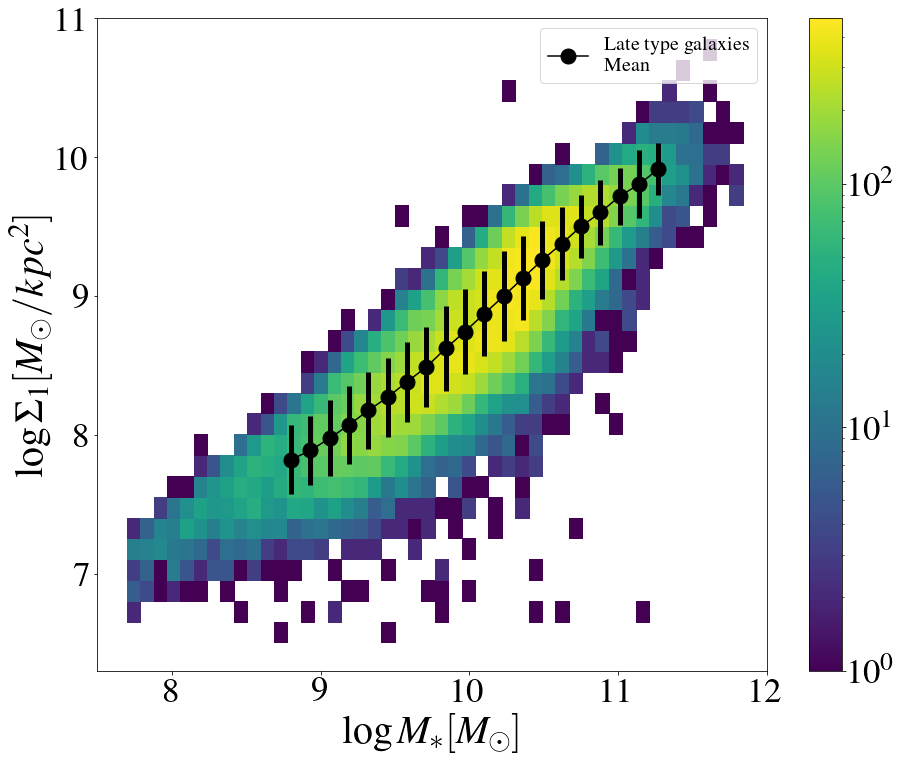

In [192]:
fig, ax= plt.subplots(figsize=(15,12))

# Sigma1 VS Ms_d late Diamond
plt.hist2d(np.log10(Ms_d_late), np.log10(S1_d_late), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dS1late_mean_bins[:-1], stat_dS1_late_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(dS1late_mean_bins[:-1], stat_dS1_late_mean, yerr=stat_dS1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1} [M_{\odot}/ kpc^{2}]$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsdlateD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

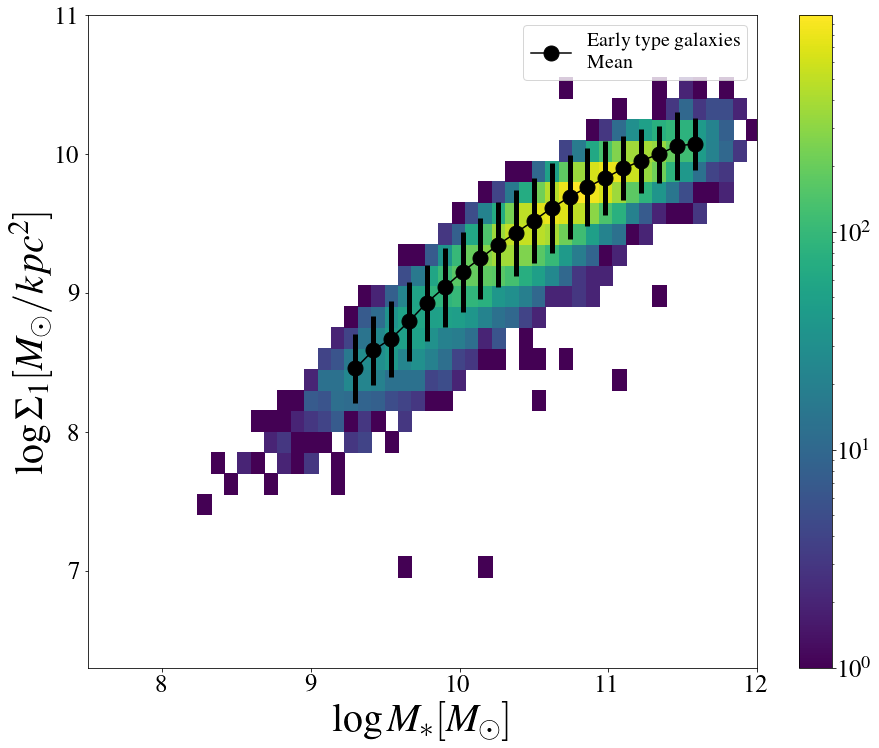

In [193]:
fig, ax= plt.subplots(figsize=(15,12))


# Sigma VS Ms_d early Diamond
plt.hist2d(np.log10(Ms_d_early), np.log10(S1_d_early), bins=(50,30), range=[[7.7,12.2],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dS1early_mean_bins[:-1], stat_dS1_early_mean, zorder=2, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dS1early_mean_bins[:-1], stat_dS1_early_mean, yerr=stat_dS1_late_std, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$\log \Sigma_{1} [M_{\odot}/ kpc^{2}]$', fontsize=40)

#set axis limits
plt.ylim(6.3, 11)
plt.xlim(7.5,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sgm1_MsdearlyD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

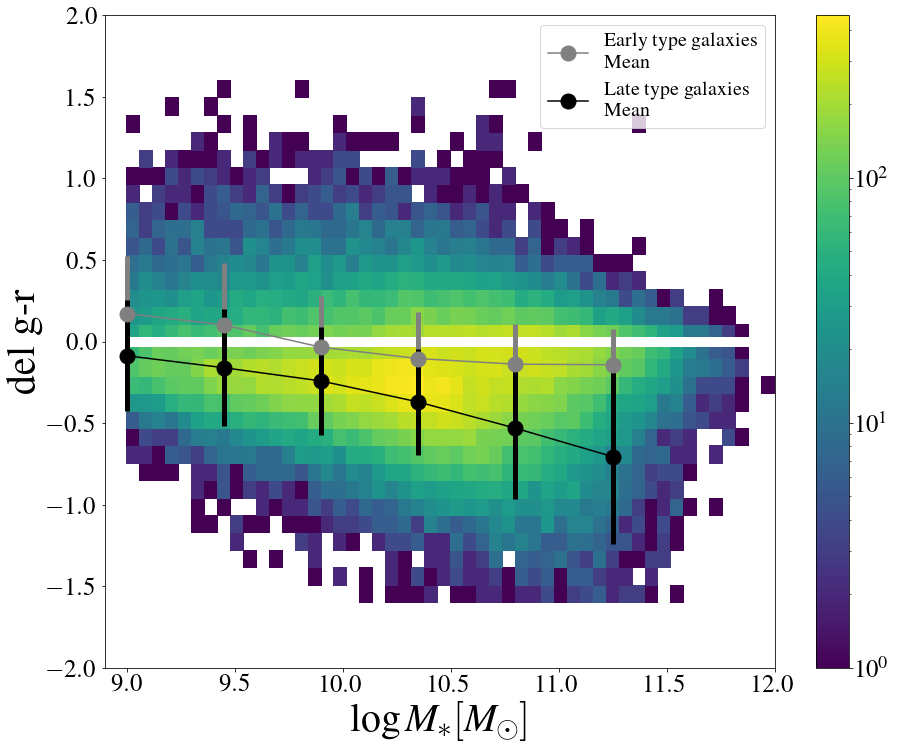

In [195]:
fig, ax= plt.subplots(figsize=(15,12))


# gradient g-r VS Ms_d early/late Diamond
plt.hist2d(np.log10(Ms_d), gradiente_gr, bins=(50,30), range=[[9,12], [-1.6,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dearlyS_grad_means_bins[:-1], stat_d_earlyS_grad_mean, zorder=3,  color ='gray', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean')
plt.errorbar(dearlyS_grad_means_bins[:-1], stat_d_earlyS_grad_mean, yerr=stat_d_std_earlyS_grad, xerr=None, zorder=3, ls='None', ecolor='gray', elinewidth=5)
# plt.hist2d(np.log10(Ms_d_late), gradgr_late, bins=(50,30), range=[[9,12], [-1.25,1.25]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(dlateS_grad_means_bins[:-1], stat_d_lateS_grad_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean')
plt.errorbar(dlateS_grad_means_bins[:-1], stat_d_lateS_grad_mean, yerr=stat_d_std_lateS_grad, xerr=None, zorder=3,  ls='None', ecolor='black', elinewidth=5)
x = [8.9,12]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)
plt.colorbar() 

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=40)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=40)

#set axis limits
plt.ylim(-2, 2)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_Msd.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

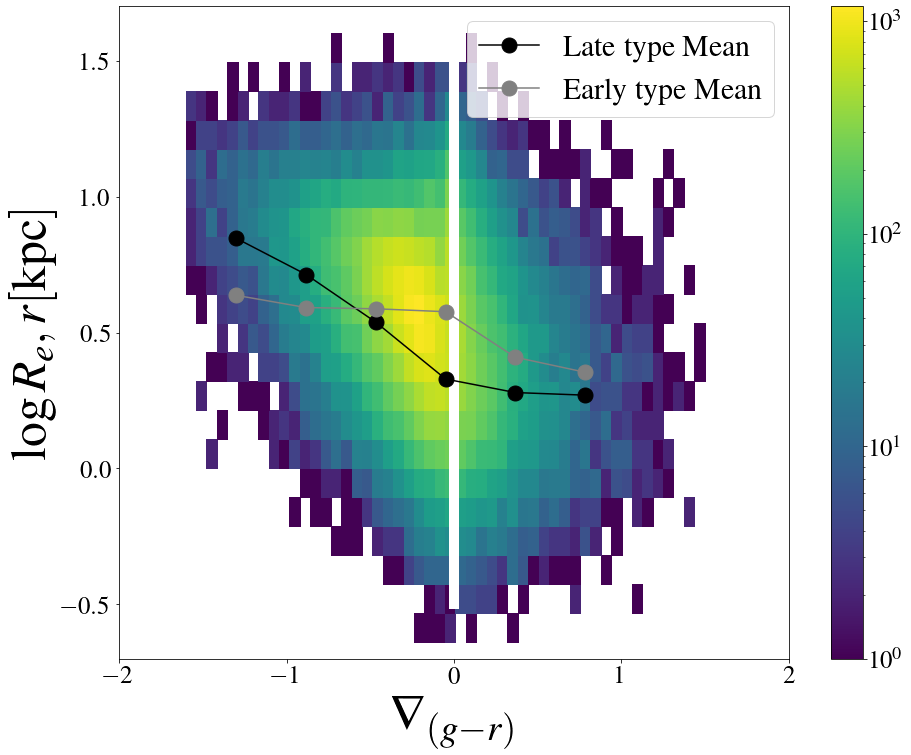

In [197]:

fig, ax= plt.subplots(figsize=(15,12))

# gradient vs Re_r
plt.hist2d( gradiente_gr, np.log10(Re_r_d), bins=(50,30), range=[[-1.6,1.5], [-1.6, 1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_rer_late_means_bins[:-1], stat_grad_rer_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(grad_rer_late_means_bins[:-1], stat_grad_rer_late_mean, yerr=stat_grad_rer_late_std/np.sqrt(stat_grad_rer_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(grad_rer_early_means_bins[:-1], stat_grad_rer_early_mean, zorder=3,  color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(grad_rer_early_means_bins[:-1], stat_grad_rer_early_mean, yerr=stat_grad_rer_early_std/np.sqrt(stat_grad_rer_early_count+1), zorder=3, xerr=None, ls='None', ecolor='gray', elinewidth=5)
y = [-0.5,1.5]
x = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

plt.colorbar() 

# Add axis labels

plt.ylabel(r'$\log R_e,r [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-.7,1.7)
plt.xlim(-2, 2)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_rerD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


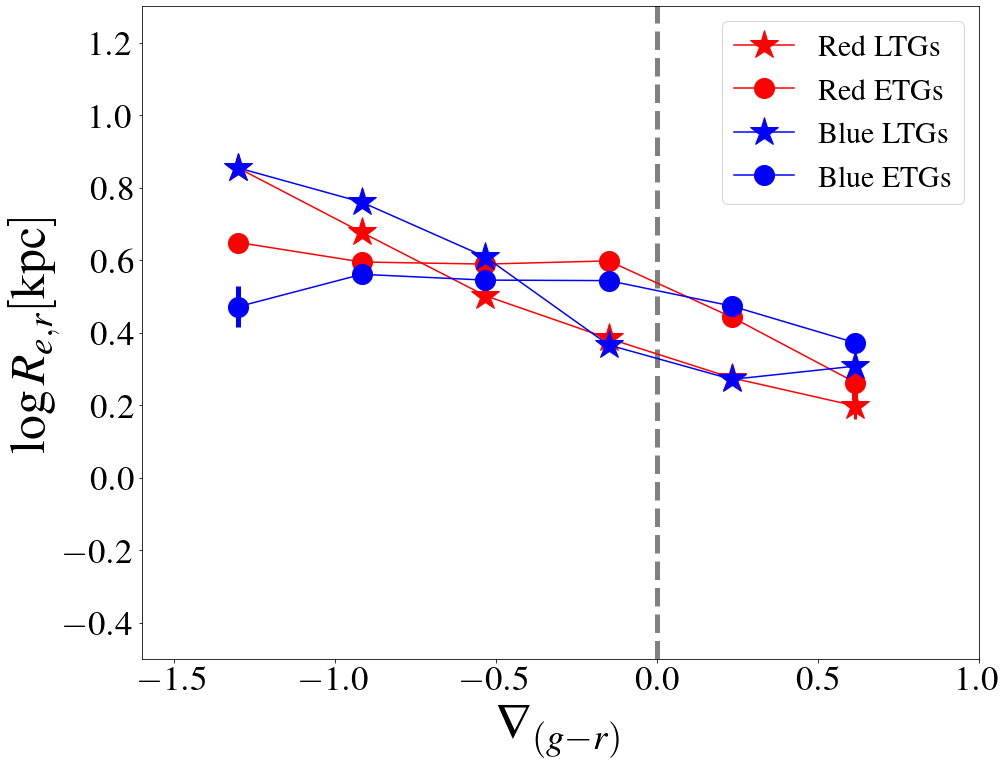

In [198]:

fig, ax= plt.subplots(figsize=(15,12))

# gradient vs Re_r mean early late red blue
plt.plot(grad_rerlog_late_red_means_bins[:-1], stat_grad_rerlog_late_red_mean, zorder=3,  color ='red', marker = '*', markersize= 30,  label=r'Red LTGs')
plt.errorbar(grad_rerlog_late_red_means_bins[:-1], stat_grad_rerlog_late_red_mean, yerr=stat_grad_rerlog_late_red_std/np.sqrt(stat_grad_rerlog_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_rerlog_early_red_means_bins[:-1], stat_grad_rerlog_early_red_mean, zorder=3,  color ='red', marker = 'o', markersize= 20,  label=r'Red ETGs ')
plt.errorbar(grad_rerlog_early_red_means_bins[:-1], stat_grad_rerlog_early_red_mean, yerr=stat_grad_rerlog_early_red_std/np.sqrt(stat_grad_rerlog_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)
plt.plot(grad_rerlog_late_blue_means_bins[:-1], stat_grad_rerlog_late_blue_mean, zorder=3,  color ='blue', marker = '*', markersize= 30,  label=r'Blue LTGs ')
plt.errorbar(grad_rerlog_late_blue_means_bins[:-1], stat_grad_rerlog_late_blue_mean, yerr=stat_grad_rerlog_late_blue_std/np.sqrt(stat_grad_rerlog_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_rerlog_early_blue_means_bins[:-1], stat_grad_rerlog_early_blue_mean, zorder=3,  color ='blue', marker = 'o', markersize= 20,  label=r'Blue ETGs ')
plt.errorbar(grad_rerlog_early_blue_means_bins[:-1], stat_grad_rerlog_early_blue_mean, yerr=stat_grad_rerlog_early_blue_std/np.sqrt(stat_grad_rerlog_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)



y = [-0.5,1.5]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)



# Add axis labels

plt.ylabel(r'$\log R_{e,r} [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$ ', fontsize=50)

#set axis limits
plt.ylim(-.5,1.3)
plt.xlim(-1.6, 1.0)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_rerDlog_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

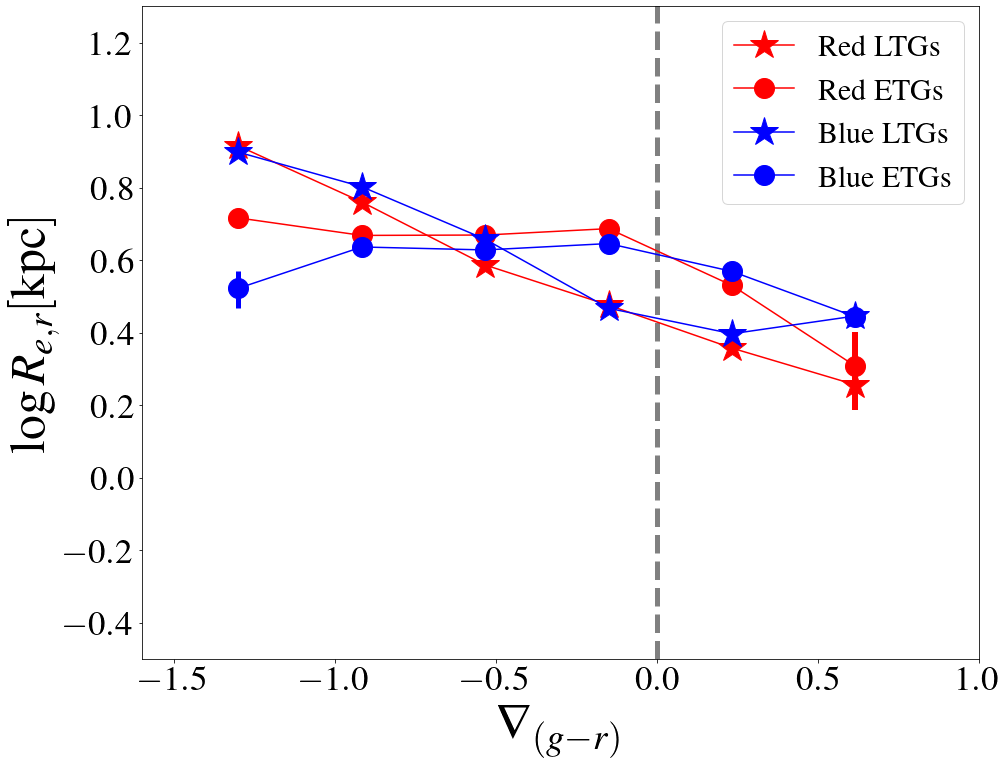

In [199]:

fig, ax= plt.subplots(figsize=(15,12))

### gradient g-r  Re_r mean  blue red early late 

rer_redlate_y_error_re_up =  np.log10(stat_grad_rer_late_red_mean+ stat_grad_rer_late_red_std/np.sqrt(stat_grad_rer_late_red_count+1))- np.log10(stat_grad_rer_late_red_mean)
rer_redlate_y_error_re_down = np.log10(stat_grad_rer_late_red_mean) - np.log10(stat_grad_rer_late_red_mean-stat_grad_rer_late_red_std/np.sqrt(stat_grad_rer_late_red_count+1))
rer_redlate_y_error = [rer_redlate_y_error_re_down, rer_redlate_y_error_re_up ]

rer_redearly_y_error_re_up =  np.log10(stat_grad_rer_early_red_mean+ stat_grad_rer_early_red_std/np.sqrt(stat_grad_rer_early_red_count+1))- np.log10(stat_grad_rer_early_red_mean)
rer_redearly_y_error_re_down = np.log10(stat_grad_rer_early_red_mean) - np.log10(stat_grad_rer_early_red_mean-stat_grad_rer_early_red_std/np.sqrt(stat_grad_rer_early_red_count+1))
rer_redearly_y_error = [rer_redearly_y_error_re_down, rer_redearly_y_error_re_up ]

rer_bluelate_y_error_re_up =  np.log10(stat_grad_rer_late_blue_mean+ stat_grad_rer_late_blue_std/np.sqrt(stat_grad_rer_late_blue_count+1))- np.log10(stat_grad_rer_late_blue_mean)
rer_bluelate_y_error_re_down = np.log10(stat_grad_rer_late_blue_mean) - np.log10(stat_grad_rer_late_blue_mean-stat_grad_rer_late_blue_std/np.sqrt(stat_grad_rer_late_blue_count+1))
rer_bluelate_y_error = [rer_bluelate_y_error_re_down, rer_bluelate_y_error_re_up ]

rer_blueearly_y_error_re_up =  np.log10(stat_grad_rer_early_blue_mean+ stat_grad_rer_early_blue_std/np.sqrt(stat_grad_rer_early_blue_count+1))- np.log10(stat_grad_rer_early_blue_mean)
rer_blueearly_y_error_re_down = np.log10(stat_grad_rer_early_blue_mean) - np.log10(stat_grad_rer_early_blue_mean-stat_grad_rer_early_blue_std/np.sqrt(stat_grad_rer_early_blue_count+1))
rer_blueearly_y_error = [rer_blueearly_y_error_re_down, rer_blueearly_y_error_re_up ]

# gradient vs Re_r mean
plt.plot(grad_rer_late_red_means_bins[:-1], np.log10(stat_grad_rer_late_red_mean), zorder=3,  color ='red', marker = '*', markersize= 30,  label=r'Red LTGs')
plt.errorbar(grad_rer_late_red_means_bins[:-1], np.log10(stat_grad_rer_late_red_mean), np.array(rer_redlate_y_error), fmt='r^', 
              xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_rer_early_red_means_bins[:-1], np.log10(stat_grad_rer_early_red_mean), zorder=3,  color ='red', marker = 'o', markersize= 20,  label=r'Red ETGs ')
plt.errorbar(grad_rer_early_red_means_bins[:-1], np.log10(stat_grad_rer_early_red_mean), np.array(rer_redearly_y_error), fmt='r^', 
               xerr=None, ls='None', ecolor='red', elinewidth=6)
plt.plot(grad_rer_late_blue_means_bins[:-1], np.log10(stat_grad_rer_late_blue_mean), zorder=3,  color ='blue', marker = '*', markersize= 30,  label=r'Blue LTGs ')
plt.errorbar(grad_rer_late_blue_means_bins[:-1], np.log10(stat_grad_rer_late_blue_mean), np.array(rer_bluelate_y_error), fmt='r^', 
              xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_rer_early_blue_means_bins[:-1], np.log10(stat_grad_rer_early_blue_mean), zorder=3,  color ='blue', marker = 'o', markersize= 20,  label=r'Blue ETGs ')
plt.errorbar(grad_rer_early_blue_means_bins[:-1], np.log10(stat_grad_rer_early_blue_mean),  np.array(rer_blueearly_y_error), fmt='r^',
              xerr=None, ls='None', ecolor='blue', elinewidth=5)



y = [-0.5,1.5]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)



# Add axis labels

plt.ylabel(r'$\log R_{e,r} [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$ ', fontsize=50)

#set axis limits
plt.ylim(-.5,1.3)
plt.xlim(-1.6, 1.0)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_rerD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

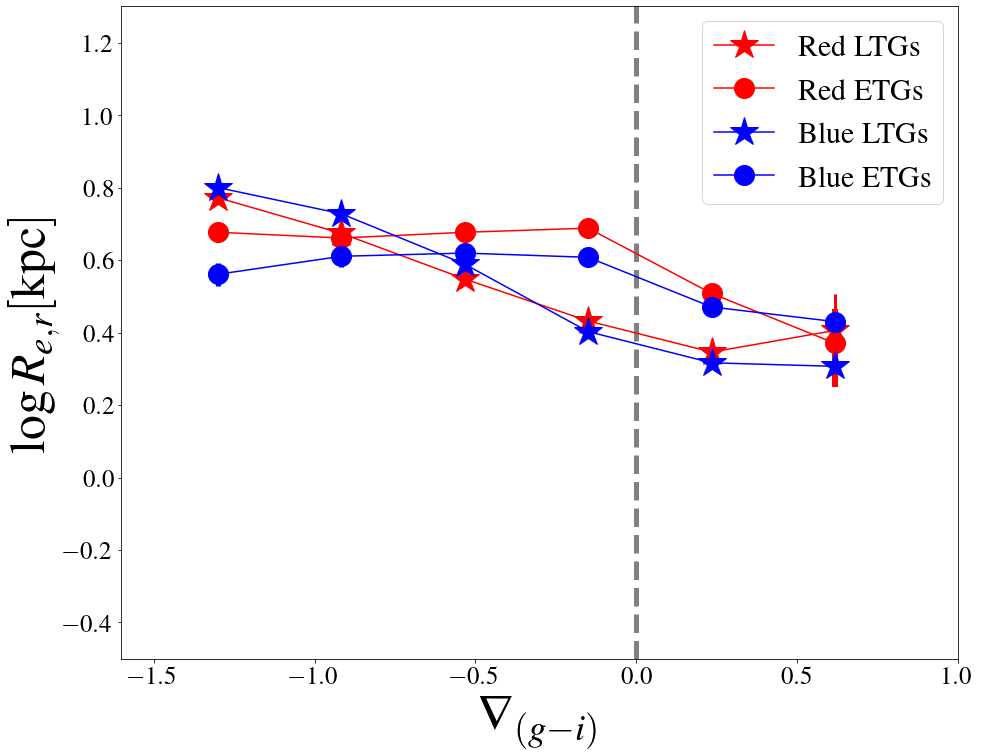

In [352]:

fig, ax= plt.subplots(figsize=(15,12))

### gradient g-i  Re_r mean  blue red early late no log calculated in mean

rer_redlate_gi_y_error_re_up =  np.log10(stat_grad_gi_rer_late_red_mean+ stat_grad_gi_rer_late_red_std/np.sqrt(stat_grad_gi_rer_late_red_count+1))- np.log10(stat_grad_gi_rer_late_red_mean)
rer_redlate_gi_y_error_re_down = np.log10(stat_grad_gi_rer_late_red_mean) - np.log10(stat_grad_gi_rer_late_red_mean-stat_grad_gi_rer_late_red_std/np.sqrt(stat_grad_gi_rer_late_red_count+1))
rer_redlate_gi_y_error = [rer_redlate_gi_y_error_re_down, rer_redlate_gi_y_error_re_up ]

rer_redearly_gi_y_error_re_up =  np.log10(stat_grad_gi_rer_early_red_mean+ stat_grad_gi_rer_early_red_std/np.sqrt(stat_grad_gi_rer_early_red_count+1))- np.log10(stat_grad_gi_rer_early_red_mean)
rer_redearly_gi_y_error_re_down = np.log10(stat_grad_gi_rer_early_red_mean) - np.log10(stat_grad_gi_rer_early_red_mean-stat_grad_gi_rer_early_red_std/np.sqrt(stat_grad_gi_rer_early_red_count+1))
rer_redearly_gi_y_error = [rer_redearly_y_error_re_down, rer_redearly_y_error_re_up ]

rer_bluelate_gi_y_error_re_up =  np.log10(stat_grad_gi_rer_late_blue_mean+ stat_grad_gi_rer_late_blue_std/np.sqrt(stat_grad_gi_rer_late_blue_count+1))- np.log10(stat_grad_gi_rer_late_blue_mean)
rer_bluelate_gi_y_error_re_down = np.log10(stat_grad_gi_rer_late_blue_mean) - np.log10(stat_grad_gi_rer_late_blue_mean-stat_grad_gi_rer_late_blue_std/np.sqrt(stat_grad_gi_rer_late_blue_count+1))
rer_bluelate_gi_y_error = [rer_bluelate_gi_y_error_re_down, rer_bluelate_gi_y_error_re_up ]

rer_blueearly_gi_y_error_re_up =  np.log10(stat_grad_gi_rer_early_blue_mean+ stat_grad_gi_rer_early_blue_std/np.sqrt(stat_grad_gi_rer_early_blue_count+1))- np.log10(stat_grad_gi_rer_early_blue_mean)
rer_blueearly_gi_y_error_re_down = np.log10(stat_grad_gi_rer_early_blue_mean) - np.log10(stat_grad_gi_rer_early_blue_mean-stat_grad_gi_rer_early_blue_std/np.sqrt(stat_grad_gi_rer_early_blue_count+1))
rer_blueearly_gi_y_error = [rer_blueearly_gi_y_error_re_down, rer_blueearly_gi_y_error_re_up ]

# gradient vs Re_r mean
plt.plot(grad_gi_rer_late_red_means_bins[:-1], np.log10(stat_grad_gi_rer_late_red_mean), zorder=3,  color ='red', marker = '*', markersize= 30,  label=r'Red LTGs')
plt.errorbar(grad_gi_rer_late_red_means_bins[:-1], np.log10(stat_grad_gi_rer_late_red_mean), np.array(rer_redlate_gi_y_error), fmt='r^', 
              xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_gi_rer_early_red_means_bins[:-1], np.log10(stat_grad_gi_rer_early_red_mean), zorder=3,  color ='red', marker = 'o', markersize= 20,  label=r'Red ETGs ')
plt.errorbar(grad_gi_rer_early_red_means_bins[:-1], np.log10(stat_grad_gi_rer_early_red_mean), np.array(rer_redearly_gi_y_error), fmt='r^', 
               xerr=None, ls='None', ecolor='red', elinewidth=6)
plt.plot(grad_gi_rer_late_blue_means_bins[:-1], np.log10(stat_grad_gi_rer_late_blue_mean), zorder=3,  color ='blue', marker = '*', markersize= 30,  label=r'Blue LTGs ')
plt.errorbar(grad_gi_rer_late_blue_means_bins[:-1], np.log10(stat_grad_gi_rer_late_blue_mean), np.array(rer_bluelate_gi_y_error), fmt='r^', 
              xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_gi_rer_early_blue_means_bins[:-1], np.log10(stat_grad_gi_rer_early_blue_mean), zorder=3,  color ='blue', marker = 'o', markersize= 20,  label=r'Blue ETGs ')
plt.errorbar(grad_gi_rer_early_blue_means_bins[:-1], np.log10(stat_grad_gi_rer_early_blue_mean),  np.array(rer_blueearly_gi_y_error), fmt='r^',
              xerr=None, ls='None', ecolor='blue', elinewidth=5)



y = [-0.5,1.5]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)



# Add axis labels

plt.ylabel(r'$\log R_{e,r} [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$ ', fontsize=50)

#set axis limits
plt.ylim(-.5,1.3)
plt.xlim(-1.6, 1.0)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_rerD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

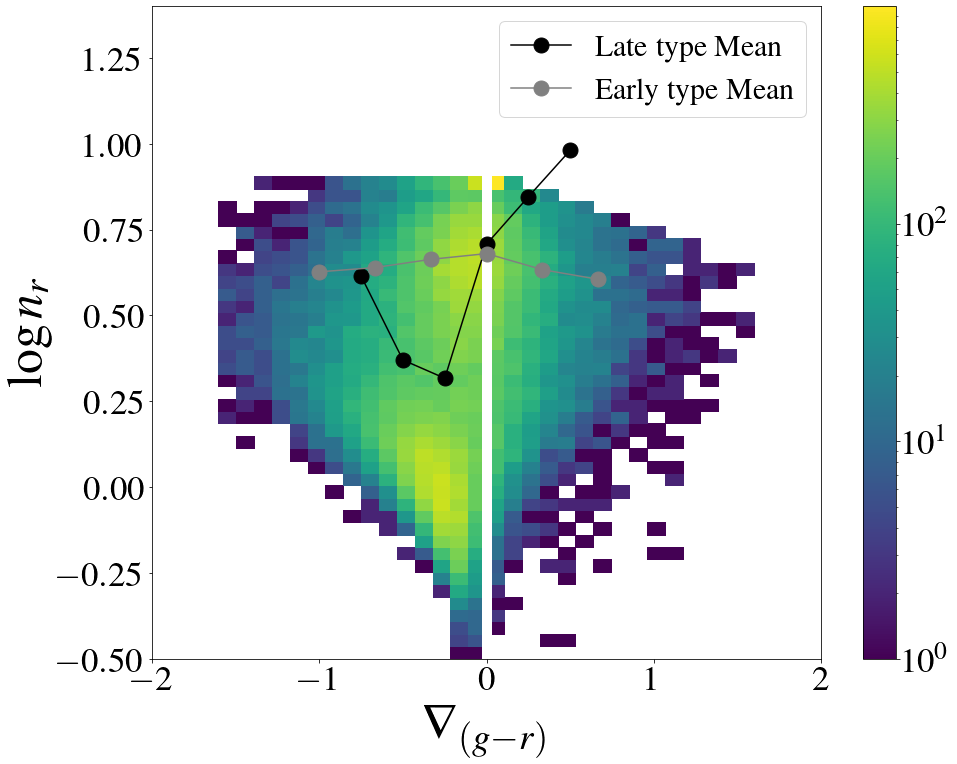

In [201]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr Diamond vs n_r
plt.hist2d(gradiente_gr, np.log10(n_r_d),  bins=(30,50), range=[[-1.6, 1.6], [-0.5,1.3]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_nr_late_means_bins[:-1], stat_grad_nr_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(grad_nr_late_means_bins[:-1], stat_grad_nr_late_mean, yerr=stat_grad_nr_late_std/np.sqrt(stat_grad_nr_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(grad_nr_early_means_bins[:-1], stat_grad_nr_early_mean, zorder=3,  color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(grad_nr_early_means_bins[:-1], stat_grad_nr_early_mean, yerr=stat_grad_nr_early_std/np.sqrt(stat_grad_nr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
x = [-0.5,1]
y = [0,0]
plt.plot(y, x, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log n_r $', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-0.5,1.4)
plt.xlim(-2, 2)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_nrD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

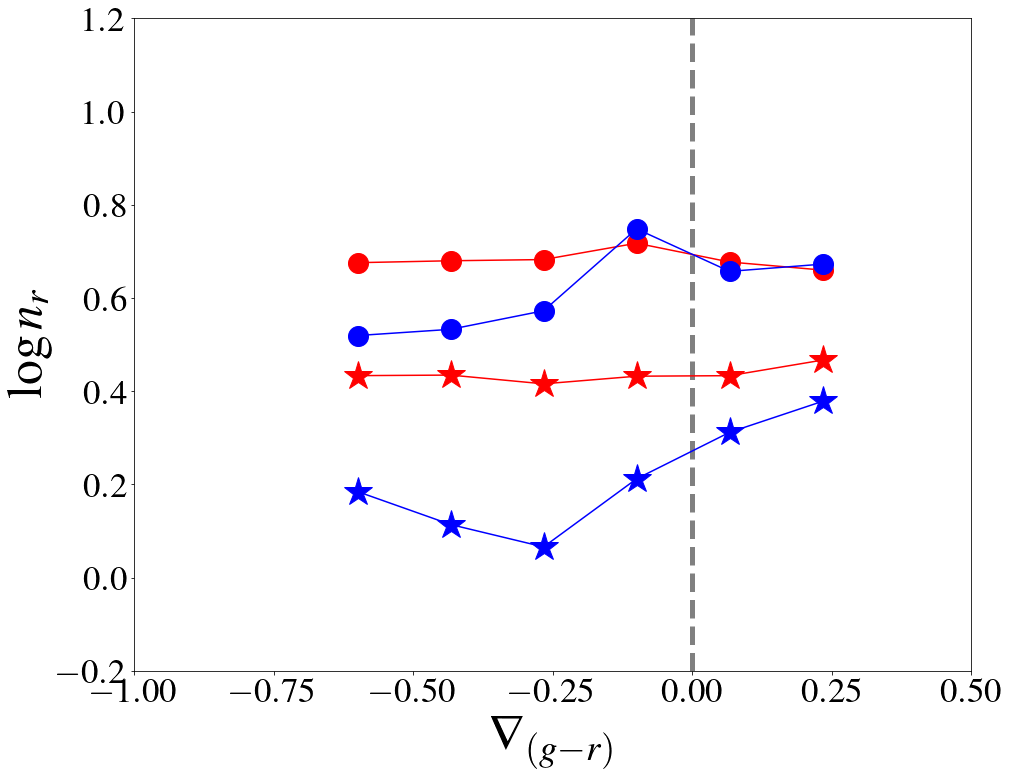

In [202]:
fig, ax= plt.subplots(figsize=(15,12))

### gradient  gr sersic index mean  blue red early late. no log calculated in mean

nr_redlate_y_error_up =  np.log10(stat_grad_nr_late_red_mean+ stat_grad_nr_late_red_std/np.sqrt(stat_grad_nr_late_red_count+1))- np.log10(stat_grad_nr_late_red_mean)
nr_redlate_y_error_down = np.log10(stat_grad_nr_late_red_mean) - np.log10(stat_grad_nr_late_red_mean-stat_grad_nr_late_red_std/np.sqrt(stat_grad_nr_late_red_count+1))
nr_redlate_y_error = [nr_redlate_y_error_down, nr_redlate_y_error_up ]

nr_redearly_y_error_up =  np.log10(stat_grad_nr_early_red_mean+ stat_grad_nr_early_red_std/np.sqrt(stat_grad_nr_early_red_count+1))- np.log10(stat_grad_nr_early_red_mean)
nr_redearly_y_error_down = np.log10(stat_grad_nr_early_red_mean) - np.log10(stat_grad_nr_early_red_mean-stat_grad_nr_early_red_std/np.sqrt(stat_grad_nr_early_red_count+1))
nr_redearly_y_error = [nr_redearly_y_error_down, nr_redearly_y_error_up ]

nr_bluelate_y_error_up =  np.log10(stat_grad_nr_late_blue_mean+ stat_grad_nr_late_blue_std/np.sqrt(stat_grad_nr_late_blue_count+1))- np.log10(stat_grad_nr_late_blue_mean)
nr_bluelate_y_error_down = np.log10(stat_grad_nr_late_blue_mean) - np.log10(stat_grad_nr_late_blue_mean-stat_grad_nr_late_blue_std/np.sqrt(stat_grad_nr_late_blue_count+1))
nr_bluelate_y_error = [nr_bluelate_y_error_down, nr_bluelate_y_error_up ]

nr_blueearly_y_error_up =  np.log10(stat_grad_nr_early_blue_mean+ stat_grad_nr_early_blue_std/np.sqrt(stat_grad_nr_early_blue_count+1))- np.log10(stat_grad_nr_early_blue_mean)
nr_blueearly_y_error_down = np.log10(stat_grad_nr_early_blue_mean) - np.log10(stat_grad_nr_early_blue_mean-stat_grad_nr_early_blue_std/np.sqrt(stat_grad_nr_early_blue_count+1))
nr_blueearly_y_error = [nr_blueearly_y_error_down, nr_blueearly_y_error_up ]

# gradient gr Diamond vs n_r mean 
plt.plot(grad_nr_late_red_means_bins[:-1], np.log10(stat_grad_nr_late_red_mean), zorder=3,  color ='red', marker = '*', markersize= 30,  label=r'Red LTGs ')
plt.errorbar(grad_nr_late_red_means_bins[:-1], np.log10(stat_grad_nr_late_red_mean), np.array(nr_redlate_y_error), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)

plt.plot(grad_nr_early_red_means_bins[:-1], np.log10(stat_grad_nr_early_red_mean), zorder=3,  color ='red', marker = 'o', markersize= 20,  label=r'Red ETGs ')
plt.errorbar(grad_nr_early_red_means_bins[:-1], np.log10(stat_grad_nr_early_red_mean), np.array(nr_redearly_y_error), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)

plt.plot(grad_nr_late_blue_means_bins[:-1], np.log10(stat_grad_nr_late_blue_mean), zorder=3,  color ='blue', marker = '*', markersize= 30,  label=r'Blue LTGs ')
plt.errorbar(grad_nr_late_blue_means_bins[:-1], np.log10(stat_grad_nr_late_blue_mean), np.array(nr_bluelate_y_error), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)

plt.plot(grad_nr_early_blue_means_bins[:-1], np.log10(stat_grad_nr_early_blue_mean), zorder=3,  color ='blue', marker = 'o', markersize= 20,  label=r'Blue ETGs ')
plt.errorbar(grad_nr_early_blue_means_bins[:-1], np.log10(stat_grad_nr_early_blue_mean), np.array(nr_blueearly_y_error), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.5,1.2]
y = [0,0]
plt.plot(y, x, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log n_r $', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-0.2,1.2)
plt.xlim(-1, .5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_nrD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

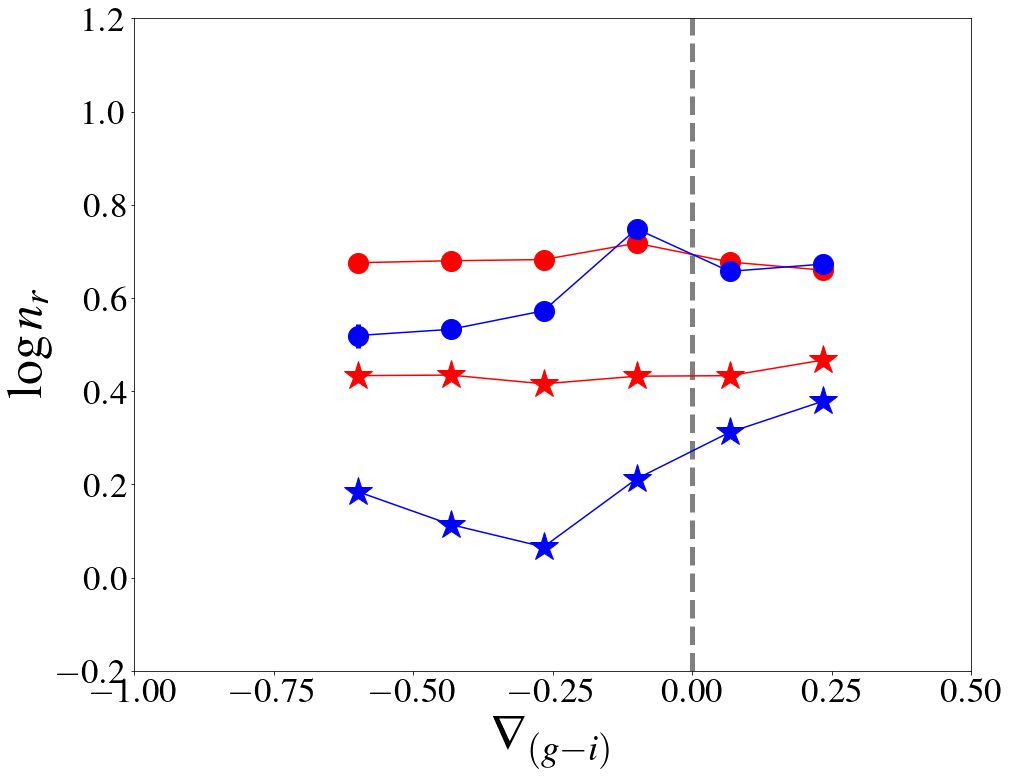

In [354]:
fig, ax= plt.subplots(figsize=(15,12))


### gradient gi  sersic index mean  blue red early late no log calculated in mean

nr_redlate_gi_y_error_up =  np.log10(stat_grad_gi_nr_late_red_mean+ stat_grad_gi_nr_late_red_std/np.sqrt(stat_grad_gi_nr_late_red_count+1))- np.log10(stat_grad_gi_nr_late_red_mean)
nr_redlate_gi_y_error_down = np.log10(stat_grad_gi_nr_late_red_mean) - np.log10(stat_grad_gi_nr_late_red_mean-stat_grad_gi_nr_late_red_std/np.sqrt(stat_grad_gi_nr_late_red_count+1))
nr_redlate_gi_y_error = [nr_redlate_gi_y_error_down, nr_redlate_gi_y_error_up ]

nr_redearly_gi_y_error_up =  np.log10(stat_grad_gi_nr_early_red_mean+ stat_grad_gi_nr_early_red_std/np.sqrt(stat_grad_gi_nr_early_red_count+1))- np.log10(stat_grad_gi_nr_early_red_mean)
nr_redearly_gi_y_error_down = np.log10(stat_grad_gi_nr_early_red_mean) - np.log10(stat_grad_gi_nr_early_red_mean-stat_grad_gi_nr_early_red_std/np.sqrt(stat_grad_gi_nr_early_red_count+1))
nr_redearly_gi_y_error = [nr_redearly_gi_y_error_down, nr_redearly_gi_y_error_up ]

nr_bluelate_gi_y_error_up =  np.log10(stat_grad_gi_nr_late_blue_mean+ stat_grad_gi_nr_late_blue_std/np.sqrt(stat_grad_gi_nr_late_blue_count+1))- np.log10(stat_grad_gi_nr_late_blue_mean)
nr_bluelate_gi_y_error_down = np.log10(stat_grad_gi_nr_late_blue_mean) - np.log10(stat_grad_gi_nr_late_blue_mean-stat_grad_gi_nr_late_blue_std/np.sqrt(stat_grad_gi_nr_late_blue_count+1))
nr_bluelate_gi_y_error = [nr_bluelate_gi_y_error_down, nr_bluelate_gi_y_error_up ]

nr_blueearly_gi_y_error_up =  np.log10(stat_grad_gi_nr_early_blue_mean+ stat_grad_gi_nr_early_blue_std/np.sqrt(stat_grad_gi_nr_early_blue_count+1))- np.log10(stat_grad_gi_nr_early_blue_mean)
nr_blueearly_gi_y_error_down = np.log10(stat_grad_gi_nr_early_blue_mean) - np.log10(stat_grad_gi_nr_early_blue_mean-stat_grad_gi_nr_early_blue_std/np.sqrt(stat_grad_gi_nr_early_blue_count+1))
nr_blueearly_gi_y_error = [nr_blueearly_gi_y_error_down, nr_blueearly_gi_y_error_up ]

# gradient gr Diamond vs n_r mean 
plt.plot(grad_nr_late_red_means_bins[:-1], np.log10(stat_grad_nr_late_red_mean), zorder=3,  color ='red', marker = '*', markersize= 30,  label=r'Red LTGs ')
plt.errorbar(grad_nr_late_red_means_bins[:-1], np.log10(stat_grad_nr_late_red_mean), np.array(nr_redlate_gi_y_error), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)

plt.plot(grad_nr_early_red_means_bins[:-1], np.log10(stat_grad_nr_early_red_mean), zorder=3,  color ='red', marker = 'o', markersize= 20,  label=r'Red ETGs ')
plt.errorbar(grad_nr_early_red_means_bins[:-1], np.log10(stat_grad_nr_early_red_mean), np.array(nr_redearly_gi_y_error), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)

plt.plot(grad_nr_late_blue_means_bins[:-1], np.log10(stat_grad_nr_late_blue_mean), zorder=3,  color ='blue', marker = '*', markersize= 30,  label=r'Blue LTGs ')
plt.errorbar(grad_nr_late_blue_means_bins[:-1], np.log10(stat_grad_nr_late_blue_mean), np.array(nr_bluelate_gi_y_error), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)

plt.plot(grad_nr_early_blue_means_bins[:-1], np.log10(stat_grad_nr_early_blue_mean), zorder=3,  color ='blue', marker = 'o', markersize= 20,  label=r'Blue ETGs ')
plt.errorbar(grad_nr_early_blue_means_bins[:-1], np.log10(stat_grad_nr_early_blue_mean), np.array(nr_blueearly_gi_y_error), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.5,1.2]
y = [0,0]
plt.plot(y, x, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log n_r $', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-0.2,1.2)
plt.xlim(-1, .5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_nrD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

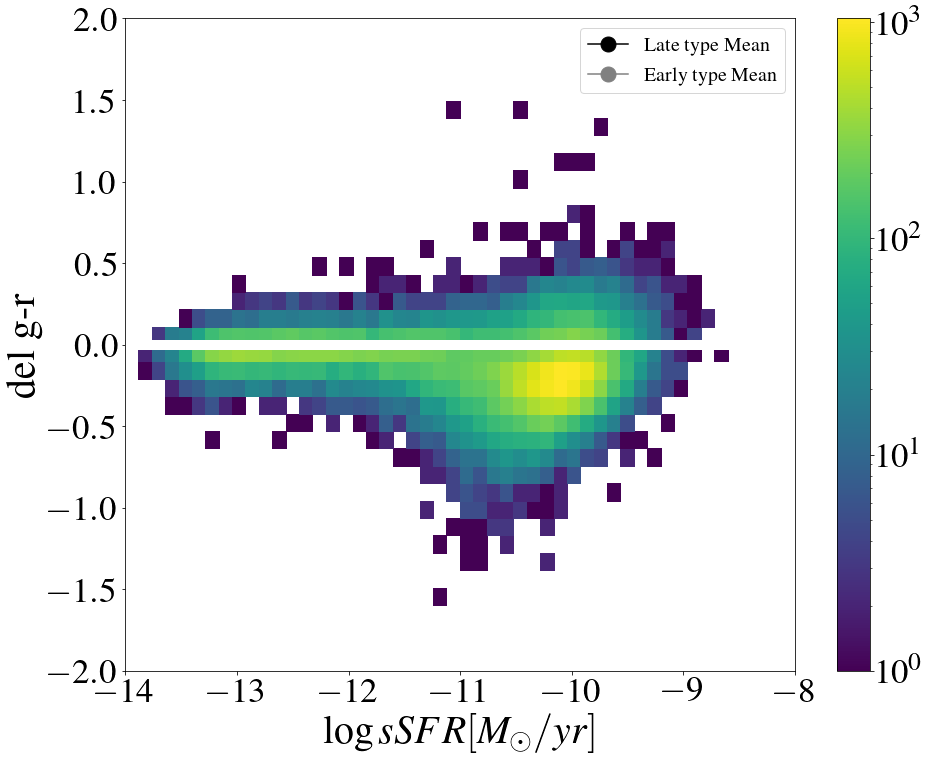

In [204]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr Diamond vs sSFR early late
plt.hist2d(log_sSFR, gradiente_gr_sfr, bins=(50,30), range=[[-14,-8], [-1.6, 1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_sfr_late_means_bins[:-1], stat_grad_sfr_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(grad_sfr_late_means_bins[:-1], stat_grad_sfr_late_mean, yerr=stat_grad_sfr_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(grad_sfr_early_means_bins[:-1], stat_grad_sfr_early_mean, zorder=3,  color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(grad_sfr_early_means_bins[:-1], stat_grad_sfr_early_mean, yerr=stat_grad_sfr_early_std, zorder=3, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log sSFR [M_{\odot}/yr]$', fontsize=40)
plt.ylabel(r'$\nabla_{(g-r)}', fontsize=40)

#set axis limits
plt.xlim(-14,-8)
plt.ylim(-2, 2)


#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_sfrD.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

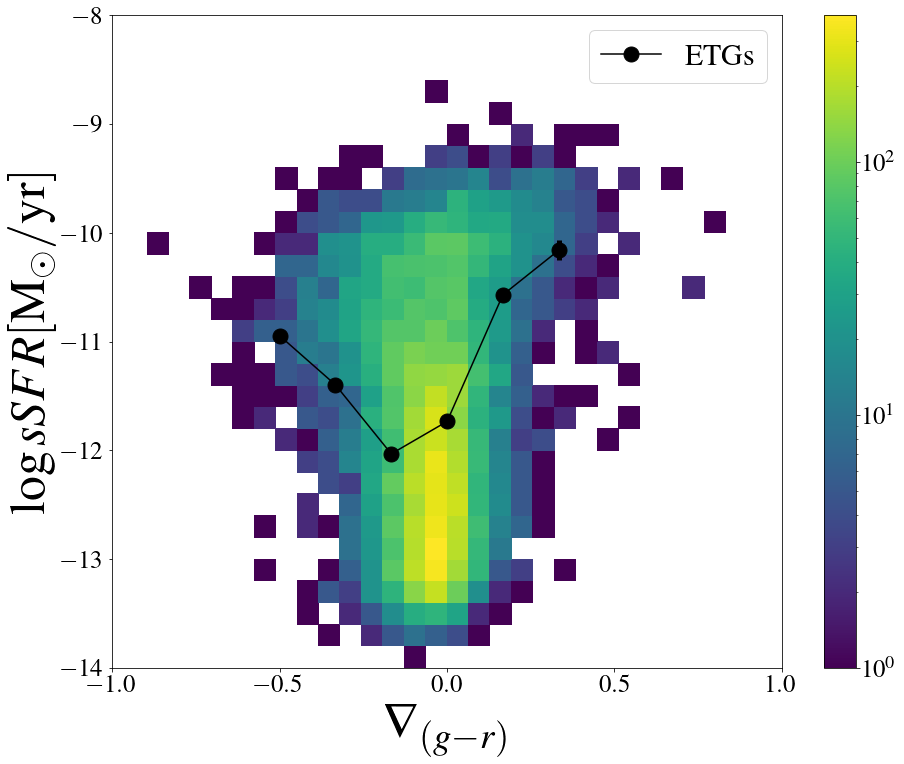

In [205]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr early Diamond vs sSFR
plt.hist2d(gradgr_early_sfr, log_sSFR_early,  bins=(50,30), range=[[-1.6, 1.6],[-14,-8]], zorder=1, norm=LogNorm(), cmap='viridis')


plt.plot(grad_sfr_early_means_bins[:-1], stat_grad_sfr_early_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='ETGs')
plt.errorbar(grad_sfr_early_means_bins[:-1], stat_grad_sfr_early_mean, yerr=stat_grad_sfr_early_std/np.sqrt(stat_grad_sfr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}/yr]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-8)
plt.xlim(-1, 1)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_sfrD_early.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

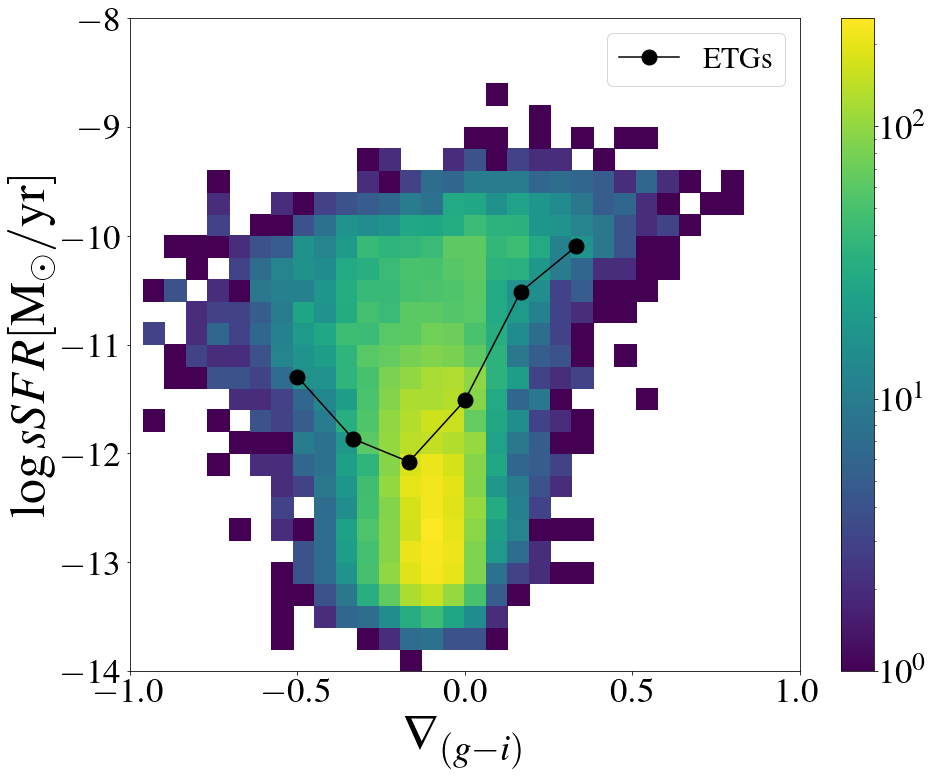

In [357]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gi early Diamond vs sSFR
plt.hist2d(gradgi_early_sfr, log_sSFR_early_gi,  bins=(50,30), range=[[-1.6, 1.6],[-14,-8]], zorder=1, norm=LogNorm(), cmap='viridis')


plt.plot(grad_gi_sfr_early_means_bins[:-1], stat_grad_gi_sfr_early_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='ETGs')
plt.errorbar(grad_gi_sfr_early_means_bins[:-1], stat_grad_gi_sfr_early_mean, yerr=stat_grad_gi_sfr_early_std/np.sqrt(stat_grad_gi_sfr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}/yr]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-8)
plt.xlim(-1, 1)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_sfrD_early.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

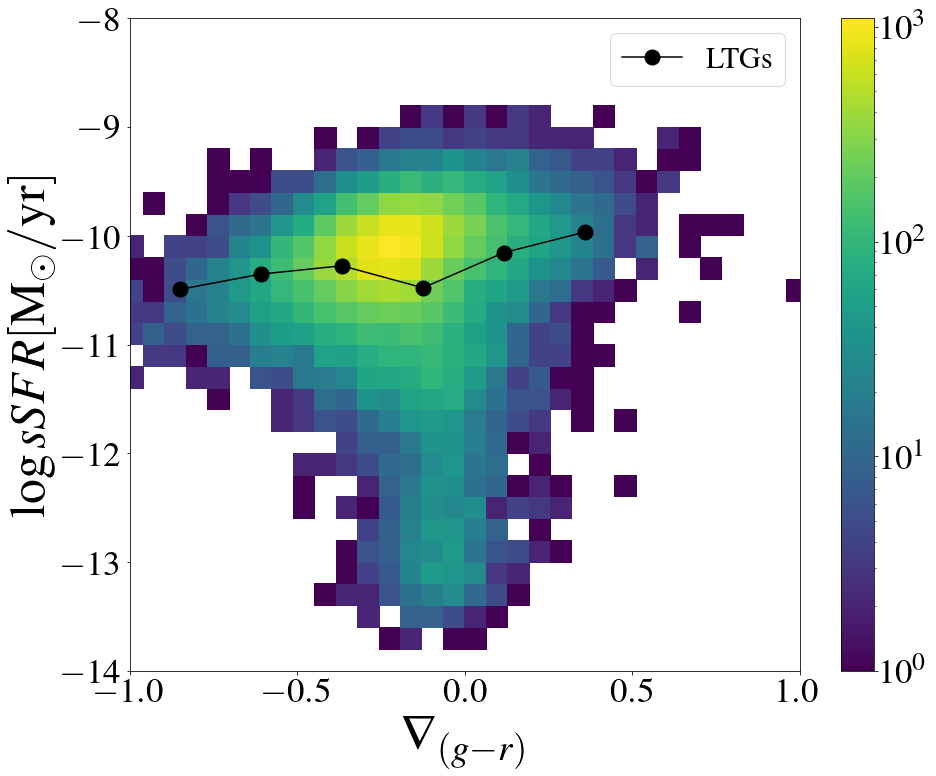

In [206]:

fig, ax= plt.subplots(figsize=(15,12))

# gradient gr late Diamond vs sSFR
plt.hist2d(gradgr_late_sfr, log_sSFR_late,  bins=(50,30), range=[[-1.6, 1.6],[-14,-8]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_sfr_late_means_bins[:-1], stat_grad_sfr_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='LTGs')
plt.errorbar(grad_sfr_late_means_bins[:-1], stat_grad_sfr_late_mean, yerr=stat_grad_sfr_late_std/np.sqrt(stat_grad_sfr_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}/yr]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-8)
plt.xlim(-1, 1)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_sfrD_late.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

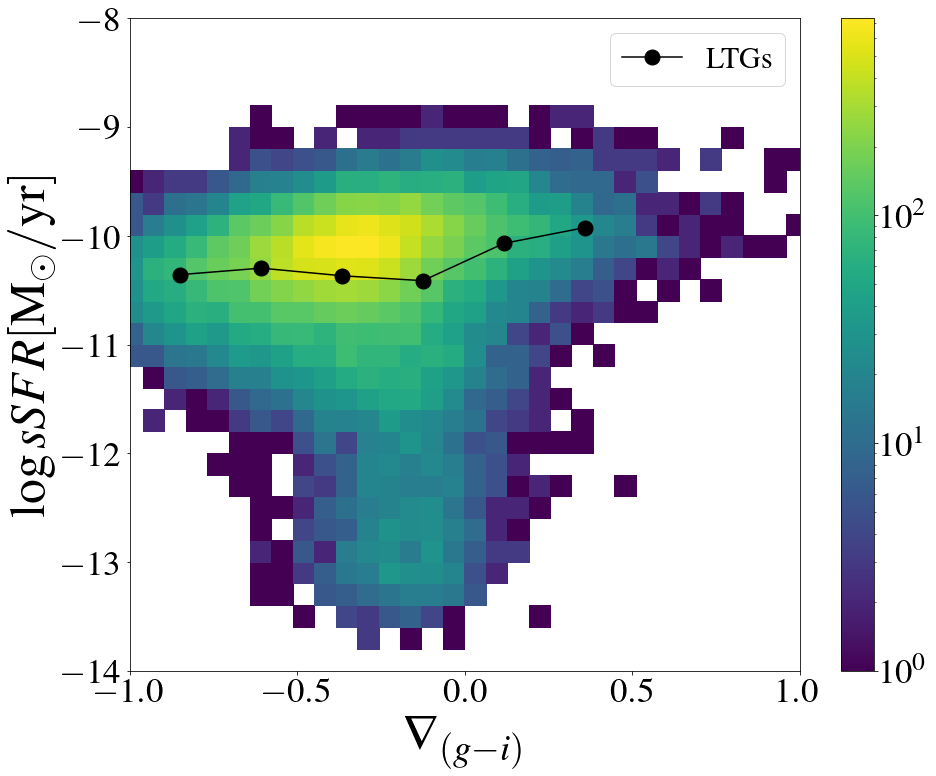

In [358]:

fig, ax= plt.subplots(figsize=(15,12))

# gradient gi late Diamond vs sSFR
plt.hist2d(gradgi_late_sfr, log_sSFR_late_gi,  bins=(50,30), range=[[-1.6, 1.6],[-14,-8]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_gi_sfr_late_means_bins[:-1], stat_grad_gi_sfr_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='LTGs')
plt.errorbar(grad_gi_sfr_late_means_bins[:-1], stat_grad_gi_sfr_late_mean, yerr=stat_grad_gi_sfr_late_std/np.sqrt(stat_grad_gi_sfr_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)

plt.colorbar() 
x = [-14,-8]
y = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}/yr]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-8)
plt.xlim(-1, 1)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_sfrD_late.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

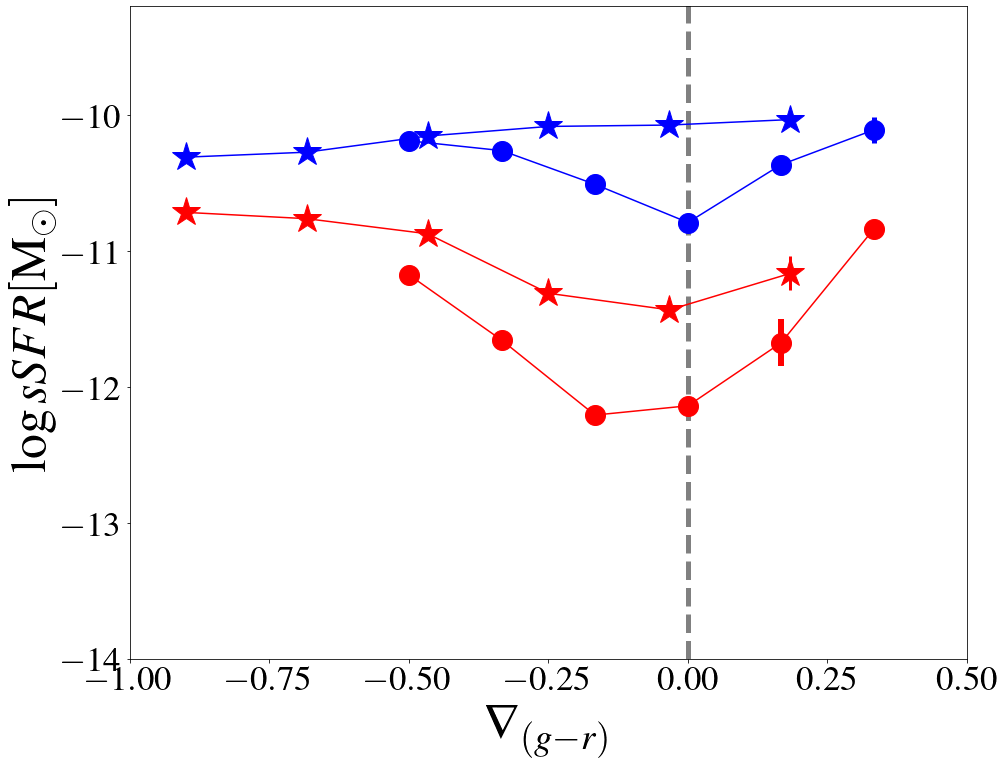

In [207]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr Diamond vs sSFR mean  blue red early late



plt.plot(grad_sfr_late_red_means_bins[:-1], stat_grad_sfr_late_red_mean, zorder=3,  color ='red', marker = '*', markersize= 30,  label='Red late-type ')
plt.errorbar(grad_sfr_late_red_means_bins[:-1], stat_grad_sfr_late_red_mean, yerr = stat_grad_sfr_late_red_std/np.sqrt(stat_grad_sfr_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_sfr_early_red_means_bins[:-1], stat_grad_sfr_early_red_mean, zorder=3,  color ='red', marker = 'o', markersize= 20,  label='Red early-type ')
plt.errorbar(grad_sfr_early_red_means_bins[:-1], stat_grad_sfr_early_red_mean, yerr = stat_grad_sfr_early_red_std/np.sqrt(stat_grad_sfr_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)
plt.plot(grad_sfr_late_blue_means_bins[:-1], stat_grad_sfr_late_blue_mean, zorder=3,  color ='blue', marker = '*', markersize= 30,  label='Blue late-type ')
plt.errorbar(grad_sfr_late_blue_means_bins[:-1], stat_grad_sfr_late_blue_mean, yerr = stat_grad_sfr_late_blue_std/np.sqrt(stat_grad_sfr_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_sfr_early_blue_means_bins[:-1], stat_grad_sfr_early_blue_mean, zorder=3,  color ='blue', marker = 'o', markersize= 20,  label='Blue early-type ')
plt.errorbar(grad_sfr_early_blue_means_bins[:-1], stat_grad_sfr_early_blue_mean, yerr = stat_grad_sfr_early_blue_std/np.sqrt(stat_grad_sfr_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

y = [-15,-8]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-9.2)
plt.xlim(-1, .5)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_sfrD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

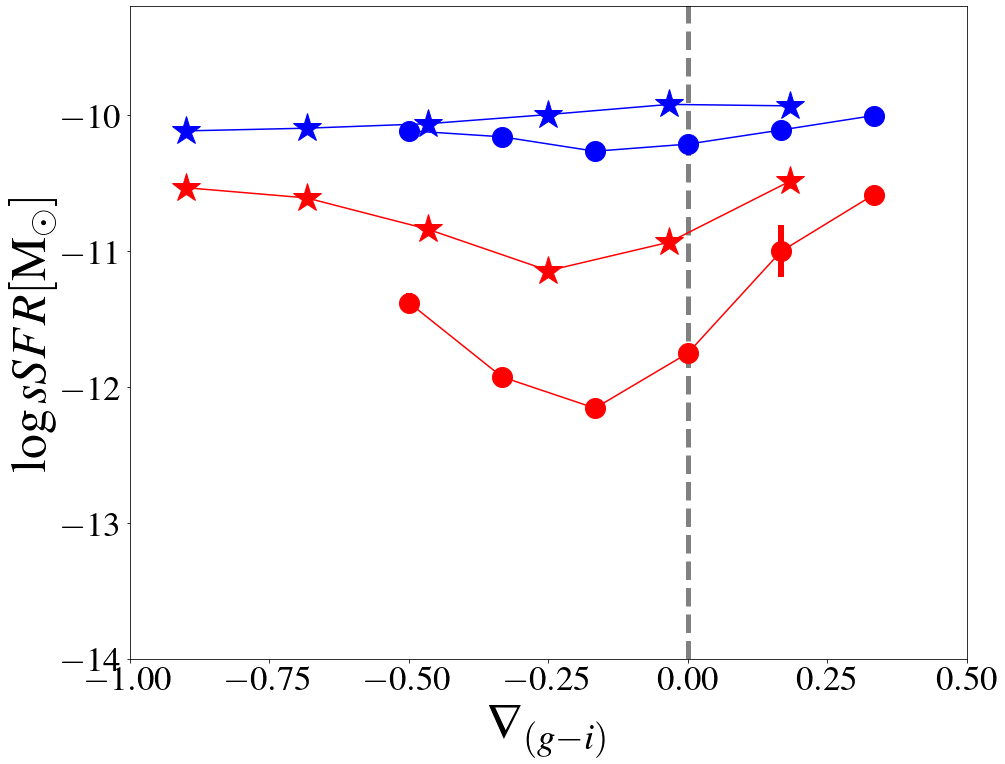

In [359]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gi Diamond vs sSFR mean blue red early late



plt.plot(grad_gi_sfr_late_red_means_bins[:-1], stat_grad_gi_sfr_late_red_mean, zorder=3,  color ='red', marker = '*', markersize= 30,  label='Red late-type ')
plt.errorbar(grad_gi_sfr_late_red_means_bins[:-1], stat_grad_gi_sfr_late_red_mean, yerr = stat_grad_gi_sfr_late_red_std/np.sqrt(stat_grad_gi_sfr_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_gi_sfr_early_red_means_bins[:-1], stat_grad_gi_sfr_early_red_mean, zorder=3,  color ='red', marker = 'o', markersize= 20,  label='Red early-type ')
plt.errorbar(grad_gi_sfr_early_red_means_bins[:-1], stat_grad_gi_sfr_early_red_mean, yerr = stat_grad_gi_sfr_early_red_std/np.sqrt(stat_grad_gi_sfr_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)
plt.plot(grad_gi_sfr_late_blue_means_bins[:-1], stat_grad_gi_sfr_late_blue_mean, zorder=3,  color ='blue', marker = '*', markersize= 30,  label='Blue late-type ')
plt.errorbar(grad_gi_sfr_late_blue_means_bins[:-1], stat_grad_gi_sfr_late_blue_mean, yerr = stat_grad_gi_sfr_late_blue_std/np.sqrt(stat_grad_gi_sfr_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_gi_sfr_early_blue_means_bins[:-1], stat_grad_gi_sfr_early_blue_mean, zorder=3,  color ='blue', marker = 'o', markersize= 20,  label='Blue early-type ')
plt.errorbar(grad_gi_sfr_early_blue_means_bins[:-1], stat_grad_gi_sfr_early_blue_mean, yerr = stat_grad_gi_sfr_early_blue_std/np.sqrt(stat_grad_gi_sfr_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

y = [-15,-8]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log sSFR [\rm M_{\odot}]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-14,-9.2)
plt.xlim(-1, .5)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_sfrD_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

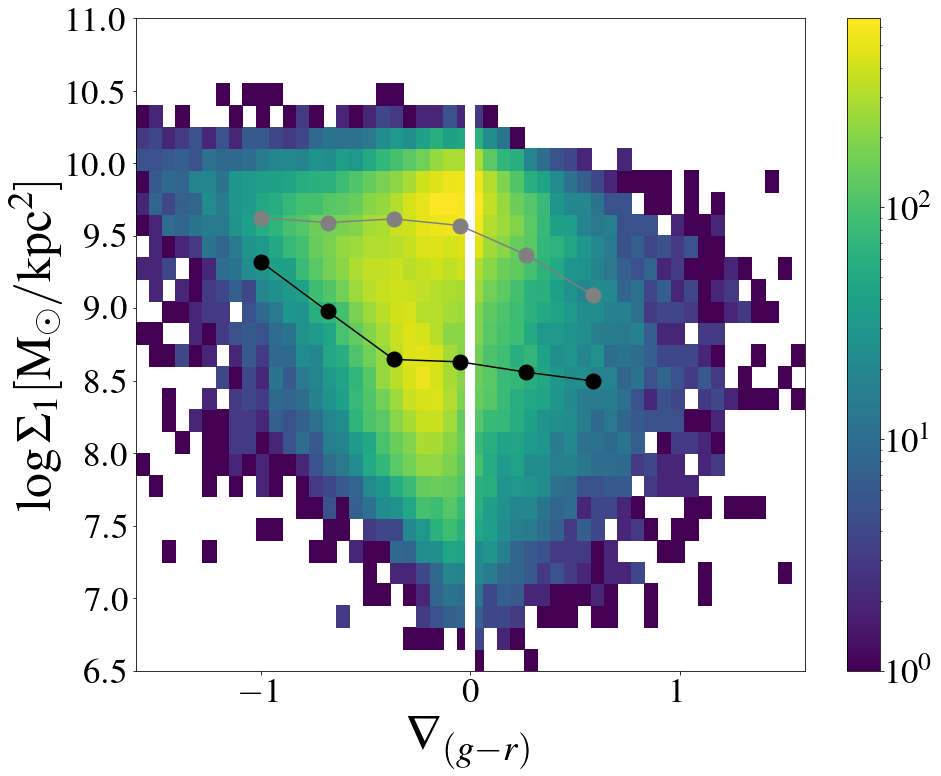

In [209]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr Diamond vs Sigma1 early late
plt.hist2d(gradiente_gr, np.log10(S1_d), bins=(50,30), range=[[-1.6, 1.6],[6.5,11]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(grad_S1_late_means_bins[:-1], stat_grad_S1_late_mean, zorder=3,  color ='black', marker = 'o', markersize= 15,  label='Late type Mean')
plt.errorbar(grad_S1_late_means_bins[:-1], stat_grad_S1_late_mean, yerr=stat_grad_S1_late_std/np.sqrt(stat_grad_S1_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.plot(grad_S1_early_means_bins[:-1], stat_grad_S1_early_mean, zorder=3,  color ='gray', marker = 'o', markersize= 15,  label='Early type Mean')
plt.errorbar(grad_S1_early_means_bins[:-1], stat_grad_S1_early_mean, yerr=stat_grad_S1_early_std/np.sqrt(stat_grad_S1_early_count+1), zorder=3, xerr=None, ls='None', ecolor='gray', elinewidth=5)
plt.colorbar() 
y = [6.5,11]
x = [0,0]
plt.plot(x, y, zorder = 2, color='white', linestyle='-', lw=10)

# Add axis labels

plt.ylabel(r'$\log \Sigma_{1} [\rm M_{\odot}/ kpc^{2}]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(6.5,11)
plt.xlim(-1.6, 1.6)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_S1D.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

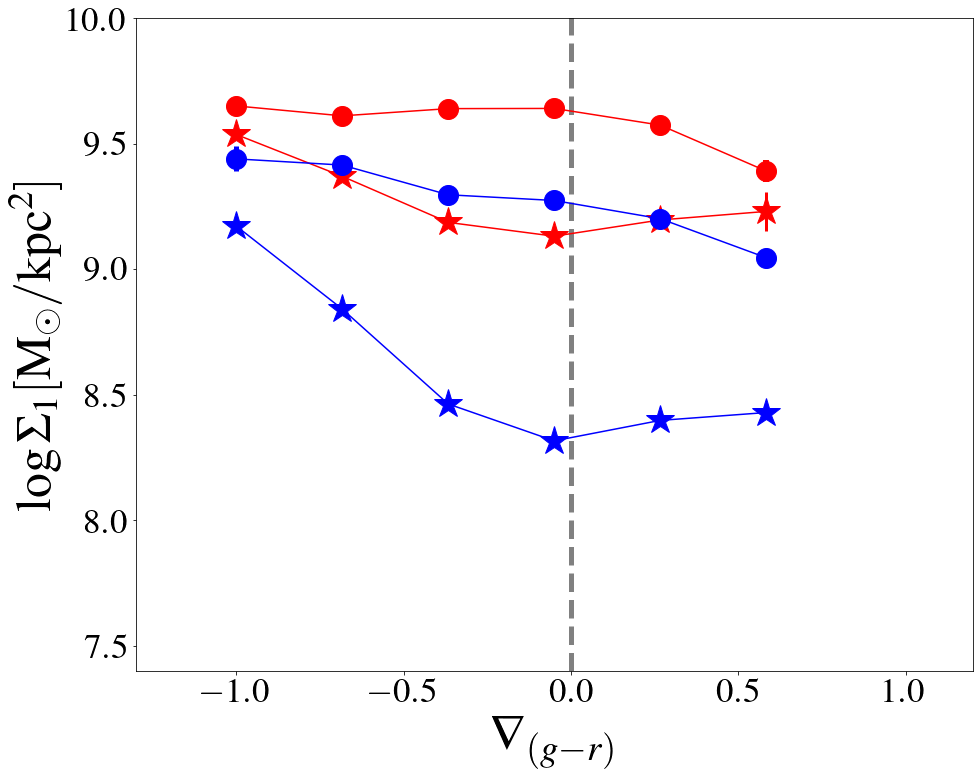

In [210]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gr Diamond vs Sigma1 mean

plt.plot(grad_S1_late_red_means_bins[:-1], stat_grad_S1_late_red_mean, zorder=3,  color ='red', marker = '*', markersize= 30,  label='Red late-type ')
plt.errorbar(grad_S1_late_red_means_bins[:-1], stat_grad_S1_late_red_mean, yerr=stat_grad_S1_late_red_std/np.sqrt(stat_grad_S1_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_S1_early_red_means_bins[:-1], stat_grad_S1_early_red_mean, zorder=3,  color ='red', marker = 'o', markersize= 20,  label='Red early-type ')
plt.errorbar(grad_S1_early_red_means_bins[:-1], stat_grad_S1_early_red_mean, yerr=stat_grad_S1_early_red_std/np.sqrt(stat_grad_S1_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)

plt.plot(grad_S1_late_blue_means_bins[:-1], stat_grad_S1_late_blue_mean, zorder=3,  color ='blue', marker = '*', markersize= 30,  label='Blue late-type ')
plt.errorbar(grad_S1_late_blue_means_bins[:-1], stat_grad_S1_late_blue_mean, yerr=stat_grad_S1_late_blue_std/np.sqrt(stat_grad_S1_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_S1_early_blue_means_bins[:-1], stat_grad_S1_early_blue_mean, zorder=3,  color ='blue', marker = 'o', markersize= 20,  label='Blue early-type ')
plt.errorbar(grad_S1_early_blue_means_bins[:-1], stat_grad_S1_early_blue_mean, yerr=stat_grad_S1_early_blue_std/np.sqrt(stat_grad_S1_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

y = [6.5,11]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log \Sigma_{1} [\rm M_{\odot}/ kpc^{2}]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(7.4,10)
plt.xlim(-1.3, 1.2)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_S1D_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

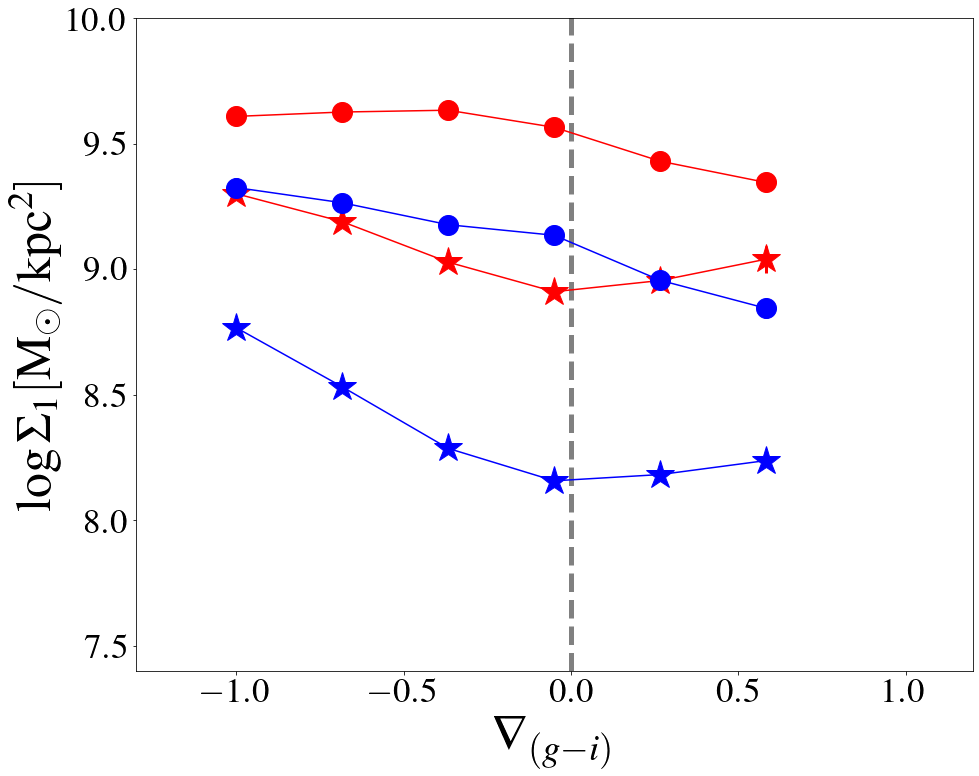

In [360]:
fig, ax= plt.subplots(figsize=(15,12))

# gradient gi Diamond vs Sigma1 mean

plt.plot(grad_gi_S1_late_red_means_bins[:-1], stat_grad_gi_S1_late_red_mean, zorder=3,  color ='red', marker = '*', markersize= 30,  label='Red late-type ')
plt.errorbar(grad_gi_S1_late_red_means_bins[:-1], stat_grad_gi_S1_late_red_mean, yerr=stat_grad_gi_S1_late_red_std/np.sqrt(stat_grad_gi_S1_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=3)
plt.plot(grad_gi_S1_early_red_means_bins[:-1], stat_grad_gi_S1_early_red_mean, zorder=3,  color ='red', marker = 'o', markersize= 20,  label='Red early-type ')
plt.errorbar(grad_gi_S1_early_red_means_bins[:-1], stat_grad_gi_S1_early_red_mean, yerr=stat_grad_gi_S1_early_red_std/np.sqrt(stat_grad_gi_S1_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=6)

plt.plot(grad_gi_S1_late_blue_means_bins[:-1], stat_grad_gi_S1_late_blue_mean, zorder=3,  color ='blue', marker = '*', markersize= 30,  label='Blue late-type ')
plt.errorbar(grad_gi_S1_late_blue_means_bins[:-1], stat_grad_gi_S1_late_blue_mean, yerr=stat_grad_gi_S1_late_blue_std/np.sqrt(stat_grad_gi_S1_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=4)
plt.plot(grad_gi_S1_early_blue_means_bins[:-1], stat_grad_gi_S1_early_blue_mean, zorder=3,  color ='blue', marker = 'o', markersize= 20,  label='Blue early-type ')
plt.errorbar(grad_gi_S1_early_blue_means_bins[:-1], stat_grad_gi_S1_early_blue_mean, yerr=stat_grad_gi_S1_early_blue_std/np.sqrt(stat_grad_gi_S1_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

y = [6.5,11]
x = [0,0]
plt.plot(x, y, zorder = 2, color='gray', linestyle='--', lw=5)

# Add axis labels

plt.ylabel(r'$\log \Sigma_{1} [\rm M_{\odot}/ kpc^{2}]$', fontsize=50)
plt.xlabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(7.4,10)
plt.xlim(-1.3, 1.2)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_gi_S1D_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

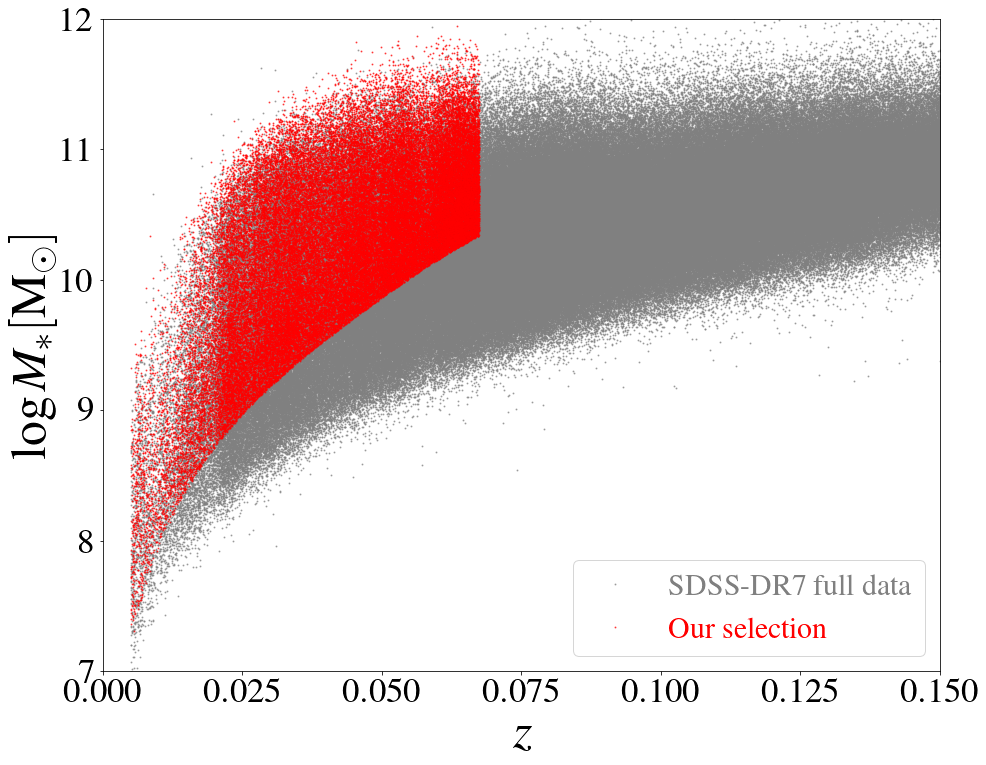

In [211]:
fig, ax= plt.subplots(figsize=(15,12))


# Ms VS z
plt.plot(z_full, np.log10(Ms_gi_full) ,'.', color='grey' , markersize=2, alpha=0.6, label=r'SDSS-DR7 full data')
plt.plot(z_d, np.log10(Ms_d) ,'.', color='red' , markersize=2, alpha=0.6, label=r'Our selection')



# Add axis labels

plt.xlabel(r'$z $', fontsize=50)
plt.ylabel(r'$\log M_{\ast} [\rm M_{\odot}]$', fontsize=50)

#set axis limits
plt.ylim(7, 12)
plt.xlim(0,0.15)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# plt.legend(fontsize=60)

plt.legend(labelcolor='linecolor', loc='lower right', fontsize=30) 

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/Ms_vs_Z.png',format='png',dpi=25, bbox_inches = 'tight')
plt.show()


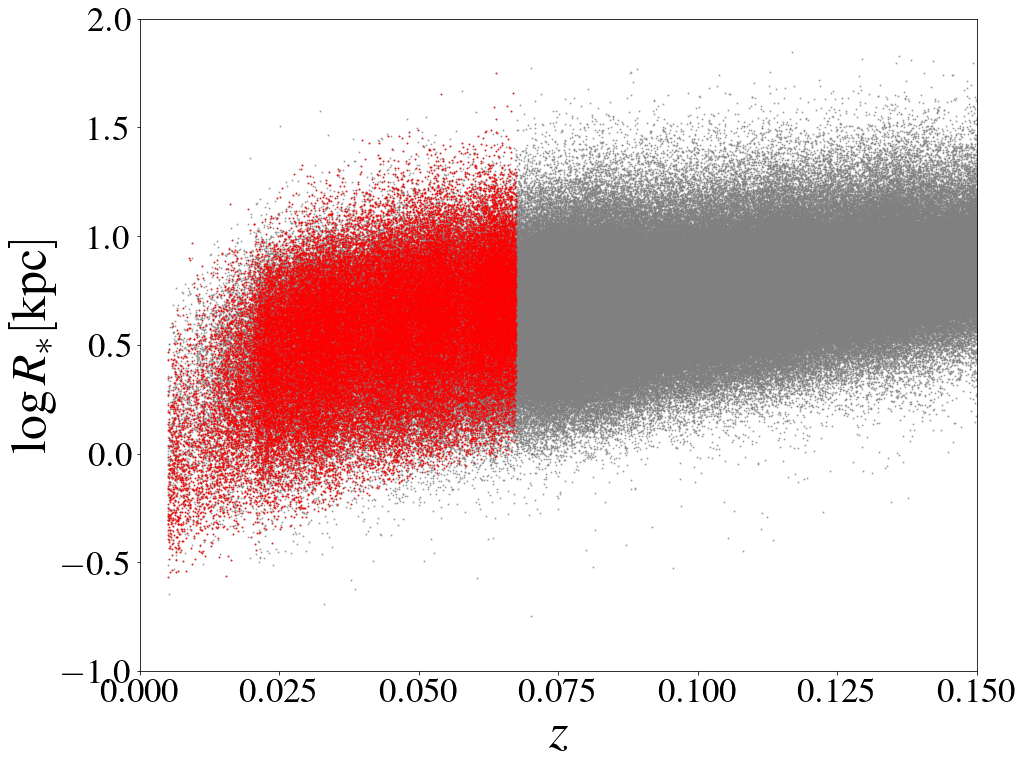

In [212]:
fig, ax= plt.subplots(figsize=(15,12))


# Rer VS z
plt.plot(z_full, np.log10(Re_r_full) ,'.', color='gray' , markersize=2, alpha=0.6)
plt.plot(z_d, np.log10(Re_r_d) ,'.', color='red' , markersize=2, alpha=0.6)

# plt.legend(labelcolor='linecolor')


# Add axis labels

plt.xlabel(r'$z $', fontsize=50)
plt.ylabel(r'$\log R_{\ast} [\rm kpc]$', fontsize=50)

#set axis limits
plt.ylim(-1, 2)
plt.xlim(0,0.15)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(labelcolor='linecolor', loc='lower right', fontsize=30)   
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/Rer_vs_Z.png',format='png',dpi=25, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax= plt.subplots(figsize=(15,12))

# colo vs mass gi
plt.plot(np.log10(Ms_d), gid, '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d), 0*gid+.85)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$(g-i)$', fontsize=40)

#set axis limits
plt.ylim(0.2, 1.4)
plt.xlim(8.0,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/color_vs_mass_gi.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()

No handles with labels found to put in legend.


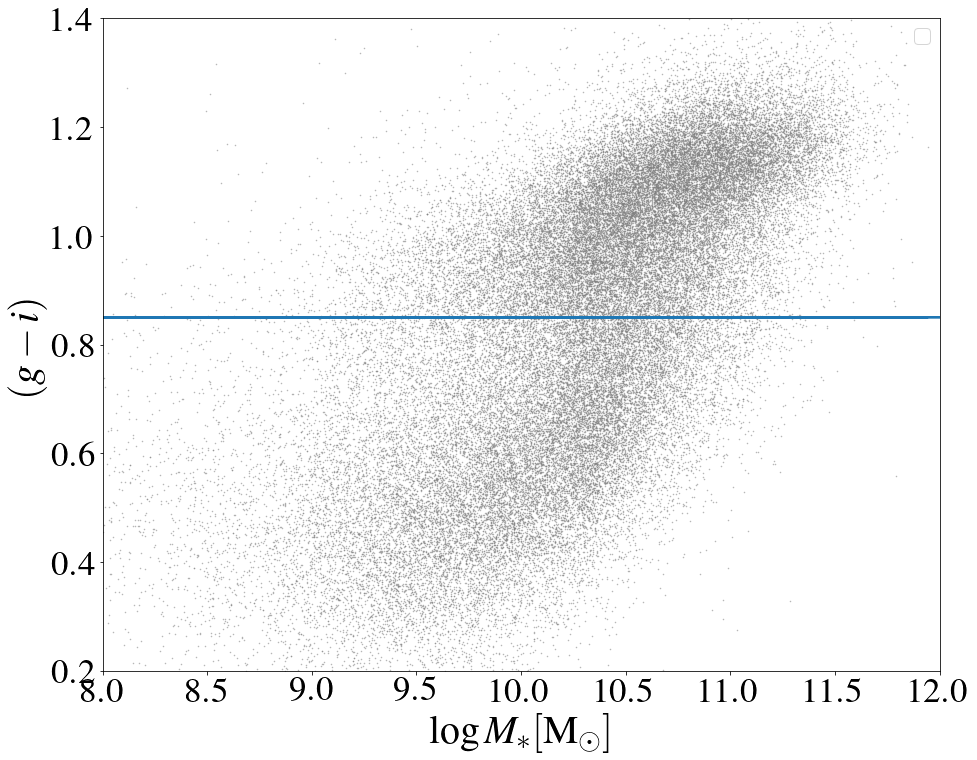

In [220]:
fig, ax= plt.subplots(figsize=(15,12))

# color vs mass gi gust corrected
plt.plot(np.log10(Ms_d_late), gi_dust, '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d_early), gid[sphr_d], '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d), 0*gid+.85)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$(g-i)$', fontsize=40)

#set axis limits
plt.ylim(0.2, 1.4)
plt.xlim(8.0,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/color_vs_mass_gi_dust.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()

No handles with labels found to put in legend.


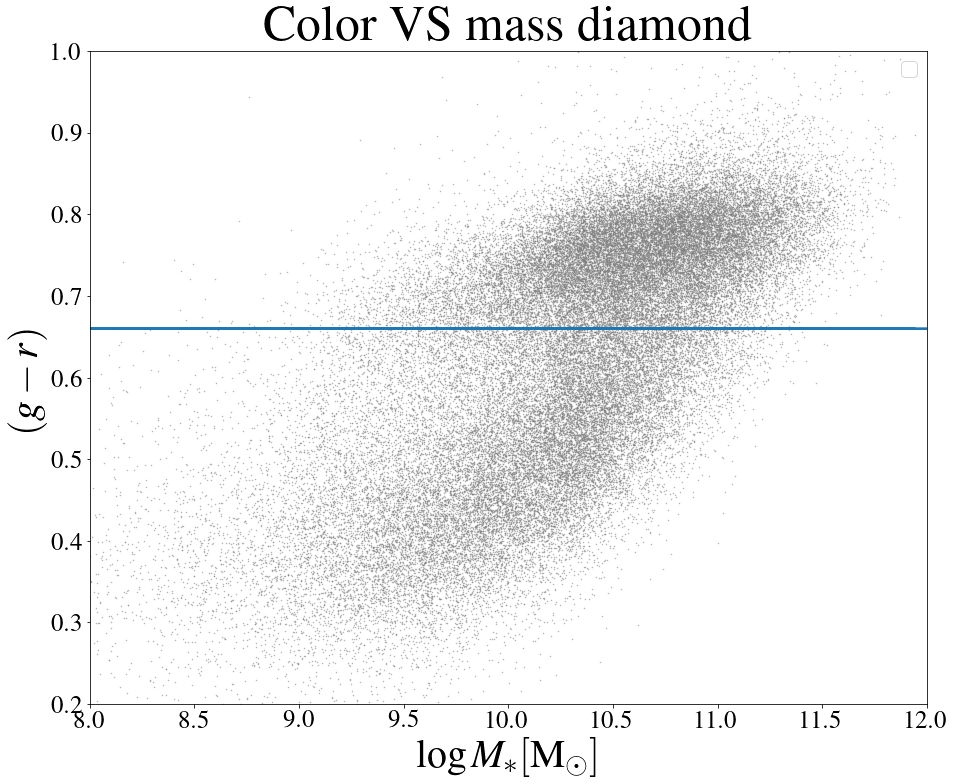

In [221]:
fig, ax= plt.subplots(figsize=(15,12))

# color vs mass gr
plt.plot(np.log10(Ms_d), grd, '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d), 0*grd+.66)

# Add axis labels

plt.title(r'Color VS mass diamond', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$(g-r)$', fontsize=40)

#set axis limits
plt.ylim(0.2, 1.0)
plt.xlim(8.0,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/color_vs_mass_gr.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()

No handles with labels found to put in legend.


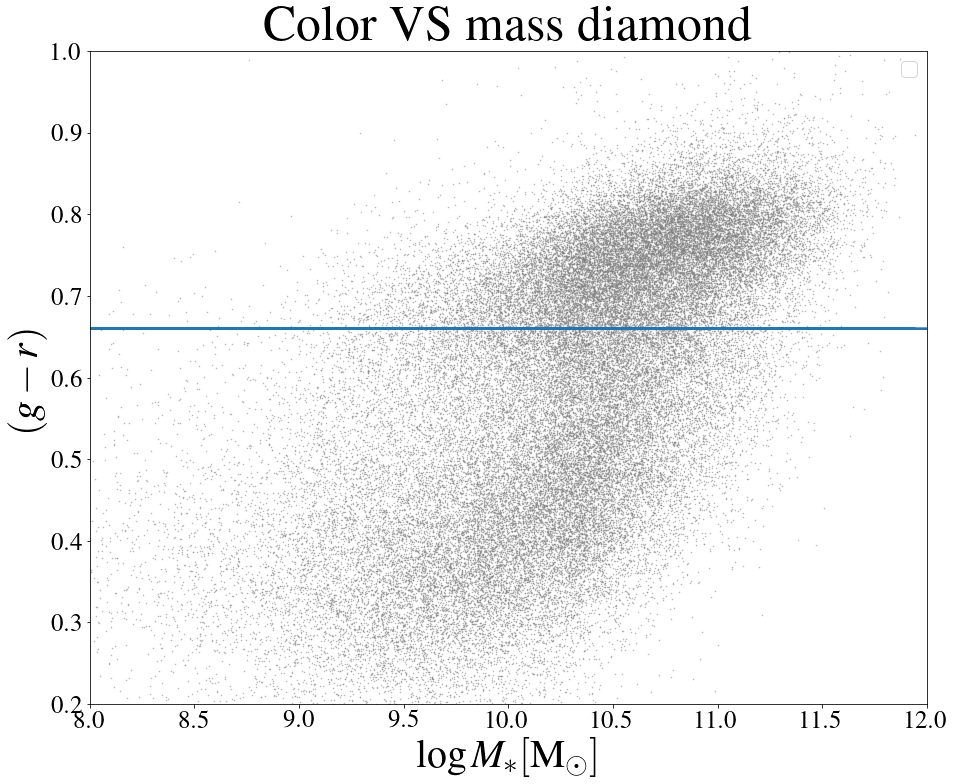

In [222]:
fig, ax= plt.subplots(figsize=(15,12))

# color vs mass gr dust corrected
plt.plot(np.log10(Ms_d_late), gr_dust, '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d_early), grd[sphr_d], '.', color='gray' , marker='.', markersize=1, alpha=0.6)
plt.plot(np.log10(Ms_d), 0*grd+.66)

# Add axis labels

plt.title(r'Color VS mass diamond', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$(g-r)$', fontsize=40)

#set axis limits
plt.ylim(0.2, 1.0)
plt.xlim(8.0,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/color_vs_mass_gr_dust.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()

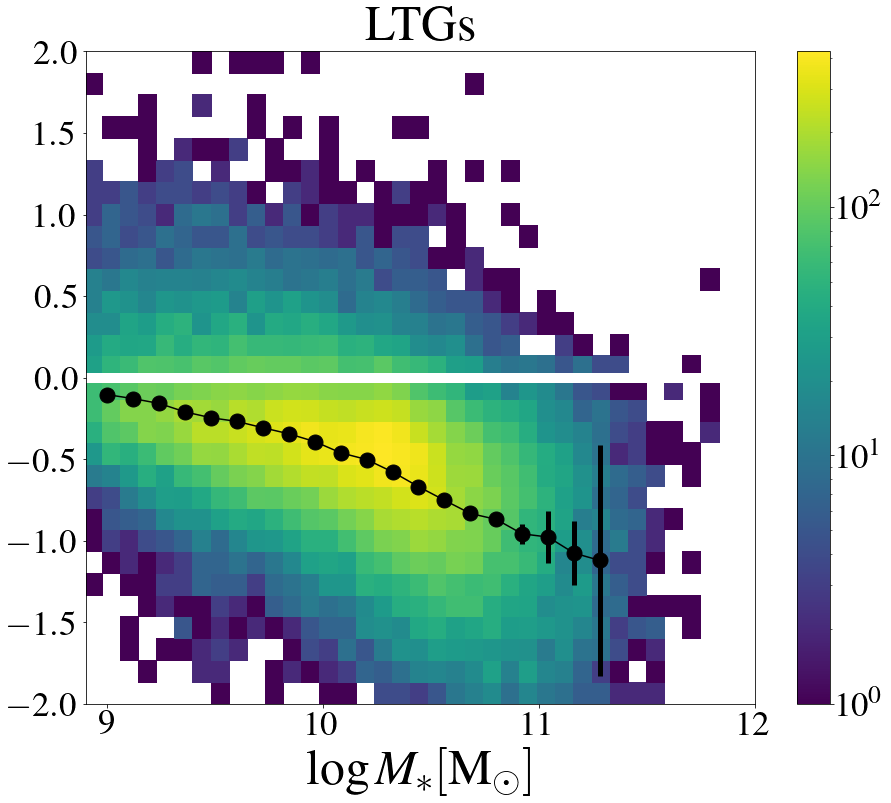

In [295]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_late), gradgi_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15)
plt.errorbar(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, yerr=stat_gradgi_late_std/np.sqrt(stat_gradgi_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)


# Add axis labels

plt.title(r'LTGs', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

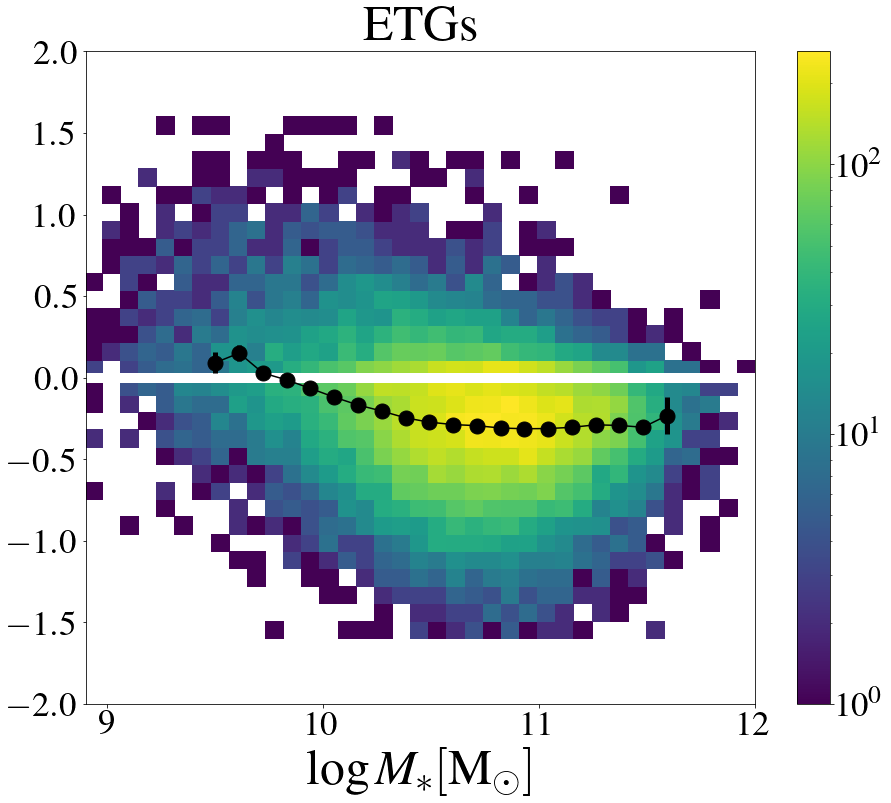

In [294]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 1 Re  VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_early), gradgi_early, bins=(50,30), range=[[7.8,12],[-1.6,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15)
plt.errorbar(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, yerr=stat_gradgi_early_std/np.sqrt(stat_gradgi_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels
plt.title(r'ETGs', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$ \nabla_(g-i)$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

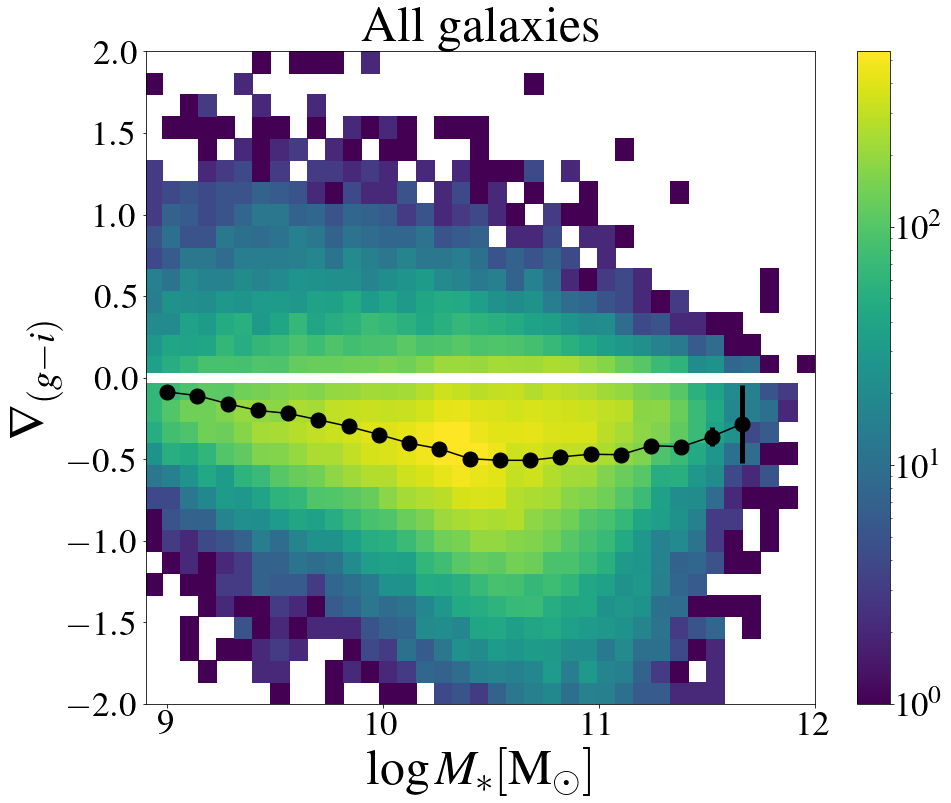

In [293]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 1 Re VS Ms_d all Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d), gradiente_gi, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgi_mean_bins[:-1], stat_gradgi_mean, zorder=3, color ='black', marker = 'o', markersize= 15)
plt.errorbar(gradgi_mean_bins[:-1], stat_gradgi_mean, yerr=stat_gradgi_std/np.sqrt(stat_gradgi_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)


# Add axis labels

plt.title(r'All galaxies', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$ \nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msd_all.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

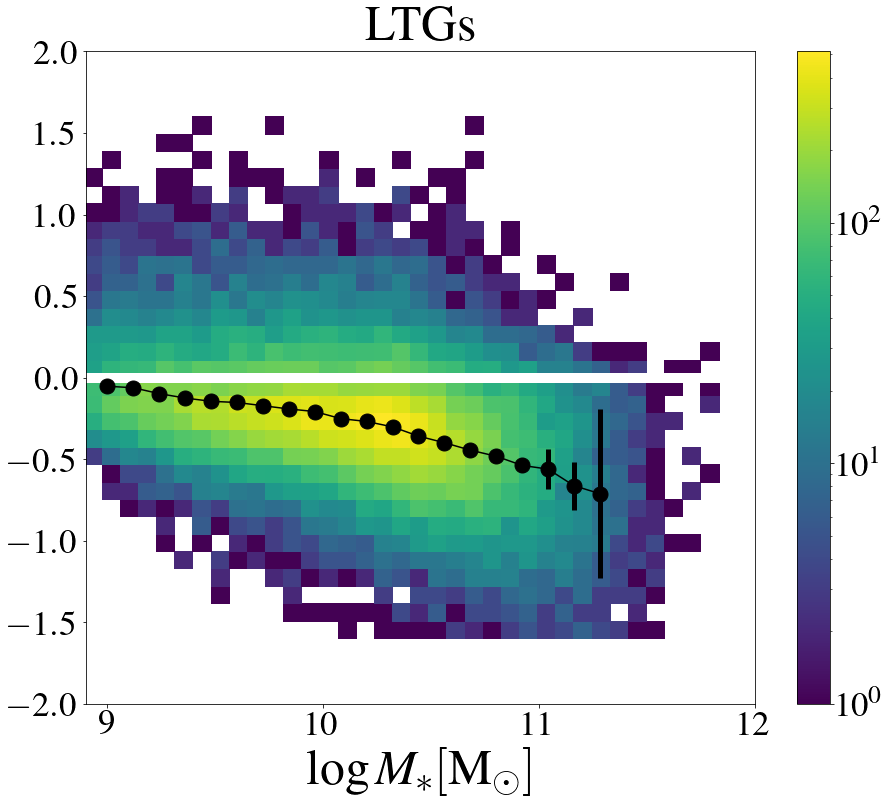

In [226]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_late), gradgr_late, bins=(50,30), range=[[7.8,12],[-1.6,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15)
plt.errorbar(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, yerr=stat_gradgr_late_std/np.sqrt(stat_gradgr_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$ \nabla_(g-r)$', fontsize=50)
plt.title(r'LTGs', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

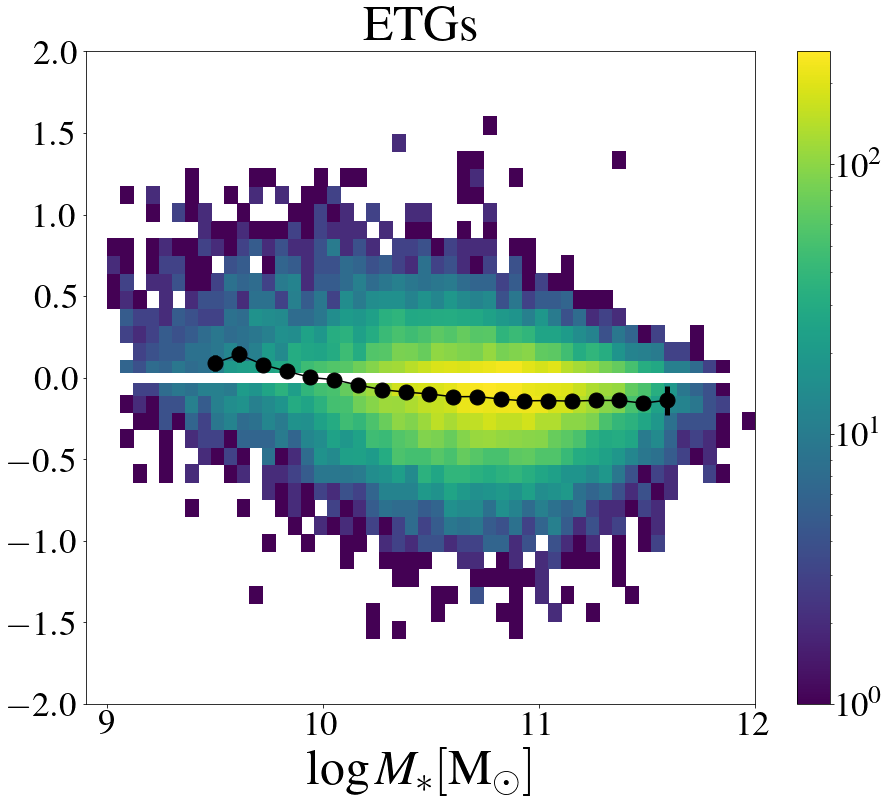

In [227]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_early), gradgr_early, bins=(50,30), range=[[9.0,12],[-1.6,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15)
plt.errorbar(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, yerr=stat_gradgr_early_std/np.sqrt(stat_gradgr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$ \nabla_(g-r)$', fontsize=50)
plt.title(r'ETGs', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

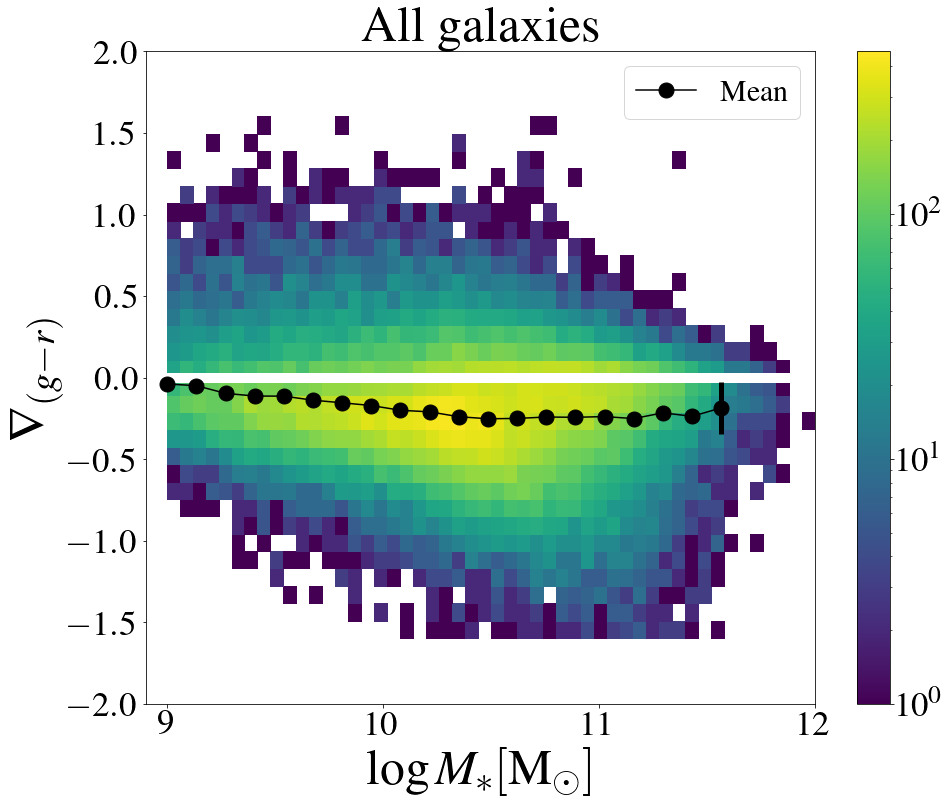

In [228]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS Ms_d all  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d), gradiente_gr, bins=(50,30), range=[[9.0,12],[-1.6,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgr_mean_bins[:-1], stat_gradgr_mean, zorder=3, color ='black',  marker = 'o', markersize='15', label=r'Mean ')
plt.errorbar(gradgr_mean_bins[:-1], stat_gradgr_mean, yerr=stat_gradgr_std/np.sqrt(stat_gradgr_count +1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels
plt.title(r'All galaxies', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$ \nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msd_all.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

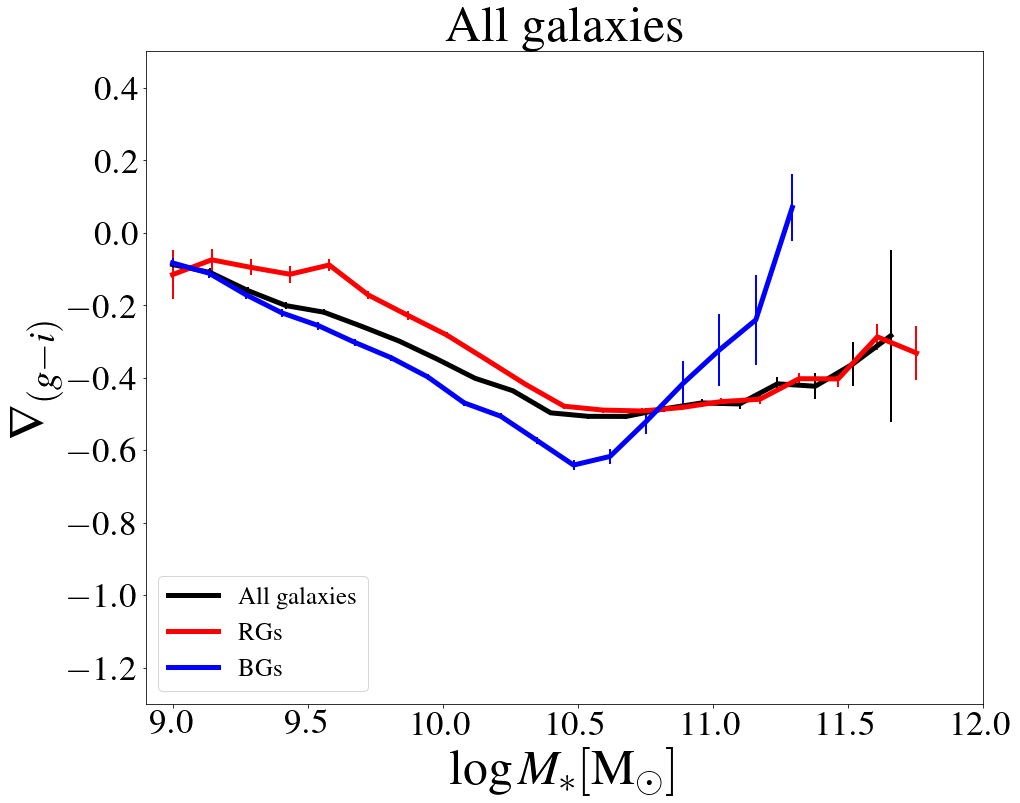

In [308]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  and gi mean 1 Re  VS Ms_d 
logMs= np.linspace(8,12)

# plt.plot(gradgr_mean_bins[:-1], stat_gradgr_mean, zorder=3, color ='black', lw=8,  label= r'All galaxies $\nabla_(g-r)$  ')
# plt.errorbar(gradgr_mean_bins[:-1], stat_gradgr_mean, yerr=stat_gradgr_std/np.sqrt(stat_gradgr_count +1),  xerr=None, ls='None', ecolor='black', elinewidth=2)
# plt.plot(gradgr_red_mean_bins[:-1], stat_gradgr_red_mean, zorder=3, color ='red', lw=8,  label= r' RG $\nabla_(g-r)$  ')
# plt.errorbar(gradgr_red_mean_bins[:-1], stat_gradgr_red_mean, yerr=stat_gradgr_red_std/np.sqrt(stat_gradgr_red_count +1),  xerr=None, ls='None', ecolor='red', elinewidth=2)
# plt.plot(gradgr_blue_mean_bins[:-1], stat_gradgr_blue_mean, zorder=3, color ='blue', lw=8,  label= r'BG $\nabla_(g-r)$  ')
# plt.errorbar(gradgr_blue_mean_bins[:-1], stat_gradgr_blue_mean, yerr=stat_gradgr_blue_std/np.sqrt(stat_gradgr_blue_count +1),  xerr=None, ls='None', ecolor='blue', elinewidth=2)


plt.plot(gradgi_mean_bins[:-1], stat_gradgi_mean, zorder=3, color ='black', lw=5,   label= r'All galaxies ')
plt.errorbar(gradgi_mean_bins[:-1], stat_gradgi_mean, yerr=stat_gradgi_std/np.sqrt(stat_gradgi_count +1),  xerr=None, ls='None', ecolor='black', elinewidth= 2)
plt.plot(gradgi_red_mean_bins[:-1], stat_gradgi_red_mean, zorder=3, color ='red', lw=5,   label=r'RGs ')
plt.errorbar(gradgi_red_mean_bins[:-1], stat_gradgi_red_mean, yerr=stat_gradgi_red_std/np.sqrt(stat_gradgi_red_count +1),  xerr=None, ls='None', ecolor='red', elinewidth=2)
plt.plot(gradgi_blue_mean_bins[:-1], stat_gradgi_blue_mean, zorder=3, color ='blue', lw=5,   label= r'BGs ')
plt.errorbar(gradgi_blue_mean_bins[:-1], stat_gradgi_blue_mean, yerr=stat_gradgi_blue_std/np.sqrt(stat_gradgi_blue_count +1),  xerr=None, ls='None', ecolor='blue', elinewidth=2)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)
plt.title(r'All galaxies', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=25, loc='lower left')
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delmean_Msd_all.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

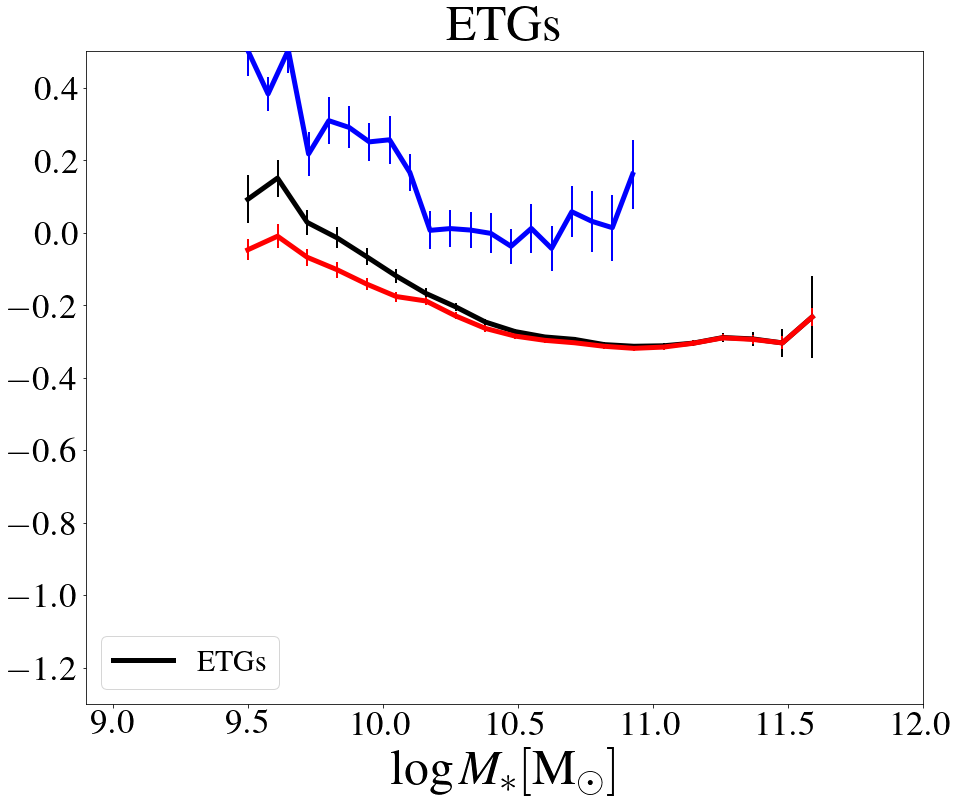

In [309]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  and gi mean 1 Re early VS Ms_d 
logMs= np.linspace(8,12)

# plt.plot(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, zorder=3, color ='black', lw=8, label=r'ETGs $\nabla_{(g-r)}$')
# plt.errorbar(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, yerr=stat_gradgr_early_std/np.sqrt(stat_gradgr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=2)
plt.plot(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, zorder=3, color ='black', lw=5, label=r'ETGs ')
plt.errorbar(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, yerr=stat_gradgi_early_std/np.sqrt(stat_gradgi_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=2)
# plt.plot(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, zorder=3, color ='red',lw=8)
# plt.errorbar(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, yerr=stat_gradgr_red_early_std/np.sqrt(stat_gradgr_red_early_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=2)
plt.plot(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, zorder=3, color ='red',lw=5)
plt.errorbar(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, yerr=stat_gradgi_red_early_std/np.sqrt(stat_gradgi_red_early_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=2)
# plt.plot(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, zorder=3, color ='blue', lw=8)
# plt.errorbar(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, yerr=stat_gradgr_blue_early_std/np.sqrt(stat_gradgr_blue_early_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=2)
plt.plot(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, zorder=3, color ='blue', lw=5)
plt.errorbar(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, yerr=stat_gradgi_blue_early_std/np.sqrt(stat_gradgi_blue_early_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=2)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$\nabla_(g-x)$', fontsize=50)
plt.title(r'ETGs', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30, loc='lower left')
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delmean_Msd_early.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

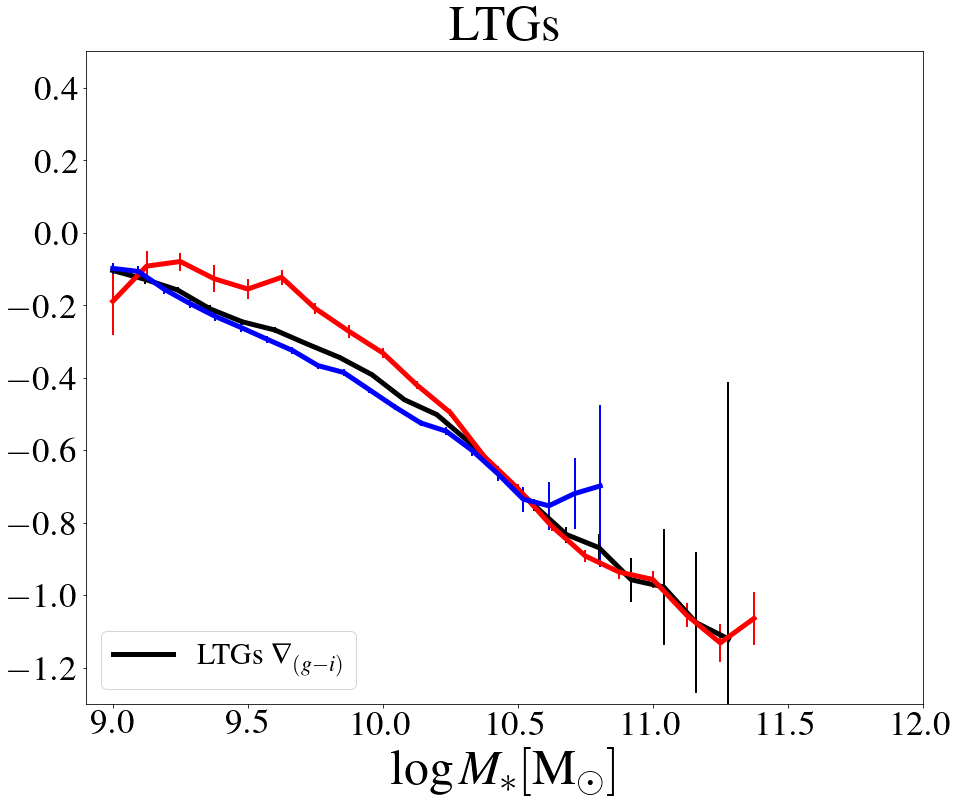

In [310]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  and gi mean 1 Re late VS Ms_d 
logMs= np.linspace(8,12)

# plt.plot(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, zorder=3, color ='black', lw=8, label=r'LTGs $\nabla_{(g-r)}$')
# plt.errorbar(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, yerr=stat_gradgr_late_std/np.sqrt(stat_gradgr_late_count +1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=2)
plt.plot(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, zorder=3, color ='black', lw=5, label=r'LTGs $\nabla_{(g-i)}$')
plt.errorbar(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, yerr=stat_gradgi_late_std/np.sqrt(stat_gradgi_late_count +1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=2)
# plt.plot(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, zorder=3, color ='red', lw=8)
# plt.errorbar(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, yerr=stat_gradgr_red_late_std/np.sqrt(stat_gradgr_red_late_count +1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=2)
plt.plot(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, zorder=3, color ='red', lw=5) 
plt.errorbar(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, yerr=stat_gradgi_red_late_std/np.sqrt(stat_gradgi_red_late_count +1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=2)
# plt.plot(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, zorder=3, color ='blue', lw=8) 
# plt.errorbar(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, yerr=stat_gradgr_blue_late_std/np.sqrt(stat_gradgr_blue_late_count +1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=2)
plt.plot(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, zorder=3, color ='blue', lw=5)
plt.errorbar(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, yerr=stat_gradgi_blue_late_std/np.sqrt(stat_gradgi_blue_late_count +1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=2)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$\nabla_(g-x)$', fontsize=50)
plt.title(r'LTGs', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30, loc='lower left')
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delmean_Msd_late.pdf',format='pdf',dpi=200, bbox_inches = 'tight')

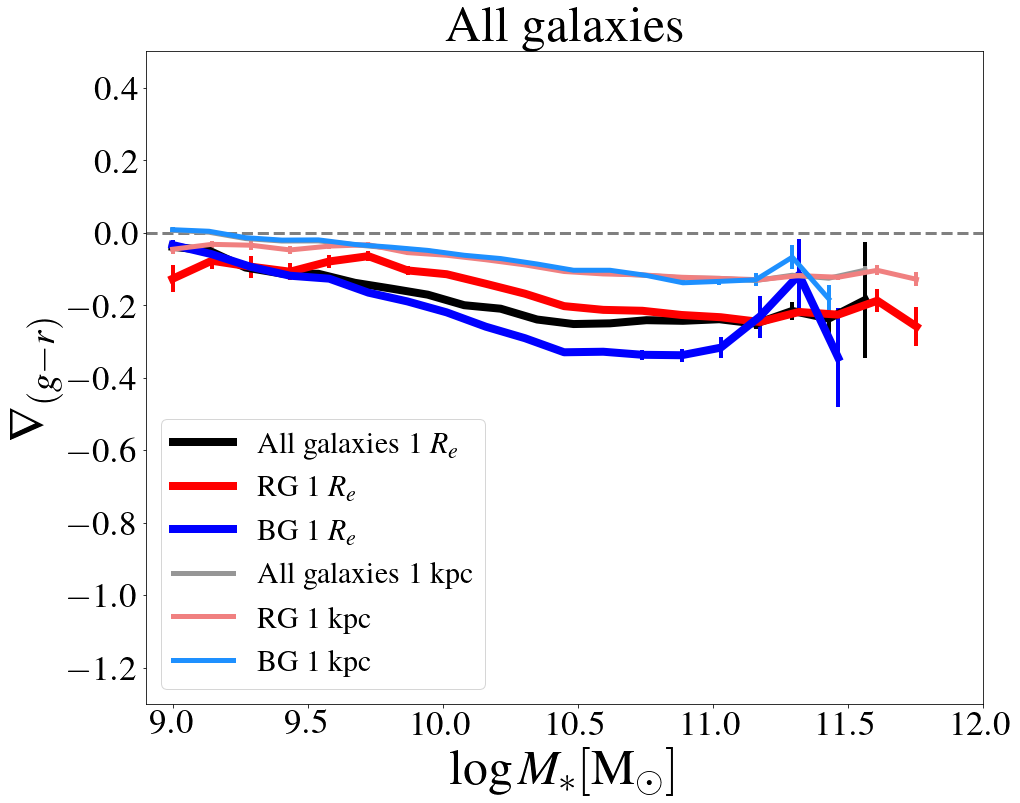

In [232]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr   VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgr_mean_bins[:-1], stat_gradgr_mean, zorder=3, color='black', lw=8,  label= r'All galaxies 1 $R_e$')
plt.errorbar(gradgr_mean_bins[:-1], stat_gradgr_mean, yerr=stat_gradgr_std/np.sqrt(stat_gradgr_count+1),  xerr=None, ls='None', ecolor='black', elinewidth=4)

plt.plot(gradgr_red_mean_bins[:-1], stat_gradgr_red_mean, zorder=3, color ='red', lw=8,  label= r'RG  1 $R_e$')
plt.errorbar(gradgr_red_mean_bins[:-1], stat_gradgr_red_mean, yerr=stat_gradgr_red_std/np.sqrt(stat_gradgr_red_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=4)

plt.plot(gradgr_blue_mean_bins[:-1], stat_gradgr_blue_mean, zorder=3, color ='blue', lw=8,  label= r'BG  1 $R_e$')
plt.errorbar(gradgr_blue_mean_bins[:-1], stat_gradgr_blue_mean, yerr=stat_gradgr_blue_std/np.sqrt(stat_gradgr_blue_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=4)



plt.plot(gradgrS1_mean_bins[:-1], stat_gradgrS1_mean, zorder=3, color ='#969696', lw=5,  label= r'All galaxies 1 kpc')
plt.errorbar(gradgrS1_mean_bins[:-1], stat_gradgrS1_mean, yerr=stat_gradgrS1_std/np.sqrt(stat_gradgrS1_count+1),  xerr=None, ls='None', ecolor='#969696', elinewidth=4)

plt.plot(gradgr_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_mean, zorder=3, color ='lightcoral', lw=5,  label= r'RG  1 kpc')
plt.errorbar(gradgr_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_mean, yerr=stat_gradgr_kpc_red_std/np.sqrt(stat_gradgr_kpc_red_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=4)

plt.plot(gradgr_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_mean, zorder=3, color ='dodgerblue', lw=5,  label= r'BG  1 kpc')
plt.errorbar(gradgr_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_mean, yerr=stat_gradgr_kpc_blue_std/np.sqrt(stat_gradgr_kpc_blue_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=4)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)
plt.title(r'All galaxies', fontsize=50)
#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msd_all_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

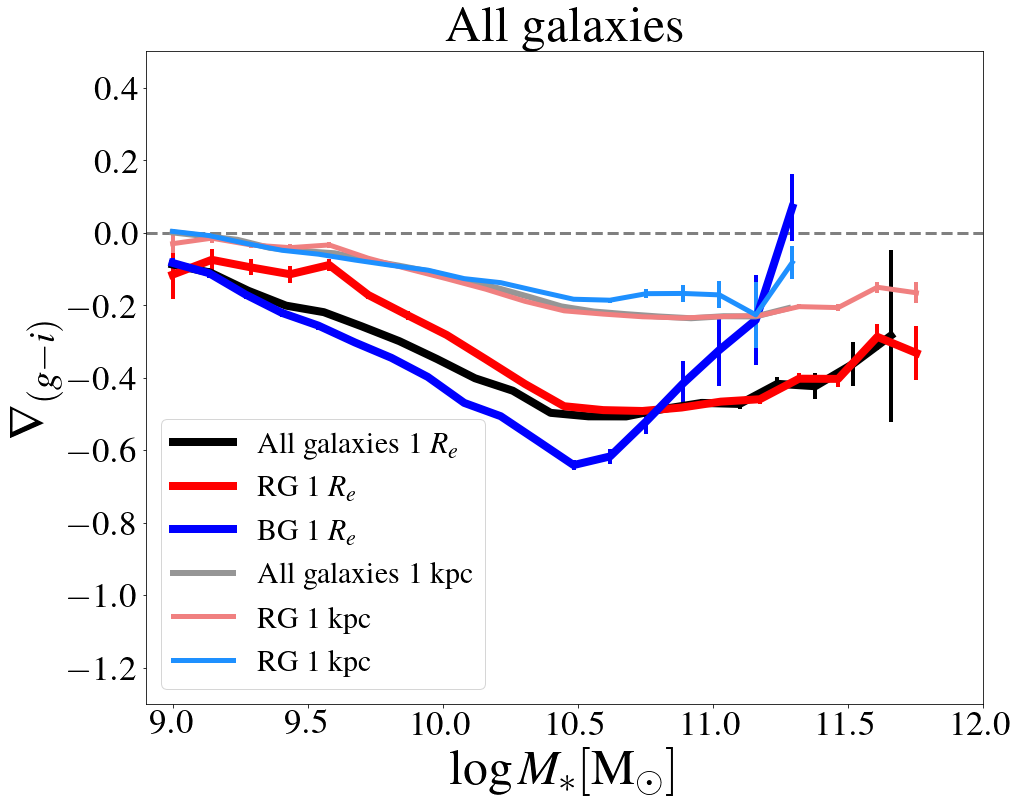

In [313]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi  VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgi_mean_bins[:-1], stat_gradgi_mean, zorder=3, lw=8, color='black',  label= r'All galaxies 1 $R_e$')
plt.errorbar(gradgi_mean_bins[:-1], stat_gradgi_mean, yerr=stat_gradgi_std/np.sqrt(stat_gradgi_count+1),  xerr=None, ls='None', ecolor='black', elinewidth=4)

plt.plot(gradgi_red_mean_bins[:-1], stat_gradgi_red_mean, zorder=3, color ='red', lw=8,  label= r'RG  1 $R_e$')
plt.errorbar(gradgi_red_mean_bins[:-1], stat_gradgi_red_mean, yerr=stat_gradgi_red_std/np.sqrt(stat_gradgi_red_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=4)

plt.plot(gradgi_blue_mean_bins[:-1], stat_gradgi_blue_mean, zorder=3, color ='blue', lw=8,  label= r'BG  1 $R_e$')
plt.errorbar(gradgi_blue_mean_bins[:-1], stat_gradgi_blue_mean, yerr=stat_gradgi_blue_std/np.sqrt(stat_gradgi_blue_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=4)



plt.plot(gradgiS1_mean_bins[:-1], stat_gradgiS1_mean, zorder=3, color ='#969696', lw=6,  label= r'All galaxies 1 kpc')
plt.errorbar(gradgiS1_mean_bins[:-1], stat_gradgiS1_mean, yerr=stat_gradgiS1_std/np.sqrt(stat_gradgiS1_count+1),  xerr=None, ls='None', ecolor='#969696', elinewidth=4)

plt.plot(gradgi_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_mean, zorder=3, color ='lightcoral', lw=5,  label= r'RG  1 kpc')
plt.errorbar(gradgi_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_mean, yerr=stat_gradgi_kpc_red_std/np.sqrt(stat_gradgi_kpc_red_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=4)

plt.plot(gradgi_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_mean, zorder=3, color ='dodgerblue', lw=5,  label= r'RG  1 kpc')
plt.errorbar(gradgi_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_mean, yerr=stat_gradgi_kpc_blue_std/np.sqrt(stat_gradgi_kpc_blue_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=4)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)
plt.title(r'All galaxies')
#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msd_all_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

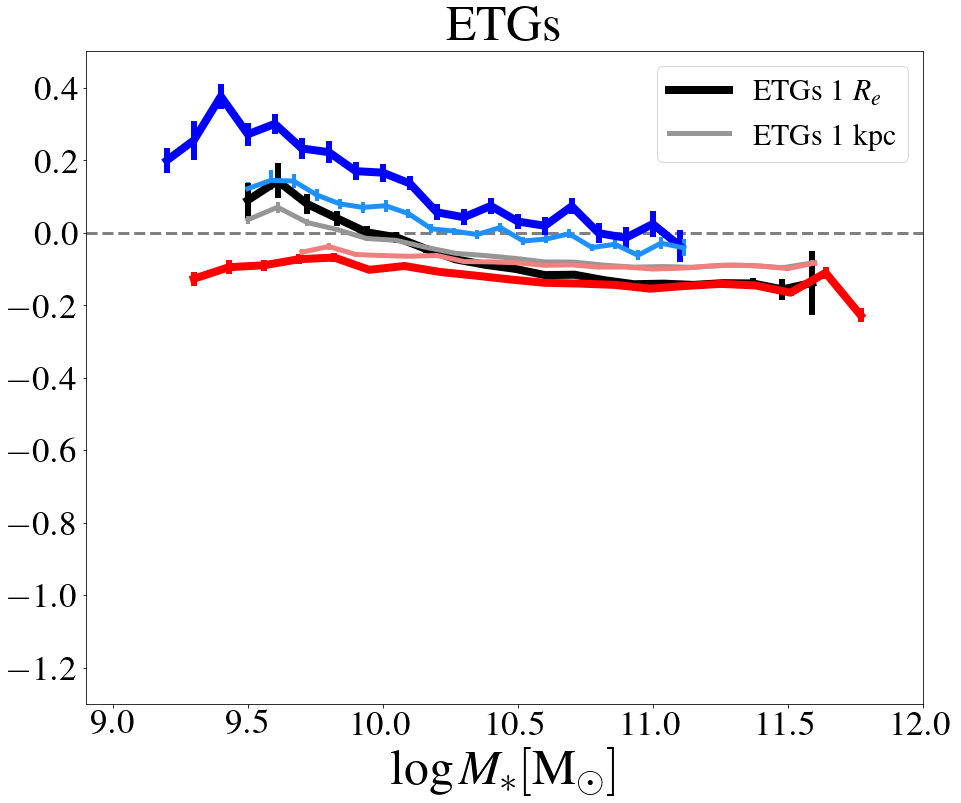

In [234]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr early mean  Re  VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, zorder=3, color ='black', lw=8,  label=r'ETGs 1 $R_e$')
plt.errorbar(gradgrearly_mean_bins[:-1], stat_gradgr_early_mean, yerr=stat_gradgr_early_std/np.sqrt(stat_gradgr_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=6)

plt.plot(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, zorder=3, color ='red', lw=8)
plt.errorbar(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, yerr=stat_gradgr_red_early_std/np.sqrt(stat_gradgr_red_early_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=6)

plt.plot(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, zorder=3, color ='blue', lw=8)
plt.errorbar(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, yerr=stat_gradgr_blue_early_std/np.sqrt(stat_gradgr_blue_early_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=6)


plt.plot(gradgrearlyS1_mean_bins[:-1], stat_gradgrS1_early_mean, zorder=3, color ='#969696', lw=5,  label=r'ETGs 1 kpc ')
plt.errorbar(gradgrearlyS1_mean_bins[:-1], stat_gradgrS1_early_mean, yerr=stat_gradgrS1_early_std/np.sqrt(stat_gradgrS1_early_count), zorder=3, xerr=None, ls='None', ecolor='#969696', elinewidth=4)

plt.plot(gradgrearly_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_early_mean, zorder=3, color ='lightcoral', lw=5)
plt.errorbar(gradgrearly_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_early_mean, yerr=stat_gradgr_kpc_red_early_std/np.sqrt(stat_gradgr_kpc_red_early_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=4)

plt.plot(gradgrearly_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_early_mean, zorder=3, color ='dodgerblue', lw=5)
plt.errorbar(gradgrearly_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_early_mean, yerr=stat_gradgr_kpc_blue_early_std/np.sqrt(stat_gradgr_kpc_blue_early_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=4)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)
# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.title(r'ETGs', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msd_early_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


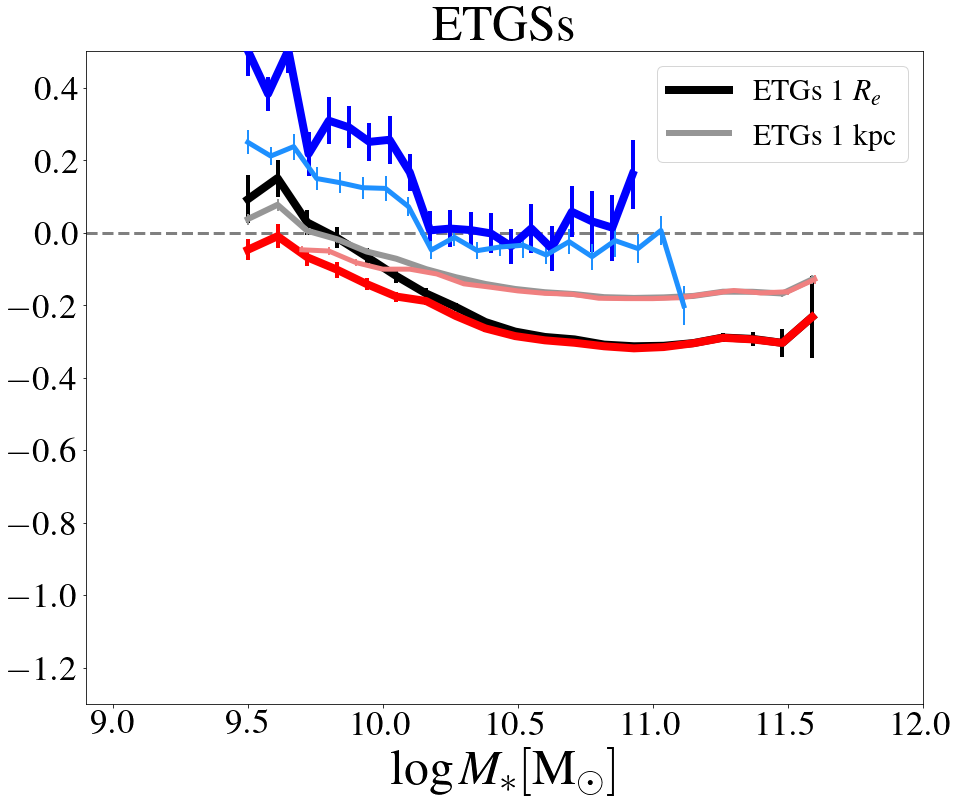

In [316]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi early mean  Re  VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, zorder=3, color ='black', lw=8,  label=r'ETGs 1 $R_e$')
plt.errorbar(gradgiearly_mean_bins[:-1], stat_gradgi_early_mean, yerr=stat_gradgi_early_std/np.sqrt(stat_gradgi_early_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=4)

plt.plot(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, zorder=3, color ='red', lw=8)
plt.errorbar(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, yerr=stat_gradgi_red_early_std/np.sqrt(stat_gradgi_red_early_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=4)

plt.plot(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, zorder=3, color ='blue', lw=8)
plt.errorbar(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, yerr=stat_gradgi_blue_early_std/np.sqrt(stat_gradgi_blue_early_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=4)




plt.plot(gradgiearlyS1_mean_bins[:-1], stat_gradgiS1_early_mean, zorder=3, color ='#969696', lw=6,  label=r'ETGs 1 kpc')
plt.errorbar(gradgiearlyS1_mean_bins[:-1], stat_gradgiS1_early_mean, yerr=stat_gradgiS1_early_std/np.sqrt(stat_gradgiS1_early_count+1), zorder=3, xerr=None, ls='None', ecolor='#969696', elinewidth=2)


plt.plot(gradgiearly_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_early_mean, zorder=3, color ='lightcoral', lw=5)
plt.errorbar(gradgiearly_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_early_mean, yerr=stat_gradgi_kpc_red_early_std/np.sqrt(stat_gradgi_kpc_red_early_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=2)

plt.plot(gradgiearly_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_early_mean, zorder=3, color ='dodgerblue', lw=5)
plt.errorbar(gradgiearly_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_early_mean, yerr=stat_gradgi_kpc_blue_early_std/np.sqrt(stat_gradgi_kpc_blue_early_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=2)



x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)
# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.title(r'ETGSs')
# plt.ylabel(r'colour gradient ', fontsize=40)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msd_early_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


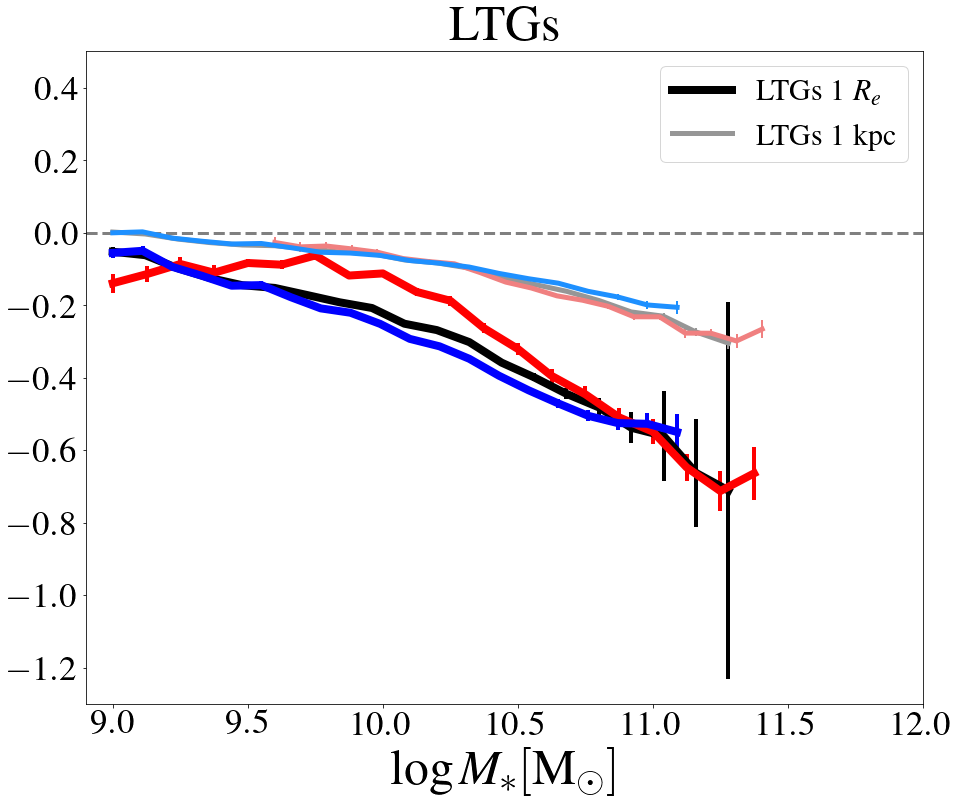

In [236]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr late VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, zorder=3, color ='black', lw=8,  label=r'LTGs 1 $R_e$')
plt.errorbar(gradgrlate_mean_bins[:-1], stat_gradgr_late_mean, yerr=stat_gradgr_late_std/np.sqrt(stat_gradgr_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=4)

plt.plot(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, zorder=3, color ='red', lw=8)
plt.errorbar(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, yerr=stat_gradgr_red_late_std/np.sqrt(stat_gradgr_red_late_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=4)

plt.plot(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, zorder=3, color ='blue', lw=8)
plt.errorbar(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, yerr=stat_gradgr_blue_late_std/np.sqrt(stat_gradgr_blue_late_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=4)


plt.plot(gradgrlateS1_mean_bins[:-1], stat_gradgrS1_late_mean, zorder=3, color ='#969696', lw=5,  label=r'LTGs 1 kpc ')
plt.errorbar(gradgrlateS1_mean_bins[:-1], stat_gradgrS1_late_mean, yerr=stat_gradgrS1_late_std/np.sqrt(stat_gradgrS1_late_count), zorder=3, xerr=None, ls='None', ecolor='#969696', elinewidth=2)

plt.plot(gradgrlate_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_late_mean, zorder=3, color ='lightcoral', lw=5)
plt.errorbar(gradgrlate_kpc_red_mean_bins[:-1], stat_gradgr_kpc_red_late_mean, yerr=stat_gradgr_kpc_red_late_std/np.sqrt(stat_gradgr_kpc_red_late_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=2)

plt.plot(gradgrlate_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_late_mean, zorder=3, color ='dodgerblue', lw=5)
plt.errorbar(gradgrlate_kpc_blue_mean_bins[:-1], stat_gradgr_kpc_blue_late_mean, yerr=stat_gradgr_kpc_blue_late_std/np.sqrt(stat_gradgr_kpc_blue_late_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=2)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.title(r'LTGs', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_Msd_late_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

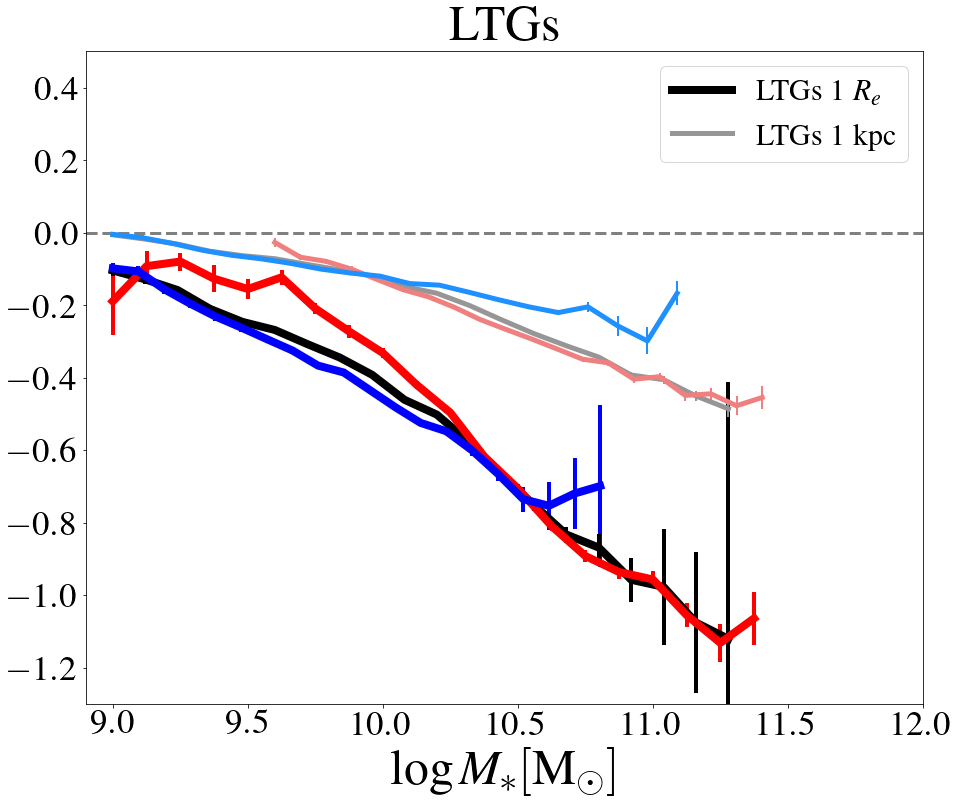

In [317]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi late VS Ms_d diff Re
logMs= np.linspace(8,12)

plt.plot(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, zorder=3, color ='black', lw=8,  label=r'LTGs 1 $R_e$')
plt.errorbar(gradgilate_mean_bins[:-1], stat_gradgi_late_mean, yerr=stat_gradgi_late_std/np.sqrt(stat_gradgi_late_count+1), zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=4)

plt.plot(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, zorder=3, color ='red', lw=8)
plt.errorbar(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, yerr=stat_gradgi_red_late_std/np.sqrt(stat_gradgi_red_late_count+1),  xerr=None, ls='None', ecolor='red', elinewidth=4)

plt.plot(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, zorder=3, color ='blue', lw=8)
plt.errorbar(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, yerr=stat_gradgi_blue_late_std/np.sqrt(stat_gradgi_blue_late_count+1),  xerr=None, ls='None', ecolor='blue', elinewidth=4)


plt.plot(gradgilateS1_mean_bins[:-1], stat_gradgiS1_late_mean, zorder=3, color ='#969696', lw=5, label=r'LTGs 1 kpc ')
plt.errorbar(gradgilateS1_mean_bins[:-1], stat_gradgiS1_late_mean, yerr=stat_gradgiS1_late_std/np.sqrt(stat_gradgiS1_late_count), zorder=3, xerr=None, ls='None', ecolor='#969696', elinewidth=2)

plt.plot(gradgilate_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_late_mean, zorder=3, color ='lightcoral', lw=5)
plt.errorbar(gradgilate_kpc_red_mean_bins[:-1], stat_gradgi_kpc_red_late_mean, yerr=stat_gradgi_kpc_red_late_std/np.sqrt(stat_gradgi_kpc_red_late_count+1),  xerr=None, ls='None', ecolor='lightcoral', elinewidth=2)

plt.plot(gradgilate_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_late_mean, zorder=3, color ='dodgerblue', lw=5)
plt.errorbar(gradgilate_kpc_blue_mean_bins[:-1], stat_gradgi_kpc_blue_late_mean, yerr=stat_gradgi_kpc_blue_late_std/np.sqrt(stat_gradgi_kpc_blue_late_count+1),  xerr=None, ls='None', ecolor='dodgerblue', elinewidth=2)


x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='--', lw=3)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.title(r'LTGs', fontsize=50)

#set axis limits
plt.ylim(-1.3, 0.5)
plt.xlim(8.9,12)


#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_Msd_late_re.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [238]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

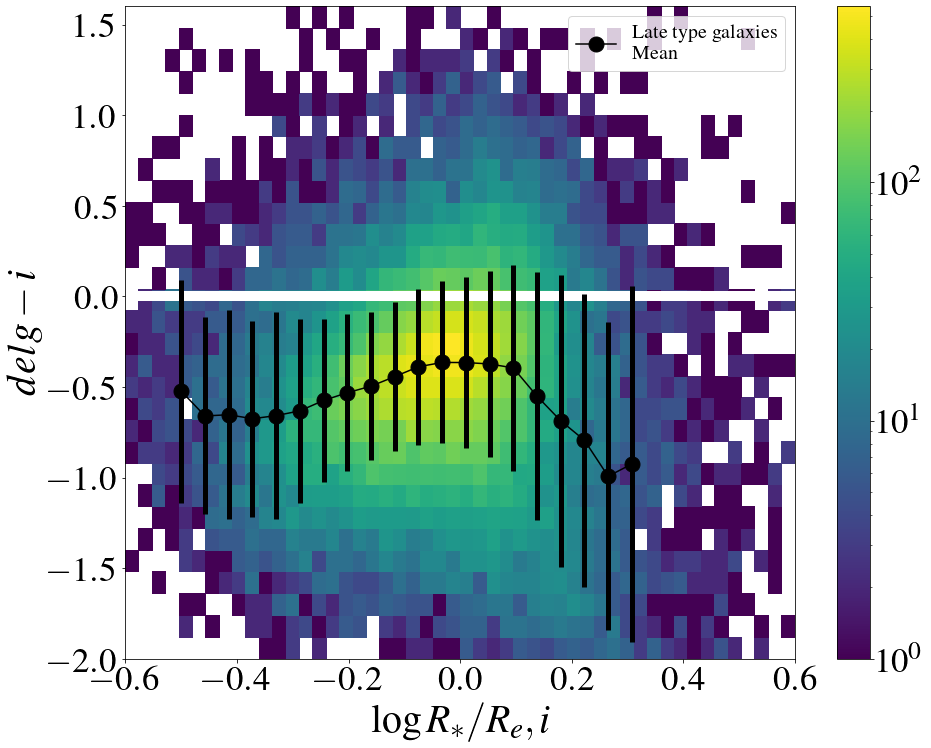

In [239]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi  1 Re  VS ratio late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(r_i_d_late), gradgi_late, bins=(50,30), range=[[-0.6,0.6],[-2.0,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilaterat_mean_bins[:-1], stat_gradgirat_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgilaterat_mean_bins[:-1], stat_gradgirat_late_mean, yerr=stat_gradgirat_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels


plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2, 1.6)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_ratdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

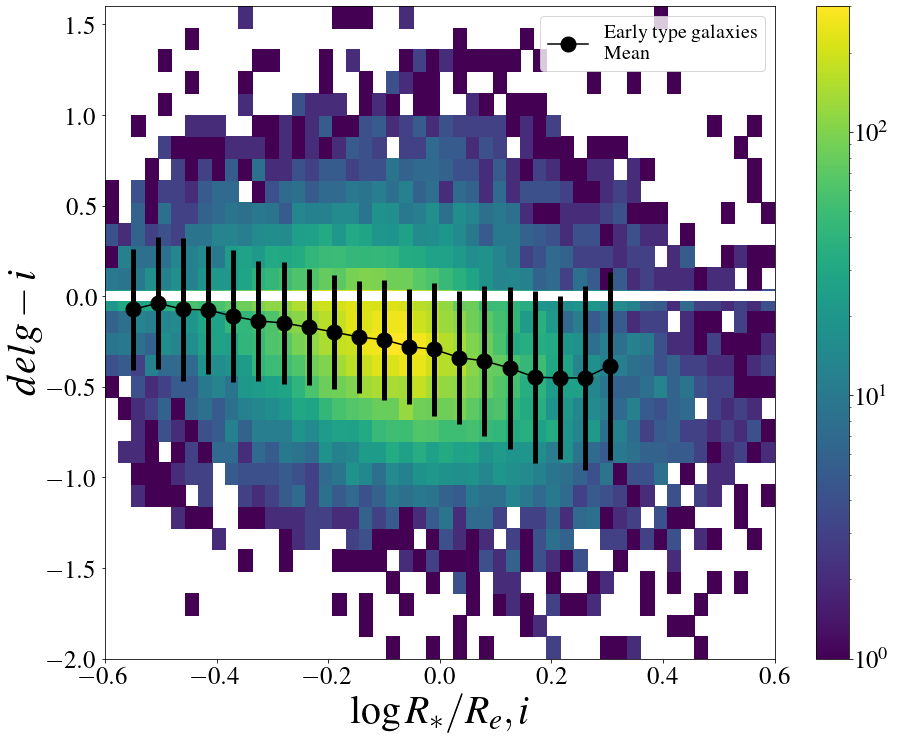

In [240]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi  1 Re  VS ratio early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(r_i_d_early), gradgi_early,  bins=(50,30), range=[[-0.6,0.6],[-2.0,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearlyrat_mean_bins[:-1], stat_gradgirat_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgiearlyrat_mean_bins[:-1], stat_gradgirat_early_mean, yerr=stat_gradgirat_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2, 1.6)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_ratdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

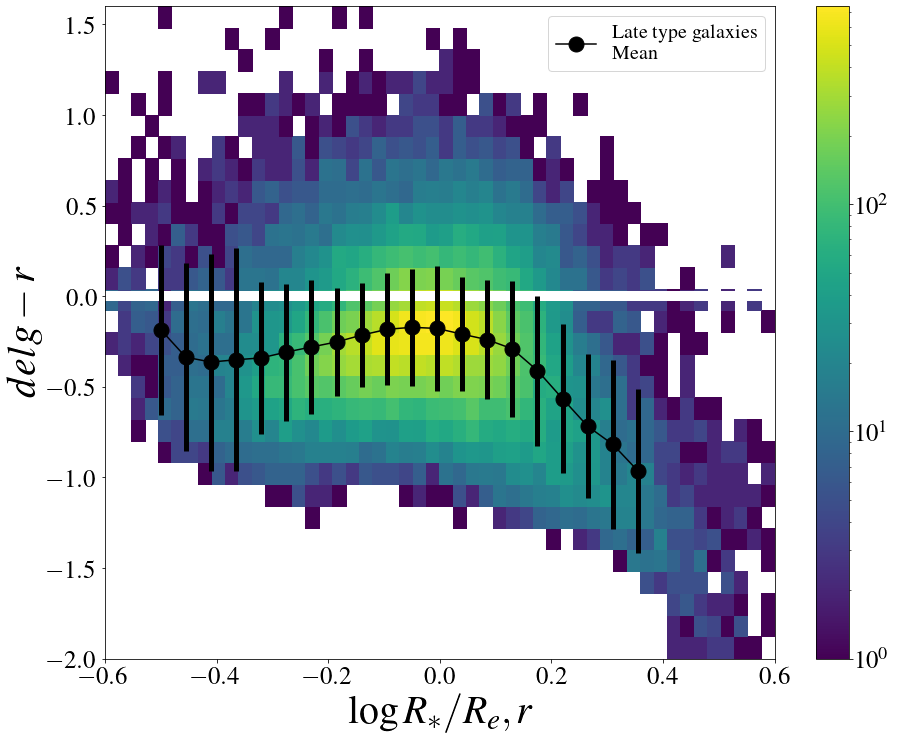

In [241]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  ratio late  Diamond
logMs= np.linspace(8,12)
plt.hist2d( np.log10(r_d_late), gradgr_late, bins=(50,30), range=[[-0.6,0.6],[-2.0,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlaterat_mean_bins[:-1], stat_gradgrrat_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgrlaterat_mean_bins[:-1], stat_gradgrrat_late_mean, yerr=stat_gradgrrat_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2, 1.6)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_ratdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

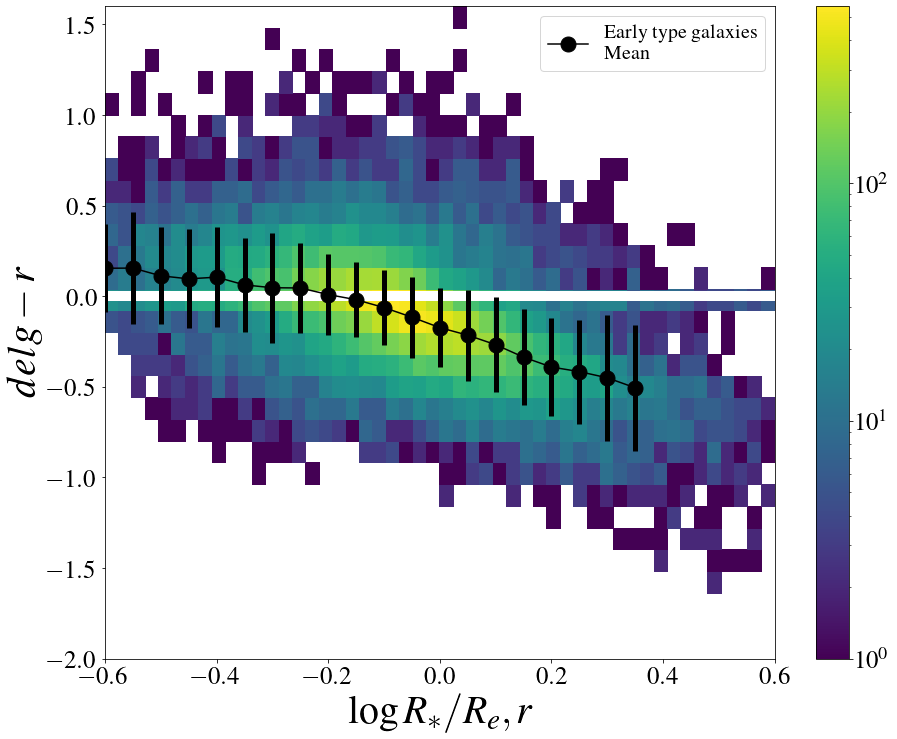

In [242]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS ratio early  Diamond
logMs= np.linspace(8,12)
plt.hist2d( np.log10(r_d_early), gradgr_early, bins=(50,30), range=[[-0.6,0.6],[-2.0,1.6]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearlyrat_mean_bins[:-1], stat_gradgrrat_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgrearlyrat_mean_bins[:-1], stat_gradgrrat_early_mean, yerr=stat_gradgrrat_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2, 1.6)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_ratdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

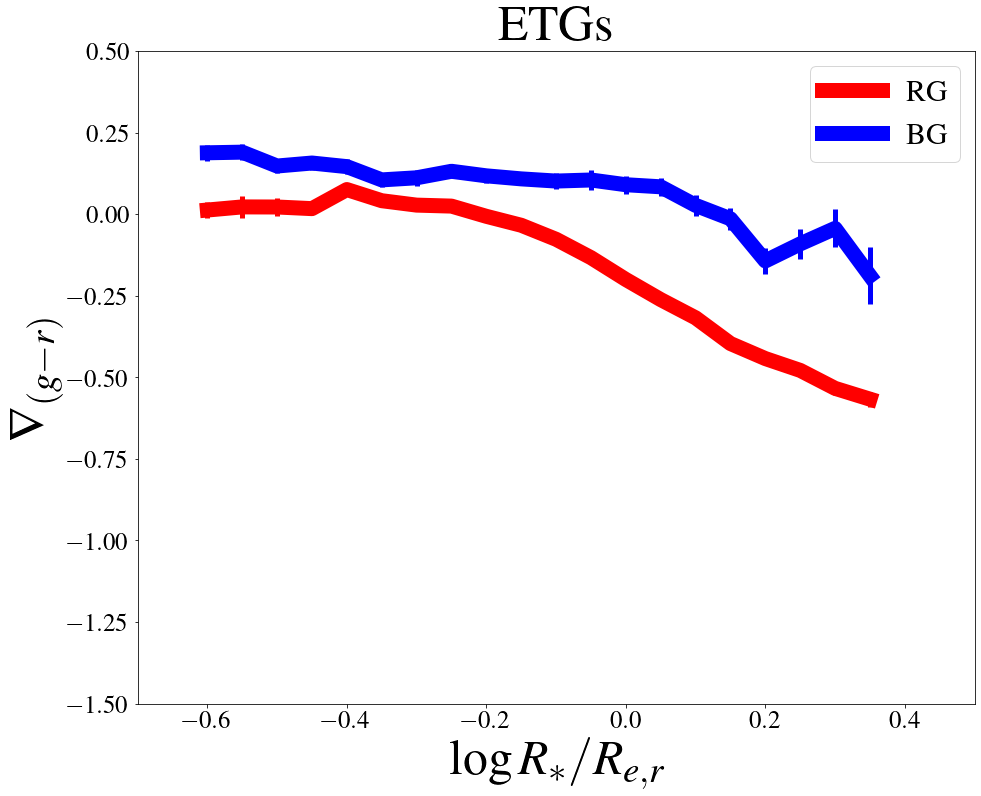

In [243]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS ratio early  red and blue 

plt.plot(gradgrearlyrat_red_mean_bins[:-1], stat_gradgrrat_early_red_mean, zorder=3, color ='red', lw=15, label=r'RG')
plt.errorbar(gradgrearlyrat_red_mean_bins[:-1], stat_gradgrrat_early_red_mean, yerr=stat_gradgrrat_early_red_std/np.sqrt(stat_gradgrrat_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.plot(gradgrearlyrat_blue_mean_bins[:-1], stat_gradgrrat_early_blue_mean, zorder=3, color ='blue',lw=15,  label=r'BG ')
plt.errorbar(gradgrearlyrat_blue_mean_bins[:-1], stat_gradgrrat_early_blue_mean, yerr=stat_gradgrrat_early_blue_std/np.sqrt(stat_gradgrrat_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_{e,r}$', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)
plt.title(r'ETGs', fontsize=50)


#set axis limits
plt.ylim(-1.5, 0.5)
plt.xlim(-0.7,0.5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_ratdearly_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

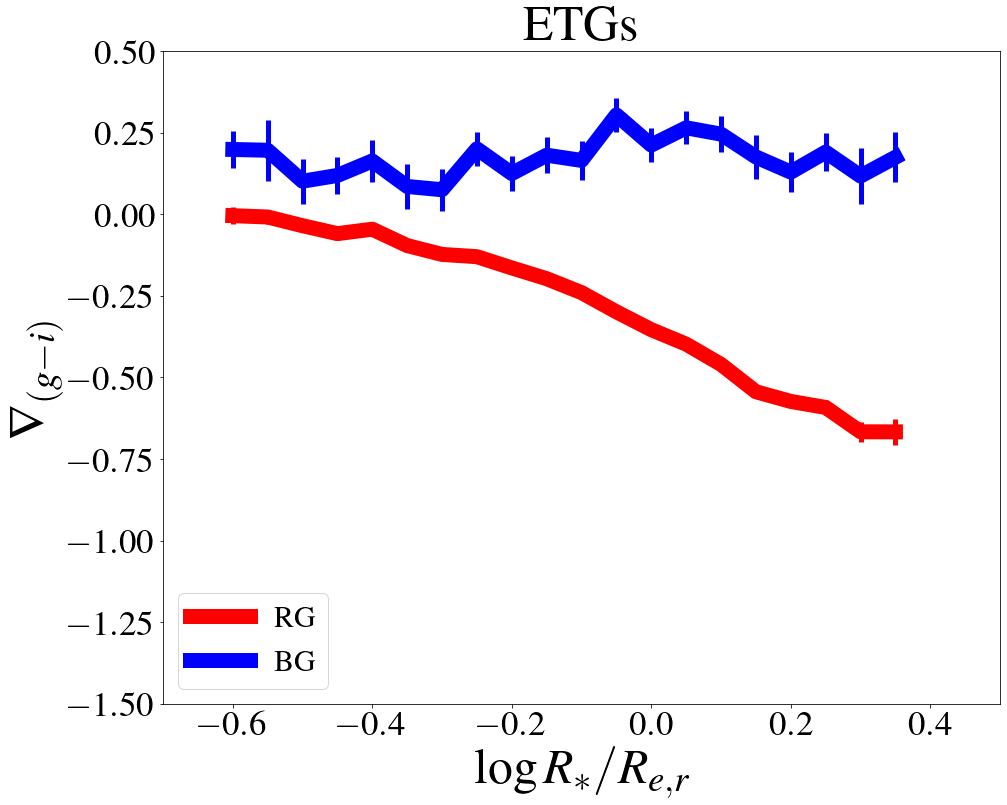

In [366]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS ratio early  red and blue 

plt.plot(gradgiearlyrat_red_mean_bins[:-1], stat_gradgirat_early_red_mean, zorder=3, color ='red', lw=15, label=r'RG')
plt.errorbar(gradgiearlyrat_red_mean_bins[:-1], stat_gradgirat_early_red_mean, yerr=stat_gradgirat_early_red_std/np.sqrt(stat_gradgirat_early_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.plot(gradgiearlyrat_blue_mean_bins[:-1], stat_gradgirat_early_blue_mean, zorder=3, color ='blue',lw=15,  label=r'BG ')
plt.errorbar(gradgiearlyrat_blue_mean_bins[:-1], stat_gradgirat_early_blue_mean, yerr=stat_gradgirat_early_blue_std/np.sqrt(stat_gradgirat_early_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_{e,r}$', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)
plt.title(r'ETGs', fontsize=50)


#set axis limits
plt.ylim(-1.5, 0.5)
plt.xlim(-0.7,0.5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_ratdearly_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

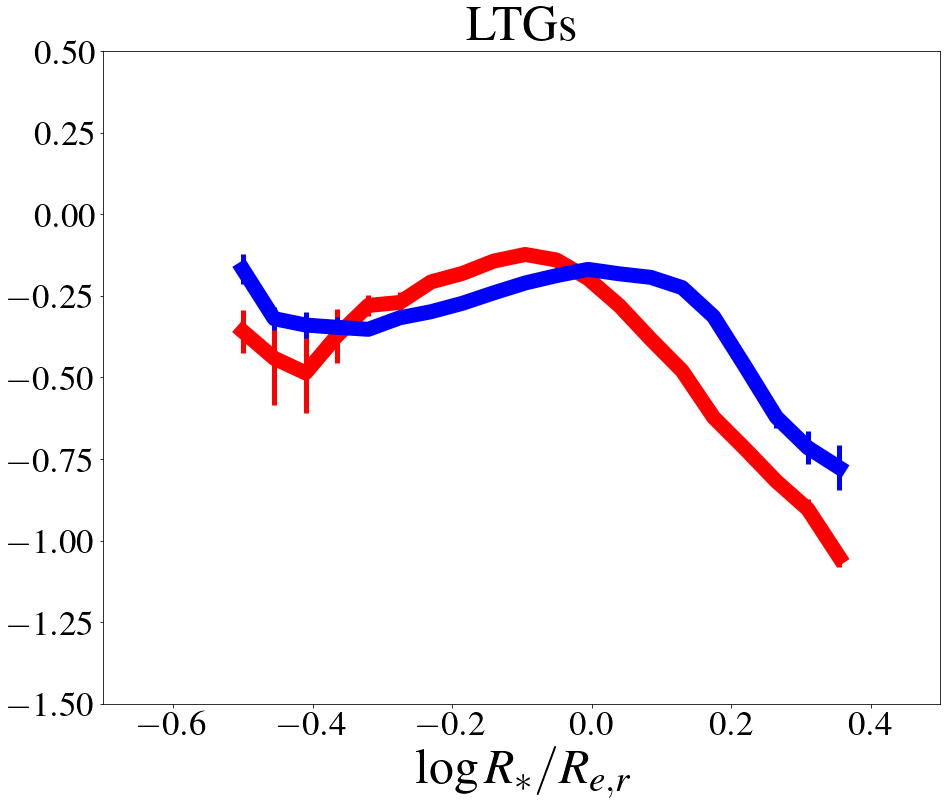

In [244]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS ratio early  red and blue 

plt.plot(gradgrlaterat_red_mean_bins[:-1], stat_gradgrrat_late_red_mean, zorder=3, color ='red',  lw=15, label=r'RG')
plt.errorbar(gradgrlaterat_red_mean_bins[:-1], stat_gradgrrat_late_red_mean, yerr=stat_gradgrrat_late_red_std/np.sqrt(stat_gradgrrat_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.plot(gradgrlaterat_blue_mean_bins[:-1], stat_gradgrrat_late_blue_mean, zorder=3, color ='blue',lw=15,   label=r'BG ')
plt.errorbar(gradgrlaterat_blue_mean_bins[:-1], stat_gradgrrat_late_blue_mean, yerr=stat_gradgrrat_late_blue_std/np.sqrt(stat_gradgrrat_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_{e,r}$', fontsize=50)
# plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)
plt.title(r'LTGs', fontsize=50)


#set axis limits
plt.ylim(-1.5, 0.5)
plt.xlim(-0.7,0.5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr_ratdlate_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

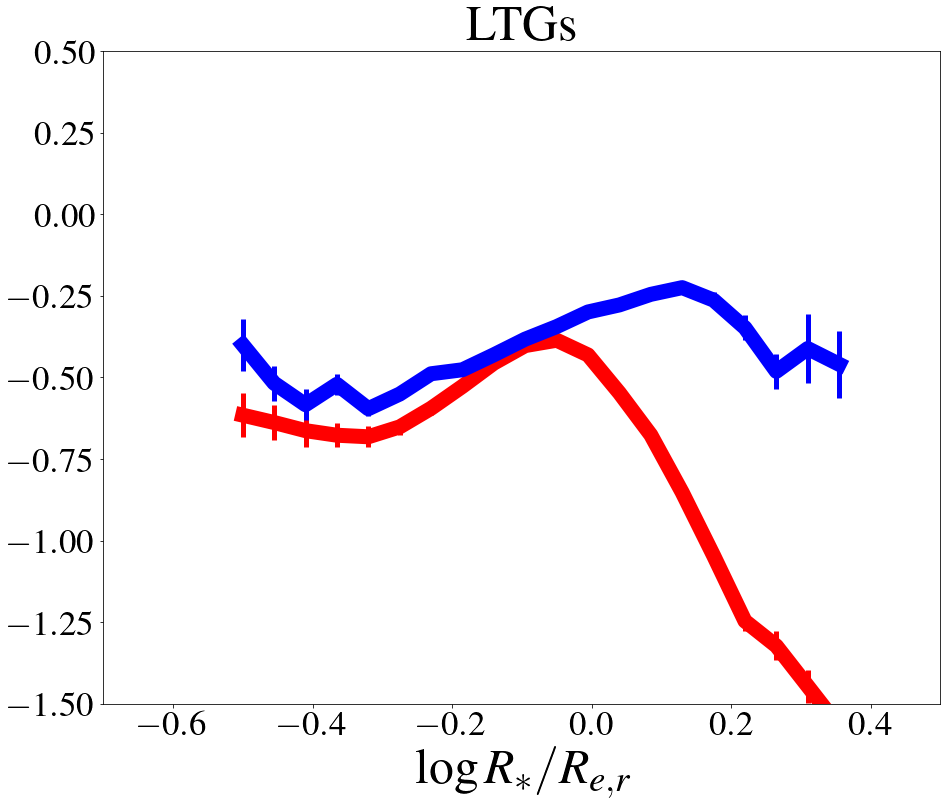

In [367]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr  1 Re  VS ratio early  red and blue 

plt.plot(gradgilaterat_red_mean_bins[:-1], stat_gradgirat_late_red_mean, zorder=3, color ='red',  lw=15, label=r'RG')
plt.errorbar(gradgilaterat_red_mean_bins[:-1], stat_gradgirat_late_red_mean, yerr=stat_gradgirat_late_red_std/np.sqrt(stat_gradgirat_late_red_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.plot(gradgilaterat_blue_mean_bins[:-1], stat_gradgirat_late_blue_mean, zorder=3, color ='blue',lw=15,   label=r'BG ')
plt.errorbar(gradgilaterat_blue_mean_bins[:-1], stat_gradgirat_late_blue_mean, yerr=stat_gradgirat_late_blue_std/np.sqrt(stat_gradgirat_late_blue_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)

x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_{e,r}$', fontsize=50)
# plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)
plt.title(r'LTGs', fontsize=50)


#set axis limits
plt.ylim(-1.5, 0.5)
plt.xlim(-0.7,0.5)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi_ratdlate_mean.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

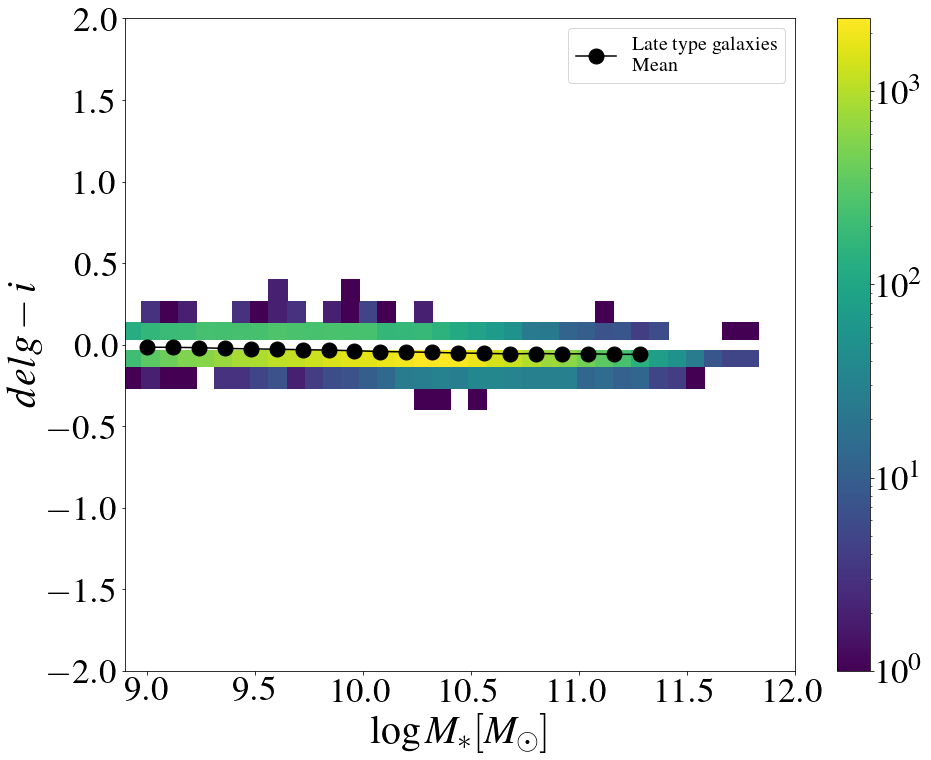

In [245]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 2 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_late), gradgi2_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilate2_mean_bins[:-1], stat_gradgi2_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgilate2_mean_bins[:-1], stat_gradgi2_late_mean, yerr=stat_gradgi2_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi2_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

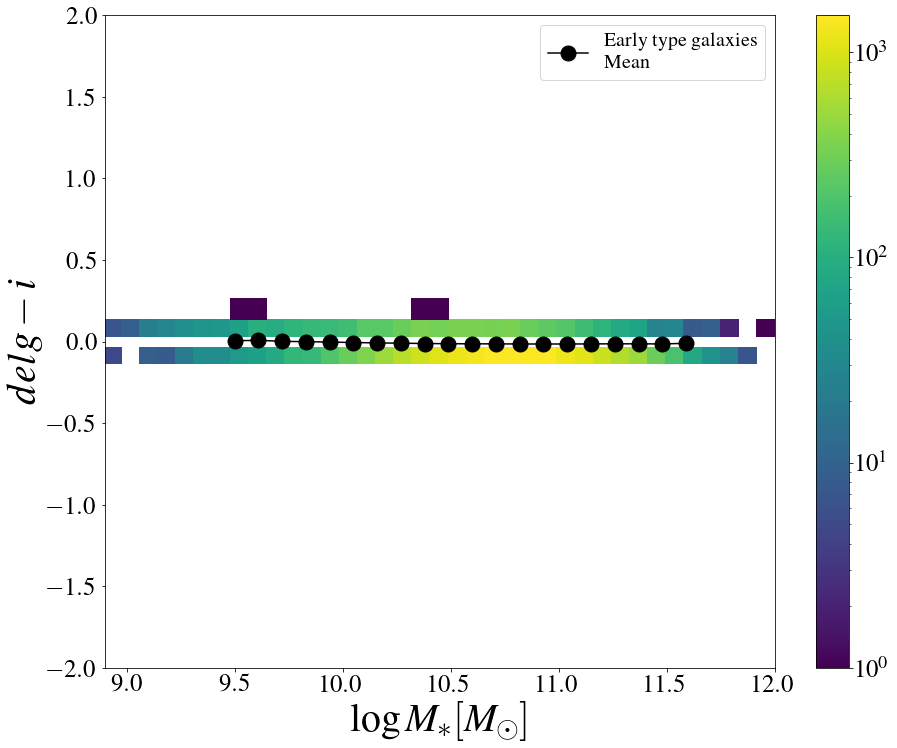

In [246]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 2 Re VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_early), gradgi2_early, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearly2_mean_bins[:-1], stat_gradgi2_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgiearly2_mean_bins[:-1], stat_gradgi2_early_mean, yerr=stat_gradgi2_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi2_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

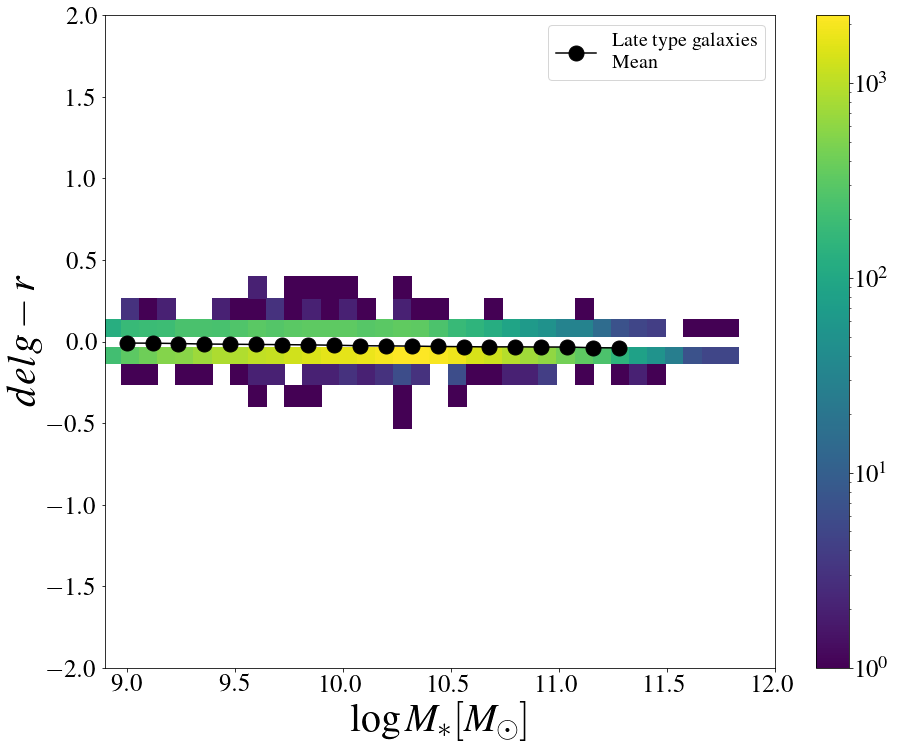

In [247]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 2 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_late), gradgr2_late, bins=(50,30), range=[[7.8,12],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate2_mean_bins[:-1], stat_gradgr2_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgrlate2_mean_bins[:-1], stat_gradgr2_late_mean, yerr=stat_gradgr2_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr2_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

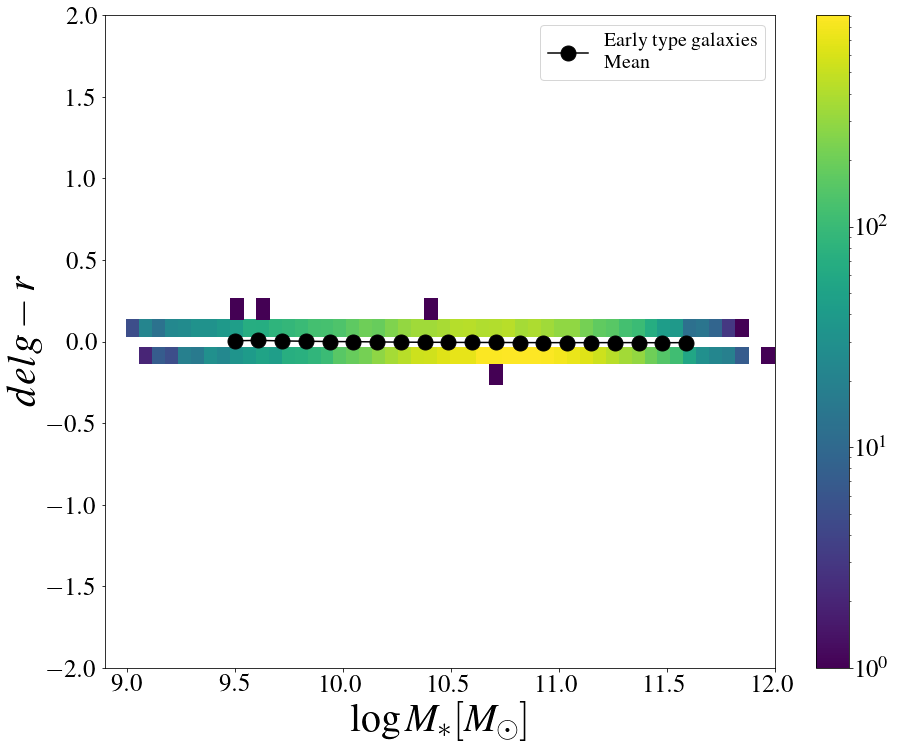

In [248]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 2 Re VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_d_early), gradgr2_early, bins=(50,30), range=[[9.0,12],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearly2_mean_bins[:-1], stat_gradgr2_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgrearly2_mean_bins[:-1], stat_gradgr2_early_mean, yerr=stat_gradgr2_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr2_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

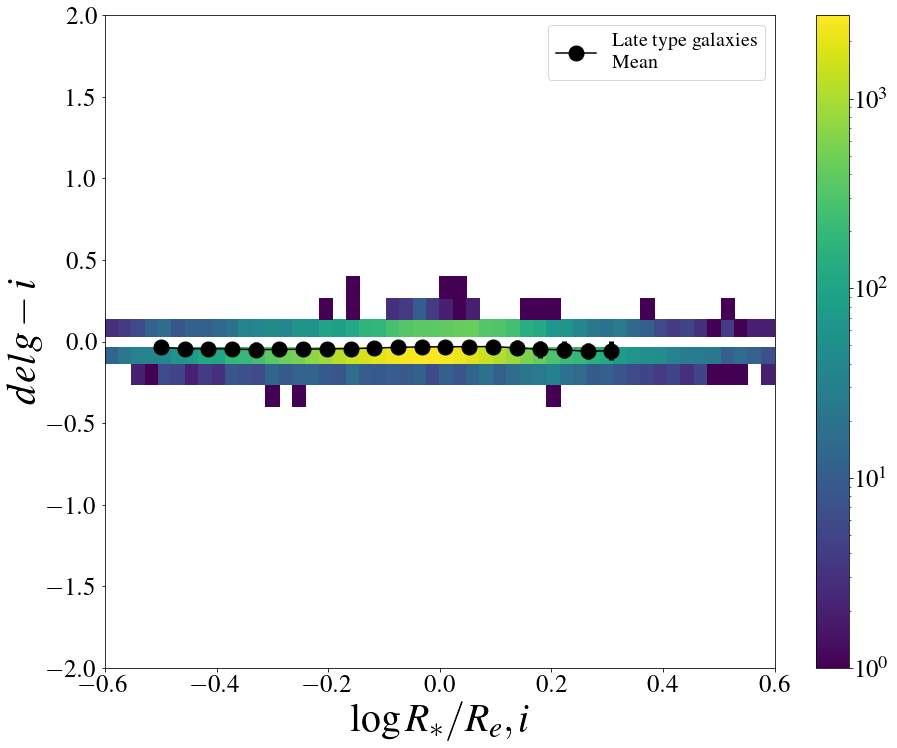

In [249]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 2 Re VS ratio late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(r_i_d_late), gradgi2_late, bins=(50,30), range=[[-0.6,0.6],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilaterat2_mean_bins[:-1], stat_gradgirat2_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgilaterat2_mean_bins[:-1], stat_gradgirat2_late_mean, yerr=stat_gradgirat2_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels


plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi2_ratdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

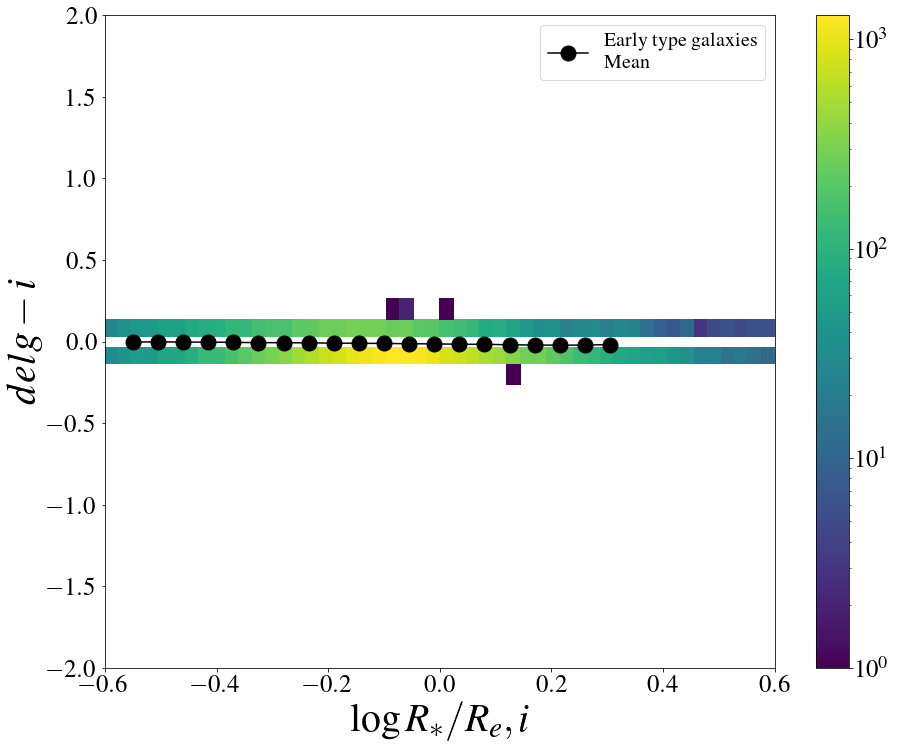

In [250]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient 2 Re gi VS ratio early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(r_i_d_early), gradgi2_early,  bins=(50,30), range=[[-0.6,0.6],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearlyrat2_mean_bins[:-1], stat_gradgirat2_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgiearlyrat2_mean_bins[:-1], stat_gradgirat2_early_mean, yerr=stat_gradgirat2_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgi2_ratdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

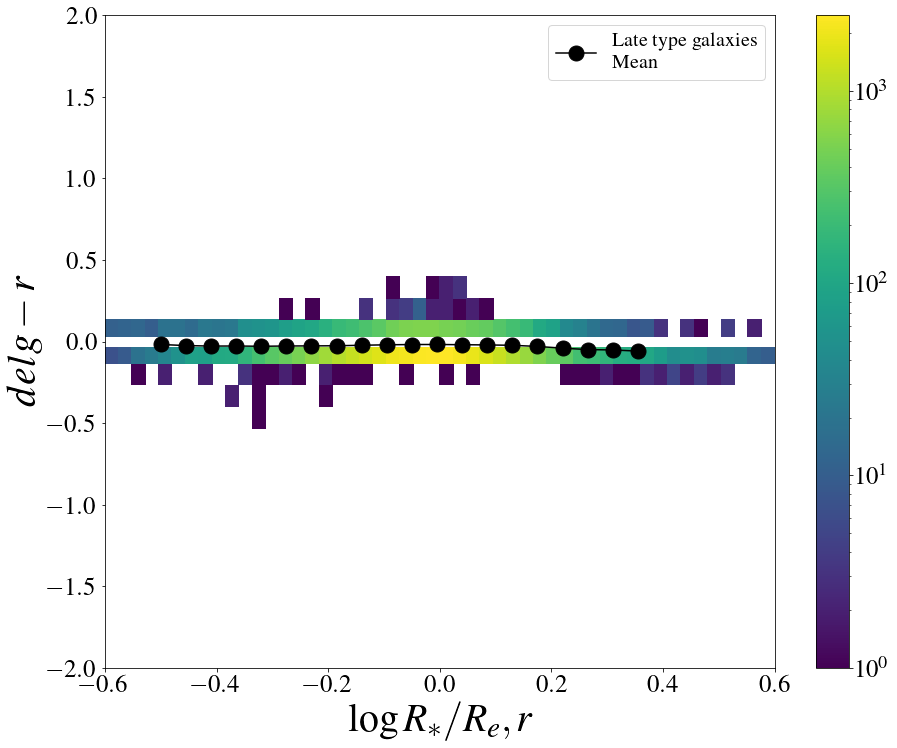

In [251]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 2 Re ratio late  Diamond
logMs= np.linspace(8,12)
plt.hist2d( np.log10(r_d_late), gradgr2_late, bins=(50,30), range=[[-0.6,0.6],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlaterat2_mean_bins[:-1], stat_gradgrrat2_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgrlaterat2_mean_bins[:-1], stat_gradgrrat2_late_mean, yerr=stat_gradgrrat2_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr2_ratdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

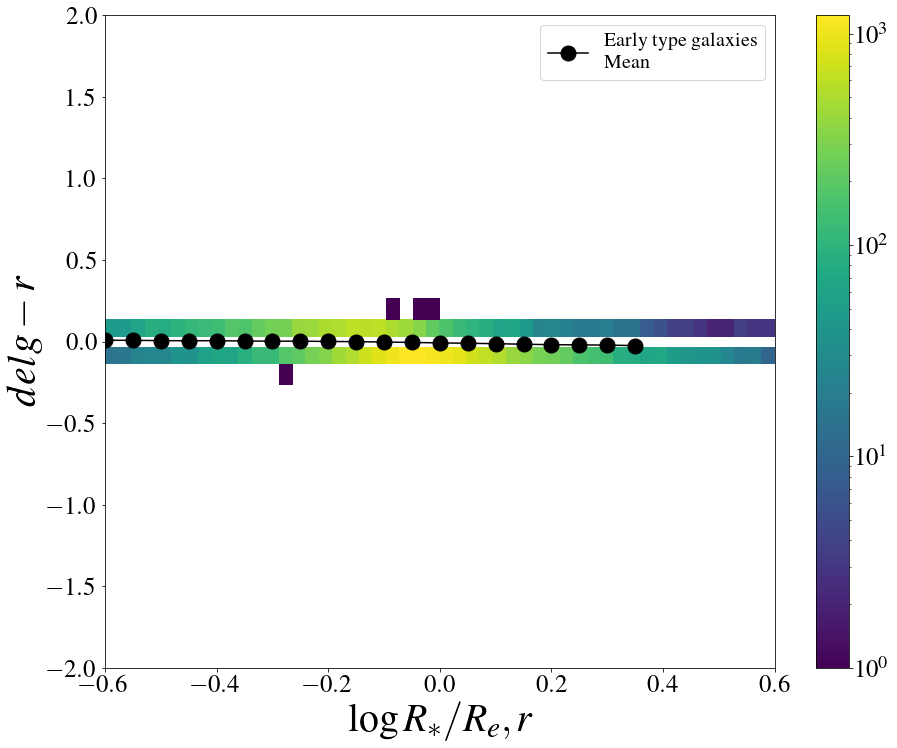

In [252]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 2 Re VS ratio early  Diamond
logMs= np.linspace(8,12)
plt.hist2d( np.log10(r_d_early), gradgr2_early, bins=(50,30), range=[[-0.6,0.6],[-2.0, 2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearlyrat2_mean_bins[:-1], stat_gradgrrat2_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgrearlyrat2_mean_bins[:-1], stat_gradgrrat2_early_mean, yerr=stat_gradgrrat2_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

# #set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgr2_ratdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

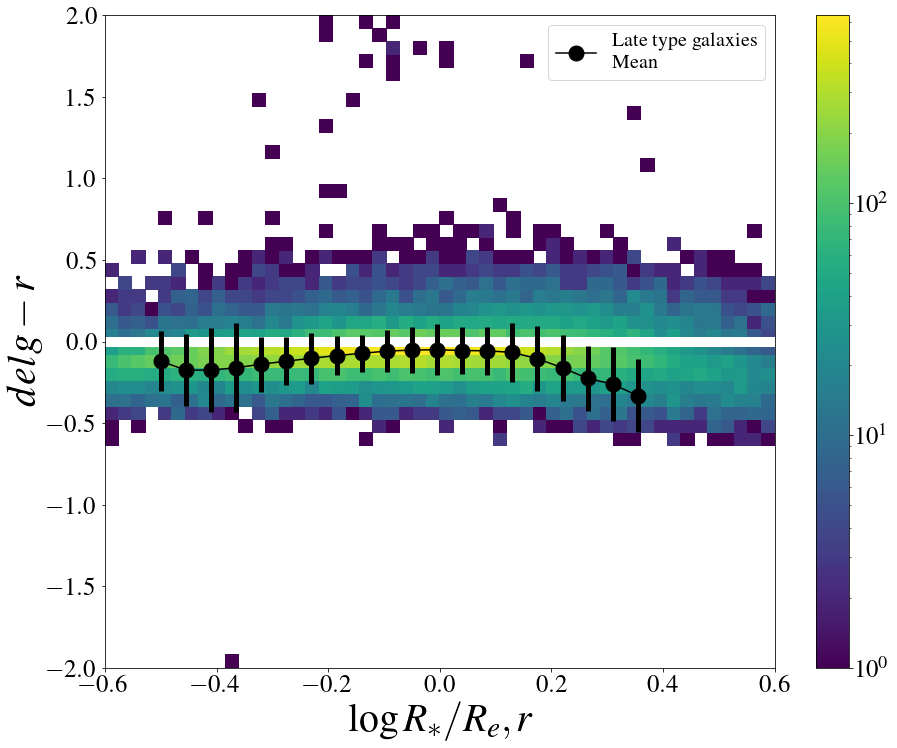

In [253]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient 1 kpc gr late vs ratio
r_kpc= np.linspace(0.01,1, 26992)
plt.hist2d(np.log(r_d_late), gradgrS1_late, zorder=1, bins=(50), range=[[-0.6,0.6],[-2.0, 2.0]], norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlateratS1_mean_bins[:-1], stat_gradgrratS1_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgrlateratS1_mean_bins[:-1], stat_gradgrratS1_late_mean, yerr=stat_gradgrratS1_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgrS1_ratlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

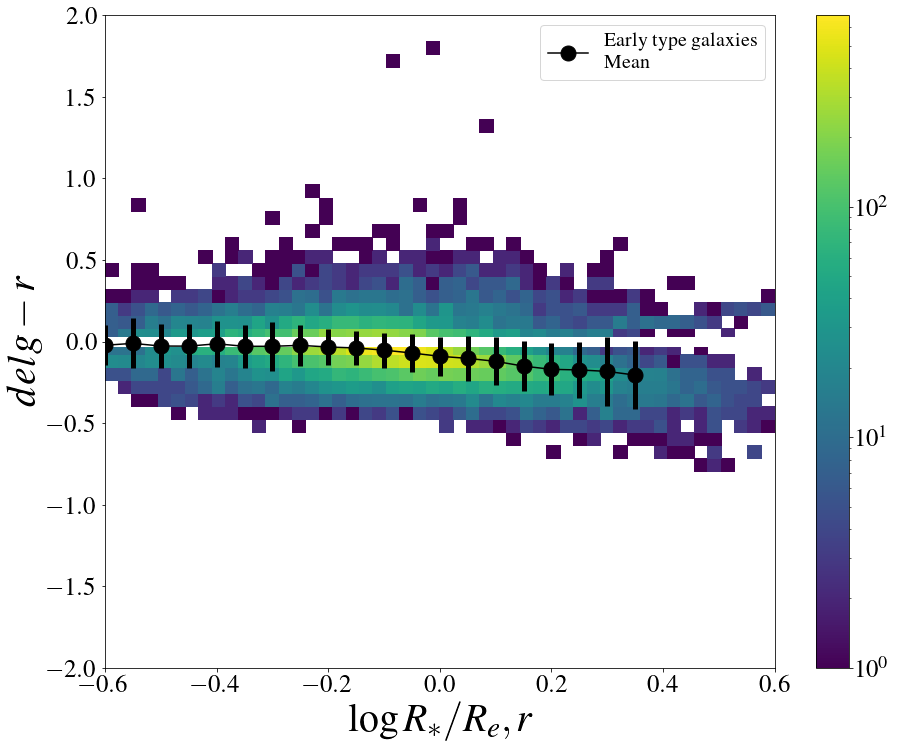

In [254]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 1 kpc early vs ratio
r_kpc= np.linspace(0.01,1, 12881)
plt.hist2d(np.log10(r_d_early), gradgrS1_early, zorder=1, bins=(50), range=[[-0.6,0.6],[-2.0, 2.0]], norm=LogNorm(), cmap='viridis', label='Early type')
plt.plot(gradgrearlyratS1_mean_bins[:-1], stat_gradgrratS1_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgrearlyratS1_mean_bins[:-1], stat_gradgrratS1_early_mean, yerr=stat_gradgrratS1_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgrS1_ratearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

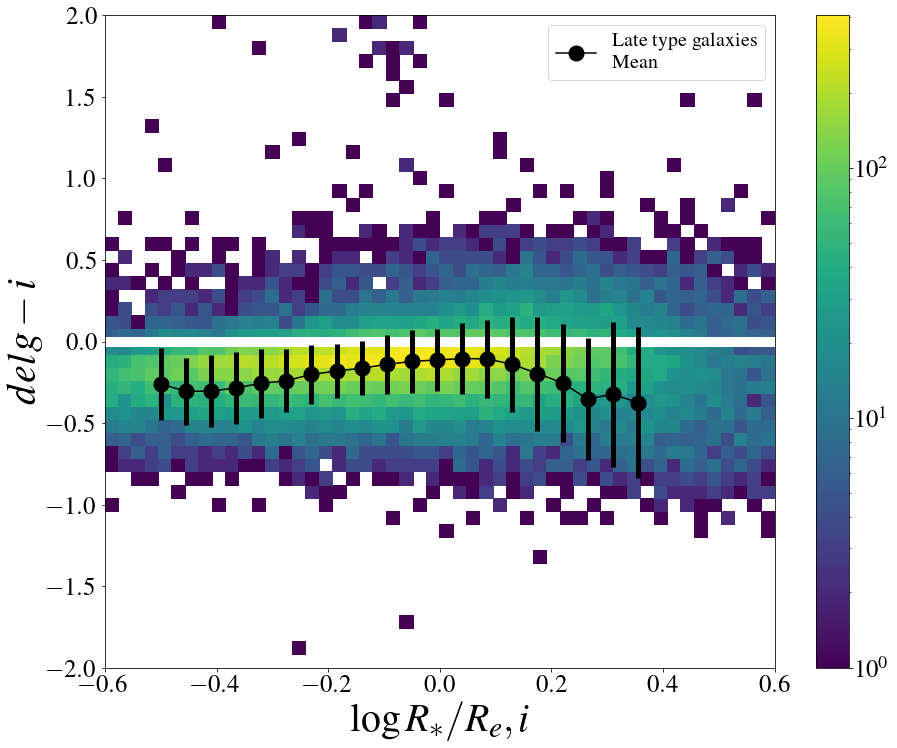

In [255]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient 1 kpc gi late vs ratio
r_kpc= np.linspace(0.01,1, 26992)
plt.hist2d(np.log(r_i_d_late), gradgiS1_late, zorder=1, bins=(50), range=[[-0.6,0.6],[-2.0, 2.0]], norm=LogNorm(), cmap='viridis')
plt.plot(gradgilateratS1_mean_bins[:-1], stat_gradgiratS1_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgilateratS1_mean_bins[:-1], stat_gradgiratS1_late_mean, yerr=stat_gradgiratS1_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgiS1_ratlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

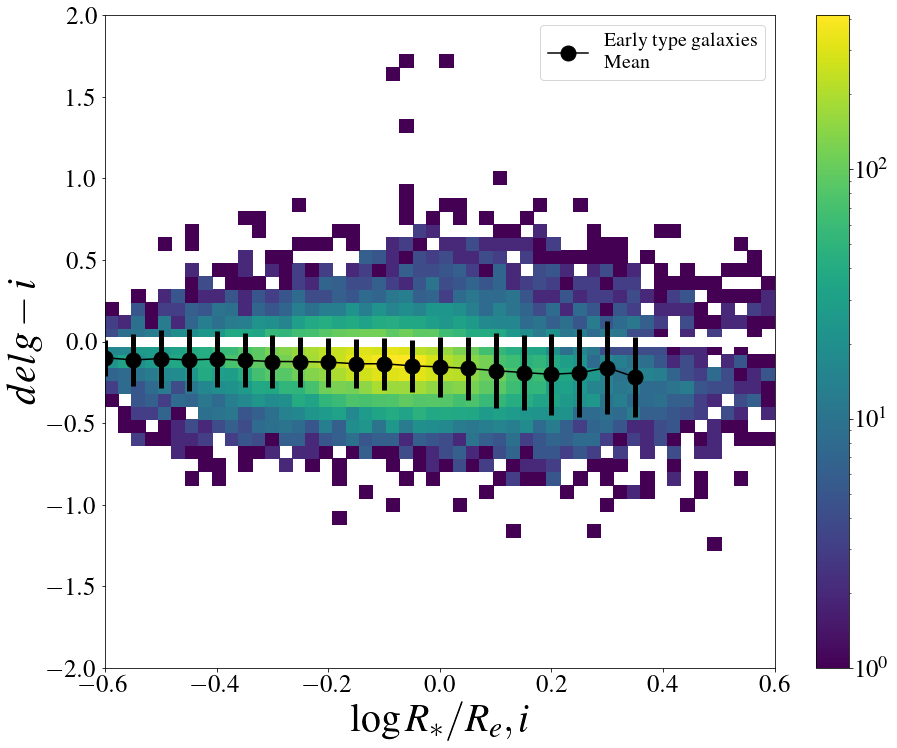

In [256]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gi 1 kpc early vs ratio
r_kpc= np.linspace(0.01,1, 12881)
plt.hist2d(np.log10(r_i_d_early), gradgiS1_early, zorder=1, bins=(50), range=[[-0.6,0.6],[-2.0, 2.0]], norm=LogNorm(), cmap='viridis', label='Early type')
plt.plot(gradgiearlyratS1_mean_bins[:-1], stat_gradgiratS1_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgiearlyratS1_mean_bins[:-1], stat_gradgiratS1_early_mean, yerr=stat_gradgiratS1_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [-0.6,0.6]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)
# Add axis labels

plt.xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(-0.6,0.6)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgiS1_ratearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

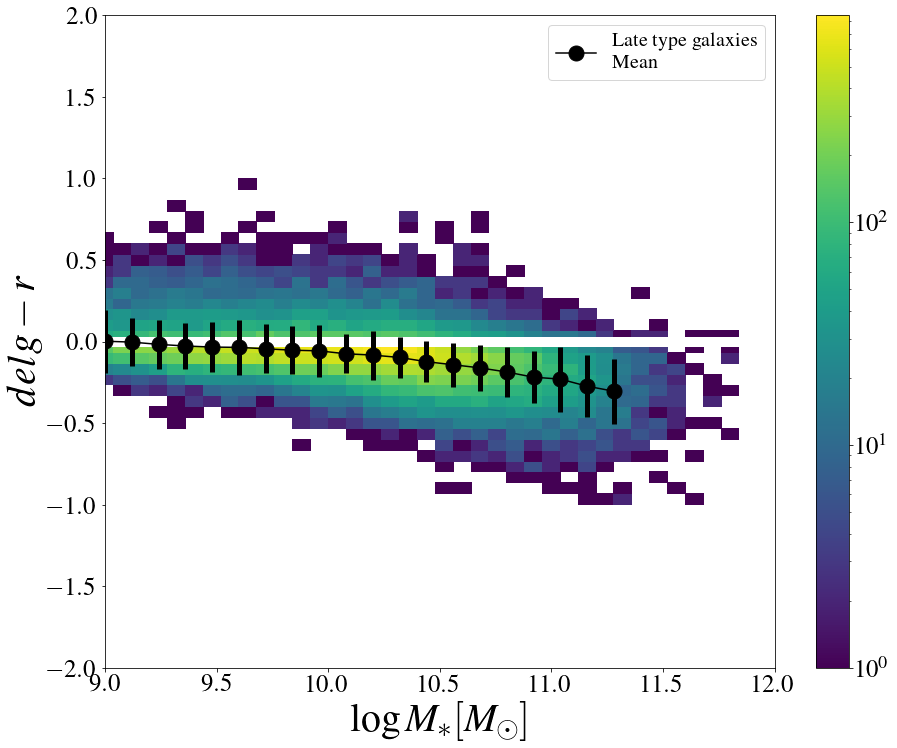

In [257]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 1 kpc vs Ms late  Diamond
r_kpc= np.linspace(0.01,1, 26992)
plt.hist2d(np.log10(Ms_d_late), gradgrS1_late, zorder=1,  bins=(50,30), range=([8.0,12.0],[-1.0,1.0]), norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlateS1_mean_bins[:-1], stat_gradgrS1_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgrlateS1_mean_bins[:-1], stat_gradgrS1_late_mean, yerr=stat_gradgrS1_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgrS1_mslate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

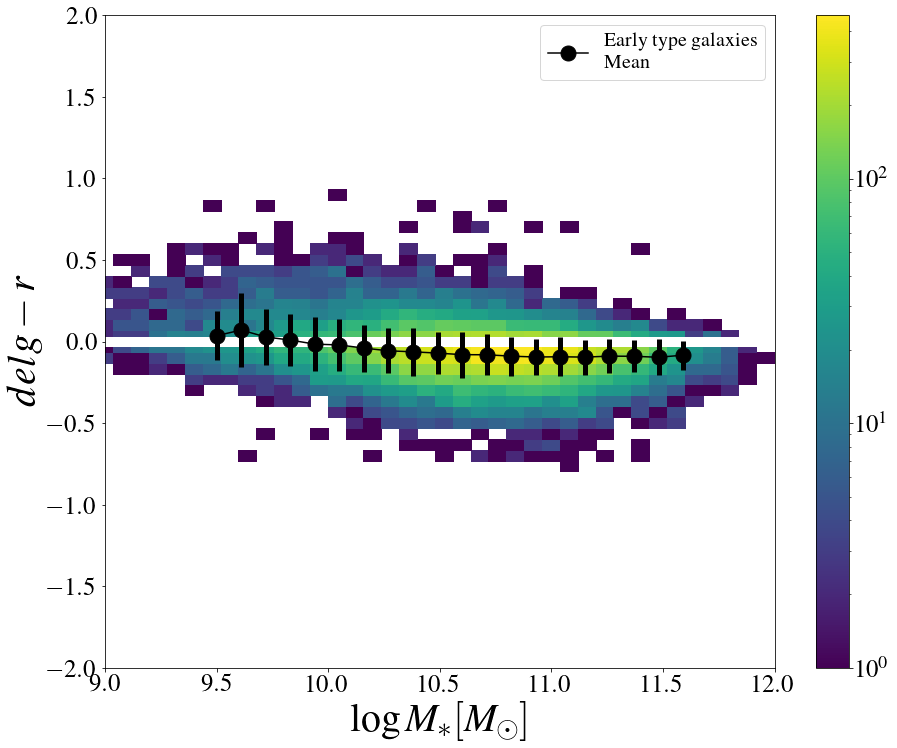

In [258]:
fig, ax= plt.subplots(figsize=(15,12))

# color gradient gr 1 kpc vs MS early  Diamond
r_kpc= np.linspace(0.01,1, 12881)
plt.hist2d( np.log10(Ms_d_early), gradgrS1_early, zorder=1, bins=(50,30), range=([8.0,12.0],[-1.0,1.0]), norm=LogNorm(), cmap='viridis', label='Early type')
plt.plot(gradgrearlyS1_mean_bins[:-1], stat_gradgrS1_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgrearlyS1_mean_bins[:-1], stat_gradgrS1_early_mean, yerr=stat_gradgrS1_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-r$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(9,12.0)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgrS1_msearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

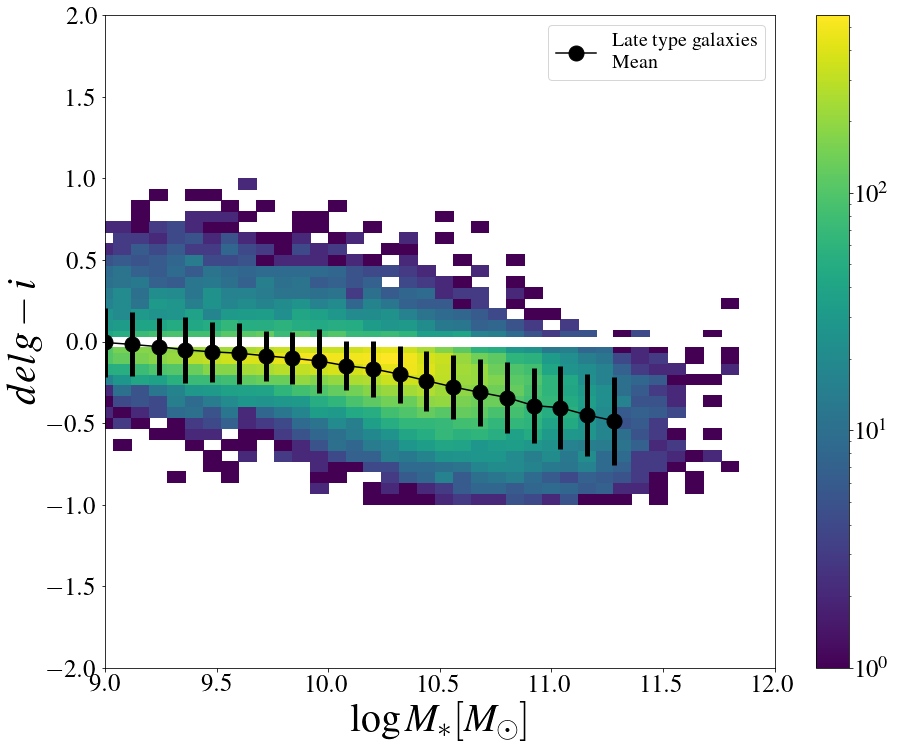

In [259]:
fig, ax= plt.subplots(figsize=(15,12))


# color gradient gr 2 Re ratio late  Diamond
r_kpc= np.linspace(0.01,1, 26992)
plt.hist2d(np.log10(Ms_d_late), gradgiS1_late, zorder=1,  bins=(50,30), range=([8.0,12.0],[-1.0,1.0]), norm=LogNorm(), cmap='viridis')
plt.plot(gradgilateS1_mean_bins[:-1], stat_gradgiS1_late_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Late type galaxies \n Mean ')
plt.errorbar(gradgilateS1_mean_bins[:-1], stat_gradgiS1_late_mean, yerr=stat_gradgiS1_late_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)

# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(9,12)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgiS1_mslate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

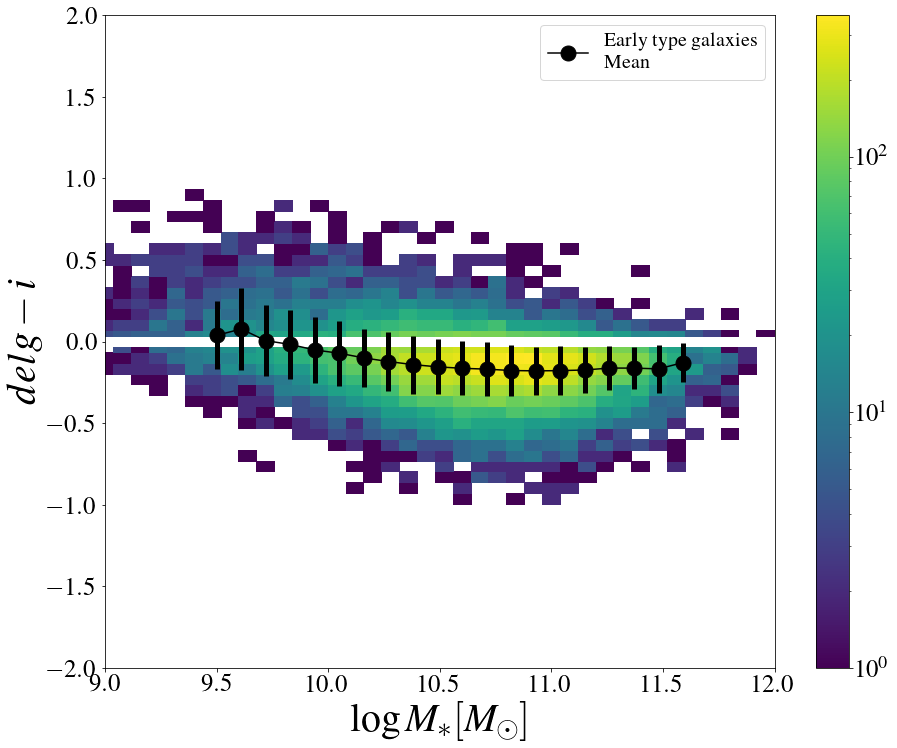

In [260]:
fig, ax= plt.subplots(figsize=(15,12))

# color gradient 1 kpc vs MS early  Diamond
r_kpc= np.linspace(0.01,1, 12881)
plt.hist2d( np.log10(Ms_d_early), gradgiS1_early, zorder=1, bins=(50,30), range=([8.0,12.0],[-1.0,1.0]), norm=LogNorm(), cmap='viridis', label='Early type')
plt.plot(gradgiearlyS1_mean_bins[:-1], stat_gradgiS1_early_mean, zorder=3, color ='black', marker = 'o', markersize= 15,  label='Early type galaxies \n Mean ')
plt.errorbar(gradgiearlyS1_mean_bins[:-1], stat_gradgiS1_early_mean, yerr=stat_gradgiS1_early_std, zorder=3, xerr=None, ls='None', ecolor='black', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)


# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=40)
plt.ylabel(r'$del g-i$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(9,12.0)

#adjust tick label font size
label_size = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=20)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/delgiS1_msearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

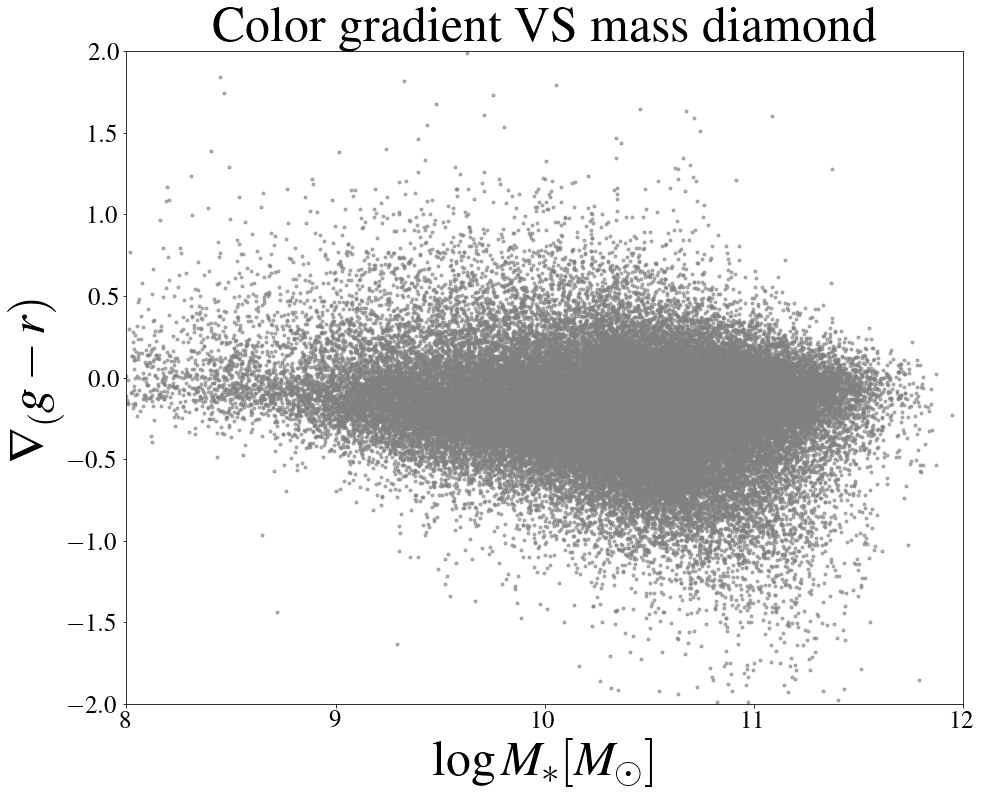

In [261]:
fig, ax= plt.subplots(figsize=(15,12))

plt.scatter(np.log10(Ms_d), gradiente_gr, marker='.', color='gray', alpha=0.6)

plt.title(r'Color gradient VS mass diamond', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_(g-r)$', fontsize=50)

# # #set axis limits
plt.ylim(-2, 2)
plt.xlim(8.0,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/grad_mass_diamond.png',format='png',dpi=200, bbox_inches = 'tight')
plt.show()



In [ ]:
# # Color gradient g-r for early and late type galaxies divided in red and blue galaxies as a function of mass

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)


# ax[0][0].plot(np.log10(Ms_gr_red_late), grad1re_gr_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].plot(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Late type')

# ax[0][1].plot(np.log10(Ms_gr_red_early), grad1re_gr_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].plot(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Early type')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_scater_Ms.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()



In [ ]:
# # Color gradient g-i for early and late type galaxies divided in red and blue galaxies as a function of mass

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)
# ax[0][0].set_ylabel('del g-i', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)


# ax[0][0].plot(np.log10(Ms_gi_red_late), grad1re_gi_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].plot(np.log10(Ms_gi_blue_late), grad1re_gi_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Late type')

# ax[0][1].plot(np.log10(Ms_gi_red_early), grad1re_gi_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].plot(np.log10(Ms_gi_blue_early), grad1re_gi_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Early type')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gi_scater_Ms.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()


In [ ]:
# # Color gradient g-r for early and late type galaxies divided in red and blue galaxies as a function of ratios

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)


# ax[0][0].plot(np.log10(r_gr_red_late), grad1re_gr_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].plot(np.log10(r_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Late type')

# ax[0][1].plot(np.log10(r_gr_red_early), grad1re_gr_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].plot(np.log10(r_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Early type')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_scater_rat.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()



In [ ]:
# # Color gradient g-i for early and late type galaxies divided in red and blue galaxies as a function of ratios

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=30)
# ax[0][0].set_ylabel('del g-i', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log R_{\ast}/R_e,i$', fontsize=30)


# ax[0][0].plot(np.log10(r_gi_red_late), grad1re_gi_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].plot(np.log10(r_gi_blue_late), grad1re_gi_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Late type')

# ax[0][1].plot(np.log10(r_gi_red_early), grad1re_gi_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].plot(np.log10(r_gi_blue_early), grad1re_gi_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Early type')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gi_scater_rat.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()


In [ ]:
# # Color gradient g-r for red and blue late type galaxies as a function of mass

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)


# ax[0][0].plot(np.log10(Ms_gr_red_late), grad1re_gr_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# # ax[0][0].plot(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Red late')

# ax[0][1].plot(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# # ax[0][1].plot(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Blue late')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_late_Ms.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()


In [ ]:
# # Color gradient g-r for  red and blue early  type galaxies as a function of mass

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=30)


# # ax[0][0].plot(np.log10(Ms_gr_red_late), grad1re_gr_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].plot(np.log10(Ms_gr_red_early), grad1re_gr_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][0].set_title('Red early')

# # ax[0][1].plot(np.log10(Ms_gr_red_early), grad1re_gr_red_early ,'.', color='red' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].plot(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Blue early')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_early_Ms.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()

In [ ]:
# # Color gradient g-r for blue and red late galaxies  as a function of ratios

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)


# ax[0][0].plot(np.log10(r_gr_red_late), grad1re_gr_red_late , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# # ax[0][0].plot(np.log10(r_d_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Red late')

# ax[0][1].plot(np.log10(r_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# # ax[0][1].plot(np.log10(r_d_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Blue late')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_late_rat.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()


In [ ]:
# # Color gradient g-r for early red and blue galaxies  as a function of ratios

# fig, ax = plt.subplots(1, 2, figsize=(15,10), sharey='row', squeeze=False)
# fig.subplots_adjust(wspace=0)
# # fig.suptitle('Color gradient g-r', fontsize=20)


# ax[0][0].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)
# ax[0][0].set_ylabel('del g-r', fontsize= 30)
# ax[0][0].set_ylim(-2.0, 2.0)
# ax[0][1].set_xlabel(r'$\log R_{\ast}/R_e,r$', fontsize=30)


# ax[0][0].plot(np.log10(r_gr_red_early), grad1re_gr_red_early , '.',color='red' , marker='.', markersize=2, alpha=0.6)
# # ax[0][0].plot(np.log10(r_gr_blue_late), grad1re_gr_blue_late ,'.', color='blue' , marker='.', markersize=2, alpha=0.6)
# ax[0][0].set_title('Red early')

# ax[0][1].plot(np.log10(r_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# # ax[0][1].plot(np.log10(r_gr_blue_early), grad1re_gr_blue_early ,'.', color='blue' , marker='.', markersize=1, alpha=0.6)
# ax[0][1].set_title('Blue early')
# # ax[0][1].legend(loc='lower right')
# # ax[0][1].set_xlim(0,15)


# label_size = 20
# matplotlib.rcParams['xtick.labelsize'] = 25
# matplotlib.rcParams['ytick.labelsize'] = label_size
# matplotlib.rcParams['axes.titlesize'] = label_size 

# plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gr_early_rat.png',format='pdf',dpi=200, bbox_inches = 'tight')
# plt.show()


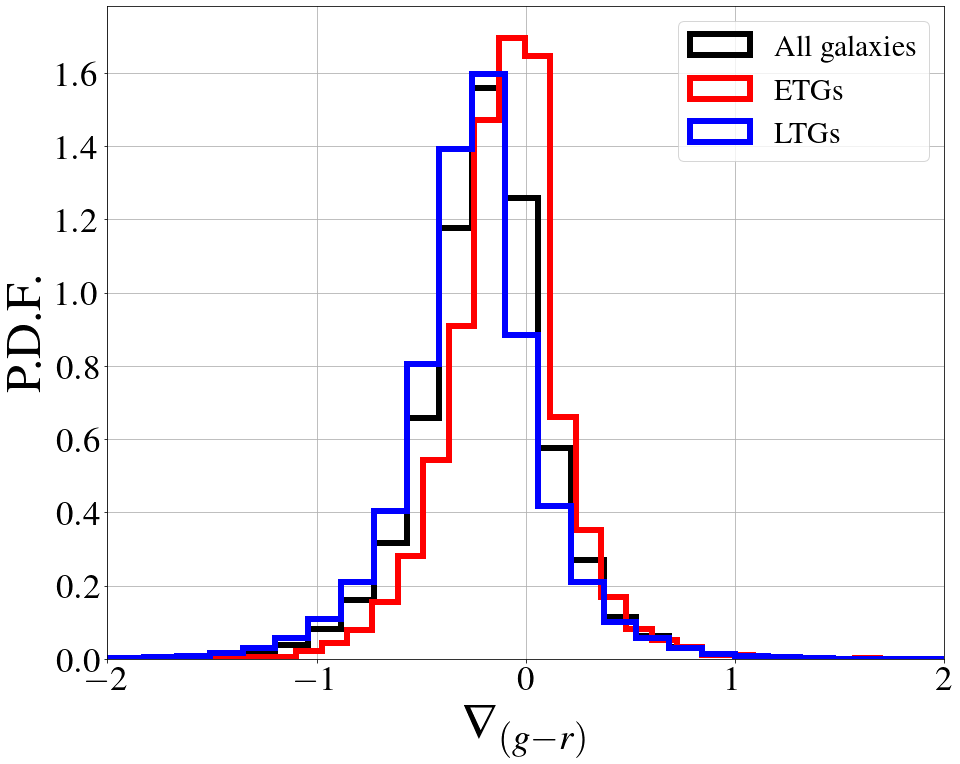

In [262]:
fig, ax= plt.subplots(figsize=(15,12))
# the histogram of the data
plt.hist(gradiente_gr, 75, density=True, histtype='step', color='black', lw=6, label= r'All galaxies')
plt.hist(gradgr_early, 75, density=True, histtype='step', color='red', lw=6, label= r'ETGs')
plt.hist(gradgr_late, 75, density=True, histtype='step', color='blue', lw=6, label= r'LTGs')


plt.xlabel(r'$ \nabla_{(g-r)}$', fontsize=50)
plt.ylabel(r'P.D.F.', fontsize=50)
# plt.title('Color gradients histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2, 2)
plt.legend(fontsize=30)
# plt.ylim(0, 0.03)
label_size = 35
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.grid(True)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/hist_gr.png',format='png',dpi=200, bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.


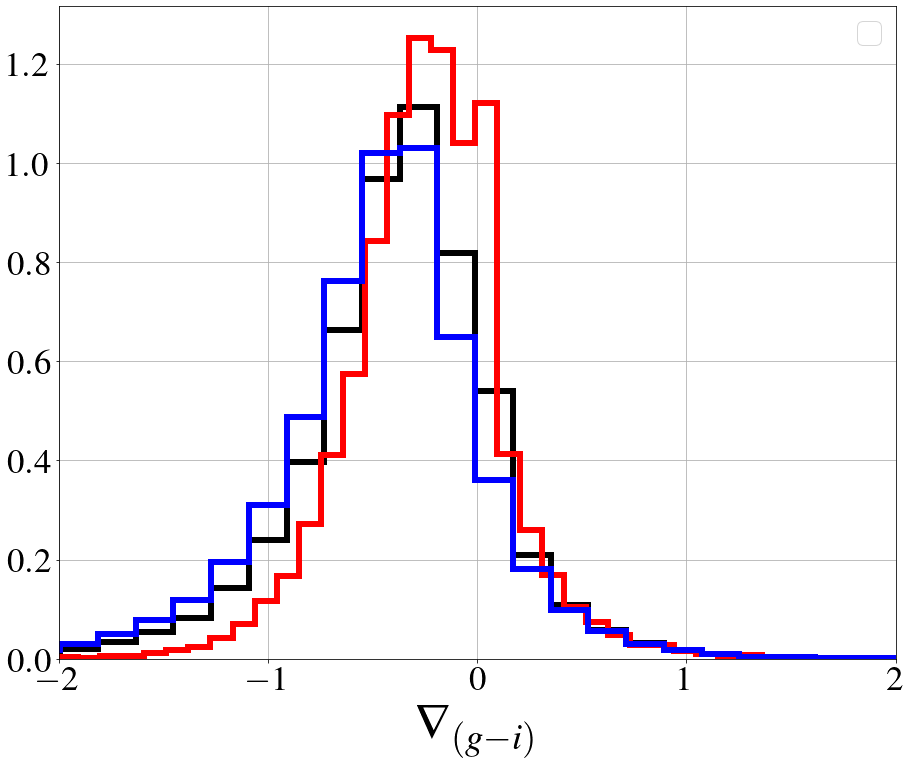

In [263]:
fig, ax= plt.subplots(figsize=(15,12))
# the histogram of the data
plt.hist(gradiente_gi, 60, density=True, histtype='step', color='black', lw=6)
plt.hist(gradgi_early, 60, density=True, histtype='step', color='red', lw=6)
plt.hist(gradgi_late, 60, density=True, histtype='step', color='blue', lw=6)


plt.xlabel(r'$ \nabla_{(g-i)} $', fontsize=50)
# plt.ylabel('Probability')
# plt.title('Color gradients histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2, 2)
plt.legend(fontsize=30)
# plt.ylim(0, 0.03)
label_size = 35
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.grid(True)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/hist_gi.png',format='png',dpi=200, bbox_inches = 'tight')

plt.show()

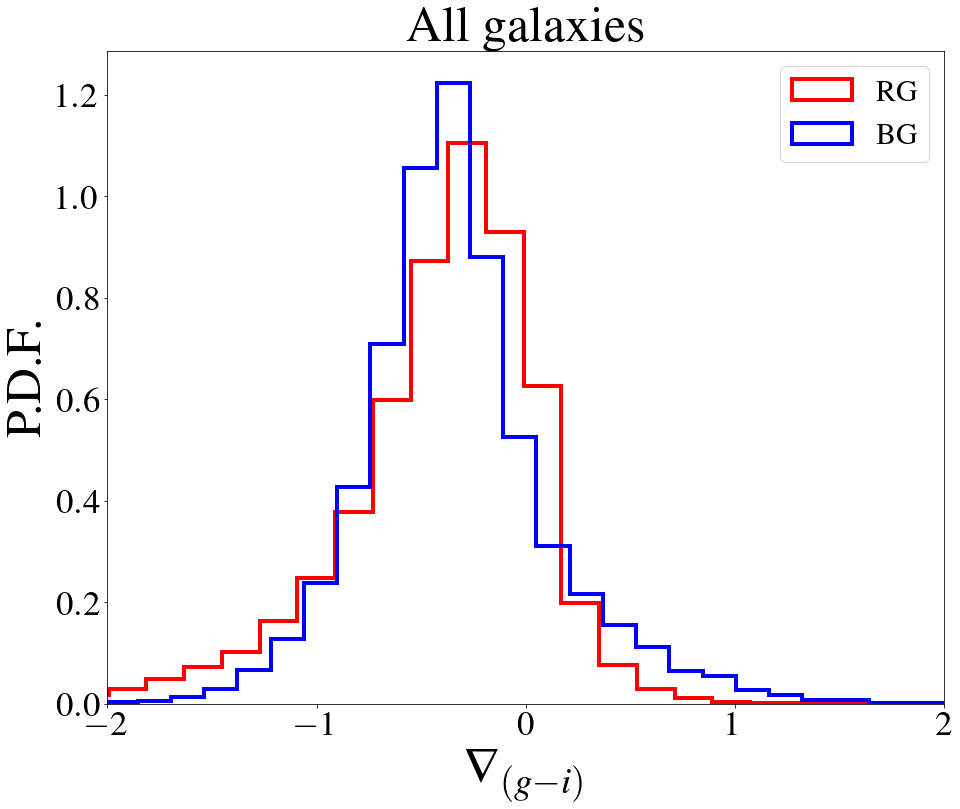

In [289]:
fig, ax= plt.subplots(figsize=(15,12))
# the histogram of the data
# plt.hist(grad_gr_red, 75, density=True, histtype='step', color='red', lw=8, label= r'RG $\nabla_{(g-r)}$')
plt.hist(grad_gi_red, 60, density=True, histtype='step', color='red', lw=4, label=r'RG  ')
# plt.hist(grad_gr_blue, 75, density=True, histtype='step', color='blue', lw=8, label=r'BG $\nabla_{(g-r)}$')
plt.hist(grad_gi_blue, 60, density=True, histtype='step', color='blue', lw=4, label=r'BG ')



plt.xlabel(r'$ \nabla_{(g-i)}$ ', fontsize=50)
plt.ylabel(r'P.D.F.', fontsize=50)
plt.title(r'All galaxies')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2, 2)
plt.legend(fontsize=30)
# plt.ylim(0, 0.03)
label_size = 35
matplotlib.rcParams['axes.titlesize'] = 50
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/hist_gigr.png',format='png',dpi=200, bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.


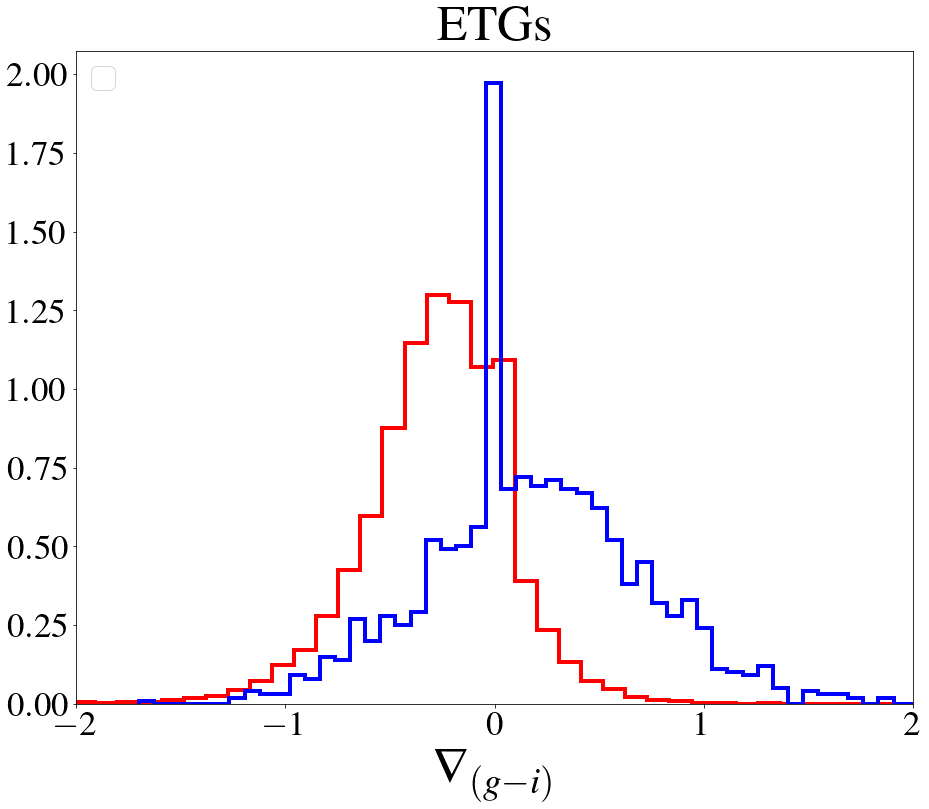

In [290]:

fig, ax= plt.subplots(figsize=(15,12))
# the histogram of the data
# plt.hist(grad1re_gr_red_early, 75, density=True, histtype='step', color='red', lw=8)
plt.hist(grad1re_gi_red_early, 60, density=True, histtype='step', color='red', lw=4)
# plt.hist(grad1re_gr_blue_early, 75, density=True, histtype='step', color='blue', lw=8)
plt.hist(grad1re_gi_blue_early, 60, density=True, histtype='step', color='blue', lw=4)



plt.xlabel(r'$ \nabla_{(g-i)}$ ', fontsize=50)
# plt.ylabel('Probability')
plt.title(r'ETGs')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2, 2)
plt.legend(fontsize=30)
# plt.ylim(0, 0.03)
label_size = 35
matplotlib.rcParams['axes.titlesize'] = 50
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/hist_gigr_early.png',format='png',dpi=200, bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.


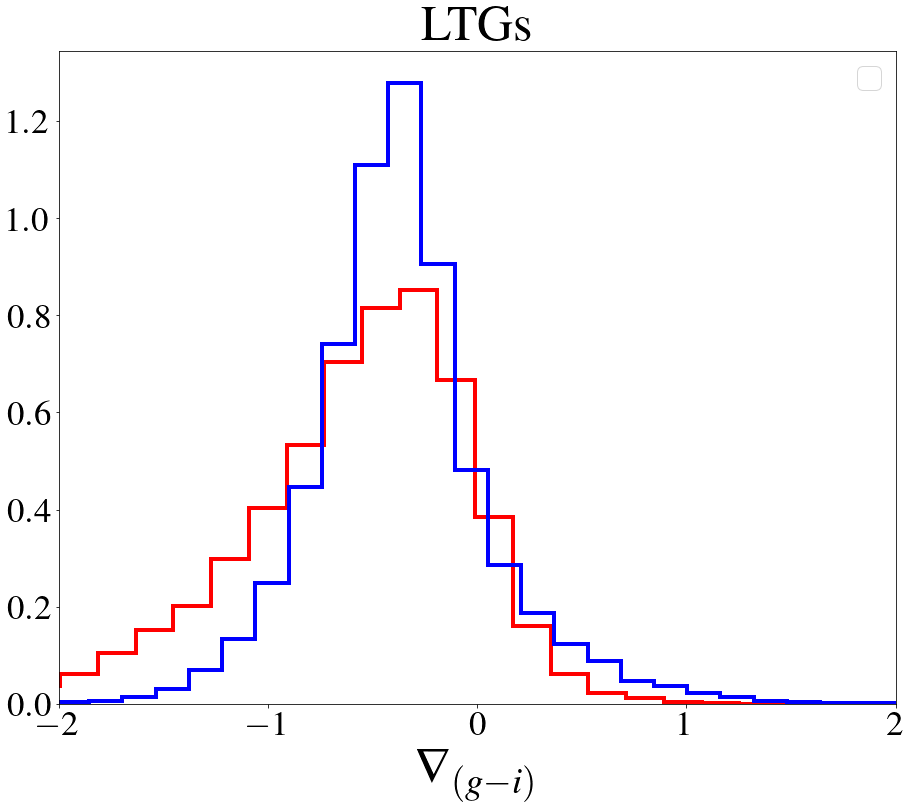

In [292]:

fig, ax= plt.subplots(figsize=(15,12))
# the histogram of the data
# plt.hist(grad1re_gr_red_late, 75, density=True, histtype='step', color='red', lw=8)
plt.hist(grad1re_gi_red_late, 60, density=True, histtype='step', color='red', lw=4)
# plt.hist(grad1re_gr_blue_late, 75, density=True, histtype='step', color='blue', lw=8)
plt.hist(grad1re_gi_blue_late, 60, density=True, histtype='step', color='blue', lw=4)



plt.xlabel(r'$ \nabla_{(g-i)}$ ', fontsize=50)
# plt.ylabel('Probability')
plt.title(r'LTGs')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-2, 2)
plt.legend(fontsize=30)
# plt.ylim(0, 0.03)
label_size = 35
matplotlib.rcParams['axes.titlesize'] = 50
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/hist_gigr_late.png',format='png',dpi=200, bbox_inches = 'tight')

plt.show()

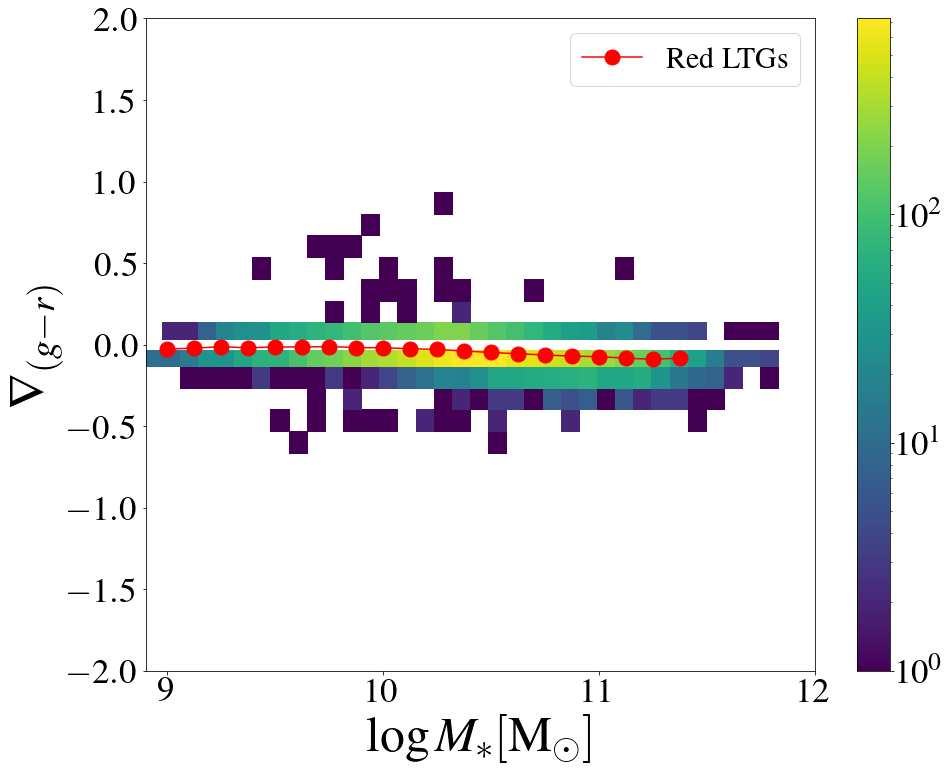

In [107]:
fig, ax= plt.subplots(figsize=(15,12))


# Red color gradient gr 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_red_late), grad1re_gr_red_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, zorder=3, color ='red', marker = 'o', markersize= 15,  label='Red LTGs')
plt.errorbar(gradgrlate_red_mean_bins[:-1], stat_gradgr_red_late_mean, yerr=stat_gradgr_red_late_std/np.sqrt(stat_gradgr_red_late_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reddelgr_Msdlate3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


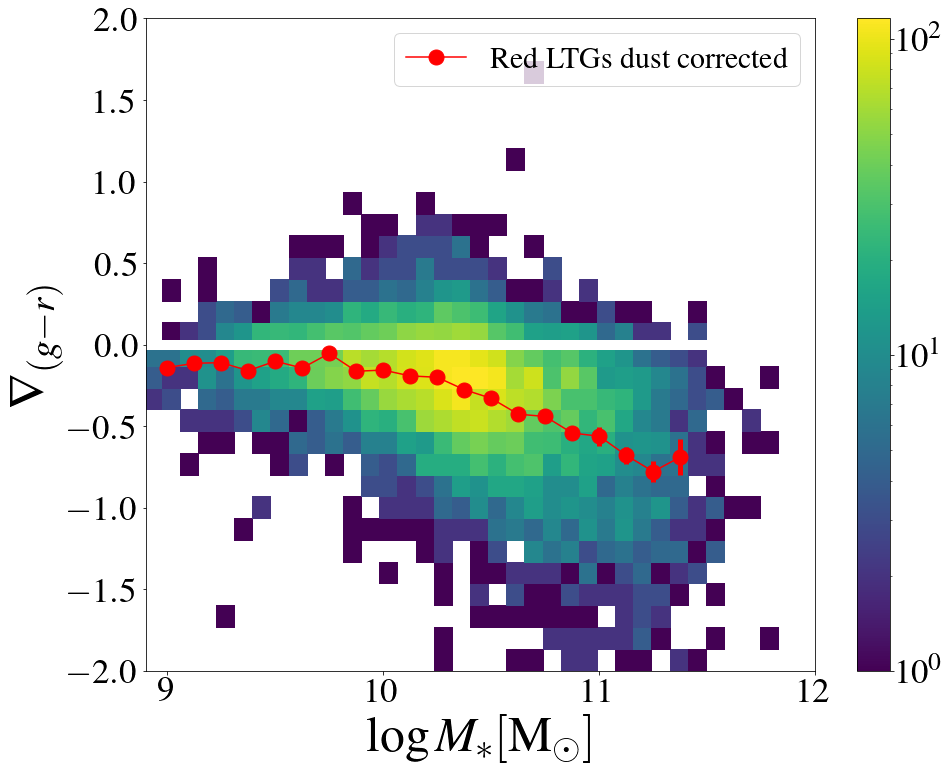

In [268]:
fig, ax= plt.subplots(figsize=(15,12))


# Red color gradient gr 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_red_late_dust), grad1re_gr_red_late_dust, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate_red_mean_bins_dust[:-1], stat_gradgr_red_late_mean_dust, zorder=3, color ='red', marker = 'o', markersize= 15,  label='Red LTGs dust corrected')
plt.errorbar(gradgrlate_red_mean_bins_dust[:-1], stat_gradgr_red_late_mean_dust, yerr=stat_gradgr_red_late_std_dust/np.sqrt(stat_gradgr_red_late_count_dust+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reddelgr_Msdlate_dust.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()


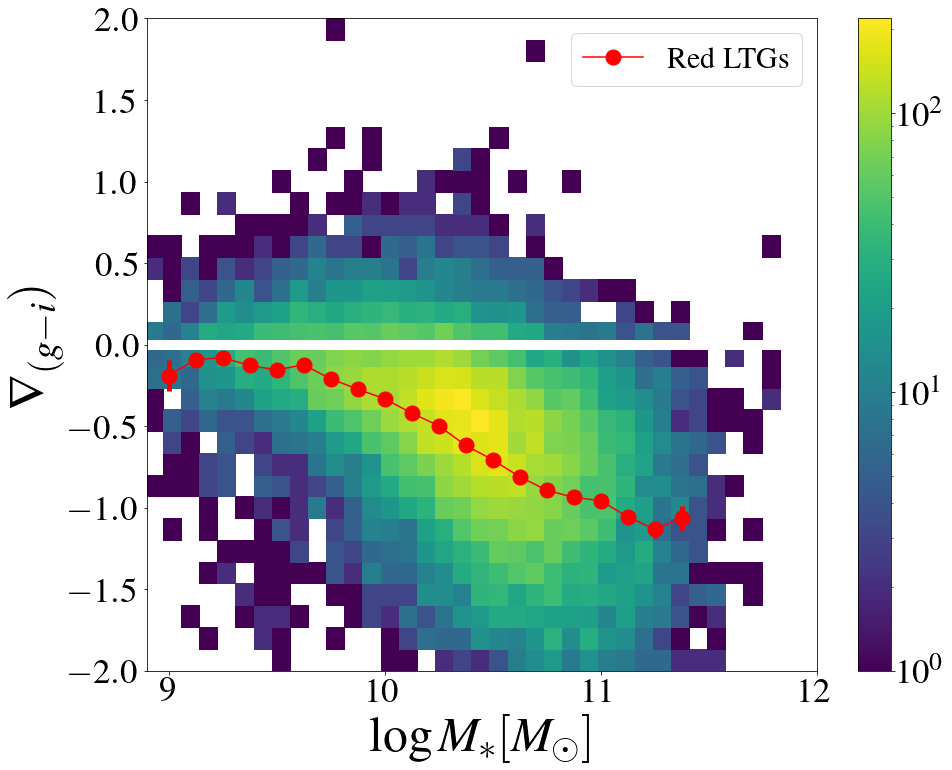

In [299]:
fig, ax= plt.subplots(figsize=(15,12))


# Red color gradient gi 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gi_red_late), grad1re_gi_red_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, zorder=3, color ='red', marker = 'o', markersize= 15,  label='Red LTGs')
plt.errorbar(gradgilate_red_mean_bins[:-1], stat_gradgi_red_late_mean, yerr=stat_gradgi_red_late_std/np.sqrt(stat_gradgi_red_late_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i})$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reddelgi_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

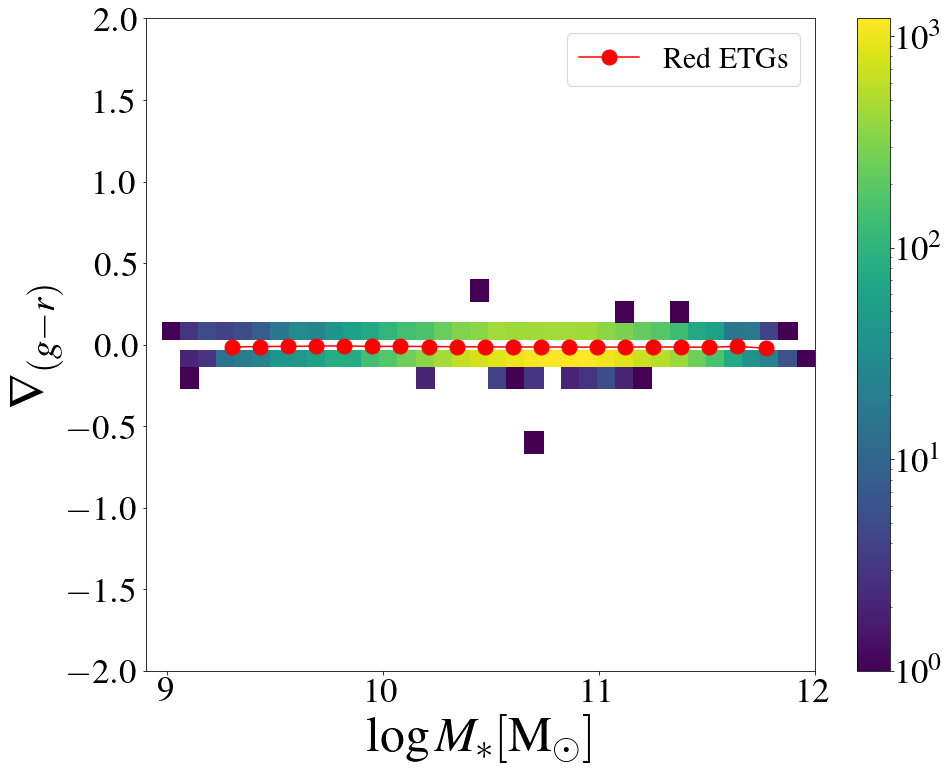

In [108]:
fig, ax= plt.subplots(figsize=(15,12))


# Red color gradient gr 1 Re VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_red_early), grad1re_gr_red_early, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, zorder=3, color ='red', marker = 'o', markersize= 15,  label='Red ETGs')
plt.errorbar(gradgrearly_red_mean_bins[:-1], stat_gradgr_red_early_mean, yerr=stat_gradgr_red_early_std/np.sqrt(stat_gradgr_red_early_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reddelgr_Msdearly3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

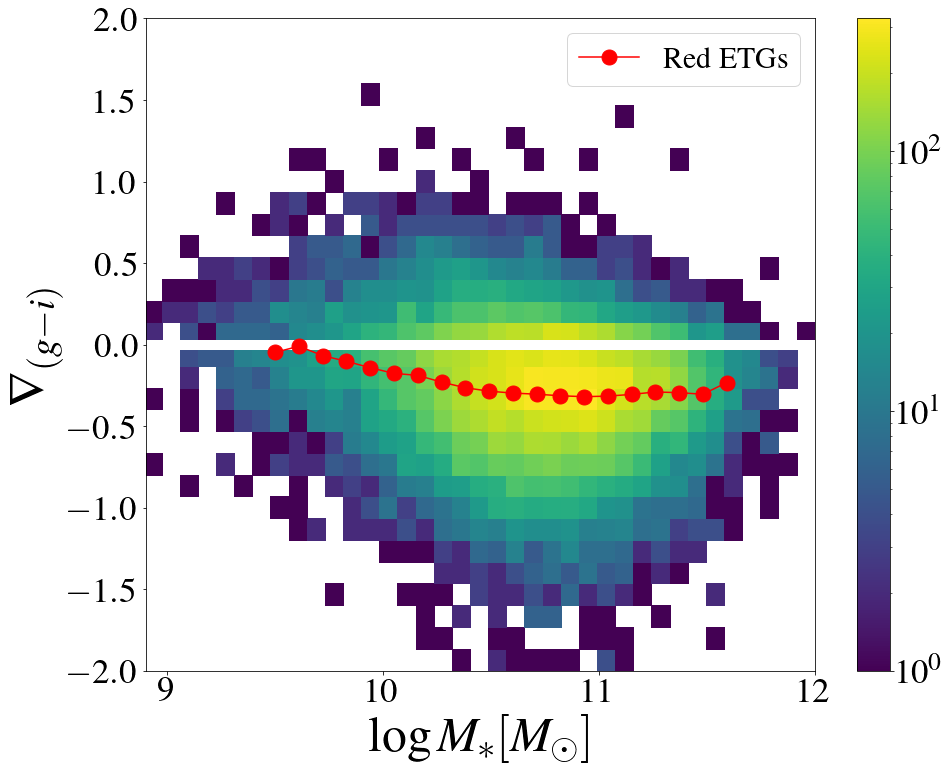

In [301]:
fig, ax= plt.subplots(figsize=(15,12))


# Red color gradient gi 1 Re VS Ms_d early Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gi_red_early), grad1re_gi_red_early, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, zorder=3, color ='red', marker = 'o', markersize= 15,  label='Red ETGs ')
plt.errorbar(gradgiearly_red_mean_bins[:-1], stat_gradgi_red_early_mean, yerr=stat_gradgi_red_early_std/np.sqrt(stat_gradgi_red_early_count+1), zorder=3, xerr=None, ls='None', ecolor='red', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/reddelgi_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

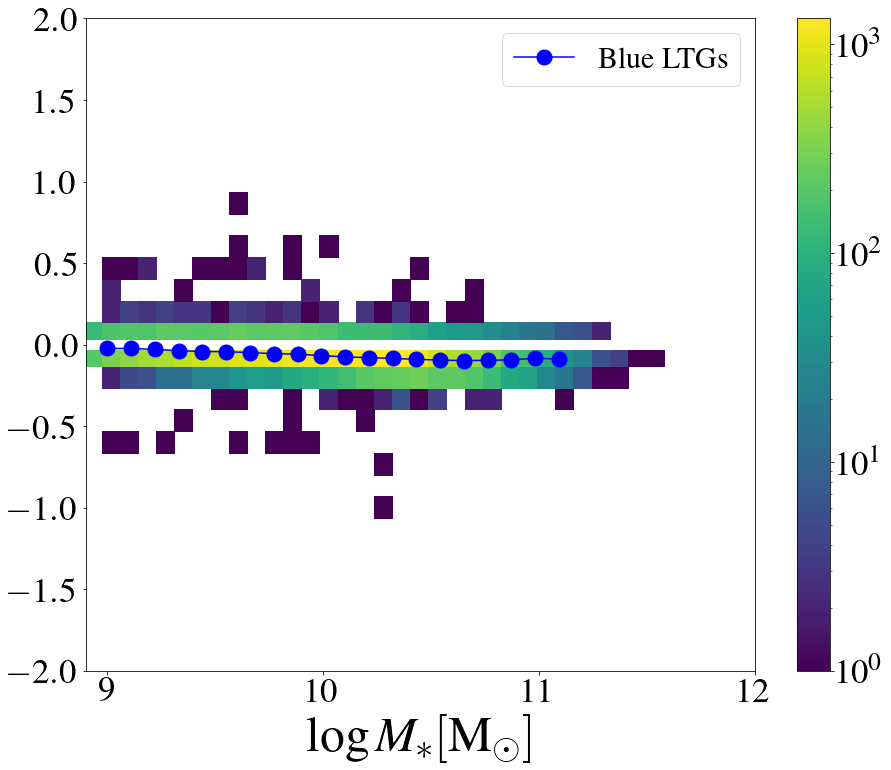

In [109]:
fig, ax= plt.subplots(figsize=(15,12))


# Blue color gradient gr 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_blue_late), grad1re_gr_blue_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, zorder=3, color ='blue', marker = 'o', markersize= 15,  label='Blue LTGs')
plt.errorbar(gradgrlate_blue_mean_bins[:-1], stat_gradgr_blue_late_mean, yerr=stat_gradgr_blue_late_std/np.sqrt(stat_gradgr_blue_late_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/bluedelgr_Msdlate3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

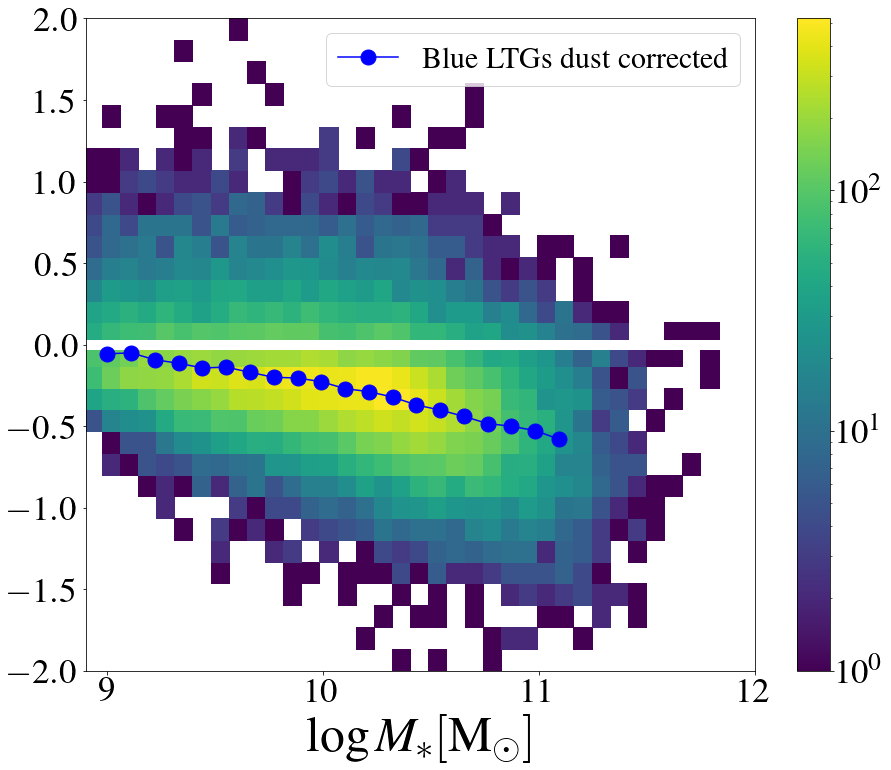

In [273]:
fig, ax= plt.subplots(figsize=(15,12))


# Blue color gradient gr 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_blue_late_dust), grad1re_gr_blue_late_dust, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrlate_blue_mean_bins_dust[:-1], stat_gradgr_blue_late_mean_dust, zorder=3, color ='blue', marker = 'o', markersize= 15,  label='Blue LTGs dust corrected')
plt.errorbar(gradgrlate_blue_mean_bins_dust[:-1], stat_gradgr_blue_late_mean_dust, yerr=stat_gradgr_blue_late_std_dust/np.sqrt(stat_gradgr_blue_late_count_dust+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
# plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=40)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/bluedelgr_Msdlate_dust.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [274]:
print(len(gr_red_late))
print(len(gr_red_late_dust))

38657
38657


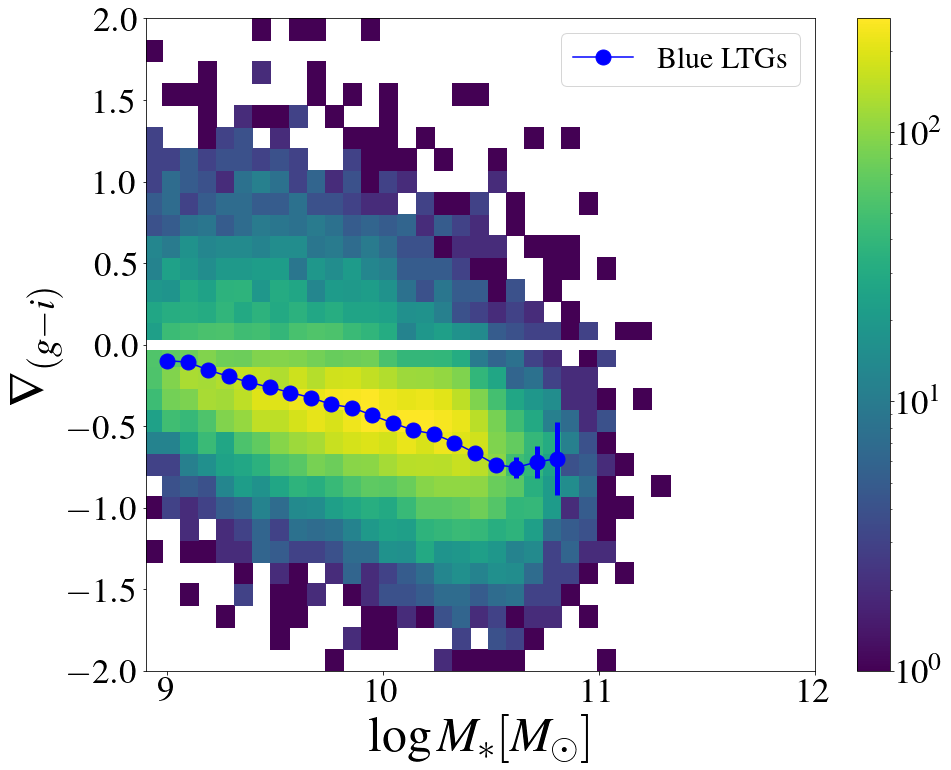

In [303]:
fig, ax= plt.subplots(figsize=(15,12))


# Blue  color gradient gi 1 Re VS Ms_d late  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gi_blue_late), grad1re_gi_blue_late, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, zorder=3, color ='blue', marker = 'o', markersize= 15,  label='Blue LTGs')
plt.errorbar(gradgilate_blue_mean_bins[:-1], stat_gradgi_blue_late_mean, yerr=stat_gradgi_blue_late_std/np.sqrt(stat_gradgi_blue_late_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/bluedelgi_Msdlate.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

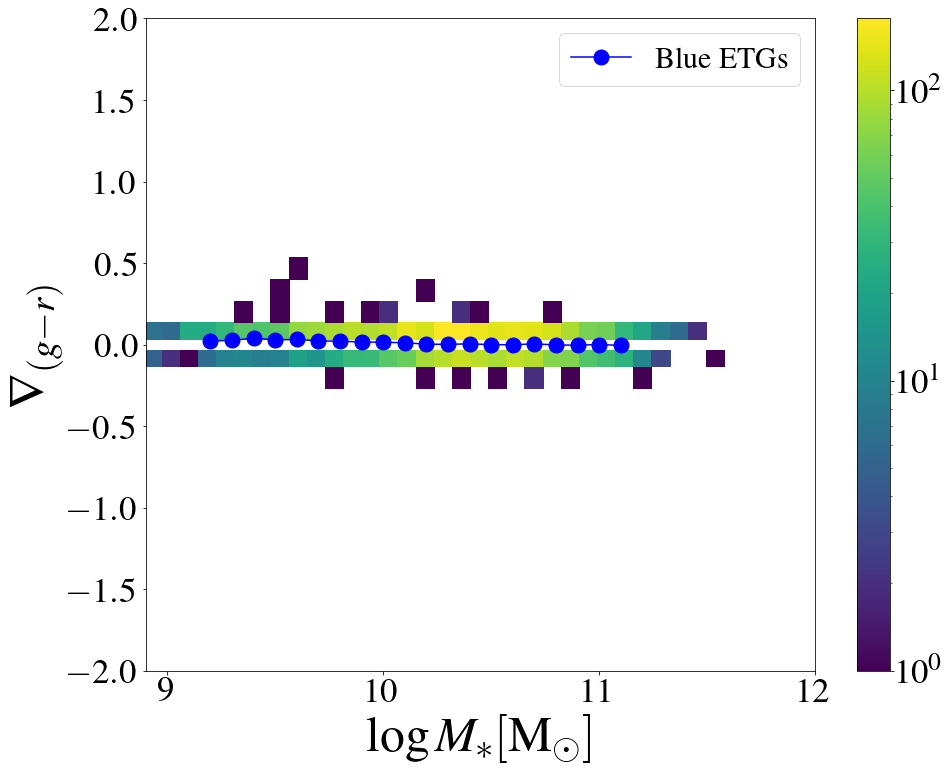

In [110]:
fig, ax= plt.subplots(figsize=(15,12))


# Blue color gradient gr 1 Re VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gr_blue_early), grad1re_gr_blue_early, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, zorder=3, color ='Blue', marker = 'o', markersize= 15,  label='Blue ETGs')
plt.errorbar(gradgrearly_blue_mean_bins[:-1], stat_gradgr_blue_early_mean, yerr=stat_gradgr_blue_early_std/np.sqrt(stat_gradgr_blue_early_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [\rm M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-r)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/bluedelgr_Msdearly3.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

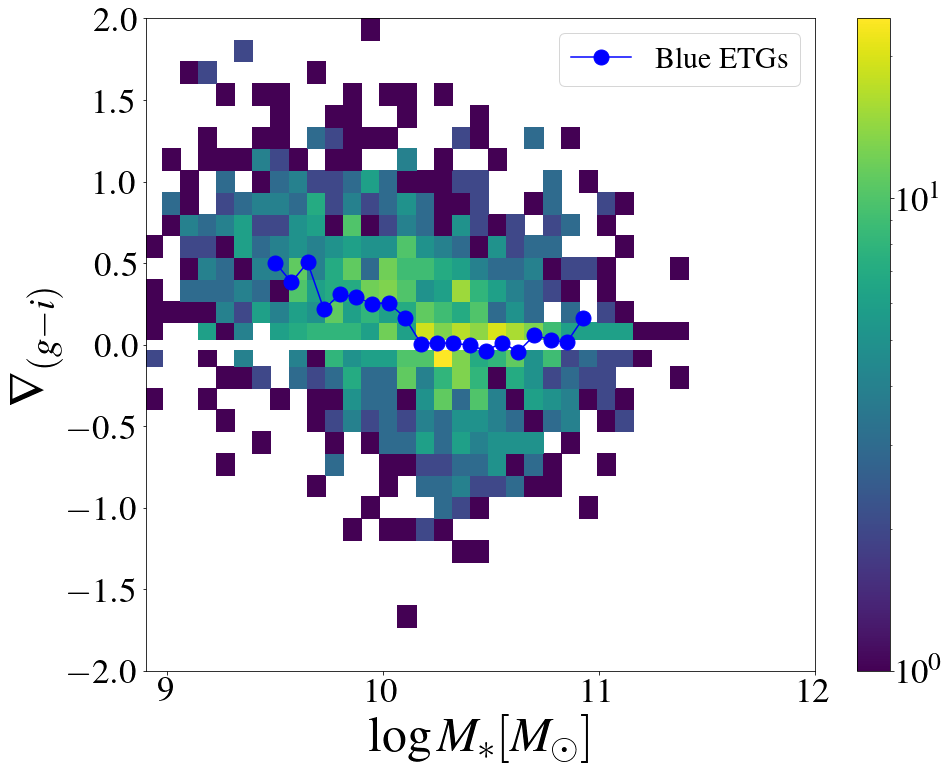

In [306]:
fig, ax= plt.subplots(figsize=(15,12))


# Blue color gradient gi 1 Re VS Ms_d early  Diamond
logMs= np.linspace(8,12)
plt.hist2d(np.log10(Ms_gi_blue_early), grad1re_gi_blue_early, bins=(50,30), range=[[7.8,12],[-2.0,2.0]], zorder=1, norm=LogNorm(), cmap='viridis')
plt.plot(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, zorder=3, color ='blue', marker = 'o', markersize= 15,  label='Blue ETGs ')
plt.errorbar(gradgiearly_blue_mean_bins[:-1], stat_gradgi_blue_early_mean, yerr=stat_gradgi_blue_early_std/(stat_gradgi_blue_early_count+1), zorder=3, xerr=None, ls='None', ecolor='blue', elinewidth=5)
plt.colorbar() 
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='white', zorder=1, linestyle='-', lw=10)



# Add axis labels

plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$ ', fontsize=50)
plt.ylabel(r'$\nabla_{(g-i)}$', fontsize=50)

#set axis limits
plt.ylim(-2.0, 2.0)
plt.xlim(8.9,12)

#adjust tick label font size
label_size = 35
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.legend(fontsize=30)
plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/bluedelgi_Msdearly.pdf',format='pdf',dpi=200, bbox_inches = 'tight')
plt.show()

In [278]:


x_val_late = dlate_nr_mean_bins[:-1]
y_val_late = stat_dlate_nr_mean
std_late = stat_dlate_nr_std / np.sqrt(len(binnum_dlate_nr_mean)+1)
# Define a dictionary containing Students data 
data = {'x_mean': x_val_late, 
        'y_mean': y_val_late, 
        'y_err': std_late} 
  
# Convert the dictionary into DataFrame 
late_data = pd.DataFrame(data) 
  

late_data.to_csv (r'/Users/ximena/Desktop/UNAM/UNAM/mass_frac/late_data.csv', index = False, header=True)
  
# Observe the result 
late_data

x_mean    y_mean     y_err
0    9.000  0.296102  0.001071
1    9.115  0.319244  0.001132
2    9.230  0.364266  0.001180
3    9.345  0.381367  0.001160
4    9.460  0.424026  0.001271
5    9.575  0.438674  0.001252
6    9.690  0.463417  0.001244
7    9.805  0.451977  0.001304
8    9.920  0.482196  0.001324
9   10.035  0.484708  0.001313
10  10.150  0.495064  0.001281
11  10.265  0.516696  0.001246
12  10.380  0.550264  0.001238
13  10.495  0.598333  0.001239
14  10.610  0.660896  0.001171
15  10.725  0.731285  0.001209
16  10.840  0.817968  0.001314
17  10.955  0.891089  0.001304
18  11.070  1.030980  0.001476
19  11.185  1.129534  0.001506

In [279]:
x_val_early = dearly_nr_mean_bins[:-1]
y_val_early = stat_dearly_nr_mean
std_early = stat_dearly_nr_std/np.sqrt(len(binnum_dearly_nr_mean)+1)
# Define a dictionary containing Students data 
data = {'x_mean': x_val_early, 
        'y_mean': y_val_early, 
        'y_err': std_early} 
  
# Convert the dictionary into DataFrame 
early_data = pd.DataFrame(data) 
  

early_data.to_csv (r'/Users/ximena/Desktop/UNAM/UNAM/mass_frac/early_data.csv', index = False, header=True)
  
# Observe the result 
early_data

x_mean    y_mean     y_err
0      9.5  0.121983  0.001482
1      9.6  0.156684  0.001712
2      9.7  0.147022  0.001840
3      9.8  0.145878  0.001739
4      9.9  0.162979  0.001735
5     10.0  0.181036  0.001609
6     10.1  0.216202  0.001576
7     10.2  0.258334  0.001578
8     10.3  0.305736  0.001546
9     10.4  0.353347  0.001594
10    10.5  0.402436  0.001553
11    10.6  0.455928  0.001506
12    10.7  0.499136  0.001406
13    10.8  0.570352  0.001394
14    10.9  0.635904  0.001351
15    11.0  0.707412  0.001394
16    11.1  0.770777  0.001352
17    11.2  0.841121  0.001367
18    11.3  0.921804  0.001314
19    11.4  0.976272  0.001157

In [280]:
##### pearson coefficient 

mass_del = scipy.stats.pearsonr(np.log10(Ms_d), gradiente_gr)
re_del = scipy.stats.pearsonr(np.log10(Re_r_d), gradiente_gr)
n_del = scipy.stats.pearsonr(np.log10(n_r_d), gradiente_gr)
sSFR_del = scipy.stats.pearsonr(log_sSFR, gradiente_gr_sfr)
S1_del = scipy.stats.pearsonr(np.log10(S1_d), gradiente_gr)

# Define a dictionary containing Students data 
data = {'mass_pearson': mass_del[:-1], 
        'Re_pearson': re_del[:-1], 
        'nindex_pearson': n_del[:-1],
        'sSFR_pearson': sSFR_del[:-1],
        'Sigma1_pearson': S1_del[:-1]} 
  
# Convert the dictionary into DataFrame 
pearson_co = pd.DataFrame(data) 

pearson_co
  

mass_pearson  Re_pearson  nindex_pearson  sSFR_pearson  Sigma1_pearson
0     -0.189559   -0.324793        0.147467      -0.23535       -0.112325

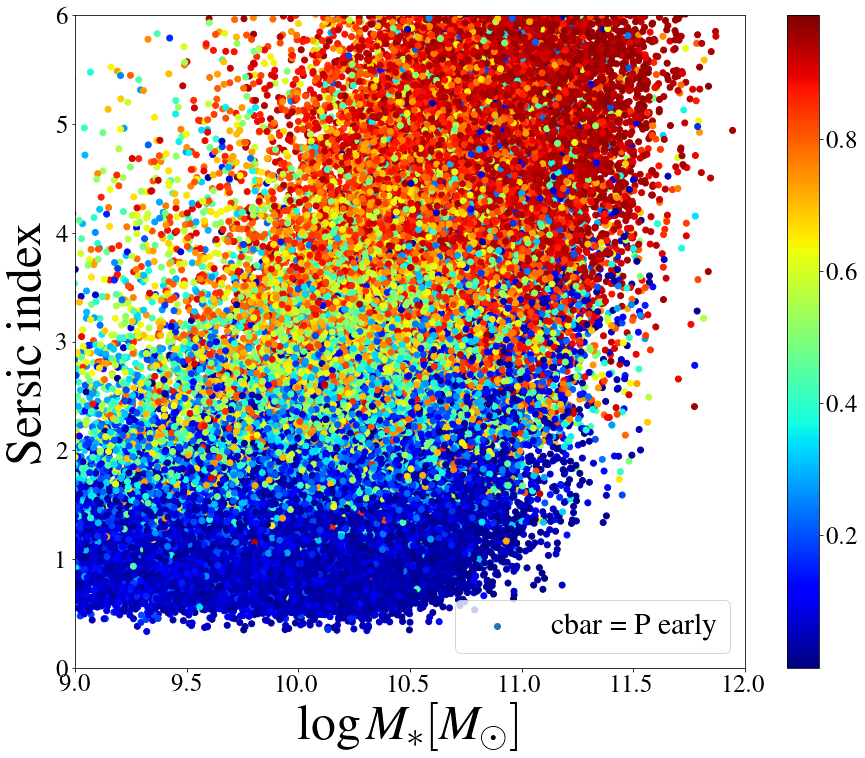

In [281]:
fig, ax= plt.subplots(figsize=(15,12))

plt.scatter(np.log10(Ms_d), nr_d, c=P_early, cmap='jet', label=r'cbar = P early')


plt.ylabel(r'Sersic index', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=50)

plt.ylim(0,6)
plt.xlim(9.0, 12)


#adjust tick label font size

matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25

plt.legend(fontsize=30)
plt.colorbar()

plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/sersic_scatter.png',format='png',dpi=100, bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.


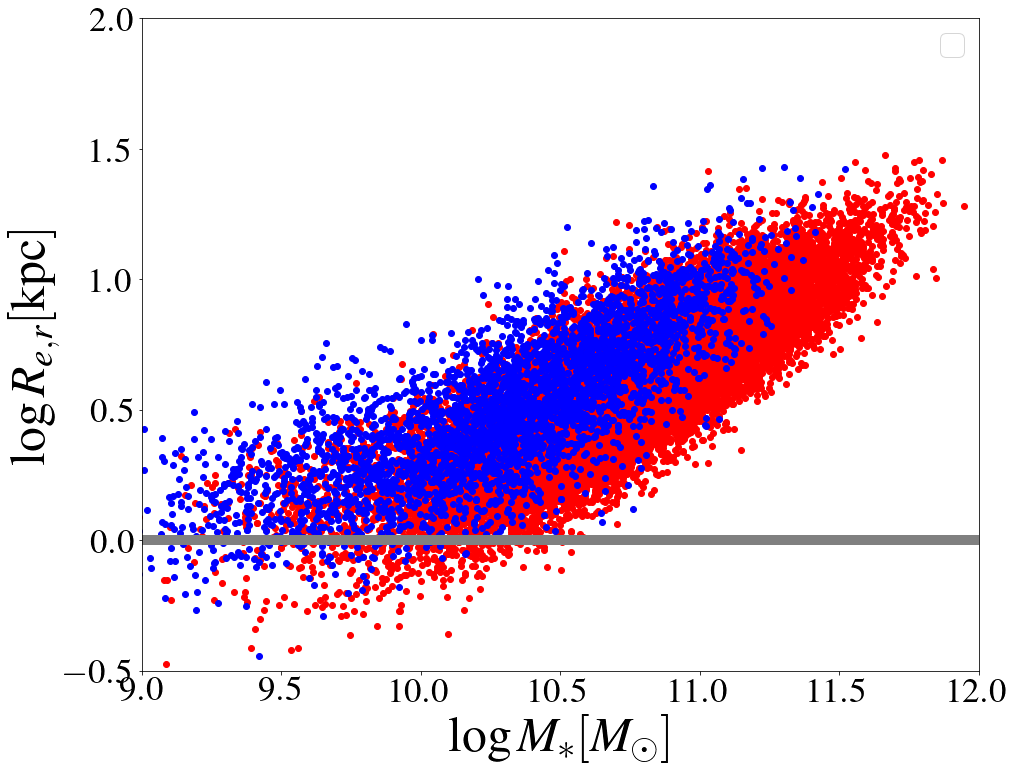

In [368]:
fig, ax= plt.subplots(figsize=(15,12))

plt.scatter(np.log10(Ms_gr_red_early), np.log10(re_r_d_early_red), color='red')
plt.scatter(np.log10(Ms_gr_blue_early), np.log10(re_r_d_early_blue), color='blue')
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='-', lw=10)


plt.ylabel(r'$\log R_{e,r} [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=50)

plt.ylim(-0.5, 2)
plt.xlim(9.0, 12)


#adjust tick label font size

matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25

plt.legend(fontsize=30)


plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/early_mass_vs_rer.png',format='png',dpi=100, bbox_inches = 'tight')

plt.show()

No handles with labels found to put in legend.


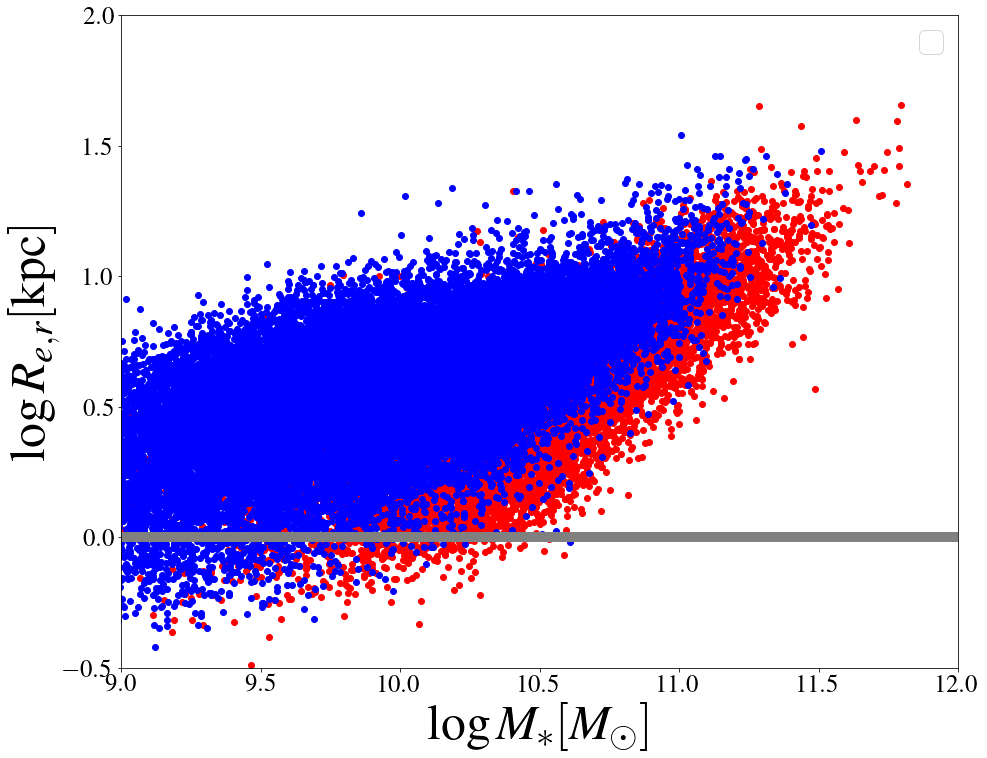

In [369]:
fig, ax= plt.subplots(figsize=(15,12))

plt.scatter(np.log10(Ms_gr_red_late), np.log10(re_r_d_late_red), color='red')
plt.scatter(np.log10(Ms_gr_blue_late), np.log10(re_r_d_late_blue), color='blue')
x = [8.9,12]
y = [0,0]
plt.plot(x, y, color='gray', zorder=1, linestyle='-', lw=10)


plt.ylabel(r'$\log R_{e,r} [\rm kpc]$', fontsize=50)
plt.xlabel(r'$\log M_{\ast} [M_{\odot}]$', fontsize=50)

plt.ylim(-0.5, 2)
plt.xlim(9.0, 12)


#adjust tick label font size

matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25

plt.legend(fontsize=30)


plt.savefig('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/late_mass_vs_rer.png',format='png',dpi=100, bbox_inches = 'tight')

plt.show()

In [377]:
# creating the table from sim data

data = {'early_mass_bins': gradgiearly_mean_bins[:-1], 'avg_early_grad':stat_gradgi_early_mean, 
        'early_y_err_up':stat_gradgi_early_std/np.sqrt(stat_gradgi_early_count+1),
        'early_y_err_down':-(stat_gradgi_early_std/np.sqrt(stat_gradgi_early_count+1)),
        'late_mass_bins': gradgilate_mean_bins[:-1], 'avg_late_grad':stat_gradgi_late_mean, 
        'late_y_err_up':stat_gradgi_late_std/np.sqrt(stat_gradgi_late_count+1),
        'late_y_err_down':-(stat_gradgi_late_std/np.sqrt(stat_gradgi_late_count+1)) 
         }

ta = pd.DataFrame(data, columns = ['early_mass_bins', 'avg_early_grad', 'early_y_err_up','early_y_err_down',
                                   'late_mass_bins', 'avg_late_grad', 'late_y_err_up', 'late_y_err_down' ])
# df

In [378]:
ta

early_mass_bins  avg_early_grad  early_y_err_up  early_y_err_down  \
0              9.50        0.092104        0.065815         -0.065815   
1              9.61        0.150606        0.050901         -0.050901   
2              9.72        0.028323        0.034326         -0.034326   
3              9.83       -0.014011        0.028454         -0.028454   
4              9.94       -0.066268        0.023178         -0.023178   
5             10.05       -0.119669        0.018797         -0.018797   
6             10.16       -0.167716        0.014831         -0.014831   
7             10.27       -0.204758        0.011624         -0.011624   
8             10.38       -0.246610        0.008938         -0.008938   
9             10.49       -0.272917        0.007351         -0.007351   
10            10.60       -0.287753        0.006592         -0.006592   
11            10.71       -0.294520        0.006172         -0.006172   
12            10.82       -0.308863        0.005855         -0.005855   
13            10.93       -0.313465        0.006120         -0.006120   
14            11.04       -0.312105        0.007304         -0.007304   
15            11.15       -0.304739        0.008381         -0.008381   
16            11.26       -0.289338        0.012216         -0.012216   
17            11.37       -0.293141        0.019714         -0.019714   
18            11.48       -0.304209        0.039681         -0.039681   
19            11.59       -0.232691        0.113993         -0.113993   

    late_mass_bins  avg_late_grad  late_y_err_up  late_y_err_down  
0             9.00      -0.104364       0.014424        -0.014424  
1             9.12      -0.128885       0.011400        -0.011400  
2             9.24      -0.158331       0.009143        -0.009143  
3             9.36      -0.210256       0.009668        -0.009668  
4             9.48      -0.246123       0.008648        -0.008648  
5             9.60      -0.268506       0.007923        -0.007923  
6             9.72      -0.307330       0.006477        -0.006477  
7             9.84      -0.344395       0.006390        -0.006390  
8             9.96      -0.392035       0.006799        -0.006799  
9            10.08      -0.461004       0.005785        -0.005785  
10           10.20      -0.502041       0.007294        -0.007294  
11           10.32      -0.578153       0.009038        -0.009038  
12           10.44      -0.668265       0.011591        -0.011591  
13           10.56      -0.751606       0.015895        -0.015895  
14           10.68      -0.832971       0.022090        -0.022090  
15           10.80      -0.869040       0.036333        -0.036333  
16           10.92      -0.957775       0.060946        -0.060946  
17           11.04      -0.977432       0.160988        -0.160988  
18           11.16      -1.075966       0.195483        -0.195483  
19           11.28      -1.120928       0.709181        -0.709181

In [379]:
ta.to_csv('/Users/ximena/Desktop/UNAM/UNAM/mass_frac/gi_gradients.csv')
